## Import model and training sets

In [1]:
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(1, parent_dir+r'\Covariance and Adjacency Matrix')
from DataManager import dataManager



In [2]:
import h5py
import numpy as np
filepath = parent_dir+'\datasets\sample_patients\pat_FR_620.mat'
variables = {}
f = h5py.File(filepath, 'r')
for k, v in f.items():
    variables[k] = np.array(v)
for key in variables.keys():
    print("name:", key)
    print("shape:", variables[key].shape)
    print("-----------------------")
#print sample EGG signal from one node

name: X_test
shape: (640, 31, 1518)
-----------------------
name: X_train
shape: (640, 31, 1395)
-----------------------
name: clip_sizes_test
shape: (2, 129)
-----------------------
name: clip_sizes_train
shape: (2, 127)
-----------------------
name: conv_sizes
shape: (1, 1)
-----------------------
name: n_pre_szr
shape: (1, 1)
-----------------------
name: sel_win_nums_test
shape: (1, 1518)
-----------------------
name: sel_win_nums_train
shape: (1, 1395)
-----------------------
name: soz_ch_ids
shape: (5, 1)
-----------------------
name: stride_sec
shape: (1, 1)
-----------------------
name: window_size_sec
shape: (1, 1)
-----------------------
name: y_test
shape: (1, 1518)
-----------------------
name: y_train
shape: (1, 1395)
-----------------------


In [3]:
dm = dataManager(variables["X_train"],variables["X_test"],variables["y_train"],variables["y_test"],10**(-4))
#dm.normalize()

--------data manager successfully initialized--------


In [4]:
import torch
import torch.autograd
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
sys.path.insert(1, parent_dir+r'\Unsupervised GCN')
from GCN import *


In [27]:
#model = torch.load(parent_dir+r'\Unsupervised GCN\models\draft_2l_GCN.pkl')
#torch.save(model.state_dict(), parent_dir+r'\Unsupervised GCN\models\draft_2l_GCNdict.pkl')

In [5]:
import matplotlib.pyplot as plt
from scipy.linalg import fractional_matrix_power
def show_heat_map(m):
    plt.imshow(m, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.show()
    
    
def create_DAD(adj):
    np.fill_diagonal(adj, 1)
    rowsum = np.sum(adj, axis=1)
    d = np.diag_indices(adj.shape[0]) 
    D = np.zeros(adj.shape)
    D[d] = rowsum
    #print(rowsum)
    D = fractional_matrix_power(D, -0.5)
    #print(D)
    return D@adj@D

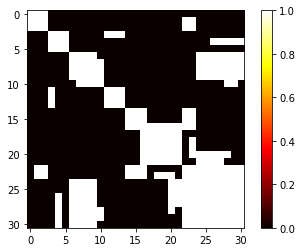

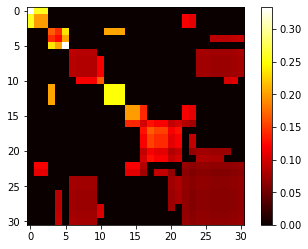

In [6]:
#first fine tune a good threshold n
n = 5*10**-5
dm.re_threshold(n)
show_heat_map(dm.A_train)
show_heat_map(create_DAD(dm.A_train))

In [18]:
from tqdm import tqdm
def get_sim_matrix(dm, model_dir):
    A = torch.from_numpy(create_DAD(dm.A_train)).float()
    X_train = torch.from_numpy(dm.X_train).float()
    X_test = torch.from_numpy(dm.X_test).float()
    device = torch.device('cpu')
    A = A.to(device)
    input_train = X_train.to(device)
    input_test = X_test.to(device)
    parameters = {
        'body': dm.X_train.shape[2],
        'batch_size': 64,
        'n_layers': 2,
    }
    model = Net(parameters['body'], parameters['n_layers'], F.relu, bias=True).to(device)
    model.load_state_dict(torch.load(model_dir))
    model.eval()
    batch_size = parameters['batch_size']

    sim_train = []
    sim_test = []
    permutation = range(input_train.shape[0])

    for i in tqdm(range(0,input_train.shape[0], batch_size)):

        indices = permutation[i:i+batch_size] if i+batch_size < input_train.shape[0] else permutation[i:] 
        batch_train= input_train[indices, :,:]
        batch_test= input_test[indices, :,:]
        
        sim1 = model(batch_train, A).to(device)
        sim_train.append(sim1.cpu().detach().numpy())
        
        sim2 = model(batch_test, A).to(device)
        sim_test.append(sim2.cpu().detach().numpy())
    print()
    return np.vstack(sim_train), np.vstack(sim_test)
    

In [19]:
model_dir = parent_dir+r'\Unsupervised GCN\models\draft_2l_GCNdict.pkl'
sim_train, sim_test = get_sim_matrix(dm, model_dir)

100%|██████████| 22/22 [00:53<00:00,  2.43s/it]


In [20]:
print(sim_train.shape)

(1387, 31, 31)


ictal


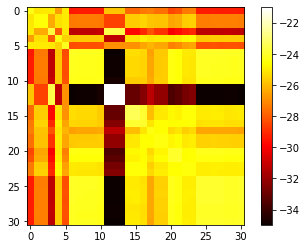

ictal


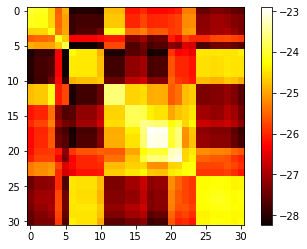

ictal


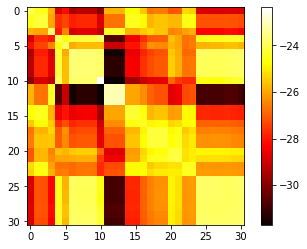

ictal


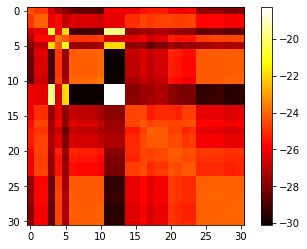

ictal


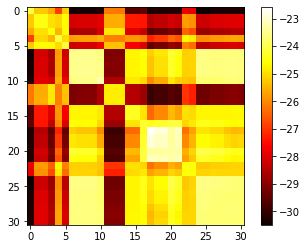

ictal


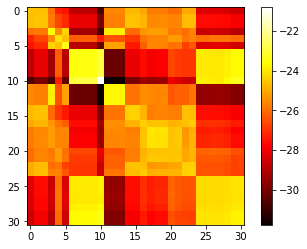

ictal


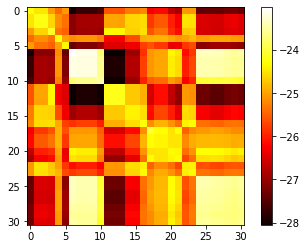

ictal


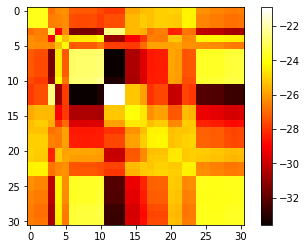

ictal


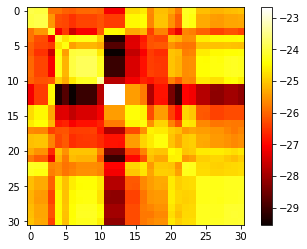

ictal


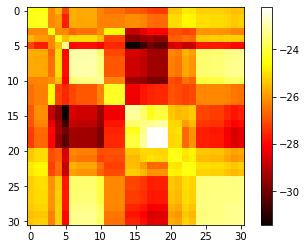

ictal


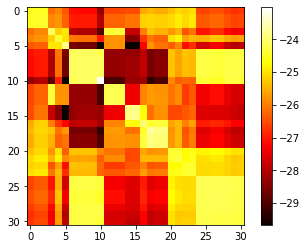

ictal


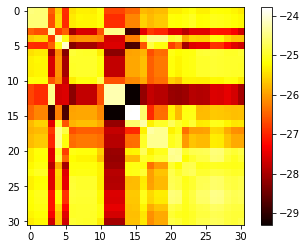

ictal


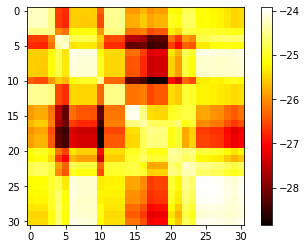

ictal


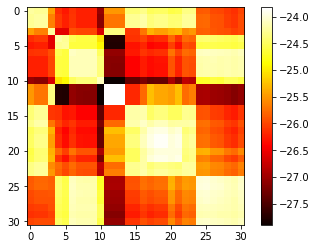

ictal


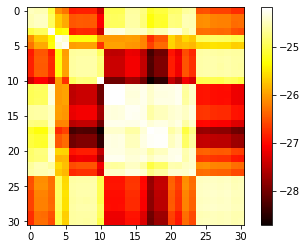

ictal


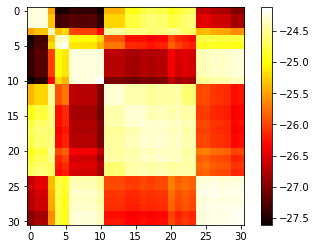

ictal


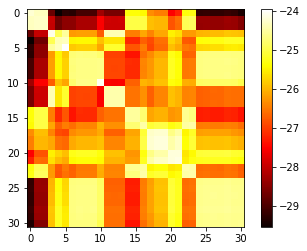

ictal


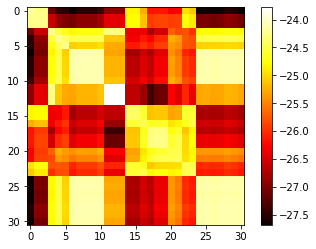

ictal


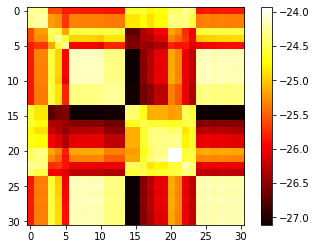

ictal


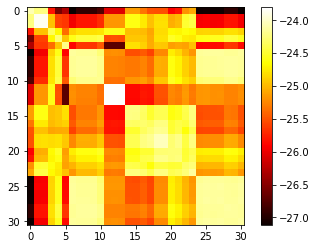

ictal


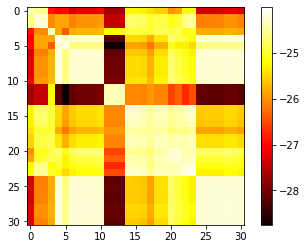

ictal


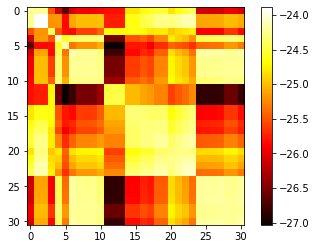

ictal


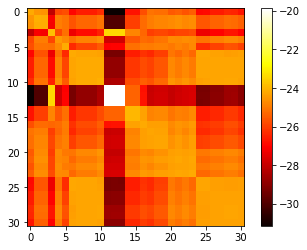

ictal


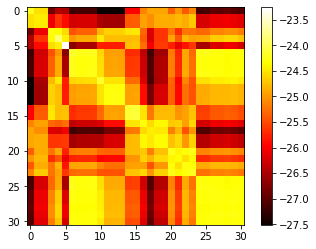

ictal


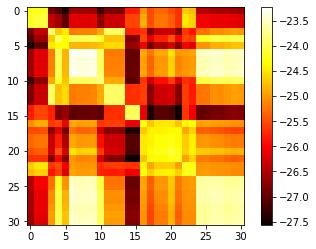

ictal


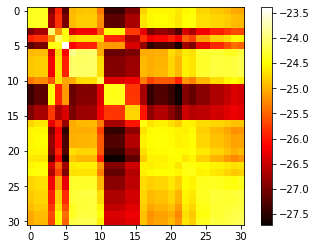

ictal


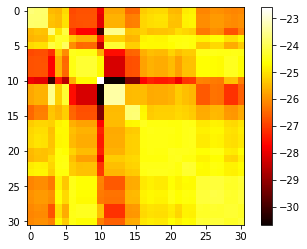

ictal


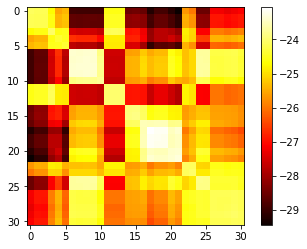

ictal


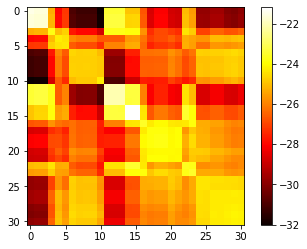

ictal


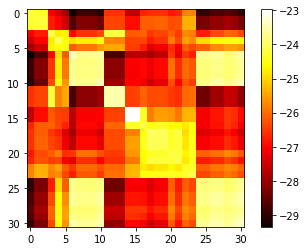

ictal


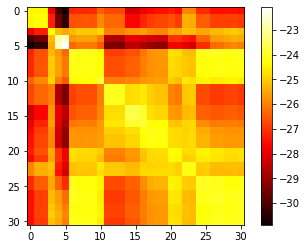

ictal


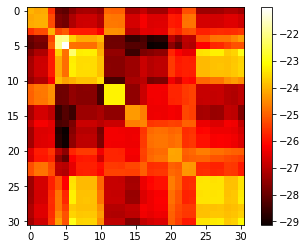

ictal


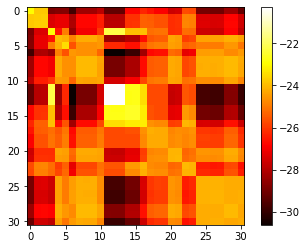

ictal


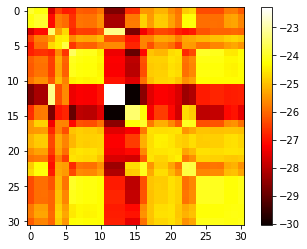

ictal


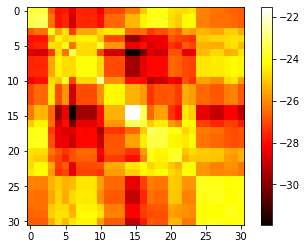

ictal


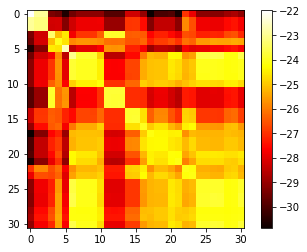

ictal


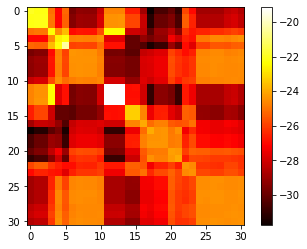

ictal


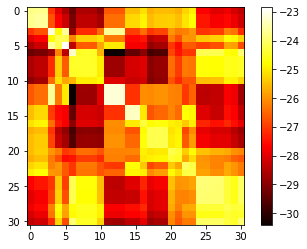

ictal


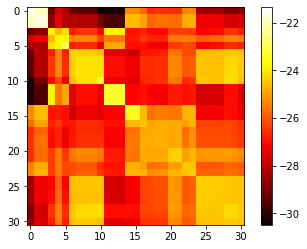

ictal


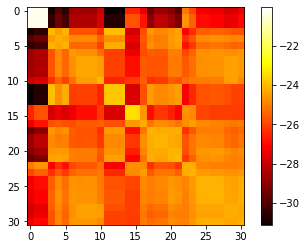

ictal


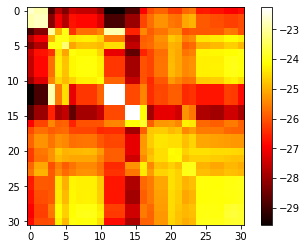

ictal


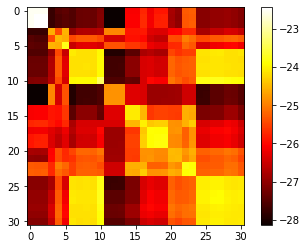

ictal


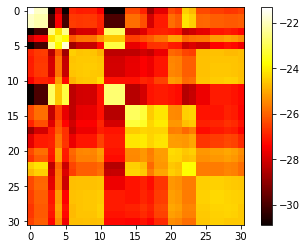

ictal


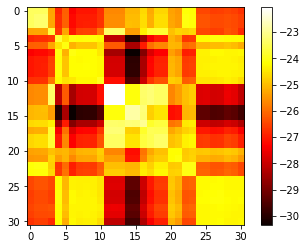

ictal


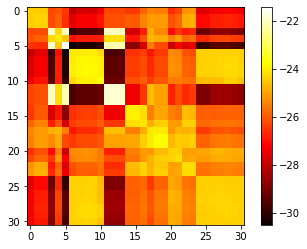

ictal


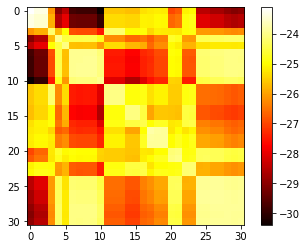

ictal


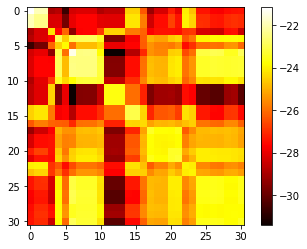

ictal


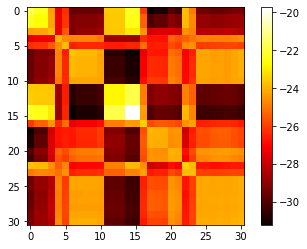

ictal


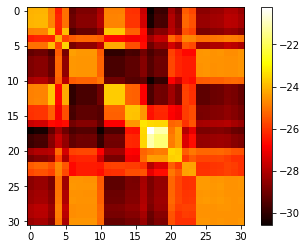

ictal


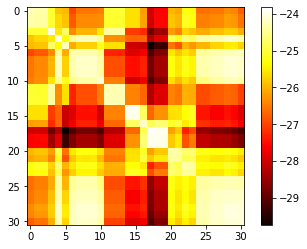

ictal


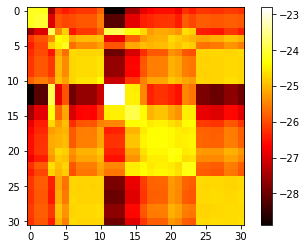

ictal


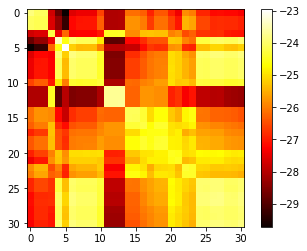

ictal


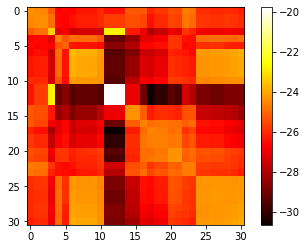

ictal


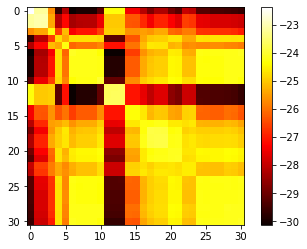

ictal


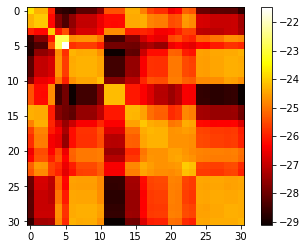

ictal


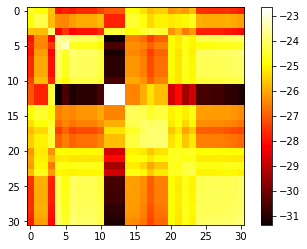

ictal


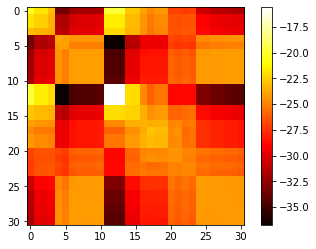

ictal


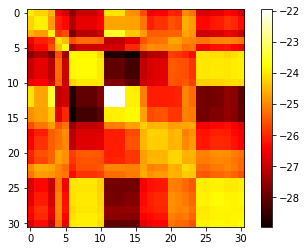

ictal


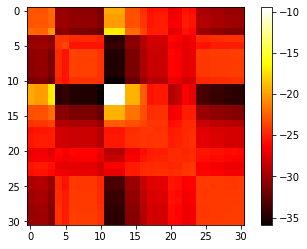

ictal


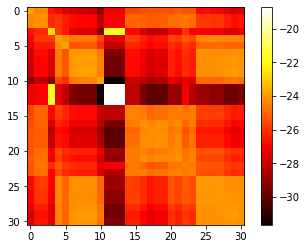

ictal


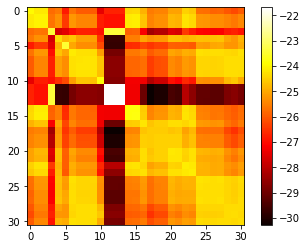

ictal


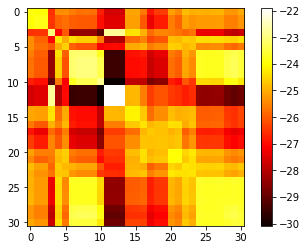

ictal


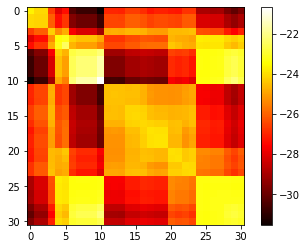

ictal


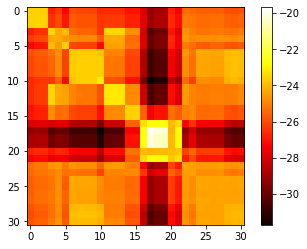

ictal


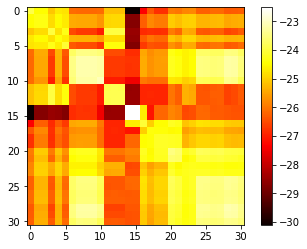

ictal


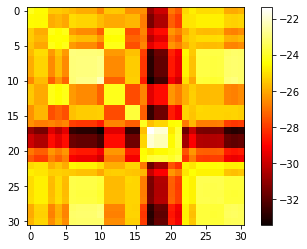

ictal


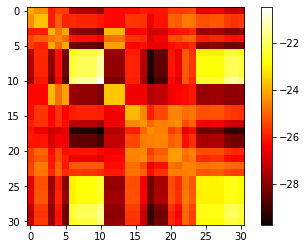

ictal


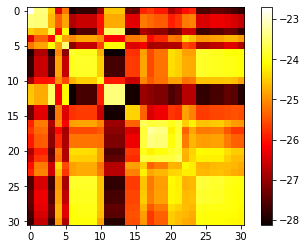

ictal


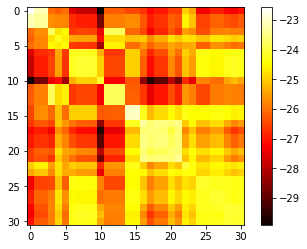

ictal


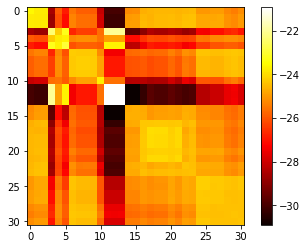

ictal


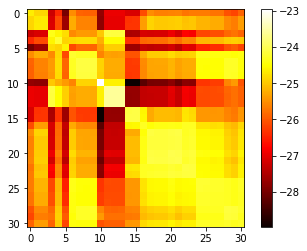

ictal


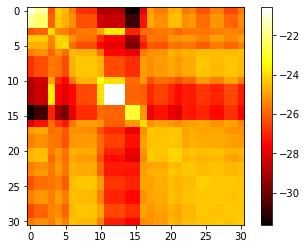

ictal


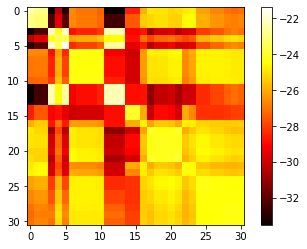

ictal


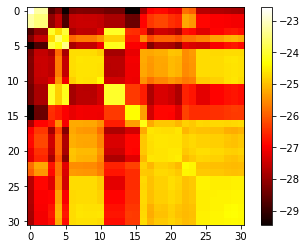

ictal


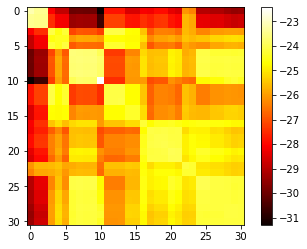

ictal


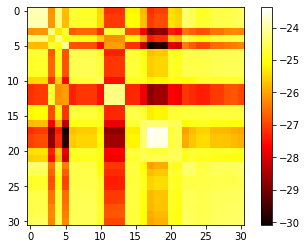

ictal


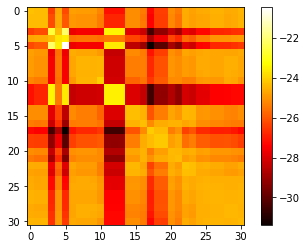

ictal


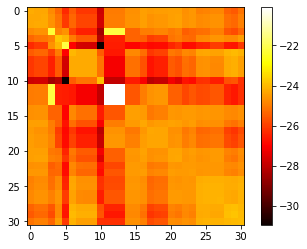

ictal


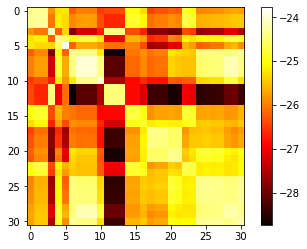

ictal


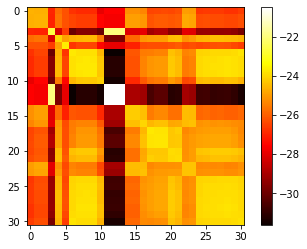

ictal


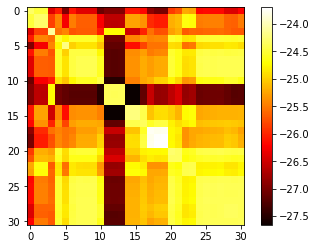

ictal


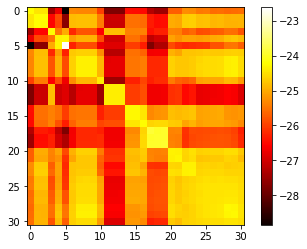

ictal


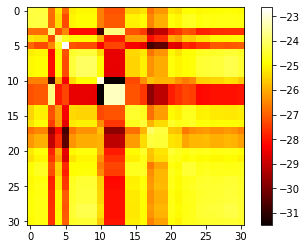

ictal


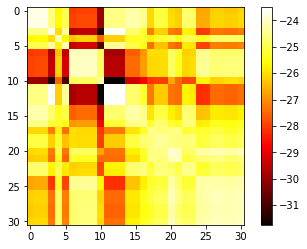

ictal


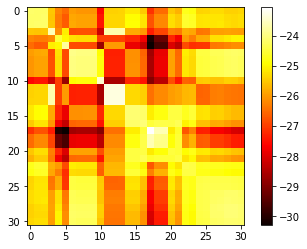

ictal


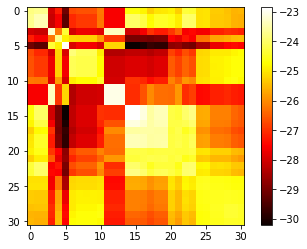

ictal


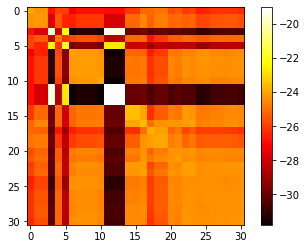

ictal


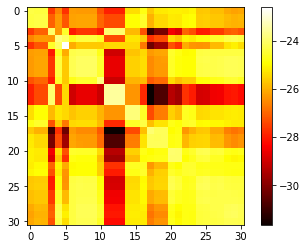

ictal


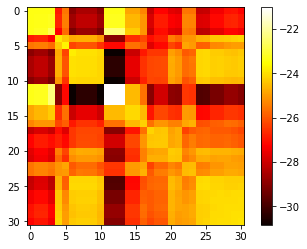

ictal


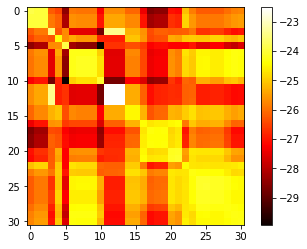

ictal


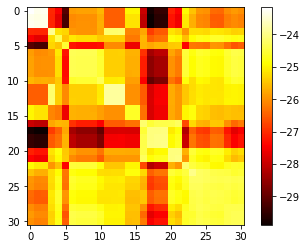

ictal


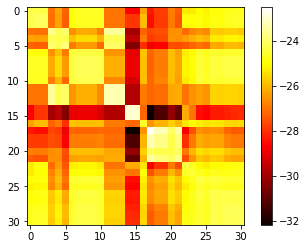

ictal


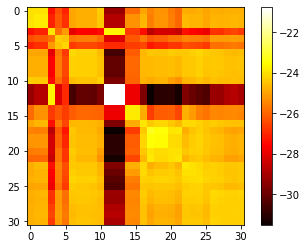

ictal


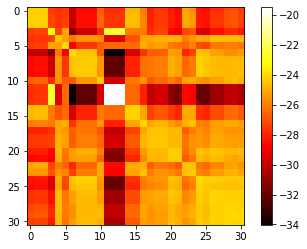

ictal


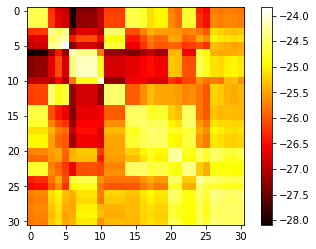

ictal


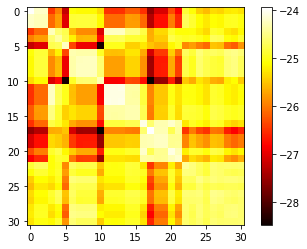

ictal


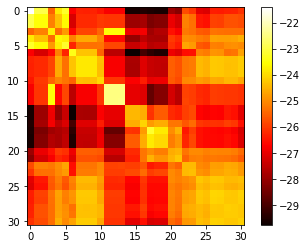

ictal


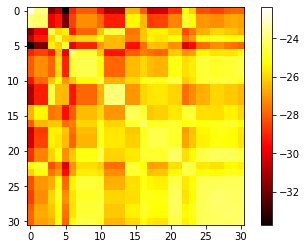

ictal


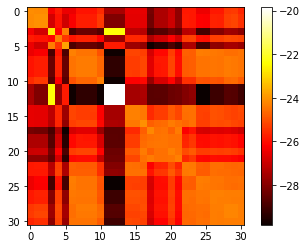

ictal


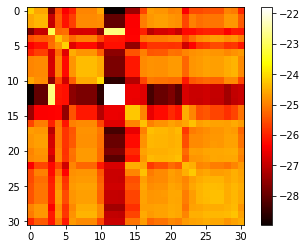

ictal


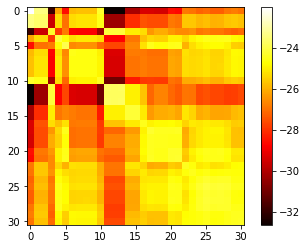

ictal


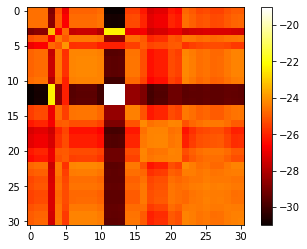

ictal


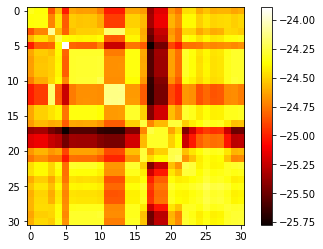

ictal


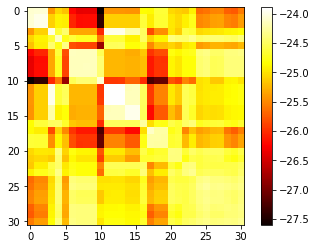

ictal


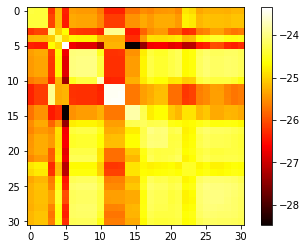

ictal


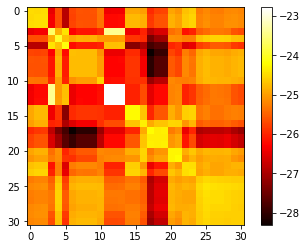

ictal


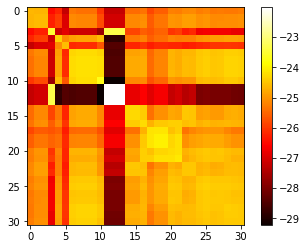

ictal


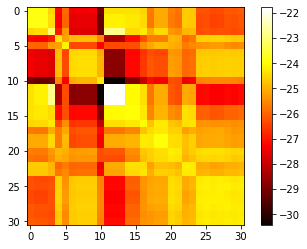

ictal


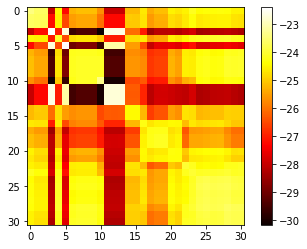

ictal


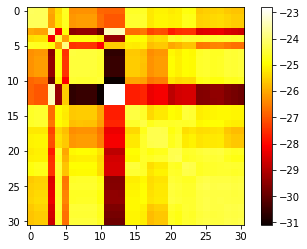

ictal


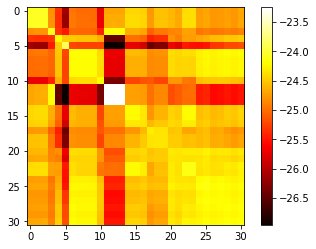

ictal


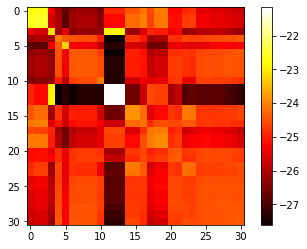

ictal


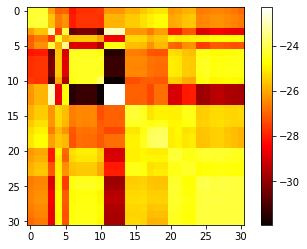

In [21]:

tc = 0

for i in range(sim_train.shape[0]):
    if dm.Y_train[i,0] == 1:
        print("ictal")
        show_heat_map(sim_train[i,:,:])
    else:
        pass
        #print("normal")
        #show_heat_map(sim_train[i,:,:])

average ictal


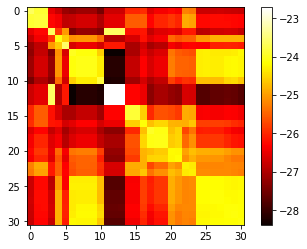

average normal


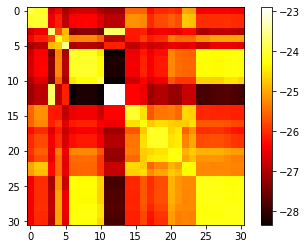

In [15]:
ictal_sum = np.zeros(sim_train[0][0,:,:].shape)
normal_sum = np.zeros(sim_train[0][0,:,:].shape)
tc = 0
ni = 0
nn = 0
for sm in sim_train:
    for i in range(sm.shape[0]):
        if dm.Y_train[tc,0] == 1:
            ictal_sum = ictal_sum + sm[i,:,:]
            ni+=1
        else:
            normal_sum = normal_sum + sm[i,:,:]
            nn+=1
        tc+=1
ictal_sum = ictal_sum / ni
normal_sum = normal_sum / nn
print("average ictal")
show_heat_map(ictal_sum)
print("average normal")
show_heat_map(normal_sum)

## Multilayer Perceptron Network

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [37]:
class MLP(nn.Module):
    def __init__(self, matrix_dim):
        super(MLP, self).__init__()
        feature_len = torch.triu_indices(matrix_dim, matrix_dim).shape[1]
        self.layers = nn.Sequential(
            nn.Linear(feature_len, feature_len//20),
            nn.ReLU(),
            nn.Linear(feature_len//20, 1),
            nn.Sigmoid()
        )
        
    def flatten(self, sim_matrices):
        tri_indices = torch.triu_indices(sim_matrices.shape[1], sim_matrices.shape[2])
        return sim_matrices[:,tri_indices[0,:],tri_indices[1,:]]
        
    def forward(self, sim_matrices):
        x = self.flatten(sim_matrices)
        for layer in self.layers:
            x = layer(x)
        return x

In [75]:
def accuracy(X, Y, threshold = 0.5):
    X = (X>=threshold)
    num = torch.sum(X==Y)
    return num/Y.shape[0]

def F1(y_pred, y_true, threshold = 0.5):
    #y_pred = (y_pred>=threshold).to(torch.float32)
    tp = (y_true * y_pred).sum().to(torch.float32)
    tn = ((1 - y_true) * (1 - y_pred)).sum().to(torch.float32)
    fp = ((1 - y_true) * y_pred).sum().to(torch.float32)
    fn = (y_true * (1 - y_pred)).sum().to(torch.float32)
    
    epsilon = 1e-7
    
    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)
    
    f1 = 2* (precision*recall) / (precision + recall + epsilon)
    return f1

In [61]:

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
parameters = {
    'batch_size': 128,
    'num_epochs': 2000,
    'learning_rate': 1e-3,
    'weight_decay': 5e-3
}
print(parameters)

MLPmodel = MLP(sim_train.shape[1]).to(device)
X_train = torch.from_numpy(sim_train).float().to(device)
X_test = torch.from_numpy(sim_test).float().to(device)
Y_train = torch.from_numpy(dm.Y_train).float().to(device)
Y_test = torch.from_numpy(dm.Y_test).float().to(device)

optimizer = torch.optim.Adam(MLPmodel.parameters(), lr=parameters['learning_rate'], weight_decay=parameters['weight_decay'])
criterion = nn.BCELoss()



{'batch_size': 128, 'num_epochs': 2000, 'learning_rate': 0.001, 'weight_decay': 0.005}


In [62]:


from torchsummary import summary
print(MLPmodel)
summary(MLPmodel, (31,31))

MLP(
  (layers): Sequential(
    (0): Linear(in_features=496, out_features=24, bias=True)
    (1): ReLU()
    (2): Linear(in_features=24, out_features=1, bias=True)
    (3): Sigmoid()
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 24]          11,928
              ReLU-2                   [-1, 24]               0
            Linear-3                    [-1, 1]              25
           Sigmoid-4                    [-1, 1]               0
Total params: 11,953
Trainable params: 11,953
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.05
Estimated Total Size (MB): 0.05
----------------------------------------------------------------


In [76]:
n_epochs = parameters['num_epochs']
batch_size = parameters['batch_size']
from tqdm import tqdm
for epoch in range(1, n_epochs+1):

    # X is a torch Variable
    permutation = torch.randperm(input_features.shape[0])

    for i in tqdm(range(0,input_features.shape[0], batch_size)):
        optimizer.zero_grad()
        
        
        indices = permutation[i:i+batch_size] if i+batch_size < input_features.shape[0] else permutation[i:] 
        batch_x_train= X_train[indices, :,:]
        batch_y_train= Y_train[indices,:]
        batch_x_test= X_test[indices, :,:]
        batch_y_test= Y_test[indices,:]
        
        MLPmodel.train()
        train_pred = MLPmodel(batch_x_train)
        train_loss = criterion(train_pred, batch_y_train)
        train_loss.backward()
        optimizer.step()
        train_acc=F1(train_pred, batch_y_train)
        
        MLPmodel.eval()
        val_pred = MLPmodel(batch_x_test)
        val_loss = criterion(val_pred, batch_y_test)
        val_acc = F1(val_pred, batch_y_test)
        
        print("Epoch:", epoch, "  Batch:", int((i/batch_size)+1),"of size", float(batch_size), "  Train loss:", float(train_loss),"  Train accuracy:", float(train_acc),"  Val loss:", float(val_loss),"  Val accuracy:", float(val_acc),  end="\r")
    print()

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1   Batch: 11 of size 128.0   Train loss: 0.25094547867774963   Train accuracy: 0.1463821679353714   Val loss: 0.4259607791900635   Val accuracy: 0.16846777498722076
Epoch: 2   Batch: 11 of size 128.0   Train loss: 0.29591819643974304   Train accuracy: 0.17363007366657257   Val loss: 0.45232725143432617   Val accuracy: 0.17154544591903687
Epoch: 3   Batch: 11 of size 128.0   Train loss: 0.2880038022994995   Train accuracy: 0.18474562466144562   Val loss: 0.5617924332618713   Val accuracy: 0.16602081060409546
Epoch: 4   Batch: 11 of size 128.0   Train loss: 0.2993578016757965   Train accuracy: 0.1468355357646942   Val loss: 0.51998370885849   Val accuracy: 0.12433729320764542
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 5   Batch: 11 of size 128.0   Train loss: 0.13517946004867554   Train accuracy: 0.1258874386548996   Val loss: 0.42764613032341003   Val accuracy: 0.0762164443731308
Epoch: 6   Batch: 11 of size 128.0   Train loss: 0.20875854790210724   Train accuracy: 0.16153772175312042   Val loss: 0.42364078760147095   Val accuracy: 0.10187508165836334
Epoch: 7   Batch: 11 of size 128.0   Train loss: 0.16504129767417908   Train accuracy: 0.13581743836402893   Val loss: 0.4638344347476959   Val accuracy: 0.10996188223361969
Epoch: 8   Batch: 11 of size 128.0   Train loss: 0.1486068069934845   Train accuracy: 0.07489997893571854   Val loss: 0.3036242723464966   Val accuracy: 0.16674239933490753
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 9   Batch: 11 of size 128.0   Train loss: 0.22187957167625427   Train accuracy: 0.13596901297569275   Val loss: 0.3662915825843811   Val accuracy: 0.10281318426132202
Epoch: 10   Batch: 11 of size 128.0   Train loss: 0.17074085772037506   Train accuracy: 0.11058325320482254   Val loss: 0.3932328224182129   Val accuracy: 0.06608960777521133
Epoch: 11   Batch: 11 of size 128.0   Train loss: 0.2720186710357666   Train accuracy: 0.1400482952594757   Val loss: 0.42734095454216003   Val accuracy: 0.17412853240966797
Epoch: 12   Batch: 11 of size 128.0   Train loss: 0.21467824280261993   Train accuracy: 0.13480158150196075   Val loss: 0.4543496370315552   Val accuracy: 0.13136041164398193
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 13   Batch: 11 of size 128.0   Train loss: 0.33650344610214233   Train accuracy: 0.09608227759599686   Val loss: 0.47450700402259827   Val accuracy: 0.0842764601111412
Epoch: 14   Batch: 11 of size 128.0   Train loss: 0.28064393997192383   Train accuracy: 0.06765279918909073   Val loss: 0.4185723066329956   Val accuracy: 0.10168702900409698
Epoch: 15   Batch: 11 of size 128.0   Train loss: 0.19022229313850403   Train accuracy: 0.13948547840118408   Val loss: 0.42255643010139465   Val accuracy: 0.11544391512870789
Epoch: 16   Batch: 11 of size 128.0   Train loss: 0.20386119186878204   Train accuracy: 0.13274963200092316   Val loss: 0.4100099205970764   Val accuracy: 0.19545148313045502
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 17   Batch: 11 of size 128.0   Train loss: 0.27553460001945496   Train accuracy: 0.08468359708786011   Val loss: 0.5637659430503845   Val accuracy: 0.05350630730390549
Epoch: 18   Batch: 11 of size 128.0   Train loss: 0.1513454020023346   Train accuracy: 0.0824698954820633   Val loss: 0.4145146310329437   Val accuracy: 0.07714460045099258
Epoch: 19   Batch: 11 of size 128.0   Train loss: 0.2809111177921295   Train accuracy: 0.22125555574893951   Val loss: 0.39209088683128357   Val accuracy: 0.1505899727344513
Epoch: 20   Batch: 11 of size 128.0   Train loss: 0.2781200408935547   Train accuracy: 0.13441963493824005   Val loss: 0.5560506582260132   Val accuracy: 0.14700862765312195
Epoch: 21   Batch: 7 of size 128.0   Train loss: 0.2947678565979004   Train accuracy: 0.18563960492610931   Val loss: 0.3742638826370239   Val accuracy:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 21   Batch: 11 of size 128.0   Train loss: 0.21441370248794556   Train accuracy: 0.13858279585838318   Val loss: 0.45329222083091736   Val accuracy: 0.10774416476488113
Epoch: 22   Batch: 11 of size 128.0   Train loss: 0.27459782361984253   Train accuracy: 0.05908535420894623   Val loss: 0.44940894842147827   Val accuracy: 0.1042240783572197
Epoch: 23   Batch: 11 of size 128.0   Train loss: 0.20691655576229095   Train accuracy: 0.07089827954769135   Val loss: 0.3711097538471222   Val accuracy: 0.06670675426721573
Epoch: 24   Batch: 11 of size 128.0   Train loss: 0.22132594883441925   Train accuracy: 0.18840287625789642   Val loss: 0.3278930187225342   Val accuracy: 0.11051048338413239
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 25   Batch: 11 of size 128.0   Train loss: 0.2562366724014282   Train accuracy: 0.10718754678964615   Val loss: 0.3397020995616913   Val accuracy: 0.11391716450452805
Epoch: 26   Batch: 11 of size 128.0   Train loss: 0.1677129566669464   Train accuracy: 0.11931589245796204   Val loss: 0.3221626579761505   Val accuracy: 0.0691991075873375
Epoch: 27   Batch: 11 of size 128.0   Train loss: 0.13340404629707336   Train accuracy: 0.12576821446418762   Val loss: 0.33056262135505676   Val accuracy: 0.05921592190861702
Epoch: 28   Batch: 11 of size 128.0   Train loss: 0.2219841480255127   Train accuracy: 0.14069834351539612   Val loss: 0.33980289101600647   Val accuracy: 0.09261630475521088
Epoch: 29   Batch: 11 of size 128.0   Train loss: 0.22970405220985413   Train accuracy: 0.18077543377876282   Val loss: 0.43932947516441345   Val accuracy: 0.1372266262769699
Epoch: 30   Batch: 3 of size

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 30   Batch: 11 of size 128.0   Train loss: 0.3045831024646759   Train accuracy: 0.20692689716815948   Val loss: 0.5447767376899719   Val accuracy: 0.16010093688964844
Epoch: 31   Batch: 11 of size 128.0   Train loss: 0.2903950810432434   Train accuracy: 0.19780495762825012   Val loss: 0.4739670753479004   Val accuracy: 0.17579159140586853
Epoch: 32   Batch: 11 of size 128.0   Train loss: 0.2554500699043274   Train accuracy: 0.1886720061302185   Val loss: 0.323037326335907   Val accuracy: 0.14341220259666443
Epoch: 33   Batch: 11 of size 128.0   Train loss: 0.27294737100601196   Train accuracy: 0.16370975971221924   Val loss: 0.33391091227531433   Val accuracy: 0.11519744247198105
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 34   Batch: 11 of size 128.0   Train loss: 0.21767859160900116   Train accuracy: 0.200593039393425   Val loss: 0.3276115953922272   Val accuracy: 0.10853536427021027
Epoch: 35   Batch: 11 of size 128.0   Train loss: 0.16403993964195251   Train accuracy: 0.1278872936964035   Val loss: 0.2448565810918808   Val accuracy: 0.15593422949314117
Epoch: 36   Batch: 11 of size 128.0   Train loss: 0.3176076114177704   Train accuracy: 0.080772265791893   Val loss: 0.6433702111244202   Val accuracy: 0.06772325932979584
Epoch: 37   Batch: 11 of size 128.0   Train loss: 0.2148595154285431   Train accuracy: 0.16949297487735748   Val loss: 0.5184879302978516   Val accuracy: 0.13987326622009277
Epoch: 38   Batch: 11 of size 128.0   Train loss: 0.22231349349021912   Train accuracy: 0.13961578905582428   Val loss: 0.4333578050136566   Val accuracy: 0.12185852229595184
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 39   Batch: 11 of size 128.0   Train loss: 0.16882352530956268   Train accuracy: 0.0998498871922493   Val loss: 0.4110541045665741   Val accuracy: 0.13897567987442017
Epoch: 40   Batch: 11 of size 128.0   Train loss: 0.24561648070812225   Train accuracy: 0.16691987216472626   Val loss: 0.38024941086769104   Val accuracy: 0.13834723830223083
Epoch: 41   Batch: 11 of size 128.0   Train loss: 0.2692754566669464   Train accuracy: 0.17905445396900177   Val loss: 0.45450669527053833   Val accuracy: 0.09276411682367325
Epoch: 42   Batch: 11 of size 128.0   Train loss: 0.311596542596817   Train accuracy: 0.19505007565021515   Val loss: 0.5625927448272705   Val accuracy: 0.14990800619125366
Epoch: 43   Batch: 7 of size 128.0   Train loss: 0.24712131917476654   Train accuracy: 0.25494465231895447   Val loss: 0.37718814611434937   Val accuracy: 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 43   Batch: 11 of size 128.0   Train loss: 0.47093212604522705   Train accuracy: 0.047211483120918274   Val loss: 0.5363218784332275   Val accuracy: 0.062093570828437805
Epoch: 44   Batch: 11 of size 128.0   Train loss: 0.33334338665008545   Train accuracy: 0.18283289670944214   Val loss: 0.4590083062648773   Val accuracy: 0.15909545123577118
Epoch: 45   Batch: 11 of size 128.0   Train loss: 0.21742106974124908   Train accuracy: 0.09081858396530151   Val loss: 0.3706500828266144   Val accuracy: 0.09681635349988937
Epoch: 46   Batch: 11 of size 128.0   Train loss: 0.29199767112731934   Train accuracy: 0.2172178477048874   Val loss: 0.44310709834098816   Val accuracy: 0.12952500581741333
Epoch: 47   Batch: 11 of size 128.0   Train loss: 0.16394084692001343   Train accuracy: 0.10066624730825424   Val loss: 0.5298046469688416   Val accuracy: 0.020390773192048073
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 48   Batch: 11 of size 128.0   Train loss: 0.2063083052635193   Train accuracy: 0.14019007980823517   Val loss: 0.4245927333831787   Val accuracy: 0.07252636551856995
Epoch: 49   Batch: 11 of size 128.0   Train loss: 0.3586469292640686   Train accuracy: 0.09478724002838135   Val loss: 0.43768492341041565   Val accuracy: 0.13162600994110107
Epoch: 50   Batch: 11 of size 128.0   Train loss: 0.14716888964176178   Train accuracy: 0.1411883682012558   Val loss: 0.23064114153385162   Val accuracy: 0.15098899602890015
Epoch: 51   Batch: 11 of size 128.0   Train loss: 0.28266674280166626   Train accuracy: 0.12642888724803925   Val loss: 0.42849981784820557   Val accuracy: 0.11523067206144333
Epoch: 52   Batch: 6 of size 128.0   Train loss: 0.3160509169101715 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 52   Batch: 11 of size 128.0   Train loss: 0.1963009387254715   Train accuracy: 0.15952862799167633   Val loss: 0.34674620628356934   Val accuracy: 0.0919727236032486
Epoch: 53   Batch: 11 of size 128.0   Train loss: 0.3501681685447693   Train accuracy: 0.05446719005703926   Val loss: 0.6130377054214478   Val accuracy: 0.032883647829294205
Epoch: 54   Batch: 11 of size 128.0   Train loss: 0.192510724067688   Train accuracy: 0.08562283217906952   Val loss: 0.48406970500946045   Val accuracy: 0.09274625778198242
Epoch: 55   Batch: 11 of size 128.0   Train loss: 0.20487092435359955   Train accuracy: 0.12007729709148407   Val loss: 0.5576971173286438   Val accuracy: 0.06903640180826187
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

 56   Batch: 11 of size 128.0   Train loss: 0.34180450439453125   Train accuracy: 0.21060220897197723   Val loss: 0.4037894010543823   Val accuracy: 0.183796688914299
Epoch: 57   Batch: 11 of size 128.0   Train loss: 0.28459951281547546   Train accuracy: 0.10310017317533493   Val loss: 0.5182642340660095   Val accuracy: 0.12216021120548248
Epoch: 58   Batch: 11 of size 128.0   Train loss: 0.27737292647361755   Train accuracy: 0.09179452806711197   Val loss: 0.5435947179794312   Val accuracy: 0.09969111531972885
Epoch: 59   Batch: 11 of size 128.0   Train loss: 0.17115825414657593   Train accuracy: 0.09173692762851715   Val loss: 0.3798152804374695   Val accuracy: 0.17947441339492798
Epoch: 60   Batch: 11 of size 128.0   Train loss: 0.25634926557540894   Train accuracy: 0.11855942010879517   Val loss: 0.4400470554828644   Val accuracy: 0.07608898729085922
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 61   Batch: 11 of size 128.0   Train loss: 0.3960396349430084   Train accuracy: 0.11317338794469833   Val loss: 0.7442286014556885   Val accuracy: 0.11436640471220016
Epoch: 62   Batch: 11 of size 128.0   Train loss: 0.34209197759628296   Train accuracy: 0.11963224411010742   Val loss: 0.47596773505210876   Val accuracy: 0.12558162212371826
Epoch: 63   Batch: 11 of size 128.0   Train loss: 0.21621257066726685   Train accuracy: 0.13500544428825378   Val loss: 0.4096424877643585   Val accuracy: 0.15092484652996063
Epoch: 64   Batch: 11 of size 128.0   Train loss: 0.2440491020679474   Train accuracy: 0.1879105418920517   Val loss: 0.3625558018684387   Val accuracy: 0.10746298730373383
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

 65   Batch: 11 of size 128.0   Train loss: 0.14870776236057281   Train accuracy: 0.07892078906297684   Val loss: 0.44533026218414307   Val accuracy: 0.10448905825614929
Epoch: 66   Batch: 11 of size 128.0   Train loss: 0.18325693905353546   Train accuracy: 0.14723551273345947   Val loss: 0.4525887966156006   Val accuracy: 0.1023956686258316
Epoch: 67   Batch: 11 of size 128.0   Train loss: 0.2739744186401367   Train accuracy: 0.11474441736936569   Val loss: 0.295075923204422   Val accuracy: 0.10815160721540451
Epoch: 68   Batch: 11 of size 128.0   Train loss: 0.25653573870658875   Train accuracy: 0.12853872776031494   Val loss: 0.37043827772140503   Val accuracy: 0.14668264985084534
Epoch: 69   Batch: 11 of size 128.0   Train loss: 0.24192702770233154   Train accuracy: 0.11140694469213486   Val loss: 0.3970586955547333   Val accuracy: 0.1304551213979721
Epoch: 70   Batch: 4 of size

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 70   Batch: 11 of size 128.0   Train loss: 0.29694482684135437   Train accuracy: 0.10161636024713516   Val loss: 0.4863100051879883   Val accuracy: 0.13413619995117188
Epoch: 71   Batch: 11 of size 128.0   Train loss: 0.18783921003341675   Train accuracy: 0.06944088637828827   Val loss: 0.33512064814567566   Val accuracy: 0.12673039734363556
Epoch: 72   Batch: 11 of size 128.0   Train loss: 0.19657735526561737   Train accuracy: 0.09226728230714798   Val loss: 0.5187724232673645   Val accuracy: 0.09703296422958374
Epoch: 73   Batch: 11 of size 128.0   Train loss: 0.27044543623924255   Train accuracy: 0.11183904111385345   Val loss: 0.3932969272136688   Val accuracy: 0.1051255539059639
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 74   Batch: 11 of size 128.0   Train loss: 0.281344473361969   Train accuracy: 0.21461361646652222   Val loss: 0.38092681765556335   Val accuracy: 0.20888321101665497
Epoch: 75   Batch: 11 of size 128.0   Train loss: 0.324453204870224   Train accuracy: 0.1564028263092041   Val loss: 0.4492760896682739   Val accuracy: 0.17866167426109314
Epoch: 76   Batch: 11 of size 128.0   Train loss: 0.28023862838745117   Train accuracy: 0.15687799453735352   Val loss: 0.4256250858306885   Val accuracy: 0.16405116021633148
Epoch: 77   Batch: 11 of size 128.0   Train loss: 0.2244604229927063   Train accuracy: 0.1449304074048996   Val loss: 0.5456946492195129   Val accuracy: 0.1153237521648407
Epoch: 78   Batch: 11 of size 128.0   Train loss: 0.2284492552280426   Train accuracy: 0.15340371429920197   Val loss: 0.4165377914905548   Val accuracy: 0.16275347769260406
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 79   Batch: 11 of size 128.0   Train loss: 0.24173714220523834   Train accuracy: 0.112281434237957   Val loss: 0.396256685256958   Val accuracy: 0.1538449227809906
Epoch: 80   Batch: 11 of size 128.0   Train loss: 0.21941769123077393   Train accuracy: 0.18281874060630798   Val loss: 0.49637168645858765   Val accuracy: 0.09665055572986603
Epoch: 81   Batch: 11 of size 128.0   Train loss: 0.32225337624549866   Train accuracy: 0.08559239655733109   Val loss: 0.4535861611366272   Val accuracy: 0.08692937344312668
Epoch: 82   Batch: 11 of size 128.0   Train loss: 0.2736811637878418   Train accuracy: 0.1607474684715271   Val loss: 0.33472713828086853   Val accuracy: 0.18305513262748718
Epoch: 83

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 83   Batch: 11 of size 128.0   Train loss: 0.1658390760421753   Train accuracy: 0.1407633274793625   Val loss: 0.43598732352256775   Val accuracy: 0.0810903012752533
Epoch: 84   Batch: 11 of size 128.0   Train loss: 0.23102976381778717   Train accuracy: 0.16875362396240234   Val loss: 0.40134891867637634   Val accuracy: 0.09819583594799042
Epoch: 85   Batch: 11 of size 128.0   Train loss: 0.2791072428226471   Train accuracy: 0.1260012686252594   Val loss: 0.44001227617263794   Val accuracy: 0.13223421573638916
Epoch: 86   Batch: 11 of size 128.0   Train loss: 0.2532474994659424   Train accuracy: 0.17595690488815308   Val loss: 0.3582180440425873   Val accuracy: 0.13966156542301178
Epoch: 87   Batch: 11 of size 128.0   Train loss: 0.1903553158044815   Train accuracy: 0.17001467943191528   Val loss: 0.3302447199821472   Val accuracy: 0.06267953664064407
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 88   Batch: 11 of size 128.0   Train loss: 0.23229780793190002   Train accuracy: 0.11810045689344406   Val loss: 0.40289297699928284   Val accuracy: 0.08998683840036392
Epoch: 89   Batch: 11 of size 128.0   Train loss: 0.22881264984607697   Train accuracy: 0.15013492107391357   Val loss: 0.3667733669281006   Val accuracy: 0.05032690614461899
Epoch: 90   Batch: 11 of size 128.0   Train loss: 0.2805798351764679   Train accuracy: 0.14821964502334595   Val loss: 0.4672657251358032   Val accuracy: 0.1401369273662567
Epoch: 91   Batch: 11 of size 128.0   Train loss: 0.19781607389450073   Train accuracy: 0.2100754678249359   Val loss: 0.4199530780315399   Val accuracy: 0.09817829728126526
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 92   Batch: 11 of size 128.0   Train loss: 0.33086004853248596   Train accuracy: 0.21192404627799988   Val loss: 0.5219613313674927   Val accuracy: 0.13831272721290588
Epoch: 93   Batch: 11 of size 128.0   Train loss: 0.20427335798740387   Train accuracy: 0.0767526924610138   Val loss: 0.446094274520874   Val accuracy: 0.09845244139432907
Epoch: 94   Batch: 11 of size 128.0   Train loss: 0.24998167157173157   Train accuracy: 0.05009286478161812   Val loss: 0.5162897109985352   Val accuracy: 0.051277510821819305
Epoch: 95   Batch: 11 of size 128.0   Train loss: 0.23131811618804932   Train accuracy: 0.12795716524124146   Val loss: 0.554752767086029   Val accuracy: 0.14093539118766785
Epoch: 96 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 96   Batch: 11 of size 128.0   Train loss: 0.2815625071525574   Train accuracy: 0.15107911825180054   Val loss: 0.4596095085144043   Val accuracy: 0.23508615791797638
Epoch: 97   Batch: 11 of size 128.0   Train loss: 0.24674980342388153   Train accuracy: 0.2131703794002533   Val loss: 0.45235148072242737   Val accuracy: 0.18606704473495483
Epoch: 98   Batch: 11 of size 128.0   Train loss: 0.34144675731658936   Train accuracy: 0.14835798740386963   Val loss: 0.5139843225479126   Val accuracy: 0.13253505527973175
Epoch: 99   Batch: 11 of size 128.0   Train loss: 0.32311558723449707   Train accuracy: 0.1121501624584198   Val loss: 0.5371540188789368   Val accuracy: 0.10387091338634491
Epoch: 100   Batch: 11 of size 128.0   Train loss: 0.21496516466140747   Train accuracy: 0.12696342170238495   Val loss: 0.41459891200065613   Val accuracy: 0.10532517731189728
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 101   Batch: 11 of size 128.0   Train loss: 0.13945764303207397   Train accuracy: 0.041096098721027374   Val loss: 0.37068694829940796   Val accuracy: 0.11429666727781296
Epoch: 102   Batch: 11 of size 128.0   Train loss: 0.3111729025840759   Train accuracy: 0.09543715417385101   Val loss: 0.4213813841342926   Val accuracy: 0.124895840883255
Epoch: 103   Batch: 11 of size 128.0   Train loss: 0.22442656755447388   Train accuracy: 0.18304426968097687   Val loss: 0.4279130697250366   Val accuracy: 0.12446333467960358
Epoch: 104   Batch: 11 of size 128.0   Train loss: 0.2538793981075287   Train accuracy: 0.16395825147628784   Val loss: 0.5035947561264038   Val accuracy: 0.12175828963518143
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 105   Batch: 11 of size 128.0   Train loss: 0.20896390080451965   Train accuracy: 0.1490515023469925   Val loss: 0.42452532052993774   Val accuracy: 0.18523439764976501
Epoch: 106   Batch: 11 of size 128.0   Train loss: 0.19148822128772736   Train accuracy: 0.20637233555316925   Val loss: 0.4349636733531952   Val accuracy: 0.11799720674753189
Epoch: 107   Batch: 11 of size 128.0   Train loss: 0.35216933488845825   Train accuracy: 0.18217889964580536   Val loss: 0.4801233410835266   Val accuracy: 0.15397845208644867
Epoch: 108   Batch: 11 of size 128.0   Train loss: 0.319943368434906   Train accuracy: 0.15120333433151245   Val loss: 0.6311600804328918   Val accuracy: 0.07908327132463455
Epoch: 109   Batch: 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 109   Batch: 11 of size 128.0   Train loss: 0.26217636466026306   Train accuracy: 0.08098610490560532   Val loss: 0.3895359933376312   Val accuracy: 0.16052013635635376
Epoch: 110   Batch: 11 of size 128.0   Train loss: 0.19047333300113678   Train accuracy: 0.1508220136165619   Val loss: 0.34514474868774414   Val accuracy: 0.13168646395206451
Epoch: 111   Batch: 11 of size 128.0   Train loss: 0.09969190508127213   Train accuracy: 0.07007457315921783   Val loss: 0.30288439989089966   Val accuracy: 0.05858578160405159
Epoch: 112   Batch: 11 of size 128.0   Train loss: 0.18263302743434906   Train accuracy: 0.13423702120780945   Val loss: 0.507285475730896   Val accuracy: 0.11880942434072495
Epoch: 113   Batch: 11 of size 128.0   Train loss: 0.25829681754112244   Train accuracy: 0.0961538627743721   Val loss: 0.49315425753593445   Val accuracy: 0.114124596118927
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 114   Batch: 11 of size 128.0   Train loss: 0.24027539789676666   Train accuracy: 0.1597173511981964   Val loss: 0.42798691987991333   Val accuracy: 0.12701526284217834
Epoch: 115   Batch: 11 of size 128.0   Train loss: 0.23650458455085754   Train accuracy: 0.16601626574993134   Val loss: 0.41175371408462524   Val accuracy: 0.14600084722042084
Epoch: 116   Batch: 11 of size 128.0   Train loss: 0.16176053881645203   Train accuracy: 0.1509232521057129   Val loss: 0.33571159839630127   Val accuracy: 0.12498603016138077
Epoch: 117   Batch: 11 of size 128.0   Train loss: 0.22218985855579376   Train accuracy: 0.21053972840309143   Val loss: 0.35055577754974365   Val accuracy: 0.13898293673992157
Epoch: 118   Batch: 6 of size 128.0   Train loss: 0.24000351130962372   Train accuracy: 0.11950962990522385

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 118   Batch: 11 of size 128.0   Train loss: 0.3527302145957947   Train accuracy: 0.08122360706329346   Val loss: 0.4240720272064209   Val accuracy: 0.10362944006919861
Epoch: 119   Batch: 11 of size 128.0   Train loss: 0.2551920711994171   Train accuracy: 0.22731046378612518   Val loss: 0.401068776845932   Val accuracy: 0.14300476014614105
Epoch: 120   Batch: 11 of size 128.0   Train loss: 0.22573494911193848   Train accuracy: 0.0961199402809143   Val loss: 0.40274474024772644   Val accuracy: 0.13213451206684113
Epoch: 121   Batch: 11 of size 128.0   Train loss: 0.27238792181015015   Train accuracy: 0.1294661909341812   Val loss: 0.5195981860160828   Val accuracy: 0.055972274392843246
Epoch: 122   Batch: 11 of size 128.0 

  0%|          | 0/11 [00:00<?, ?it/s]

  Train loss: 0.3077116310596466   Train accuracy: 0.2048652470111847   Val loss: 0.3956488370895386   Val accuracy: 0.06295257061719894
Epoch: 123   Batch: 11 of size 128.0   Train loss: 0.22570137679576874   Train accuracy: 0.09850223362445831   Val loss: 0.431673139333725   Val accuracy: 0.15041889250278473
Epoch: 124   Batch: 11 of size 128.0   Train loss: 0.24263446033000946   Train accuracy: 0.13143527507781982   Val loss: 0.46139392256736755   Val accuracy: 0.09862114489078522
Epoch: 125   Batch: 11 of size 128.0   Train loss: 0.3508811295032501   Train accuracy: 0.08734461665153503   Val loss: 0.5289416909217834   Val accuracy: 0.09996485710144043
Epoch: 126   Batch: 11 of size 128.0   Train loss: 0.2385941743850708   Train accuracy: 0.06579532474279404   Val loss: 0.5116101503372192   Val accuracy: 0.035811588168144226


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 127   Batch: 11 of size 128.0   Train loss: 0.2521772086620331   Train accuracy: 0.1311083883047104   Val loss: 0.4410383105278015   Val accuracy: 0.08955994248390198
Epoch: 128   Batch: 11 of size 128.0   Train loss: 0.2526436448097229   Train accuracy: 0.10606180131435394   Val loss: 0.5269518494606018   Val accuracy: 0.11421087384223938
Epoch: 129   Batch: 11 of size 128.0   Train loss: 0.2566704750061035   Train accuracy: 0.0988399013876915   Val loss: 0.3364581763744354   Val accuracy: 0.13725417852401733
Epoch: 130   Batch: 11 of size 128.0   Train loss: 0.31051555275917053   Train accuracy: 0.21852533519268036   Val loss: 0.4637993574142456   Val accuracy: 0.21347054839134216
Epoch: 131   Batch: 10 of size 128.0   Train loss: 0.3253856599330902   Train accuracy: 0.09617882966995239   Val loss: 0.36123618483543396

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 131   Batch: 11 of size 128.0   Train loss: 0.2836596965789795   Train accuracy: 0.12375157326459885   Val loss: 0.4035438001155853   Val accuracy: 0.20411163568496704
Epoch: 132   Batch: 11 of size 128.0   Train loss: 0.22660638391971588   Train accuracy: 0.2018638700246811   Val loss: 0.3311217427253723   Val accuracy: 0.1607428342103958
Epoch: 133   Batch: 11 of size 128.0   Train loss: 0.3081534802913666   Train accuracy: 0.14145953953266144   Val loss: 0.49519413709640503   Val accuracy: 0.13135124742984772
Epoch: 134   Batch: 11 of size 128.0   Train loss: 0.24876822531223297   Train accuracy: 0.08291620761156082   Val loss: 0.3823242485523224   Val accuracy: 0.0900702252984047
Epoch: 135   Batch: 11 of size 128.0   Train loss: 0.29142388701438904   Train accuracy: 0.0793977752327919   Val loss: 0.3669205904006958   Val accuracy: 0.14186270534992218
Epoch: 136   Batch: 3 of size 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 136   Batch: 11 of size 128.0   Train loss: 0.34501510858535767   Train accuracy: 0.13872040808200836   Val loss: 0.45137208700180054   Val accuracy: 0.13714295625686646
Epoch: 137   Batch: 11 of size 128.0   Train loss: 0.22772875428199768   Train accuracy: 0.07734987884759903   Val loss: 0.32188063859939575   Val accuracy: 0.10736493766307831
Epoch: 138   Batch: 11 of size 128.0   Train loss: 0.32378390431404114   Train accuracy: 0.10111787915229797   Val loss: 0.40833067893981934   Val accuracy: 0.16886481642723083
Epoch: 139   Batch: 11 of size 128.0   Train loss: 0.34630584716796875   Train accuracy: 0.19264544546604156   Val loss: 0.4560854732990265   Val accuracy: 0.16946053504943848
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 140   Batch: 11 of size 128.0   Train loss: 0.33235058188438416   Train accuracy: 0.2547900378704071   Val loss: 0.46318456530570984   Val accuracy: 0.2201940417289734
Epoch: 141   Batch: 11 of size 128.0   Train loss: 0.18391577899456024   Train accuracy: 0.0768875703215599   Val loss: 0.4590012729167938   Val accuracy: 0.09532544016838074
Epoch: 142   Batch: 11 of size 128.0   Train loss: 0.2875514030456543   Train accuracy: 0.16264274716377258   Val loss: 0.43107253313064575   Val accuracy: 0.16389046609401703
Epoch: 143   Batch: 11 of size 128.0   Train loss: 0.18792420625686646   Train accuracy: 0.09507419914007187   Val loss: 0.43230584263801575   Val accuracy: 0.12426034361124039
Epoch: 144   Batch: 11 of size 128.0   Train loss: 0.30303922295570374   Train accuracy: 0.21977272629737854   Val loss: 0.5034081339836121   Val accuracy: 0.10633932054042816
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 145   Batch: 11 of size 128.0   Train loss: 0.26319023966789246   Train accuracy: 0.07721969485282898   Val loss: 0.4777436852455139   Val accuracy: 0.08037977665662766
Epoch: 146   Batch: 11 of size 128.0   Train loss: 0.26665228605270386   Train accuracy: 0.15976932644844055   Val loss: 0.40026742219924927   Val accuracy: 0.15025119483470917
Epoch: 147   Batch: 11 of size 128.0   Train loss: 0.2217530906200409   Train accuracy: 0.15349313616752625   Val loss: 0.5267709493637085   Val accuracy: 0.1491117775440216
Epoch: 148   Batch: 11 of size 128.0   Train loss: 0.14801828563213348   Train accuracy: 0.1688079535961151   Val loss: 0.404318243265152   Val accuracy: 0.08891329169273376
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 149   Batch: 11 of size 128.0   Train loss: 0.2618902027606964   Train accuracy: 0.14732950925827026   Val loss: 0.43196097016334534   Val accuracy: 0.16058455407619476
Epoch: 150   Batch: 11 of size 128.0   Train loss: 0.2777476906776428   Train accuracy: 0.18432827293872833   Val loss: 0.49802660942077637   Val accuracy: 0.10015767067670822
Epoch: 151   Batch: 11 of size 128.0   Train loss: 0.22622738778591156   Train accuracy: 0.1065995842218399   Val loss: 0.5225538015365601   Val accuracy: 0.0643816739320755
Epoch: 152   Batch: 11 of size 128.0   Train loss: 0.23181074857711792   Train accuracy: 0.11470197141170502   Val loss: 0.46031510829925537   Val accuracy: 0.16140195727348328
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

 153   Batch: 11 of size 128.0   Train loss: 0.1789846569299698   Train accuracy: 0.17527954280376434   Val loss: 0.36628833413124084   Val accuracy: 0.1647992730140686
Epoch: 154   Batch: 11 of size 128.0   Train loss: 0.2646878659725189   Train accuracy: 0.08383739739656448   Val loss: 0.5214329361915588   Val accuracy: 0.09113577008247375
Epoch: 155   Batch: 11 of size 128.0   Train loss: 0.3212611973285675   Train accuracy: 0.20688501000404358   Val loss: 0.46262359619140625   Val accuracy: 0.14489904046058655
Epoch: 156   Batch: 11 of size 128.0   Train loss: 0.22514958679676056   Train accuracy: 0.1639319509267807   Val loss: 0.35709747672080994   Val accuracy: 0.18718935549259186
Epoch: 157   Batch: 11 of size 128.0   Train loss: 0.2619142234325409   Train accuracy: 0.22705736756324768   Val loss: 0.4544365406036377   Val accuracy: 0.18463273346424103
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 158   Batch: 11 of size 128.0   Train loss: 0.22866424918174744   Train accuracy: 0.11704989522695541   Val loss: 0.5387527942657471   Val accuracy: 0.10452570021152496
Epoch: 159   Batch: 11 of size 128.0   Train loss: 0.2672180235385895   Train accuracy: 0.11542865633964539   Val loss: 0.5372268557548523   Val accuracy: 0.09939464181661606
Epoch: 160   Batch: 11 of size 128.0   Train loss: 0.18079623579978943   Train accuracy: 0.1495947688817978   Val loss: 0.36813539266586304   Val accuracy: 0.10347898304462433
Epoch: 161   Batch: 11 of size 128.0   Train loss: 0.2680351138114929   Train accuracy: 0.1524212658405304   Val loss: 0.4867420792579651   Val accuracy: 0.134967640042305
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 162   Batch: 11 of size 128.0   Train loss: 0.35659003257751465   Train accuracy: 0.16906602680683136   Val loss: 0.4449421465396881   Val accuracy: 0.14955446124076843
Epoch: 163   Batch: 11 of size 128.0   Train loss: 0.24981653690338135   Train accuracy: 0.11502103507518768   Val loss: 0.384176641702652   Val accuracy: 0.07074232399463654
Epoch: 164   Batch: 11 of size 128.0   Train loss: 0.3422005772590637   Train accuracy: 0.1914699673652649   Val loss: 0.3972964286804199   Val accuracy: 0.15186557173728943
Epoch: 165   Batch: 11 of size 128.0   Train loss: 0.2283373922109604   Train accuracy: 0.21338561177253723   Val loss: 0.5063920617103577   Val accuracy: 0.1852855235338211
Epoch: 166   Batch: 11 of size 128.0   Train loss: 0.20742419362068176   Train accuracy: 0.08252359926700592   Val loss: 0.4725692570209503   Val accuracy: 0.15845897793769836
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 167   Batch: 11 of size 128.0   Train loss: 0.28426703810691833   Train accuracy: 0.14188042283058167   Val loss: 0.44458284974098206   Val accuracy: 0.1191323846578598
Epoch: 168   Batch: 11 of size 128.0   Train loss: 0.24599994719028473   Train accuracy: 0.18669867515563965   Val loss: 0.4824277460575104   Val accuracy: 0.14358322322368622
Epoch: 169   Batch: 11 of size 128.0   Train loss: 0.16962186992168427   Train accuracy: 0.08670317381620407   Val loss: 0.3685147166252136   Val accuracy: 0.12354929745197296
Epoch: 170   Batch: 11 of size 128.0   Train loss: 0.24745778739452362   Train accuracy: 0.1514672189950943   Val loss: 0.4400593936443329   Val accuracy: 0.07329187542200089
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 171   Batch: 11 of size 128.0   Train loss: 0.18805015087127686   Train accuracy: 0.12387681007385254   Val loss: 0.3316308856010437   Val accuracy: 0.05099562183022499
Epoch: 172   Batch: 11 of size 128.0   Train loss: 0.2630995213985443   Train accuracy: 0.14052969217300415   Val loss: 0.5509091019630432   Val accuracy: 0.07412238419055939
Epoch: 173   Batch: 11 of size 128.0   Train loss: 0.20385967195034027   Train accuracy: 0.08238711208105087   Val loss: 0.31083592772483826   Val accuracy: 0.04267091304063797
Epoch: 174   Batch: 11 of size 128.0   Train loss: 0.20961280167102814   Train accuracy: 0.17666558921337128   Val loss: 0.5365519523620605   Val accuracy: 0.14175905287265778
Epoch: 175

  0%|          | 0/11 [00:00<?, ?it/s]

   Batch: 11 of size 128.0   Train loss: 0.28692084550857544   Train accuracy: 0.13354289531707764   Val loss: 0.39457985758781433   Val accuracy: 0.1329081505537033
Epoch: 176   Batch: 11 of size 128.0   Train loss: 0.26037442684173584   Train accuracy: 0.19035057723522186   Val loss: 0.4110121428966522   Val accuracy: 0.15685972571372986
Epoch: 177   Batch: 11 of size 128.0   Train loss: 0.22708596289157867   Train accuracy: 0.1338619589805603   Val loss: 0.43081292510032654   Val accuracy: 0.11690813302993774
Epoch: 178   Batch: 11 of size 128.0   Train loss: 0.24149268865585327   Train accuracy: 0.12621496617794037   Val loss: 0.33132827281951904   Val accuracy: 0.10574786365032196
Epoch: 179   Batch: 11 of size 128.0   Train loss: 0.3760189116001129   Train accuracy: 0.12216665595769882   Val loss: 0.47424957156181335   Val accuracy: 0.17673908174037933
Epoch: 180   Batch: 3 of size 128.0

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 180   Batch: 11 of size 128.0   Train loss: 0.2562622129917145   Train accuracy: 0.1161022037267685   Val loss: 0.5241097211837769   Val accuracy: 0.15794625878334045
Epoch: 181   Batch: 11 of size 128.0   Train loss: 0.26396217942237854   Train accuracy: 0.18930110335350037   Val loss: 0.4127117395401001   Val accuracy: 0.11375068128108978
Epoch: 182   Batch: 11 of size 128.0   Train loss: 0.27288758754730225   Train accuracy: 0.11877945065498352   Val loss: 0.38916894793510437   Val accuracy: 0.1126757487654686
Epoch: 183   Batch: 11 of size 128.0   Train loss: 0.2448517084121704   Train accuracy: 0.13992884755134583   Val loss: 0.4064790606498718   Val accuracy: 0.11120684444904327
Epoch: 184   Batch: 7 of size 128.0   Train loss: 0.2588859796524048   Train accuracy: 0.17095687985420227

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 184   Batch: 11 of size 128.0   Train loss: 0.15549392998218536   Train accuracy: 0.16464364528656006   Val loss: 0.37402671575546265   Val accuracy: 0.1251523792743683
Epoch: 185   Batch: 11 of size 128.0   Train loss: 0.30366581678390503   Train accuracy: 0.1504763960838318   Val loss: 0.44780752062797546   Val accuracy: 0.15801751613616943
Epoch: 186   Batch: 11 of size 128.0   Train loss: 0.21376892924308777   Train accuracy: 0.12481413781642914   Val loss: 0.3896661698818207   Val accuracy: 0.1269010454416275
Epoch: 187   Batch: 11 of size 128.0   Train loss: 0.22372087836265564   Train accuracy: 0.15854908525943756   Val loss: 0.35894840955734253   Val accuracy: 0.10634560883045197


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 188   Batch: 11 of size 128.0   Train loss: 0.18127000331878662   Train accuracy: 0.17156915366649628   Val loss: 0.3513532280921936   Val accuracy: 0.1068747267127037
Epoch: 189   Batch: 11 of size 128.0   Train loss: 0.33357203006744385   Train accuracy: 0.12699231505393982   Val loss: 0.49600040912628174   Val accuracy: 0.10925618559122086
Epoch: 190   Batch: 11 of size 128.0   Train loss: 0.2889769971370697   Train accuracy: 0.1159006729722023   Val loss: 0.5318968296051025   Val accuracy: 0.11835481971502304
Epoch: 191   Batch: 11 of size 128.0   Train loss: 0.3039323687553406   Train accuracy: 0.17216695845127106   Val loss: 0.4780517816543579   Val accuracy: 0.15650327503681183
Epoch: 192   Batch: 11 of size 128.0   Train loss: 0.2490578144788742   Train accuracy: 0.1414153128862381   Val loss: 0.38588371872901917   Val accuracy: 0.1326366513967514


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 193   Batch: 11 of size 128.0   Train loss: 0.2989276647567749   Train accuracy: 0.1444275677204132   Val loss: 0.3799644410610199   Val accuracy: 0.12124702334403992
Epoch: 194   Batch: 11 of size 128.0   Train loss: 0.21277649700641632   Train accuracy: 0.09753936529159546   Val loss: 0.2725426256656647   Val accuracy: 0.0766301080584526
Epoch: 195   Batch: 11 of size 128.0   Train loss: 0.2813032269477844   Train accuracy: 0.12302621454000473   Val loss: 0.39696672558784485   Val accuracy: 0.13406403362751007
Epoch: 196   Batch: 11 of size 128.0   Train loss: 0.2647906541824341   Train accuracy: 0.12967349588871002   Val loss: 0.373137503862381   Val accuracy: 0.14696022868156433
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 197   Batch: 11 of size 128.0   Train loss: 0.30451545119285583   Train accuracy: 0.213771790266037   Val loss: 0.5131601095199585   Val accuracy: 0.11984696239233017
Epoch: 198   Batch: 11 of size 128.0   Train loss: 0.2168344259262085   Train accuracy: 0.10500168800354004   Val loss: 0.534968912601471   Val accuracy: 0.11716427654027939
Epoch: 199   Batch: 11 of size 128.0   Train loss: 0.35807329416275024   Train accuracy: 0.12494915723800659   Val loss: 0.5325057506561279   Val accuracy: 0.19448235630989075
Epoch: 200   Batch: 11 of size 128.0   Train loss: 0.32671239972114563   Train accuracy: 0.2088097631931305   Val loss: 0.45157715678215027   Val accuracy: 0.1589725911617279
Epoch: 201   Batch: 11 of size 128.0   Train loss:

  0%|          | 0/11 [00:00<?, ?it/s]

 0.33585748076438904   Train accuracy: 0.1854102611541748   Val loss: 0.41485595703125   Val accuracy: 0.20487959682941437
Epoch: 202   Batch: 11 of size 128.0   Train loss: 0.2165011167526245   Train accuracy: 0.15268974006175995   Val loss: 0.44522222876548767   Val accuracy: 0.1431523859500885
Epoch: 203   Batch: 11 of size 128.0   Train loss: 0.16026048362255096   Train accuracy: 0.09028366953134537   Val loss: 0.3039398789405823   Val accuracy: 0.03655247017741203
Epoch: 204   Batch: 11 of size 128.0   Train loss: 0.2845388948917389   Train accuracy: 0.1888607144355774   Val loss: 0.4347686767578125   Val accuracy: 0.07042799890041351
Epoch: 205   Batch: 11 of size 128.0   Train loss: 0.27578482031822205   Train accuracy: 0.1538081020116806   Val loss: 0.3580830991268158   Val accuracy: 0.1308397352695465
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 206   Batch: 11 of size 128.0   Train loss: 0.35638004541397095   Train accuracy: 0.10081543028354645   Val loss: 0.588115930557251   Val accuracy: 0.11270248144865036
Epoch: 207   Batch: 11 of size 128.0   Train loss: 0.20627866685390472   Train accuracy: 0.1575625091791153   Val loss: 0.44107040762901306   Val accuracy: 0.08762694150209427
Epoch: 208   Batch: 11 of size 128.0   Train loss: 0.3044167160987854   Train accuracy: 0.08971846848726273   Val loss: 0.45838209986686707   Val accuracy: 0.08474981039762497
Epoch: 209   Batch: 11 of size 128.0   Train loss: 0.1986914426088333   Train accuracy: 0.2027948796749115   Val loss: 0.306841105222702   Val accuracy: 0.13675235211849213
Epoch:

100%|██████████| 11/11 [00:00<00:00, 262.42it/s]

Epoch: 210   Batch: 11 of size 128.0   Train loss: 0.38144415616989136   Train accuracy: 0.21349474787712097   Val loss: 0.4957014322280884   Val accuracy: 0.1696576178073883
Epoch: 211   Batch: 11 of size 128.0   Train loss: 0.31799623370170593   Train accuracy: 0.1501697599887848   Val loss: 0.40018075704574585   Val accuracy: 0.15752968192100525
Epoch: 212   Batch: 11 of size 128.0   Train loss: 0.21393930912017822   Train accuracy: 0.24452278017997742   Val loss: 0.37830159068107605   Val accuracy: 0.1623670905828476
Epoch: 213   Batch: 11 of size 128.0   Train loss: 0.24753022193908691   Train accuracy: 0.1617470532655716   Val loss: 0.44146281480789185   Val accuracy: 0.13417941331863403
Epoch: 214   Batch: 11 of size 128.0   Train loss: 0.2391890585422516   Train accuracy: 0.2027473896741867   Val loss: 0.49975213408470154   Val accuracy: 0.1339196115732193



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 215   Batch: 11 of size 128.0   Train loss: 0.25116321444511414   Train accuracy: 0.12712259590625763   Val loss: 0.4577677249908447   Val accuracy: 0.16908620297908783
Epoch: 216   Batch: 11 of size 128.0   Train loss: 0.2104346603155136   Train accuracy: 0.11443652957677841   Val loss: 0.29130956530570984   Val accuracy: 0.1718938797712326
Epoch: 217   Batch: 11 of size 128.0   Train loss: 0.24934354424476624   Train accuracy: 0.1131274625658989   Val loss: 0.35818102955818176   Val accuracy: 0.1912817806005478
Epoch: 218   Batch: 11 of size 128.0   Train loss: 0.2904079854488373   Train accuracy: 0.22430704534053802   Val loss: 0.4939384162425995   Val accuracy: 0.13293713331222534
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 219   Batch: 11 of size 128.0   Train loss: 0.32446280121803284   Train accuracy: 0.17378738522529602   Val loss: 0.489183634519577   Val accuracy: 0.1458553969860077
Epoch: 220   Batch: 11 of size 128.0   Train loss: 0.24043305218219757   Train accuracy: 0.13933183252811432   Val loss: 0.6282368302345276   Val accuracy: 0.11802130192518234
Epoch: 221   Batch: 11 of size 128.0   Train loss: 0.3059314787387848   Train accuracy: 0.1245734691619873   Val loss: 0.4056483209133148   Val accuracy: 0.12611138820648193
Epoch: 222   Batch: 11 of size 128.0   Train loss: 0.2454063594341278   Train accuracy: 0.12100659310817719   Val loss: 0.41242966055870056   Val accuracy: 0.15862935781478882
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 223   Batch: 11 of size 128.0   Train loss: 0.291086345911026   Train accuracy: 0.07125363498926163   Val loss: 0.5558849573135376   Val accuracy: 0.09961133450269699
Epoch: 224   Batch: 11 of size 128.0   Train loss: 0.3140890896320343   Train accuracy: 0.10825047641992569   Val loss: 0.4054340422153473   Val accuracy: 0.13694125413894653
Epoch: 225   Batch: 11 of size 128.0   Train loss: 0.24395903944969177   Train accuracy: 0.17545072734355927   Val loss: 0.44269460439682007   Val accuracy: 0.17943885922431946
Epoch: 226   Batch: 11 of size 128.0   Train loss: 0.27808329463005066   Train accuracy: 0.1755691021680832   Val loss: 0.5186446905136108   Val accuracy: 0.19103297591209412
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

 227   Batch: 11 of size 128.0   Train loss: 0.35478082299232483   Train accuracy: 0.15578827261924744   Val loss: 0.6114994883537292   Val accuracy: 0.1073315441608429
Epoch: 228   Batch: 11 of size 128.0   Train loss: 0.20499643683433533   Train accuracy: 0.14641553163528442   Val loss: 0.44477394223213196   Val accuracy: 0.1172945648431778
Epoch: 229   Batch: 11 of size 128.0   Train loss: 0.2802335023880005   Train accuracy: 0.10377708077430725   Val loss: 0.4309595227241516   Val accuracy: 0.0702480897307396
Epoch: 230   Batch: 11 of size 128.0   Train loss: 0.16810904443264008   Train accuracy: 0.11781623959541321   Val loss: 0.5269094705581665   Val accuracy: 0.06119765713810921
Epoch: 231   Batch: 11 of size 128.0   Train loss: 0.18596826493740082   Train accuracy: 0.11701683700084686   Val loss: 0.5949868559837341   Val accuracy: 0.08601238578557968
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 232   Batch: 11 of size 128.0   Train loss: 0.21443253755569458   Train accuracy: 0.1326528936624527   Val loss: 0.32581865787506104   Val accuracy: 0.12594221532344818
Epoch: 233   Batch: 11 of size 128.0   Train loss: 0.21319065988063812   Train accuracy: 0.10372419655323029   Val loss: 0.39510828256607056   Val accuracy: 0.11388067156076431
Epoch: 234   Batch: 11 of size 128.0   Train loss: 0.2588213086128235   Train accuracy: 0.18058356642723083   Val loss: 0.41507890820503235   Val accuracy: 0.15368418395519257
Epoch: 235   Batch: 11 of size 128.0   Train loss: 0.21734283864498138   Train accuracy: 0.19565659761428833   Val loss: 0.33670487999916077   Val accuracy: 0.1774519830942154
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 236   Batch: 11 of size 128.0   Train loss: 0.25134992599487305   Train accuracy: 0.13568592071533203   Val loss: 0.35670506954193115   Val accuracy: 0.13651765882968903
Epoch: 237   Batch: 11 of size 128.0   Train loss: 0.2493247538805008   Train accuracy: 0.1998617947101593   Val loss: 0.4289107024669647   Val accuracy: 0.12250573188066483
Epoch: 238   Batch: 11 of size 128.0   Train loss: 0.28090792894363403   Train accuracy: 0.13370995223522186   Val loss: 0.47645998001098633   Val accuracy: 0.12310457974672318
Epoch: 239   Batch: 11 of size 128.0   Train loss: 0.2927628457546234   Train accuracy: 0.14409461617469788   Val loss: 0.4490940272808075   Val accuracy: 0.125202015042305
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

 240   Batch: 11 of size 128.0   Train loss: 0.27635860443115234   Train accuracy: 0.16364158689975739   Val loss: 0.3273969292640686   Val accuracy: 0.1564103215932846
Epoch: 241   Batch: 11 of size 128.0   Train loss: 0.30034369230270386   Train accuracy: 0.12704147398471832   Val loss: 0.38710469007492065   Val accuracy: 0.10393945127725601
Epoch: 242   Batch: 11 of size 128.0   Train loss: 0.29322123527526855   Train accuracy: 0.17164835333824158   Val loss: 0.6537590026855469   Val accuracy: 0.13113638758659363
Epoch: 243   Batch: 11 of size 128.0   Train loss: 0.2600332498550415   Train accuracy: 0.17920151352882385   Val loss: 0.3471665382385254   Val accuracy: 0.12527012825012207
Epoch: 244   Batch: 11 of size 128.0   Train loss: 0.19364309310913086   Train accuracy: 0.21914884448051453   Val loss: 0.33666136860847473   Val accuracy: 0.09393978863954544
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 245   Batch: 11 of size 128.0   Train loss: 0.24215514957904816   Train accuracy: 0.1135123074054718   Val loss: 0.422030508518219   Val accuracy: 0.20039156079292297
Epoch: 246   Batch: 11 of size 128.0   Train loss: 0.3423707187175751   Train accuracy: 0.05728602781891823   Val loss: 0.5591115355491638   Val accuracy: 0.09595031291246414
Epoch: 247   Batch: 11 of size 128.0   Train loss: 0.4053477346897125   Train accuracy: 0.10987791419029236   Val loss: 0.4754396677017212   Val accuracy: 0.13184235990047455
Epoch: 248   Batch: 11 of size 128.0   Train loss: 0.2449655830860138   Train accuracy: 0.16155323386192322   Val loss: 0.41165101528167725   Val accuracy: 0.17092320322990417
Epoch: 249

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 249   Batch: 11 of size 128.0   Train loss: 0.23066404461860657   Train accuracy: 0.141842320561409   Val loss: 0.5121209025382996   Val accuracy: 0.13184510171413422
Epoch: 250   Batch: 11 of size 128.0   Train loss: 0.3412523865699768   Train accuracy: 0.14962530136108398   Val loss: 0.5342354774475098   Val accuracy: 0.1223878413438797
Epoch: 251   Batch: 11 of size 128.0   Train loss: 0.26911619305610657   Train accuracy: 0.11174200475215912   Val loss: 0.5899788737297058   Val accuracy: 0.06641847640275955
Epoch: 252   Batch: 11 of size 128.0   Train loss: 0.2952232360839844   Train accuracy: 0.1036769300699234   Val loss: 0.4174586832523346   Val accuracy: 0.10908062011003494
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

 253   Batch: 11 of size 128.0   Train loss: 0.2570699155330658   Train accuracy: 0.15233422815799713   Val loss: 0.3929585814476013   Val accuracy: 0.14295469224452972
Epoch: 254   Batch: 11 of size 128.0   Train loss: 0.3048509657382965   Train accuracy: 0.22179247438907623   Val loss: 0.44299817085266113   Val accuracy: 0.23818719387054443
Epoch: 255   Batch: 11 of size 128.0   Train loss: 0.2842775583267212   Train accuracy: 0.20766787230968475   Val loss: 0.4537414014339447   Val accuracy: 0.18739892542362213
Epoch: 256   Batch: 11 of size 128.0   Train loss: 0.3120313882827759   Train accuracy: 0.1869049370288849   Val loss: 0.5061513185501099   Val accuracy: 0.11186546832323074
Epoch: 257   Batch: 11 of size 128.0   Train loss: 0.2121867835521698   Train accuracy: 0.16170863807201385   Val loss: 0.31422650814056396   Val accuracy: 0.16189318895339966
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 258   Batch: 11 of size 128.0   Train loss: 0.23509147763252258   Train accuracy: 0.18343308568000793   Val loss: 0.38005828857421875   Val accuracy: 0.1296030730009079
Epoch: 259   Batch: 11 of size 128.0   Train loss: 0.2607952058315277   Train accuracy: 0.15696194767951965   Val loss: 0.4154730439186096   Val accuracy: 0.14155429601669312
Epoch: 260   Batch: 11 of size 128.0   Train loss: 0.23185160756111145   Train accuracy: 0.19582030177116394   Val loss: 0.3484508991241455   Val accuracy: 0.14153949916362762
Epoch: 261   Batch: 11 of size 128.0   Train loss: 0.20406077802181244   Train accuracy: 0.0894387736916542   Val loss: 0.37036988139152527   Val accuracy: 0.04614688456058502
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 262   Batch: 11 of size 128.0   Train loss: 0.20649166405200958   Train accuracy: 0.07801910489797592   Val loss: 0.32709985971450806   Val accuracy: 0.085232213139534
Epoch: 263   Batch: 11 of size 128.0   Train loss: 0.30272844433784485   Train accuracy: 0.1090138629078865   Val loss: 0.43708929419517517   Val accuracy: 0.08694136142730713
Epoch: 264   Batch: 11 of size 128.0   Train loss: 0.17299585044384003   Train accuracy: 0.17580635845661163   Val loss: 0.33744388818740845   Val accuracy: 0.08759851008653641
Epoch: 265   Batch: 11 of size 128.0   Train loss: 0.23941273987293243   Train accuracy: 0.20526012778282166   Val loss: 0.5008959174156189   Val accuracy: 0.13792988657951355
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 266   Batch: 11 of size 128.0   Train loss: 0.23353953659534454   Train accuracy: 0.06419653445482254   Val loss: 0.3540899455547333   Val accuracy: 0.16365304589271545
Epoch: 267   Batch: 11 of size 128.0   Train loss: 0.15864212810993195   Train accuracy: 0.06178949773311615   Val loss: 0.2685545086860657   Val accuracy: 0.08804149180650711
Epoch: 268   Batch: 11 of size 128.0   Train loss: 0.16645780205726624   Train accuracy: 0.21127323806285858   Val loss: 0.3246932923793793   Val accuracy: 0.10670167952775955
Epoch: 269   Batch: 11 of size 128.0   Train loss: 0.21306979656219482   Train accuracy: 0.16154536604881287   Val loss: 0.44446897506713867   Val accuracy: 0.1457231193780899
Epoch: 270   Batch: 11 of size 128.0   Train loss: 0.2184637188911438   Train accuracy: 0.1253727525472641   Val loss: 0.42233380675315857   Val accuracy: 0.10157274454832077
Epoch: 271   Batch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 271   Batch: 11 of size 128.0   Train loss: 0.27452126145362854   Train accuracy: 0.09275756031274796   Val loss: 0.3231000006198883   Val accuracy: 0.12331092357635498
Epoch: 272   Batch: 11 of size 128.0   Train loss: 0.266279399394989   Train accuracy: 0.10522539913654327   Val loss: 0.548382043838501   Val accuracy: 0.09331648796796799
Epoch: 273   Batch: 11 of size 128.0   Train loss: 0.19832035899162292   Train accuracy: 0.07655271887779236   Val loss: 0.2747286856174469   Val accuracy: 0.060332849621772766
Epoch: 274   Batch: 11 of size 128.0   Train loss: 0.23811091482639313   Train accuracy: 0.15167564153671265   Val loss: 0.33513137698173523   Val accuracy: 0.11627646535634995
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 275   Batch: 11 of size 128.0   Train loss: 0.2567812502384186   Train accuracy: 0.15437957644462585   Val loss: 0.3731345534324646   Val accuracy: 0.15265226364135742
Epoch: 276   Batch: 11 of size 128.0   Train loss: 0.2872863709926605   Train accuracy: 0.2273157835006714   Val loss: 0.334532767534256   Val accuracy: 0.16717754304409027
Epoch: 277   Batch: 11 of size 128.0   Train loss: 0.23380154371261597   Train accuracy: 0.19580639898777008   Val loss: 0.40824460983276367   Val accuracy: 0.15640263259410858
Epoch: 278   Batch: 11 of size 128.0   Train loss: 0.4131245017051697   Train accuracy: 0.184626504778862   Val loss: 0.4614037275314331   Val accuracy: 0.1578408032655716


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 279   Batch: 11 of size 128.0   Train loss: 0.23495016992092133   Train accuracy: 0.13011765480041504   Val loss: 0.4000006318092346   Val accuracy: 0.1087091714143753
Epoch: 280   Batch: 11 of size 128.0   Train loss: 0.1395924836397171   Train accuracy: 0.1426367163658142   Val loss: 0.36814889311790466   Val accuracy: 0.10937865078449249
Epoch: 281   Batch: 11 of size 128.0   Train loss: 0.21098729968070984   Train accuracy: 0.1425788849592209   Val loss: 0.3470057547092438   Val accuracy: 0.19329197704792023
Epoch: 282   Batch: 11 of size 128.0   Train loss: 0.2628212571144104   Train accuracy: 0.12252359092235565   Val loss: 0.45669084787368774   Val accuracy: 0.12952537834644318
Epoch: 283   Batch: 11 of size 128.0   Train loss: 0.23022553324699402   Train accuracy: 0.13004282116889954   Val loss: 0.4887714982032776   Val accuracy: 0.09219393134117126
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 284   Batch: 11 of size 128.0   Train loss: 0.31485748291015625   Train accuracy: 0.22941814363002777   Val loss: 0.41823846101760864   Val accuracy: 0.18691310286521912
Epoch: 285   Batch: 11 of size 128.0   Train loss: 0.24384431540966034   Train accuracy: 0.169501394033432   Val loss: 0.3636714220046997   Val accuracy: 0.15381358563899994
Epoch: 286   Batch: 11 of size 128.0   Train loss: 0.2394227832555771   Train accuracy: 0.06450097262859344   Val loss: 0.46475499868392944   Val accuracy: 0.059703029692173004
Epoch: 287   Batch: 11 of size 128.0   Train loss: 0.18609389662742615   Train accuracy: 0.12204241752624512   Val loss: 0.3410649299621582   Val accuracy: 0.07779206335544586
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 288   Batch: 11 of size 128.0   Train loss: 0.3012203276157379   Train accuracy: 0.16605781018733978   Val loss: 0.43743830919265747   Val accuracy: 0.17651419341564178
Epoch: 289   Batch: 11 of size 128.0   Train loss: 0.2364029437303543   Train accuracy: 0.20232050120830536   Val loss: 0.46898239850997925   Val accuracy: 0.13568730652332306
Epoch: 290   Batch: 11 of size 128.0   Train loss: 0.22575412690639496   Train accuracy: 0.18365219235420227   Val loss: 0.36996835470199585   Val accuracy: 0.14388281106948853
Epoch: 291   Batch: 11 of size 128.0   Train loss: 0.21825742721557617   Train accuracy: 0.0965576022863388   Val loss: 0.5987759828567505   Val accuracy: 0.03888251632452011


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 292   Batch: 11 of size 128.0   Train loss: 0.2556706964969635   Train accuracy: 0.09584181010723114   Val loss: 0.4206888675689697   Val accuracy: 0.0946490690112114
Epoch: 293   Batch: 11 of size 128.0   Train loss: 0.2721516788005829   Train accuracy: 0.19461113214492798   Val loss: 0.5657815337181091   Val accuracy: 0.16726262867450714
Epoch: 294   Batch: 11 of size 128.0   Train loss: 0.3321068286895752   Train accuracy: 0.1020580530166626   Val loss: 0.570686399936676   Val accuracy: 0.13631123304367065
Epoch: 295   Batch: 11 of size 128.0   Train loss: 0.274139404296875   Train accuracy: 0.07089411467313766   Val loss: 0.5021086931228638   Val accuracy: 0.12098285555839539
Epoch: 296   Batch: 11 of size

  0%|          | 0/11 [00:00<?, ?it/s]

 128.0   Train loss: 0.3928700387477875   Train accuracy: 0.07906507700681686   Val loss: 0.468889445066452   Val accuracy: 0.0973370224237442
Epoch: 297   Batch: 11 of size 128.0   Train loss: 0.3187623620033264   Train accuracy: 0.08526447415351868   Val loss: 0.6139553785324097   Val accuracy: 0.10741721838712692
Epoch: 298   Batch: 11 of size 128.0   Train loss: 0.16230741143226624   Train accuracy: 0.05918320268392563   Val loss: 0.44418013095855713   Val accuracy: 0.15359963476657867
Epoch: 299   Batch: 11 of size 128.0   Train loss: 0.1958722174167633   Train accuracy: 0.11708569526672363   Val loss: 0.4169973134994507   Val accuracy: 0.0669562816619873
Epoch: 300   Batch: 11 of size 128.0   Train loss: 0.33733931183815   Train accuracy: 0.21021932363510132   Val loss: 0.5698005557060242   Val accuracy: 0.1736750304698944


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 301   Batch: 11 of size 128.0   Train loss: 0.3129780888557434   Train accuracy: 0.14037206768989563   Val loss: 0.6160928606987   Val accuracy: 0.12317338585853577
Epoch: 302   Batch: 11 of size 128.0   Train loss: 0.2781682014465332   Train accuracy: 0.08874358236789703   Val loss: 0.47848066687583923   Val accuracy: 0.11676765233278275
Epoch: 303   Batch: 11 of size 128.0   Train loss: 0.3947835862636566   Train accuracy: 0.09417097270488739   Val loss: 0.5682646632194519   Val accuracy: 0.057612113654613495
Epoch: 304   Batch: 11 of size 128.0   Train loss: 0.2646697759628296   Train accuracy: 0.11067064851522446   Val loss: 0.37598782777786255   Val accuracy: 0.12963613867759705
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 305   Batch: 11 of size 128.0   Train loss: 0.3004717230796814   Train accuracy: 0.10253513604402542   Val loss: 0.49423572421073914   Val accuracy: 0.1270439326763153
Epoch: 306   Batch: 11 of size 128.0   Train loss: 0.2769410014152527   Train accuracy: 0.13724780082702637   Val loss: 0.5185721516609192   Val accuracy: 0.14062759280204773
Epoch: 307   Batch: 11 of size 128.0   Train loss: 0.1995520144701004   Train accuracy: 0.12210430949926376   Val loss: 0.45130589604377747   Val accuracy: 0.10050427913665771
Epoch: 308   Batch: 11 of size 128.0   Train loss: 0.2188262641429901   Train accuracy: 0.20146740972995758   Val loss: 0.426708459854126   Val accuracy: 0.18170784413814545
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 309   Batch: 11 of size 128.0   Train loss: 0.18679802119731903   Train accuracy: 0.23834823071956635   Val loss: 0.4121522605419159   Val accuracy: 0.17203332483768463
Epoch: 310   Batch: 11 of size 128.0   Train loss: 0.2112041711807251   Train accuracy: 0.12532436847686768   Val loss: 0.3843064308166504   Val accuracy: 0.15931038558483124
Epoch: 311   Batch: 11 of size 128.0   Train loss: 0.1912078857421875   Train accuracy: 0.178572416305542   Val loss: 0.5510609745979309   Val accuracy: 0.12359817326068878
Epoch: 312   Batch: 11 of size 128.0   Train loss: 0.2683776021003723   Train accuracy: 0.09948859363794327   Val loss: 0.488513320684433   Val accuracy: 0.13055770099163055
Epoch: 313   Batch: 11 of size 128.0   Train loss: 0.2995716631412506   Train accuracy: 0.1337548941373825   Val loss: 0.382094144821167   Val accuracy: 0.1385904997587204
Epoch: 314   Batch: 2 of size

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 314   Batch: 11 of size 128.0   Train loss: 0.17432096600532532   Train accuracy: 0.12212873995304108   Val loss: 0.41792944073677063   Val accuracy: 0.11517344415187836
Epoch: 315   Batch: 11 of size 128.0   Train loss: 0.27315637469291687   Train accuracy: 0.14769347012043   Val loss: 0.4805707633495331   Val accuracy: 0.19177669286727905
Epoch: 316   Batch: 11 of size 128.0   Train loss: 0.3495899438858032   Train accuracy: 0.1257028728723526   Val loss: 0.5263028144836426   Val accuracy: 0.15446124970912933
Epoch: 317   Batch: 11 of size 128.0   Train loss: 0.21374009549617767   Train accuracy: 0.07235265523195267   Val loss: 0.34746643900871277   Val accuracy: 0.10505540668964386
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 318   Batch: 11 of size 128.0   Train loss: 0.299085795879364   Train accuracy: 0.13254721462726593   Val loss: 0.6595964431762695   Val accuracy: 0.09856591373682022
Epoch: 319   Batch: 11 of size 128.0   Train loss: 0.1519584357738495   Train accuracy: 0.05256301537156105   Val loss: 0.3312447667121887   Val accuracy: 0.07932951301336288
Epoch: 320   Batch: 11 of size 128.0   Train loss: 0.24712620675563812   Train accuracy: 0.10626301169395447   Val loss: 0.3793226480484009   Val accuracy: 0.12404946982860565
Epoch: 321   Batch: 11 of size 128.0   Train loss: 0.2133181095123291   Train accuracy: 0.10774856805801392   Val loss: 0.4638058543205261   Val accuracy: 0.1730913519859314
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 322   Batch: 11 of size 128.0   Train loss: 0.2821369469165802   Train accuracy: 0.13111653923988342   Val loss: 0.4230164587497711   Val accuracy: 0.1645825207233429
Epoch: 323   Batch: 11 of size 128.0   Train loss: 0.2616330683231354   Train accuracy: 0.1337282359600067   Val loss: 0.3959132730960846   Val accuracy: 0.12449342757463455
Epoch: 324   Batch: 11 of size 128.0   Train loss: 0.2201830893754959   Train accuracy: 0.1333085298538208   Val loss: 0.38914647698402405   Val accuracy: 0.1675957590341568
Epoch: 325   Batch: 11 of size 128.0   Train loss: 0.18045121431350708   Train accuracy: 0.1780581772327423   Val loss: 0.3579944670200348   Val accuracy: 0.10824817419052124
Epoch: 326   Batch: 11 of size 128.0   Train loss: 0.2611462473869324   Train accuracy: 0.13208609819412231   Val loss: 0.4399941861629486   Val accuracy: 0.09543383121490479


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 327   Batch: 11 of size 128.0   Train loss: 0.28323447704315186   Train accuracy: 0.05853733792901039   Val loss: 0.6387816071510315   Val accuracy: 0.07828480005264282
Epoch: 328   Batch: 11 of size 128.0   Train loss: 0.2516412138938904   Train accuracy: 0.08599840104579926   Val loss: 0.5012733340263367   Val accuracy: 0.082741878926754
Epoch: 329   Batch: 11 of size 128.0   Train loss: 0.3223717510700226   Train accuracy: 0.16286389529705048   Val loss: 0.6122714877128601   Val accuracy: 0.09983997046947479
Epoch: 330   Batch: 11 of size 128.0   Train loss: 0.24885572493076324   Train accuracy: 0.09115520119667053   Val loss: 0.46644094586372375   Val accuracy: 0.13029822707176208
Epoch: 331   Batch: 4 of size 128.0   Train loss: 0.23217573761940002   Train accuracy: 0.10704527795314789   Val loss: 0.3638703525066376   Val accuracy: 0.15178807079792023

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 331   Batch: 11 of size 128.0   Train loss: 0.2559053897857666   Train accuracy: 0.12364106625318527   Val loss: 0.4837968647480011   Val accuracy: 0.18008626997470856
Epoch: 332   Batch: 11 of size 128.0   Train loss: 0.25108802318573   Train accuracy: 0.1862618327140808   Val loss: 0.4073817729949951   Val accuracy: 0.16501456499099731
Epoch: 333   Batch: 11 of size 128.0   Train loss: 0.3013118505477905   Train accuracy: 0.14915069937705994   Val loss: 0.43147704005241394   Val accuracy: 0.114795982837677
Epoch: 334   Batch: 11 of size 128.0   Train loss: 0.2803707420825958   Train accuracy: 0.08510760217905045   Val loss: 0.4709572196006775   Val accuracy: 0.07562414556741714
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 335   Batch: 11 of size 128.0   Train loss: 0.22457443177700043   Train accuracy: 0.16860125958919525   Val loss: 0.3416515588760376   Val accuracy: 0.0803653821349144
Epoch: 336   Batch: 11 of size 128.0   Train loss: 0.36018505692481995   Train accuracy: 0.1056172326207161   Val loss: 0.5511927008628845   Val accuracy: 0.07522895187139511
Epoch: 337   Batch: 11 of size 128.0   Train loss: 0.10683955252170563   Train accuracy: 0.02948659099638462   Val loss: 0.34712454676628113   Val accuracy: 0.06699927896261215
Epoch: 338   Batch: 11 of size 128.0   Train loss: 0.2827371656894684   Train accuracy: 0.11517699062824249   Val loss: 0.6347560286521912   Val accuracy: 0.07643101364374161
Epoch: 339   Batch: 11 of size 128.0   Train loss: 0.2500324845314026   Train accuracy: 0.10040341317653656   Val loss: 

  0%|          | 0/11 [00:00<?, ?it/s]

0.6216350793838501   Val accuracy: 0.030932379886507988
Epoch: 340   Batch: 11 of size 128.0   Train loss: 0.1382407397031784   Train accuracy: 0.07776359468698502   Val loss: 0.3306501805782318   Val accuracy: 0.028653454035520554
Epoch: 341   Batch: 11 of size 128.0   Train loss: 0.24807317554950714   Train accuracy: 0.16765449941158295   Val loss: 0.5308936238288879   Val accuracy: 0.06437627971172333
Epoch: 342   Batch: 11 of size 128.0   Train loss: 0.20272812247276306   Train accuracy: 0.17366406321525574   Val loss: 0.45604589581489563   Val accuracy: 0.14025995135307312
Epoch: 343   Batch: 11 of size 128.0   Train loss: 0.27599120140075684   Train accuracy: 0.12293827533721924   Val loss: 0.4800480604171753   Val accuracy: 0.1659151166677475
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 344   Batch: 11 of size 128.0   Train loss: 0.2430897206068039   Train accuracy: 0.10863326489925385   Val loss: 0.4813404679298401   Val accuracy: 0.10150814056396484
Epoch: 345   Batch: 11 of size 128.0   Train loss: 0.28046664595603943   Train accuracy: 0.1797037571668625   Val loss: 0.5679348111152649   Val accuracy: 0.1337224692106247
Epoch: 346   Batch: 11 of size 128.0   Train loss: 0.2814595401287079   Train accuracy: 0.1747363656759262   Val loss: 0.5012117624282837   Val accuracy: 0.09127657115459442
Epoch: 347   Batch: 11 of size 128.0   Train loss: 0.3271295428276062   Train accuracy: 0.12116577476263046   Val loss: 0.5263181328773499   Val accuracy: 0.1048007532954216
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 348   Batch: 11 of size 128.0   Train loss: 0.2738141119480133   Train accuracy: 0.12949156761169434   Val loss: 0.44463077187538147   Val accuracy: 0.1412670761346817
Epoch: 349   Batch: 11 of size 128.0   Train loss: 0.2725702226161957   Train accuracy: 0.13462038338184357   Val loss: 0.6232765316963196   Val accuracy: 0.10639943182468414
Epoch: 350   Batch: 11 of size 128.0   Train loss: 0.2624894678592682   Train accuracy: 0.11331714689731598   Val loss: 0.47936564683914185   Val accuracy: 0.14272581040859222
Epoch: 351   Batch: 11 of size 128.0   Train loss: 0.27301025390625   Train accuracy: 0.1191585436463356   Val loss: 0.5360657572746277   Val accuracy: 0.11693239957094193
Epoch: 352   Batch: 11 of size 128.0   Train loss: 0.3556191921234131   Train accuracy: 0.1554856300354004   Val loss: 0.4781796932220459   Val accuracy: 0.20480963587760925
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 353   Batch: 11 of size 128.0   Train loss: 0.22495190799236298   Train accuracy: 0.13322784006595612   Val loss: 0.43328171968460083   Val accuracy: 0.1849374771118164
Epoch: 354   Batch: 11 of size 128.0   Train loss: 0.26469868421554565   Train accuracy: 0.10370317101478577   Val loss: 0.477607786655426   Val accuracy: 0.1634303778409958
Epoch: 355   Batch: 11 of size 128.0   Train loss: 0.335740327835083   Train accuracy: 0.12793509662151337   Val loss: 0.6025084257125854   Val accuracy: 0.21159882843494415
Epoch: 356   Batch: 11 of size 128.0   Train loss: 0.20738232135772705   Train accuracy: 0.10949761420488358   Val loss: 0.3060397505760193   Val accuracy: 0.15504206717014313
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 357   Batch: 11 of size 128.0   Train loss: 0.3381740152835846   Train accuracy: 0.2328694611787796   Val loss: 0.4674578011035919   Val accuracy: 0.21289658546447754
Epoch: 358   Batch: 11 of size 128.0   Train loss: 0.33254754543304443   Train accuracy: 0.2389381229877472   Val loss: 0.4631907343864441   Val accuracy: 0.16267214715480804
Epoch: 359   Batch: 11 of size 128.0   Train loss: 0.2859284579753876   Train accuracy: 0.12258824706077576   Val loss: 0.3554633855819702   Val accuracy: 0.19862399995326996
Epoch: 360   Batch: 11 of size 128.0   Train loss: 0.2942037284374237   Train accuracy: 0.1426881104707718   Val loss: 0.5270141959190369   Val accuracy: 0.16272316873073578
Epoch: 361   Batch: 7 of size 128.0   Train loss: 0.21414212882518768

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 361   Batch: 11 of size 128.0   Train loss: 0.259173721075058   Train accuracy: 0.19245818257331848   Val loss: 0.3495182693004608   Val accuracy: 0.12419653683900833
Epoch: 362   Batch: 11 of size 128.0   Train loss: 0.1902492642402649   Train accuracy: 0.12258396297693253   Val loss: 0.32292142510414124   Val accuracy: 0.08880642056465149
Epoch: 363   Batch: 11 of size 128.0   Train loss: 0.241882786154747   Train accuracy: 0.1271606683731079   Val loss: 0.34422558546066284   Val accuracy: 0.16149185597896576
Epoch: 364   Batch: 11 of size 128.0   Train loss: 0.2461492270231247   Train accuracy: 0.09909337013959885   Val loss: 0.3469894230365753   Val accuracy: 0.11125116795301437
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

 365   Batch: 11 of size 128.0   Train loss: 0.2287539541721344   Train accuracy: 0.16548675298690796   Val loss: 0.3723992705345154   Val accuracy: 0.11328677833080292
Epoch: 366   Batch: 11 of size 128.0   Train loss: 0.2566055953502655   Train accuracy: 0.13885600864887238   Val loss: 0.36670583486557007   Val accuracy: 0.18233439326286316
Epoch: 367   Batch: 11 of size 128.0   Train loss: 0.3020343780517578   Train accuracy: 0.21108444035053253   Val loss: 0.503063976764679   Val accuracy: 0.14607565104961395
Epoch: 368   Batch: 11 of size 128.0   Train loss: 0.25387436151504517   Train accuracy: 0.14116083085536957   Val loss: 0.3969828486442566   Val accuracy: 0.07782045006752014
Epoch: 369   Batch: 11 of size 128.0   Train loss: 0.3041665256023407   Train accuracy: 0.06978147476911545   Val loss: 0.48561885952949524   Val accuracy: 0.08566227555274963
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 370   Batch: 11 of size 128.0   Train loss: 0.3119984567165375   Train accuracy: 0.09474523365497589   Val loss: 0.39859437942504883   Val accuracy: 0.1576593667268753
Epoch: 371   Batch: 11 of size 128.0   Train loss: 0.2612982988357544   Train accuracy: 0.21301262080669403   Val loss: 0.4252980649471283   Val accuracy: 0.19712978601455688
Epoch: 372   Batch: 11 of size 128.0   Train loss: 0.21244286000728607   Train accuracy: 0.23752738535404205   Val loss: 0.40994492173194885   Val accuracy: 0.14781193435192108
Epoch: 373   Batch: 11 of size 128.0   Train loss: 0.29452887177467346   Train accuracy: 0.1981651335954666   Val loss: 0.35394421219825745   Val accuracy: 0.17775322496891022
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 374   Batch: 11 of size 128.0   Train loss: 0.2997404932975769   Train accuracy: 0.19251959025859833   Val loss: 0.4344331622123718   Val accuracy: 0.1396501213312149
Epoch: 375   Batch: 11 of size 128.0   Train loss: 0.2262846976518631   Train accuracy: 0.10376429557800293   Val loss: 0.38205739855766296   Val accuracy: 0.15023742616176605
Epoch: 376   Batch: 11 of size 128.0   Train loss: 0.15910658240318298   Train accuracy: 0.08612782508134842   Val loss: 0.331640362739563   Val accuracy: 0.07488276809453964
Epoch: 377   Batch: 11 of size 128.0   Train loss: 0.2947668135166168   Train accuracy: 0.10405600070953369   Val loss: 0.551479160785675   Val accuracy: 0.08942756801843643
Epoch: 378   Batch: 11 of size 128.0   Train loss: 0.23397661745548248   Train accuracy: 0.10557796061038971   Val loss: 0.5594375133514404   Val accuracy: 0.09709618985652924
Epoch: 379   Batch: 2 of size 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 379   Batch: 11 of size 128.0   Train loss: 0.2895984649658203   Train accuracy: 0.11689689755439758   Val loss: 0.4381086230278015   Val accuracy: 0.12006427347660065
Epoch: 380   Batch: 11 of size 128.0   Train loss: 0.27739229798316956   Train accuracy: 0.16387106478214264   Val loss: 0.4477081298828125   Val accuracy: 0.13136665523052216
Epoch: 381   Batch: 11 of size 128.0   Train loss: 0.20159496366977692   Train accuracy: 0.0869426280260086   Val loss: 0.4038366377353668   Val accuracy: 0.10898615419864655
Epoch: 382   Batch: 11 of size 128.0   Train loss: 0.2867080867290497   Train accuracy: 0.13873855769634247   Val loss: 0.4474736452102661   Val accuracy: 0.16418598592281342
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 383   Batch: 11 of size 128.0   Train loss: 0.29922670125961304   Train accuracy: 0.15729154646396637   Val loss: 0.4755289852619171   Val accuracy: 0.2361534833908081
Epoch: 384   Batch: 11 of size 128.0   Train loss: 0.2358347326517105   Train accuracy: 0.11790208518505096   Val loss: 0.34401702880859375   Val accuracy: 0.11743758618831635
Epoch: 385   Batch: 11 of size 128.0   Train loss: 0.243689626455307   Train accuracy: 0.15747876465320587   Val loss: 0.3217311501502991   Val accuracy: 0.11291298270225525
Epoch: 386   Batch: 11 of size 128.0   Train loss: 0.21262086927890778   Train accuracy: 0.1539604365825653   Val loss: 0.41325291991233826   Val accuracy: 0.07606758922338486
Epoch:

100%|██████████| 11/11 [00:00<00:00, 256.50it/s]

Epoch: 387   Batch: 11 of size 128.0   Train loss: 0.2665139138698578   Train accuracy: 0.19514241814613342   Val loss: 0.45575156807899475   Val accuracy: 0.16175571084022522
Epoch: 388   Batch: 11 of size 128.0   Train loss: 0.28034284710884094   Train accuracy: 0.12945838272571564   Val loss: 0.47977304458618164   Val accuracy: 0.14690741896629333
Epoch: 389   Batch: 11 of size 128.0   Train loss: 0.315133273601532   Train accuracy: 0.14627423882484436   Val loss: 0.44116151332855225   Val accuracy: 0.15178176760673523
Epoch: 390   Batch: 11 of size 128.0   Train loss: 0.3182741701602936   Train accuracy: 0.2281622588634491   Val loss: 0.44518399238586426   Val accuracy: 0.2026437371969223



  0%|          | 0/11 [00:00<?, ?it/s]


Epoch: 392   Batch: 11 of size 128.0   Train loss: 0.2966811954975128   Train accuracy: 0.19920797646045685   Val loss: 0.4103153347969055   Val accuracy: 0.19755972921848297
Epoch: 393   Batch: 11 of size 128.0   Train loss: 0.26880526542663574   Train accuracy: 0.2201377898454666   Val loss: 0.41098859906196594   Val accuracy: 0.152821347117424
Epoch: 394   Batch: 11 of size 128.0   Train loss: 0.2811084985733032   Train accuracy: 0.1769789308309555   Val loss: 0.5087060928344727   Val accuracy: 0.1517702043056488
Epoch: 395   Batch: 11 of size 128.0   Train loss: 0.24846462905406952   Train accuracy: 0.1438693255186081   Val loss: 0.4043099880218506   Val accuracy: 0.1293778270483017
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 396   Batch: 11 of size 128.0   Train loss: 0.2845860719680786   Train accuracy: 0.1298273503780365   Val loss: 0.41282302141189575   Val accuracy: 0.09238534420728683
Epoch: 397   Batch: 11 of size 128.0   Train loss: 0.3054148554801941   Train accuracy: 0.11827386170625687   Val loss: 0.431510865688324   Val accuracy: 0.15091679990291595
Epoch: 398   Batch: 11 of size 128.0   Train loss: 0.2680613100528717   Train accuracy: 0.14752128720283508   Val loss: 0.4096027910709381   Val accuracy: 0.20619939267635345
Epoch: 399   Batch: 11 of size 128.0   Train loss: 0.3297024071216583   Train accuracy: 0.17730484902858734   Val loss: 0.4362393617630005   Val accuracy: 0.2010616958141327
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 400   Batch: 11 of size 128.0   Train loss: 0.216159388422966   Train accuracy: 0.09710369259119034   Val loss: 0.31271517276763916   Val accuracy: 0.09927114844322205
Epoch: 401   Batch: 11 of size 128.0   Train loss: 0.32966169714927673   Train accuracy: 0.14235079288482666   Val loss: 0.4506159722805023   Val accuracy: 0.14400798082351685
Epoch: 402   Batch: 11 of size 128.0   Train loss: 0.3178154528141022   Train accuracy: 0.14217564463615417   Val loss: 0.45932120084762573   Val accuracy: 0.1363517791032791
Epoch: 403   Batch: 11 of size 128.0   Train loss: 0.30232736468315125   Train accuracy: 0.15652942657470703   Val loss: 0.5530077219009399   Val accuracy: 0.18732516467571259
Epoch: 404   Batch: 11 of size 128.0   Train loss: 0.2854151129722595   Train accuracy: 0.11970440298318863   Val loss: 0.4105663001537323   Val accuracy: 0.1515190452337265
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 405   Batch: 11 of size 128.0   Train loss: 0.3252236545085907   Train accuracy: 0.22643640637397766   Val loss: 0.4860110580921173   Val accuracy: 0.1638406366109848
Epoch: 406   Batch: 11 of size 128.0   Train loss: 0.2829475700855255   Train accuracy: 0.1749625951051712   Val loss: 0.4594855010509491   Val accuracy: 0.17689456045627594
Epoch: 407   Batch: 11 of size 128.0   Train loss: 0.29060837626457214   Train accuracy: 0.17370660603046417   Val loss: 0.40411239862442017   Val accuracy: 0.1382479965686798
Epoch: 408   Batch: 11 of size 128.0   Train loss: 0.2654171884059906   Train accuracy: 0.20704734325408936   Val loss: 0.3540012836456299   Val accuracy: 0.19066953659057617


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 409   Batch: 11 of size 128.0   Train loss: 0.18180328607559204   Train accuracy: 0.16241994500160217   Val loss: 0.4379734992980957   Val accuracy: 0.14996741712093353
Epoch: 410   Batch: 11 of size 128.0   Train loss: 0.23470094799995422   Train accuracy: 0.2372720092535019   Val loss: 0.4060700237751007   Val accuracy: 0.1103673130273819
Epoch: 411   Batch: 11 of size 128.0   Train loss: 0.3442067801952362   Train accuracy: 0.19023966789245605   Val loss: 0.44350606203079224   Val accuracy: 0.20644313097000122
Epoch: 412   Batch: 11 of size 128.0   Train loss: 0.2126958966255188   Train accuracy: 0.13600558042526245   Val loss: 0.43268948793411255   Val accuracy: 0.12060374021530151
Epoch: 413   Batch: 11 of size 128.0   Train loss: 0.25102806091308594   Train accuracy: 0.14336033165454865   Val loss: 0.3420771658420563   Val accuracy: 0.14976724982261658
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 414   Batch: 11 of size 128.0   Train loss: 0.2509666681289673   Train accuracy: 0.14845101535320282   Val loss: 0.4809545874595642   Val accuracy: 0.10191837698221207
Epoch: 415   Batch: 11 of size 128.0   Train loss: 0.2051432877779007   Train accuracy: 0.10022375732660294   Val loss: 0.46032655239105225   Val accuracy: 0.1192469596862793
Epoch: 416   Batch: 11 of size 128.0   Train loss: 0.24673359096050262   Train accuracy: 0.11435610800981522   Val loss: 0.47441357374191284   Val accuracy: 0.10212890058755875
Epoch: 417   Batch: 11 of size 128.0   Train loss: 0.319685161113739   Train accuracy: 0.14314065873622894   Val loss: 0.545921802520752   Val accuracy: 0.13878795504570007
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 418   Batch: 11 of size 128.0   Train loss: 0.22896933555603027   Train accuracy: 0.17093688249588013   Val loss: 0.2951747179031372   Val accuracy: 0.11194232106208801
Epoch: 419   Batch: 11 of size 128.0   Train loss: 0.22326156497001648   Train accuracy: 0.09496239572763443   Val loss: 0.3421133756637573   Val accuracy: 0.13189387321472168
Epoch: 420   Batch: 11 of size 128.0   Train loss: 0.2678552269935608   Train accuracy: 0.11537468433380127   Val loss: 0.5205367803573608   Val accuracy: 0.14144375920295715
Epoch: 421   Batch: 11 of size 128.0   Train loss: 0.23897545039653778   Train accuracy: 0.07064244896173477   Val loss: 0.5373917818069458   Val accuracy: 0.07978730648756027
Epoch: 422   Batch: 10 of size 128.0

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 422   Batch: 11 of size 128.0   Train loss: 0.357309490442276   Train accuracy: 0.1708667129278183   Val loss: 0.3903478980064392   Val accuracy: 0.12747694551944733
Epoch: 423   Batch: 11 of size 128.0   Train loss: 0.08765990287065506   Train accuracy: 0.061044156551361084   Val loss: 0.38048893213272095   Val accuracy: 0.0711534172296524
Epoch: 424   Batch: 11 of size 128.0   Train loss: 0.19633354246616364   Train accuracy: 0.08927043527364731   Val loss: 0.29125744104385376   Val accuracy: 0.06914978474378586
Epoch: 425   Batch: 11 of size 128.0   Train loss: 0.2832251191139221   Train accuracy: 0.1325676292181015   Val loss: 0.49820613861083984   Val accuracy: 0.13457103073596954
Epoch: 426   Batch: 11 of size 128.0   Train loss: 0.2336062788963318   Train accuracy: 0.14405742287635803   Val loss: 0.464425265789032   Val accuracy: 0.18066836893558502
Epoch: 427   Batch: 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 427   Batch: 11 of size 128.0   Train loss: 0.2557651996612549   Train accuracy: 0.12470820546150208   Val loss: 0.5015074014663696   Val accuracy: 0.10765717923641205
Epoch: 428   Batch: 11 of size 128.0   Train loss: 0.20498250424861908   Train accuracy: 0.11191938817501068   Val loss: 0.32210516929626465   Val accuracy: 0.1652238667011261
Epoch: 429   Batch: 11 of size 128.0   Train loss: 0.2595130205154419   Train accuracy: 0.13600246608257294   Val loss: 0.536666214466095   Val accuracy: 0.17201998829841614
Epoch: 430   Batch: 11 of size 128.0   Train loss: 0.25186794996261597   Train accuracy: 0.10646553337574005   Val loss: 0.36664173007011414   Val accuracy: 0.10071691125631332
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 431   Batch: 11 of size 128.0   Train loss: 0.2671988308429718   Train accuracy: 0.15006685256958008   Val loss: 0.5391765236854553   Val accuracy: 0.11407168954610825
Epoch: 432   Batch: 11 of size 128.0   Train loss: 0.23082943260669708   Train accuracy: 0.11053091287612915   Val loss: 0.38865938782691956   Val accuracy: 0.18764221668243408
Epoch: 433   Batch: 11 of size 128.0   Train loss: 0.27370524406433105   Train accuracy: 0.2189575731754303   Val loss: 0.42217665910720825   Val accuracy: 0.20921896398067474
Epoch: 434   Batch: 11 of size 128.0   Train loss: 0.19406116008758545   Train accuracy: 0.11543740332126617   Val loss: 0.38801831007003784   Val accuracy: 0.08628398925065994
Epoch: 435   Batch: 11 of size 128.0   Train loss: 0.22522719204425812   Train accuracy: 0.1421588659286499   Val loss: 0.4810555875301361   Val accuracy: 0.1573544144630432
Epoch: 436   Batch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 436   Batch: 11 of size 128.0   Train loss: 0.2434559315443039   Train accuracy: 0.15576714277267456   Val loss: 0.48219430446624756   Val accuracy: 0.11777173727750778
Epoch: 437   Batch: 11 of size 128.0   Train loss: 0.3017355501651764   Train accuracy: 0.09998569637537003   Val loss: 0.4795302152633667   Val accuracy: 0.10159600526094437
Epoch: 438   Batch: 11 of size 128.0   Train loss: 0.19313670694828033   Train accuracy: 0.20145854353904724   Val loss: 0.5619887709617615   Val accuracy: 0.08504767715930939
Epoch: 439   Batch: 11 of size 128.0   Train loss: 0.26876649260520935   Train accuracy: 0.12004408240318298   Val loss: 0.37045225501060486   Val accuracy: 0.13081049919128418
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 440   Batch: 11 of size 128.0   Train loss: 0.15809498727321625   Train accuracy: 0.18304510414600372   Val loss: 0.367963045835495   Val accuracy: 0.18358531594276428
Epoch: 441   Batch: 11 of size 128.0   Train loss: 0.2653387784957886   Train accuracy: 0.09872789680957794   Val loss: 0.37108567357063293   Val accuracy: 0.15023887157440186
Epoch: 442   Batch: 11 of size 128.0   Train loss: 0.1891302466392517   Train accuracy: 0.1335648149251938   Val loss: 0.3516927659511566   Val accuracy: 0.0671624019742012
Epoch: 443   Batch: 11 of size 128.0   Train loss: 0.24919070303440094   Train accuracy: 0.0891575813293457   Val loss: 0.46336933970451355   Val accuracy: 0.1601494699716568
Epoch: 444   Batch: 11 of size 128.0   Train loss: 0.19692005217075348   Train accuracy: 0.17982764542102814   Val loss: 0.3425430357456207   Val accuracy: 0.10966389626264572


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 445   Batch: 11 of size 128.0   Train loss: 0.20873327553272247   Train accuracy: 0.11123953759670258   Val loss: 0.47958120703697205   Val accuracy: 0.18803797662258148
Epoch: 446   Batch: 11 of size 128.0   Train loss: 0.2694284915924072   Train accuracy: 0.07619243115186691   Val loss: 0.3803881108760834   Val accuracy: 0.08413592725992203
Epoch: 447   Batch: 11 of size 128.0   Train loss: 0.15162818133831024   Train accuracy: 0.03175465017557144   Val loss: 0.2847803235054016   Val accuracy: 0.08070290833711624
Epoch: 448   Batch: 11 of size 128.0   Train loss: 0.2300281971693039   Train accuracy: 0.0936419889330864   Val loss: 0.23621179163455963   Val accuracy: 0.0831230953335762


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 449   Batch: 11 of size 128.0   Train loss: 0.2750953435897827   Train accuracy: 0.11291924118995667   Val loss: 0.4460979700088501   Val accuracy: 0.10142205655574799
Epoch: 450   Batch: 11 of size 128.0   Train loss: 0.18243490159511566   Train accuracy: 0.11598072946071625   Val loss: 0.4288003444671631   Val accuracy: 0.09500245749950409
Epoch: 451   Batch: 11 of size 128.0   Train loss: 0.21788658201694489   Train accuracy: 0.1347762644290924   Val loss: 0.34240999817848206   Val accuracy: 0.14968429505825043
Epoch: 452   Batch: 11 of size 128.0   Train loss: 0.16013282537460327   Train accuracy: 0.07751176506280899   Val loss: 0.3729763329029083   Val accuracy: 0.10293378680944443
Epoch: 453   Batch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 453   Batch: 11 of size 128.0   Train loss: 0.23490308225154877   Train accuracy: 0.09232921898365021   Val loss: 0.4037386476993561   Val accuracy: 0.10522014647722244
Epoch: 454   Batch: 11 of size 128.0   Train loss: 0.23286812007427216   Train accuracy: 0.10774495452642441   Val loss: 0.4554883539676666   Val accuracy: 0.08251922577619553
Epoch: 455   Batch: 11 of size 128.0   Train loss: 0.2110714316368103   Train accuracy: 0.16464532911777496   Val loss: 0.3933245837688446   Val accuracy: 0.07797025144100189
Epoch: 456   Batch: 11 of size 128.0   Train loss: 0.18700814247131348   Train accuracy: 0.10295969992876053   Val loss: 0.28277289867401123   Val accuracy: 0.08490225672721863
Epoch: 457   Batch: 11 of size 128.0   Train loss: 0.1508161425590515   Train accuracy: 0.1423703283071518   Val loss: 0.37404733896255493   Val accuracy: 0.12602221965789795
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 458   Batch: 11 of size 128.0   Train loss: 0.1735142469406128   Train accuracy: 0.07198464870452881   Val loss: 0.36385029554367065   Val accuracy: 0.05903840810060501
Epoch: 459   Batch: 11 of size 128.0   Train loss: 0.17223794758319855   Train accuracy: 0.0540386438369751   Val loss: 0.3673561215400696   Val accuracy: 0.15126824378967285
Epoch: 460   Batch: 11 of size 128.0   Train loss: 0.2044030725955963   Train accuracy: 0.1950654238462448   Val loss: 0.3567134737968445   Val accuracy: 0.1175328865647316
Epoch: 461   Batch: 11 of size 128.0   Train loss: 0.3612207770347595   Train accuracy: 0.1568969041109085   Val loss: 0.4859384298324585   Val accuracy: 0.0810847133398056
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 462   Batch: 11 of size 128.0   Train loss: 0.24491776525974274   Train accuracy: 0.13442043960094452   Val loss: 0.46999651193618774   Val accuracy: 0.0884753167629242
Epoch: 463   Batch: 11 of size 128.0   Train loss: 0.2336753010749817   Train accuracy: 0.12118378281593323   Val loss: 0.4010187089443207   Val accuracy: 0.135806605219841
Epoch: 464   Batch: 11 of size 128.0   Train loss: 0.2036312073469162   Train accuracy: 0.21456481516361237   Val loss: 0.5214950442314148   Val accuracy: 0.11984049528837204
Epoch: 465   Batch: 11 of size 128.0   Train loss: 0.26828572154045105   Train accuracy: 0.21726666390895844   Val loss: 0.33485957980155945   Val accuracy: 0.22144003212451935
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

 466   Batch: 11 of size 128.0   Train loss: 0.2674822509288788   Train accuracy: 0.1812589466571808   Val loss: 0.4530905485153198   Val accuracy: 0.1189335510134697
Epoch: 467   Batch: 11 of size 128.0   Train loss: 0.2560703456401825   Train accuracy: 0.12275708466768265   Val loss: 0.37629783153533936   Val accuracy: 0.14157883822917938
Epoch: 468   Batch: 11 of size 128.0   Train loss: 0.34903305768966675   Train accuracy: 0.07674657553434372   Val loss: 0.6138769388198853   Val accuracy: 0.059433840215206146
Epoch: 469   Batch: 11 of size 128.0   Train loss: 0.2949525713920593   Train accuracy: 0.1461620181798935   Val loss: 0.5725194215774536   Val accuracy: 0.09317684173583984
Epoch: 470   Batch: 11 of size 128.0   Train loss: 0.21291682124137878   Train accuracy: 0.1611449420452118   Val loss: 0.36978626251220703   Val accuracy: 0.14211633801460266
Epoch: 471   Batch: 3 of size 128.0   Train loss: 0.23022371530532837   Train accuracy: 0.15180610120296478   Val loss:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 471   Batch: 11 of size 128.0   Train loss: 0.238515704870224   Train accuracy: 0.09459270536899567   Val loss: 0.3930903971195221   Val accuracy: 0.11427132040262222
Epoch: 472   Batch: 11 of size 128.0   Train loss: 0.28600552678108215   Train accuracy: 0.119226835668087   Val loss: 0.3166906535625458   Val accuracy: 0.1000276431441307
Epoch: 473   Batch: 11 of size 128.0   Train loss: 0.1930263191461563   Train accuracy: 0.17837554216384888   Val loss: 0.4536632001399994   Val accuracy: 0.0919417217373848
Epoch: 474   Batch: 11 of size 128.0   Train loss: 0.20906753838062286   Train accuracy: 0.09682473540306091   Val loss: 0.4621886610984802   Val accuracy: 0.057059627026319504
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 475   Batch: 11 of size 128.0   Train loss: 0.19293279945850372   Train accuracy: 0.0789990946650505   Val loss: 0.40170592069625854   Val accuracy: 0.1200130358338356
Epoch: 476   Batch: 11 of size 128.0   Train loss: 0.27419278025627136   Train accuracy: 0.1428135186433792   Val loss: 0.3962463140487671   Val accuracy: 0.1064407229423523
Epoch: 477   Batch: 11 of size 128.0   Train loss: 0.26204007863998413   Train accuracy: 0.11701405048370361   Val loss: 0.42171740531921387   Val accuracy: 0.14051558077335358
Epoch: 478   Batch: 11 of size 128.0   Train loss: 0.31035107374191284   Train accuracy: 0.0801490843296051   Val loss: 0.7407630085945129   Val accuracy: 0.05043983459472656
Epoch: 479   Batch: 11 of size 128.0   Train loss: 0.34840384125709534   Train accuracy: 0.10456178337335587   Val loss: 0.4421764016151428   Val accuracy: 0.09891462326049805
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 480   Batch: 11 of size 128.0   Train loss: 0.28864121437072754   Train accuracy: 0.11810668557882309   Val loss: 0.4064673185348511   Val accuracy: 0.12106353044509888
Epoch: 481   Batch: 11 of size 128.0   Train loss: 0.20498086512088776   Train accuracy: 0.07852892577648163   Val loss: 0.3188609778881073   Val accuracy: 0.125444695353508
Epoch: 482   Batch: 11 of size 128.0   Train loss: 0.34745651483535767   Train accuracy: 0.13562840223312378   Val loss: 0.49897217750549316   Val accuracy: 0.15576998889446259
Epoch: 483   Batch: 11 of size 128.0   Train loss: 0.3470253646373749   Train accuracy: 0.2651868760585785   Val loss: 0.5295758843421936   Val accuracy: 0.20390400290489197
Epoch: 484

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 484   Batch: 11 of size 128.0   Train loss: 0.26681095361709595   Train accuracy: 0.11598416417837143   Val loss: 0.5164883136749268   Val accuracy: 0.11001722514629364
Epoch: 485   Batch: 11 of size 128.0   Train loss: 0.3537578582763672   Train accuracy: 0.15819048881530762   Val loss: 0.4223175048828125   Val accuracy: 0.11913082748651505
Epoch: 486   Batch: 11 of size 128.0   Train loss: 0.3374117314815521   Train accuracy: 0.15409816801548004   Val loss: 0.5407955050468445   Val accuracy: 0.21119225025177002
Epoch: 487   Batch: 11 of size 128.0   Train loss: 0.29796698689460754   Train accuracy: 0.21700218319892883   Val loss: 0.4586063027381897   Val accuracy: 0.19187045097351074
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

 488   Batch: 11 of size 128.0   Train loss: 0.31245577335357666   Train accuracy: 0.08965197205543518   Val loss: 0.4555910527706146   Val accuracy: 0.13016647100448608
Epoch: 489   Batch: 11 of size 128.0   Train loss: 0.17966774106025696   Train accuracy: 0.10531560331583023   Val loss: 0.3845275044441223   Val accuracy: 0.09799104928970337
Epoch: 490   Batch: 11 of size 128.0   Train loss: 0.27142834663391113   Train accuracy: 0.1975075900554657   Val loss: 0.3588332533836365   Val accuracy: 0.1026272177696228
Epoch: 491   Batch: 11 of size 128.0   Train loss: 0.15441930294036865   Train accuracy: 0.13114140927791595   Val loss: 0.536277711391449   Val accuracy: 0.09600772708654404
Epoch: 492   Batch: 11 of size 128.0   Train loss: 0.256588339805603   Train accuracy: 0.11795174330472946   Val loss: 0.5459429025650024   Val accuracy: 0.0881793424487114
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 493   Batch: 11 of size 128.0   Train loss: 0.24932071566581726   Train accuracy: 0.16769814491271973   Val loss: 0.41735193133354187   Val accuracy: 0.09354651719331741
Epoch: 494   Batch: 11 of size 128.0   Train loss: 0.1711643934249878   Train accuracy: 0.12947975099086761   Val loss: 0.375088095664978   Val accuracy: 0.1310397982597351
Epoch: 495   Batch: 11 of size 128.0   Train loss: 0.16830182075500488   Train accuracy: 0.17170345783233643   Val loss: 0.4592868387699127   Val accuracy: 0.10873322933912277
Epoch: 496   Batch: 11 of size 128.0   Train loss: 0.26826485991477966   Train accuracy: 0.1073141023516655   Val loss: 0.3725471794605255   Val accuracy: 0.09537359327077866
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 497   Batch: 11 of size 128.0   Train loss: 0.16378852725028992   Train accuracy: 0.041713591665029526   Val loss: 0.32827821373939514   Val accuracy: 0.08221936970949173
Epoch: 498   Batch: 11 of size 128.0   Train loss: 0.27084776759147644   Train accuracy: 0.11249266564846039   Val loss: 0.3739408552646637   Val accuracy: 0.1758332997560501
Epoch: 499   Batch: 11 of size 128.0   Train loss: 0.22938956320285797   Train accuracy: 0.124435655772686   Val loss: 0.3278602361679077   Val accuracy: 0.10326812416315079
Epoch: 500   Batch: 11 of size 128.0   Train loss: 0.27162298560142517   Train accuracy: 0.1924380362033844   Val loss: 0.41575244069099426   Val accuracy: 0.1073366329073906
Epoch: 501   Batch: 11 of size 128.0   Train loss: 0.19191600382328033   Train accuracy: 0.23017749190330505   Val loss: 0.41736796498298645   Val accuracy: 0.13529090583324432


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 502   Batch: 11 of size 128.0   Train loss: 0.144407257437706   Train accuracy: 0.06627117097377777   Val loss: 0.4348519444465637   Val accuracy: 0.052519790828228
Epoch: 503   Batch: 11 of size 128.0   Train loss: 0.29380083084106445   Train accuracy: 0.1115187555551529   Val loss: 0.5333806276321411   Val accuracy: 0.08967365324497223
Epoch: 504   Batch: 11 of size 128.0   Train loss: 0.26797839999198914   Train accuracy: 0.09198538959026337   Val loss: 0.5539243221282959   Val accuracy: 0.13553862273693085
Epoch: 505   Batch: 11 of size 128.0   Train loss: 0.18885859847068787   Train accuracy: 0.1735975295305252   Val loss: 0.33978480100631714   Val accuracy: 0.16393736004829407
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 506   Batch: 11 of size 128.0   Train loss: 0.23766493797302246   Train accuracy: 0.10539131611585617   Val loss: 0.464944064617157   Val accuracy: 0.13246622681617737
Epoch: 507   Batch: 11 of size 128.0   Train loss: 0.21884706616401672   Train accuracy: 0.12618371844291687   Val loss: 0.40724483132362366   Val accuracy: 0.1372663974761963
Epoch: 508   Batch: 11 of size 128.0   Train loss: 0.31626129150390625   Train accuracy: 0.24627874791622162   Val loss: 0.45663872361183167   Val accuracy: 0.17613455653190613
Epoch: 509   Batch: 11 of size 128.0   Train loss: 0.2184724509716034   Train accuracy: 0.1771063357591629   Val loss: 0.3624606728553772   Val accuracy: 0.07800721377134323
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

 510   Batch: 11 of size 128.0   Train loss: 0.15640775859355927   Train accuracy: 0.06394071877002716   Val loss: 0.44130972027778625   Val accuracy: 0.08345916867256165
Epoch: 511   Batch: 11 of size 128.0   Train loss: 0.1483355462551117   Train accuracy: 0.10331644117832184   Val loss: 0.2991533875465393   Val accuracy: 0.09233518689870834
Epoch: 512   Batch: 11 of size 128.0   Train loss: 0.5592765808105469   Train accuracy: 0.09933320432901382   Val loss: 0.5965487360954285   Val accuracy: 0.14126752316951752
Epoch: 513   Batch: 11 of size 128.0   Train loss: 0.31092000007629395   Train accuracy: 0.09148488938808441   Val loss: 0.38823819160461426   Val accuracy: 0.13146251440048218
Epoch: 514   Batch: 11 of size 128.0   Train loss: 0.26740774512290955   Train accuracy: 0.17283467948436737   Val loss: 0.31769853830337524   Val accuracy: 0.10979721695184708
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 515   Batch: 11 of size 128.0   Train loss: 0.1481100618839264   Train accuracy: 0.09225665032863617   Val loss: 0.37329772114753723   Val accuracy: 0.06563244760036469
Epoch: 516   Batch: 11 of size 128.0   Train loss: 0.2521129846572876   Train accuracy: 0.13238215446472168   Val loss: 0.5403411984443665   Val accuracy: 0.14801190793514252
Epoch: 517   Batch: 11 of size 128.0   Train loss: 0.22576795518398285   Train accuracy: 0.13781993091106415   Val loss: 0.35257241129875183   Val accuracy: 0.10307597368955612
Epoch: 518   Batch: 11 of size 128.0   Train loss: 0.24529878795146942   Train accuracy: 0.20552340149879456   Val loss: 0.4328049421310425   Val accuracy: 0.09259844571352005
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 519   Batch: 11 of size 128.0   Train loss: 0.35721495747566223   Train accuracy: 0.169017031788826   Val loss: 0.5478233098983765   Val accuracy: 0.1333380490541458
Epoch: 520   Batch: 11 of size 128.0   Train loss: 0.1979598104953766   Train accuracy: 0.32019439339637756   Val loss: 0.4393036663532257   Val accuracy: 0.07693106681108475
Epoch: 521   Batch: 11 of size 128.0   Train loss: 0.30955076217651367   Train accuracy: 0.13546045124530792   Val loss: 0.6319566965103149   Val accuracy: 0.11231768876314163
Epoch: 522   Batch: 11 of size 128.0   Train loss: 0.3644385039806366   Train accuracy: 0.10504797846078873   Val loss: 0.6330433487892151   Val accuracy: 0.12348819524049759
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

 523   Batch: 11 of size 128.0   Train loss: 0.18096445500850677   Train accuracy: 0.08461664617061615   Val loss: 0.3277134895324707   Val accuracy: 0.07819156348705292
Epoch: 524   Batch: 11 of size 128.0   Train loss: 0.25985202193260193   Train accuracy: 0.10554870218038559   Val loss: 0.5276327729225159   Val accuracy: 0.11680341511964798
Epoch: 525   Batch: 11 of size 128.0   Train loss: 0.2395162135362625   Train accuracy: 0.09815046936273575   Val loss: 0.5182323455810547   Val accuracy: 0.07950158417224884
Epoch: 526   Batch: 11 of size 128.0   Train loss: 0.2209373116493225   Train accuracy: 0.08366934210062027   Val loss: 0.37356555461883545   Val accuracy: 0.09978532046079636
Epoch: 527   Batch: 11 of size 128.0   Train loss: 0.16168661415576935   Train accuracy: 0.07565722614526749   Val loss: 0.26487022638320923   Val accuracy: 0.06754326075315475
Epoch: 528   Batch: 3 of size 128.0   Train loss: 0.3060276508331299   Train accuracy: 0.15321238338947296   Val loss: 0.58104

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 528   Batch: 11 of size 128.0   Train loss: 0.3104875087738037   Train accuracy: 0.1291072964668274   Val loss: 0.35644593834877014   Val accuracy: 0.18157722055912018
Epoch: 529   Batch: 11 of size 128.0   Train loss: 0.24127866327762604   Train accuracy: 0.14943137764930725   Val loss: 0.39596477150917053   Val accuracy: 0.13591885566711426
Epoch: 530   Batch: 11 of size 128.0   Train loss: 0.3361271619796753   Train accuracy: 0.1839892566204071   Val loss: 0.5300410389900208   Val accuracy: 0.15072405338287354
Epoch: 531   Batch: 11 of size 128.0   Train loss: 0.21282251179218292   Train accuracy: 0.12978866696357727   Val loss: 0.45306864380836487   Val accuracy: 0.15616483986377716
Epoch:

100%|██████████| 11/11 [00:00<00:00, 269.01it/s]


Epoch: 532   Batch: 11 of size 128.0   Train loss: 0.4019016921520233   Train accuracy: 0.12939047813415527   Val loss: 0.5104367733001709   Val accuracy: 0.1212516576051712
Epoch: 533   Batch: 11 of size 128.0   Train loss: 0.2119700163602829   Train accuracy: 0.1613040566444397   Val loss: 0.5323484539985657   Val accuracy: 0.08796673268079758
Epoch: 534   Batch: 11 of size 128.0   Train loss: 0.2707211673259735   Train accuracy: 0.09500729292631149   Val loss: 0.45102521777153015   Val accuracy: 0.1306907683610916
Epoch: 535   Batch: 11 of size 128.0   Train loss: 0.2754722833633423   Train accuracy: 0.1375756561756134   Val loss: 0.38298332691192627   Val accuracy: 0.13572779297828674
Epoch: 536   Batch: 11 of size 128.0   Train loss: 0.33087363839149475   Train accuracy: 0.14823482930660248   Val loss: 0.4943333864212036   Val accuracy: 0.118654265999794


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 537   Batch: 11 of size 128.0   Train loss: 0.3216231167316437   Train accuracy: 0.164612278342247   Val loss: 0.6217009425163269   Val accuracy: 0.11274908483028412
Epoch: 538   Batch: 11 of size 128.0   Train loss: 0.27019697427749634   Train accuracy: 0.2099027931690216   Val loss: 0.4201132357120514   Val accuracy: 0.1662692427635193
Epoch: 539   Batch: 11 of size 128.0   Train loss: 0.22594593465328217   Train accuracy: 0.1519966870546341   Val loss: 0.523536205291748   Val accuracy: 0.1111062690615654
Epoch: 540   Batch: 11 of size 128.0   Train loss: 0.28236499428749084   Train accuracy: 0.1701277196407318   Val loss: 0.3964078426361084   Val accuracy: 0.1939869523048401
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 541   Batch: 11 of size 128.0   Train loss: 0.24170014262199402   Train accuracy: 0.2350524365901947   Val loss: 0.4203127324581146   Val accuracy: 0.14265847206115723
Epoch: 542   Batch: 11 of size 128.0   Train loss: 0.2886063754558563   Train accuracy: 0.18003442883491516   Val loss: 0.45432108640670776   Val accuracy: 0.12745346128940582
Epoch: 543   Batch: 11 of size 128.0   Train loss: 0.2623501121997833   Train accuracy: 0.21143223345279694   Val loss: 0.45974263548851013   Val accuracy: 0.1609877645969391
Epoch: 544   Batch: 11 of size 128.0   Train loss: 0.20107273757457733   Train accuracy: 0.137751966714859   Val loss: 0.44834277033805847   Val accuracy: 0.1558457762002945
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 545   Batch: 11 of size 128.0   Train loss: 0.25945863127708435   Train accuracy: 0.2065458744764328   Val loss: 0.47386303544044495   Val accuracy: 0.1472502201795578
Epoch: 546   Batch: 11 of size 128.0   Train loss: 0.21753330528736115   Train accuracy: 0.11626192182302475   Val loss: 0.4149217903614044   Val accuracy: 0.10353211313486099
Epoch: 547   Batch: 11 of size 128.0   Train loss: 0.30968570709228516   Train accuracy: 0.10067902505397797   Val loss: 0.767422080039978   Val accuracy: 0.05872632935643196
Epoch: 548   Batch: 11 of size 128.0   Train loss: 0.2675310969352722   Train accuracy: 0.07283651828765869   Val loss: 0.36793965101242065   Val accuracy: 0.12434782832860947
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 549   Batch: 11 of size 128.0   Train loss: 0.2021208256483078   Train accuracy: 0.12161941826343536   Val loss: 0.4288583993911743   Val accuracy: 0.19363614916801453
Epoch: 550   Batch: 11 of size 128.0   Train loss: 0.2567499876022339   Train accuracy: 0.17268583178520203   Val loss: 0.41050148010253906   Val accuracy: 0.1953962743282318
Epoch: 551   Batch: 11 of size 128.0   Train loss: 0.17547431588172913   Train accuracy: 0.15879637002944946   Val loss: 0.4199298620223999   Val accuracy: 0.07860668748617172
Epoch: 552   Batch: 11 of size 128.0   Train loss: 0.2408415824174881   Train accuracy: 0.1433478146791458   Val loss: 0.401572585105896   Val accuracy: 0.13324426114559174
Epoch: 553   Batch: 11 of size 128.0   Train loss: 0.23754942417144775   Train accuracy: 0.19752909243106842   Val loss: 0.3294812738895416   Val accuracy: 0.09504678100347519
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 554   Batch: 11 of size 128.0   Train loss: 0.17580997943878174   Train accuracy: 0.18003089725971222   Val loss: 0.4852360486984253   Val accuracy: 0.12712408602237701
Epoch: 555   Batch: 11 of size 128.0   Train loss: 0.30632880330085754   Train accuracy: 0.11995864659547806   Val loss: 0.3545876145362854   Val accuracy: 0.09870786219835281
Epoch: 556   Batch: 11 of size 128.0   Train loss: 0.2193956822156906   Train accuracy: 0.05329306796193123   Val loss: 0.45624223351478577   Val accuracy: 0.10279149562120438
Epoch: 557   Batch: 11 of size 128.0   Train loss: 0.20675459504127502   Train accuracy: 0.09107750654220581   Val loss: 0.3392227590084076   Val accuracy: 0.0856938511133194
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 558   Batch: 11 of size 128.0   Train loss: 0.16669385135173798   Train accuracy: 0.11261924356222153   Val loss: 0.44917529821395874   Val accuracy: 0.09621784090995789
Epoch: 559   Batch: 11 of size 128.0   Train loss: 0.2065826803445816   Train accuracy: 0.11337645351886749   Val loss: 0.41427090764045715   Val accuracy: 0.08792198449373245
Epoch: 560   Batch: 11 of size 128.0   Train loss: 0.19840022921562195   Train accuracy: 0.12613382935523987   Val loss: 0.3991861343383789   Val accuracy: 0.09513814002275467
Epoch: 561   Batch: 11 of size 128.0   Train loss: 0.17832507193088531   Train accuracy: 0.12965552508831024   Val loss: 0.6767070293426514   Val accuracy: 0.07978800684213638
Epoch: 562   Batch: 9 of size 128.0   Train loss: 0.27147388458251953   Train accuracy: 0.21806073188781738   Val loss: 0.48140576481819153

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 562   Batch: 11 of size 128.0   Train loss: 0.14793577790260315   Train accuracy: 0.06837569177150726   Val loss: 0.4122559130191803   Val accuracy: 0.07481810450553894
Epoch: 563   Batch: 11 of size 128.0   Train loss: 0.41244858503341675   Train accuracy: 0.08100026845932007   Val loss: 0.6173616051673889   Val accuracy: 0.06155676022171974
Epoch: 564   Batch: 11 of size 128.0   Train loss: 0.23929455876350403   Train accuracy: 0.06545101851224899   Val loss: 0.4320783317089081   Val accuracy: 0.056042905896902084
Epoch: 565   Batch: 11 of size 128.0   Train loss: 0.36598506569862366   Train accuracy: 0.11774086952209473   Val loss: 0.5124648213386536   Val accuracy: 0.10684584081172943
Epoch: 566   Batch: 11 of size 128.0   Train loss: 0.31971874833106995   Train accuracy: 0.0737004429101944   Val loss: 0.5754089951515198   Val accuracy: 0.07134959101676941
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 567   Batch: 11 of size 128.0   Train loss: 0.3930842876434326   Train accuracy: 0.1417085975408554   Val loss: 0.6075534224510193   Val accuracy: 0.1409572809934616
Epoch: 568   Batch: 11 of size 128.0   Train loss: 0.19322523474693298   Train accuracy: 0.10288123041391373   Val loss: 0.37685123085975647   Val accuracy: 0.16533242166042328
Epoch: 569   Batch: 11 of size 128.0   Train loss: 0.26702210307121277   Train accuracy: 0.13013280928134918   Val loss: 0.46028566360473633   Val accuracy: 0.1409093141555786
Epoch: 570   Batch: 11 of size 128.0   Train loss: 0.28658413887023926   Train accuracy: 0.12189482897520065   Val loss: 0.4290635287761688   Val accuracy: 0.11956220865249634
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 571   Batch: 11 of size 128.0   Train loss: 0.31587377190589905   Train accuracy: 0.19675761461257935   Val loss: 0.4734780490398407   Val accuracy: 0.12806802988052368
Epoch: 572   Batch: 11 of size 128.0   Train loss: 0.32834210991859436   Train accuracy: 0.20436443388462067   Val loss: 0.4915317893028259   Val accuracy: 0.25591471791267395
Epoch: 573   Batch: 11 of size 128.0   Train loss: 0.32681745290756226   Train accuracy: 0.1354491263628006   Val loss: 0.44757598638534546   Val accuracy: 0.1939355731010437
Epoch: 574   Batch: 11 of size 128.0   Train loss: 0.22201776504516602   Train accuracy: 0.1730373352766037   Val loss: 0.36236363649368286   Val accuracy: 0.1657641977071762
Epoch: 575   Batch: 8 of size 128.0   Train loss: 0.2253236472606659   Train accuracy: 0.16327157616615295   Val loss:

100%|██████████| 11/11 [00:00<00:00, 262.62it/s]

Epoch: 575   Batch: 11 of size 128.0   Train loss: 0.2444251924753189   Train accuracy: 0.13565488159656525   Val loss: 0.4037740230560303   Val accuracy: 0.1282506138086319
Epoch: 576   Batch: 11 of size 128.0   Train loss: 0.1887480914592743   Train accuracy: 0.23436520993709564   Val loss: 0.4520445466041565   Val accuracy: 0.14575912058353424
Epoch: 577   Batch: 11 of size 128.0   Train loss: 0.25675544142723083   Train accuracy: 0.2260591685771942   Val loss: 0.40332967042922974   Val accuracy: 0.1502801924943924
Epoch: 578   Batch: 11 of size 128.0   Train loss: 0.2411392778158188   Train accuracy: 0.15261313319206238   Val loss: 0.31957414746284485   Val accuracy: 0.15602123737335205



  0%|          | 0/11 [00:00<?, ?it/s]


Epoch: 580   Batch: 11 of size 128.0   Train loss: 0.2145552635192871   Train accuracy: 0.05901430547237396   Val loss: 0.5480676889419556   Val accuracy: 0.06068132817745209
Epoch: 581   Batch: 11 of size 128.0   Train loss: 0.34330156445503235   Train accuracy: 0.05942099541425705   Val loss: 0.6238064169883728   Val accuracy: 0.06068330258131027
Epoch: 582   Batch: 11 of size 128.0   Train loss: 0.2329588234424591   Train accuracy: 0.08490010350942612   Val loss: 0.34294456243515015   Val accuracy: 0.06970997899770737
Epoch: 583   Batch: 11 of size 128.0   Train loss: 0.2922365367412567   Train accuracy: 0.2098039835691452   Val loss: 0.518417477607727   Val accuracy: 0.11184355616569519
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 584   Batch: 11 of size 128.0   Train loss: 0.2840535342693329   Train accuracy: 0.1456829458475113   Val loss: 0.39467185735702515   Val accuracy: 0.11604687571525574
Epoch: 585   Batch: 11 of size 128.0   Train loss: 0.2301519513130188   Train accuracy: 0.16142629086971283   Val loss: 0.3860092759132385   Val accuracy: 0.11197529733181
Epoch: 586   Batch: 11 of size 128.0   Train loss: 0.2326335310935974   Train accuracy: 0.0760616809129715   Val loss: 0.41564154624938965   Val accuracy: 0.11892831325531006
Epoch: 587   Batch: 11 of size 128.0   Train loss: 0.3517087399959564   Train accuracy: 0.1935124695301056   Val loss: 0.6549174785614014   Val accuracy: 0.18576118350028992
Epoch: 588   Batch: 6 of size 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 588   Batch: 11 of size 128.0   Train loss: 0.24334123730659485   Train accuracy: 0.1263759881258011   Val loss: 0.39770030975341797   Val accuracy: 0.18710239231586456
Epoch: 589   Batch: 11 of size 128.0   Train loss: 0.18955013155937195   Train accuracy: 0.16222769021987915   Val loss: 0.3479042649269104   Val accuracy: 0.1398863047361374
Epoch: 590   Batch: 11 of size 128.0   Train loss: 0.2598760426044464   Train accuracy: 0.20597772300243378   Val loss: 0.4080906808376312   Val accuracy: 0.16365595161914825
Epoch: 591   Batch: 11 of size 128.0   Train loss: 0.23434995114803314   Train accuracy: 0.15148425102233887   Val loss: 0.47857406735420227   Val accuracy: 0.20297309756278992
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 592   Batch: 11 of size 128.0   Train loss: 0.31965529918670654   Train accuracy: 0.17212851345539093   Val loss: 0.4040382504463196   Val accuracy: 0.12814950942993164
Epoch: 593   Batch: 11 of size 128.0   Train loss: 0.24668262898921967   Train accuracy: 0.16924114525318146   Val loss: 0.4083360433578491   Val accuracy: 0.09557320177555084
Epoch: 594   Batch: 11 of size 128.0   Train loss: 0.2199293076992035   Train accuracy: 0.12269540131092072   Val loss: 0.3933463394641876   Val accuracy: 0.11436901986598969
Epoch: 595   Batch: 11 of size 128.0   Train loss: 0.26944679021835327   Train accuracy: 0.2005641758441925   Val loss: 0.5621352195739746   Val accuracy: 0.09856650233268738
Epoch: 596   Batch: 11 of size 128.0   Train loss: 0.20473921298980713   Train accuracy: 0.19347068667411804   Val loss: 0.3416535556316376   Val accuracy: 0.13988594710826874
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 597   Batch: 11 of size 128.0   Train loss: 0.21247538924217224   Train accuracy: 0.12076744437217712   Val loss: 0.4856537878513336   Val accuracy: 0.13255006074905396
Epoch: 598   Batch: 11 of size 128.0   Train loss: 0.2552037835121155   Train accuracy: 0.1262323260307312   Val loss: 0.4762396216392517   Val accuracy: 0.18987151980400085
Epoch: 599   Batch: 11 of size 128.0   Train loss: 0.301501601934433   Train accuracy: 0.18185129761695862   Val loss: 0.5253791809082031   Val accuracy: 0.1670784205198288
Epoch: 600   Batch: 11 of size 128.0   Train loss: 0.32515138387680054   Train accuracy: 0.11926532536745071   Val loss: 0.46374160051345825   Val accuracy: 0.13982167840003967
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 601   Batch: 11 of size 128.0   Train loss: 0.26997438073158264   Train accuracy: 0.12216101586818695   Val loss: 0.3617067337036133   Val accuracy: 0.07585382461547852
Epoch: 602   Batch: 11 of size 128.0   Train loss: 0.2663520872592926   Train accuracy: 0.1055433601140976   Val loss: 0.3479152023792267   Val accuracy: 0.13903948664665222
Epoch: 603   Batch: 11 of size 128.0   Train loss: 0.30825740098953247   Train accuracy: 0.13578902184963226   Val loss: 0.4031067490577698   Val accuracy: 0.1207776591181755
Epoch: 604   Batch: 11 of size 128.0   Train loss: 0.3386459946632385   Train accuracy: 0.12190476804971695   Val loss: 0.5599761605262756   Val accuracy: 0.08901260793209076
Epoch: 605   Batch: 7 of size 128.0   Train loss: 0.35048264265060425   Train accuracy: 0.1267816126346588   Val loss: 0.5094282627105713   Val accuracy:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 605   Batch: 11 of size 128.0   Train loss: 0.2530098855495453   Train accuracy: 0.1394807994365692   Val loss: 0.4452551305294037   Val accuracy: 0.1499861627817154
Epoch: 606   Batch: 11 of size 128.0   Train loss: 0.23674675822257996   Train accuracy: 0.13510200381278992   Val loss: 0.36230310797691345   Val accuracy: 0.10626821219921112
Epoch: 607   Batch: 11 of size 128.0   Train loss: 0.21243518590927124   Train accuracy: 0.1892101764678955   Val loss: 0.24778807163238525   Val accuracy: 0.08098702877759933
Epoch: 608   Batch: 11 of size 128.0   Train loss: 0.26598840951919556   Train accuracy: 0.12827634811401367   Val loss: 0.40055668354034424   Val accuracy: 0.13578765094280243
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

 609   Batch: 11 of size 128.0   Train loss: 0.29169750213623047   Train accuracy: 0.21741533279418945   Val loss: 0.49328625202178955   Val accuracy: 0.17754225432872772
Epoch: 610   Batch: 11 of size 128.0   Train loss: 0.2621046006679535   Train accuracy: 0.20465487241744995   Val loss: 0.4717853367328644   Val accuracy: 0.21498854458332062
Epoch: 611   Batch: 11 of size 128.0   Train loss: 0.25519078969955444   Train accuracy: 0.20476792752742767   Val loss: 0.49875903129577637   Val accuracy: 0.16896170377731323
Epoch: 612   Batch: 11 of size 128.0   Train loss: 0.3469036817550659   Train accuracy: 0.19412627816200256   Val loss: 0.6041845679283142   Val accuracy: 0.10351729393005371
Epoch: 613   Batch: 11 of size 128.0   Train loss: 0.23746785521507263   Train accuracy: 0.11276531219482422   Val loss: 0.4582222104072571   Val accuracy: 0.1530931442975998
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 614   Batch: 11 of size 128.0   Train loss: 0.24941037595272064   Train accuracy: 0.17443519830703735   Val loss: 0.4353540241718292   Val accuracy: 0.10762052983045578
Epoch: 615   Batch: 11 of size 128.0   Train loss: 0.2072923183441162   Train accuracy: 0.167485773563385   Val loss: 0.5685580968856812   Val accuracy: 0.09653210639953613
Epoch: 616   Batch: 11 of size 128.0   Train loss: 0.22788140177726746   Train accuracy: 0.04280257597565651   Val loss: 0.5473655462265015   Val accuracy: 0.05685854330658913
Epoch: 617   Batch: 11 of size 128.0   Train loss: 0.2181941717863083   Train accuracy: 0.09936107695102692   Val loss: 0.5622138977050781   Val accuracy: 0.031582728028297424
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 618   Batch: 11 of size 128.0   Train loss: 0.17656540870666504   Train accuracy: 0.1591341197490692   Val loss: 0.48542356491088867   Val accuracy: 0.14707262814044952
Epoch: 619   Batch: 11 of size 128.0   Train loss: 0.23022693395614624   Train accuracy: 0.12969550490379333   Val loss: 0.35851845145225525   Val accuracy: 0.1481466293334961
Epoch: 620   Batch: 11 of size 128.0   Train loss: 0.37147340178489685   Train accuracy: 0.08348870277404785   Val loss: 0.5740774869918823   Val accuracy: 0.1291702836751938
Epoch: 621   Batch: 11 of size 128.0   Train loss: 0.12331654131412506   Train accuracy: 0.06148338317871094   Val loss: 0.3482327163219452   Val accuracy: 0.04960241541266441
Epoch: 622   Batch: 7 of size

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 622   Batch: 11 of size 128.0   Train loss: 0.22311998903751373   Train accuracy: 0.08707507699728012   Val loss: 0.3029346168041229   Val accuracy: 0.113059401512146
Epoch: 623   Batch: 11 of size 128.0   Train loss: 0.30377933382987976   Train accuracy: 0.2185756266117096   Val loss: 0.6381049156188965   Val accuracy: 0.14811745285987854
Epoch: 624   Batch: 11 of size 128.0   Train loss: 0.23369401693344116   Train accuracy: 0.0967831090092659   Val loss: 0.329958438873291   Val accuracy: 0.10476260632276535
Epoch: 625   Batch: 11 of size 128.0   Train loss: 0.2887817621231079   Train accuracy: 0.10502554476261139   Val loss: 0.677270770072937   Val accuracy: 0.13666962087154388
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

 626   Batch: 11 of size 128.0   Train loss: 0.20886118710041046   Train accuracy: 0.1171892061829567   Val loss: 0.5461698770523071   Val accuracy: 0.0563165545463562
Epoch: 627   Batch: 11 of size 128.0   Train loss: 0.31762659549713135   Train accuracy: 0.07744400203227997   Val loss: 0.6140033602714539   Val accuracy: 0.1401306539773941
Epoch: 628   Batch: 11 of size 128.0   Train loss: 0.2898749113082886   Train accuracy: 0.15800081193447113   Val loss: 0.4235089123249054   Val accuracy: 0.14644676446914673
Epoch: 629   Batch: 11 of size 128.0   Train loss: 0.3011445701122284   Train accuracy: 0.18742826581001282   Val loss: 0.5288479328155518   Val accuracy: 0.16700313985347748
Epoch: 630   Batch: 11 of size 128.0   Train loss: 0.2625980079174042   Train accuracy: 0.18773826956748962   Val loss: 0.39786824584007263   Val accuracy: 0.17601053416728973
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 631   Batch: 11 of size 128.0   Train loss: 0.2413581758737564   Train accuracy: 0.19468744099140167   Val loss: 0.47369298338890076   Val accuracy: 0.12724553048610687
Epoch: 632   Batch: 11 of size 128.0   Train loss: 0.26821544766426086   Train accuracy: 0.1866920441389084   Val loss: 0.38302382826805115   Val accuracy: 0.1390717476606369
Epoch: 633   Batch: 11 of size 128.0   Train loss: 0.2982923984527588   Train accuracy: 0.08455563336610794   Val loss: 0.4546697735786438   Val accuracy: 0.0825088620185852
Epoch: 634   Batch: 11 of size 128.0   Train loss: 0.25414541363716125   Train accuracy: 0.15817312896251678   Val loss: 0.3361213803291321   Val accuracy: 0.11675940454006195
Epoch: 635   Batch: 5 of size 128.0

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 635   Batch: 11 of size 128.0   Train loss: 0.266072541475296   Train accuracy: 0.18624334037303925   Val loss: 0.3838191628456116   Val accuracy: 0.15878285467624664
Epoch: 636   Batch: 11 of size 128.0   Train loss: 0.2440747171640396   Train accuracy: 0.18326540291309357   Val loss: 0.2807362973690033   Val accuracy: 0.0791364461183548
Epoch: 637   Batch: 11 of size 128.0   Train loss: 0.21351800858974457   Train accuracy: 0.16562099754810333   Val loss: 0.34534117579460144   Val accuracy: 0.13128875195980072
Epoch: 638   Batch: 11 of size 128.0   Train loss: 0.34407177567481995   Train accuracy: 0.1664448231458664   Val loss: 0.655085027217865   Val accuracy: 0.13343407213687897
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 639   Batch: 11 of size 128.0   Train loss: 0.24704019725322723   Train accuracy: 0.2055557817220688   Val loss: 0.4516870677471161   Val accuracy: 0.21314087510108948
Epoch: 640   Batch: 11 of size 128.0   Train loss: 0.31026265025138855   Train accuracy: 0.17761370539665222   Val loss: 0.42129871249198914   Val accuracy: 0.16825410723686218
Epoch: 641   Batch: 11 of size 128.0   Train loss: 0.22977130115032196   Train accuracy: 0.18439815938472748   Val loss: 0.39845338463783264   Val accuracy: 0.17830340564250946
Epoch: 642   Batch: 11 of size 128.0   Train loss: 0.2861940562725067   Train accuracy: 0.1442570686340332   Val loss: 0.5034303069114685   Val accuracy: 0.13892322778701782
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

 643   Batch: 11 of size 128.0   Train loss: 0.21758539974689484   Train accuracy: 0.11876961588859558   Val loss: 0.4129437804222107   Val accuracy: 0.14078137278556824
Epoch: 644   Batch: 11 of size 128.0   Train loss: 0.2312503308057785   Train accuracy: 0.1771143525838852   Val loss: 0.3343890905380249   Val accuracy: 0.13510486483573914
Epoch: 645   Batch: 11 of size 128.0   Train loss: 0.21899336576461792   Train accuracy: 0.16283167898654938   Val loss: 0.3671007752418518   Val accuracy: 0.0898209735751152
Epoch: 646   Batch: 11 of size 128.0   Train loss: 0.2439216822385788   Train accuracy: 0.10936145484447479   Val loss: 0.3291104733943939   Val accuracy: 0.0814390704035759
Epoch: 647   Batch: 11 of size 128.0   Train loss: 0.2942892014980316   Train accuracy: 0.11241194605827332   Val loss: 0.4765566289424896   Val accuracy: 0.06338684260845184
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 648   Batch: 11 of size 128.0   Train loss: 0.2204904705286026   Train accuracy: 0.08050950616598129   Val loss: 0.5011364817619324   Val accuracy: 0.16376294195652008
Epoch: 649   Batch: 11 of size 128.0   Train loss: 0.21837016940116882   Train accuracy: 0.10194995254278183   Val loss: 0.3233579695224762   Val accuracy: 0.12642039358615875
Epoch: 650   Batch: 11 of size 128.0   Train loss: 0.2979366183280945   Train accuracy: 0.21251794695854187   Val loss: 0.4631830155849457   Val accuracy: 0.14363904297351837
Epoch: 651   Batch: 11 of size 128.0   Train loss: 0.1922445297241211   Train accuracy: 0.1709737479686737   Val loss: 0.49019885063171387   Val accuracy: 0.1184697151184082
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 652   Batch: 11 of size 128.0   Train loss: 0.3056337833404541   Train accuracy: 0.26074618101119995   Val loss: 0.5422022938728333   Val accuracy: 0.185726135969162
Epoch: 653   Batch: 11 of size 128.0   Train loss: 0.3901187479496002   Train accuracy: 0.18517769873142242   Val loss: 0.5614500641822815   Val accuracy: 0.11742320656776428
Epoch: 654   Batch: 11 of size 128.0   Train loss: 0.30026426911354065   Train accuracy: 0.21013875305652618   Val loss: 0.37421512603759766   Val accuracy: 0.12726397812366486
Epoch: 655   Batch: 11 of size 128.0   Train loss: 0.25311413407325745   Train accuracy: 0.10944288969039917   Val loss: 0.3436112403869629   Val accuracy: 0.11473581194877625
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 656   Batch: 11 of size 128.0   Train loss: 0.307013601064682   Train accuracy: 0.13931316137313843   Val loss: 0.47709211707115173   Val accuracy: 0.0654151514172554
Epoch: 657   Batch: 11 of size 128.0   Train loss: 0.19929878413677216   Train accuracy: 0.09117992222309113   Val loss: 0.5495284199714661   Val accuracy: 0.0593428798019886
Epoch: 658   Batch: 11 of size 128.0   Train loss: 0.31117817759513855   Train accuracy: 0.21232417225837708   Val loss: 0.4331102967262268   Val accuracy: 0.1718033254146576
Epoch: 659   Batch: 11 of size 128.0   Train loss: 0.17423422634601593   Train accuracy: 0.14568793773651123   Val loss: 0.3963842988014221   Val accuracy: 0.10667484253644943
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

 660   Batch: 11 of size 128.0   Train loss: 0.2705191671848297   Train accuracy: 0.09466753154993057   Val loss: 0.39375239610671997   Val accuracy: 0.10851136595010757
Epoch: 661   Batch: 11 of size 128.0   Train loss: 0.24535667896270752   Train accuracy: 0.18332985043525696   Val loss: 0.4861012101173401   Val accuracy: 0.1377210170030594
Epoch: 662   Batch: 11 of size 128.0   Train loss: 0.2651783525943756   Train accuracy: 0.09508659690618515   Val loss: 0.46542122960090637   Val accuracy: 0.10770620405673981
Epoch: 663   Batch: 11 of size 128.0   Train loss: 0.2426387071609497   Train accuracy: 0.1395394206047058   Val loss: 0.40103021264076233   Val accuracy: 0.13716129958629608
Epoch: 664   Batch: 11 of size 128.0   Train loss: 0.3432437479496002   Train accuracy: 0.1670055240392685   Val loss: 0.4936475455760956   Val accuracy: 0.17426836490631104


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 665   Batch: 11 of size 128.0   Train loss: 0.25780993700027466   Train accuracy: 0.27008017897605896   Val loss: 0.420878529548645   Val accuracy: 0.22010080516338348
Epoch: 666   Batch: 11 of size 128.0   Train loss: 0.21773532032966614   Train accuracy: 0.1922849416732788   Val loss: 0.3398369550704956   Val accuracy: 0.12049101293087006
Epoch: 667   Batch: 11 of size 128.0   Train loss: 0.22628499567508698   Train accuracy: 0.1340903639793396   Val loss: 0.31316307187080383   Val accuracy: 0.22551394999027252
Epoch: 668   Batch: 11 of size 128.0   Train loss: 0.2308472841978073   Train accuracy: 0.15935568511486053   Val loss: 0.3802230954170227   Val accuracy: 0.178449347615242
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 669   Batch: 11 of size 128.0   Train loss: 0.2683005630970001   Train accuracy: 0.11456224322319031   Val loss: 0.5947125554084778   Val accuracy: 0.11210871487855911
Epoch: 670   Batch: 11 of size 128.0   Train loss: 0.2149752676486969   Train accuracy: 0.1583411991596222   Val loss: 0.4444834589958191   Val accuracy: 0.10312986373901367
Epoch: 671   Batch: 11 of size 128.0   Train loss: 0.2618508040904999   Train accuracy: 0.06926269084215164   Val loss: 0.4642907679080963   Val accuracy: 0.055233877152204514
Epoch: 672   Batch: 11 of size 128.0   Train loss: 0.20163732767105103   Train accuracy: 0.1337675154209137   Val loss: 0.5353831648826599   Val accuracy: 0.11621788144111633
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 673   Batch: 11 of size 128.0   Train loss: 0.29784342646598816   Train accuracy: 0.10359242558479309   Val loss: 0.41892290115356445   Val accuracy: 0.15371033549308777
Epoch: 674   Batch: 11 of size 128.0   Train loss: 0.16501156985759735   Train accuracy: 0.10146676748991013   Val loss: 0.3346345126628876   Val accuracy: 0.07090450823307037
Epoch: 675   Batch: 11 of size 128.0   Train loss: 0.19448629021644592   Train accuracy: 0.09505556523799896   Val loss: 0.36594709753990173   Val accuracy: 0.07763639092445374
Epoch: 676   Batch: 11 of size 128.0   Train loss: 0.303711861371994   Train accuracy: 0.22192150354385376   Val loss: 0.5394821166992188   Val accuracy: 0.12330851703882217
Epoch: 677   Batch: 11 of size 128.0   Train loss: 0.20900076627731323   Train accuracy: 0.15770645439624786   Val loss: 0.5046834349632263   Val accuracy: 0.11580318957567215


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 678   Batch: 11 of size 128.0   Train loss: 0.30341145396232605   Train accuracy: 0.10700669139623642   Val loss: 0.4413110613822937   Val accuracy: 0.16973669826984406
Epoch: 679   Batch: 11 of size 128.0   Train loss: 0.2050819993019104   Train accuracy: 0.15990838408470154   Val loss: 0.36301523447036743   Val accuracy: 0.061172179877758026
Epoch: 680   Batch: 11 of size 128.0   Train loss: 0.23793067038059235   Train accuracy: 0.14390422403812408   Val loss: 0.45217153429985046   Val accuracy: 0.07610992342233658
Epoch: 681   Batch: 11 of size 128.0   Train loss: 0.1894688755273819   Train accuracy: 0.09786038845777512   Val loss: 0.3408809006214142   Val accuracy: 0.10854355990886688
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 682   Batch: 11 of size 128.0   Train loss: 0.2468240112066269   Train accuracy: 0.1774069368839264   Val loss: 0.5249039530754089   Val accuracy: 0.1611441671848297
Epoch: 683   Batch: 11 of size 128.0   Train loss: 0.1899346560239792   Train accuracy: 0.12524725496768951   Val loss: 0.3190934360027313   Val accuracy: 0.14623963832855225
Epoch: 684   Batch: 11 of size 128.0   Train loss: 0.22158044576644897   Train accuracy: 0.13213014602661133   Val loss: 0.40939998626708984   Val accuracy: 0.07682285457849503
Epoch: 685   Batch: 11 of size 128.0   Train loss: 0.18834751844406128   Train accuracy: 0.1415299028158188   Val loss: 0.31294578313827515   Val accuracy: 0.09416033327579498
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 686   Batch: 11 of size 128.0   Train loss: 0.27828139066696167   Train accuracy: 0.1852911412715912   Val loss: 0.4476028084754944   Val accuracy: 0.10670521855354309
Epoch: 687   Batch: 11 of size 128.0   Train loss: 0.32575592398643494   Train accuracy: 0.13703905045986176   Val loss: 0.4973054826259613   Val accuracy: 0.1358538717031479
Epoch: 688   Batch: 11 of size 128.0   Train loss: 0.223089799284935   Train accuracy: 0.1049739196896553   Val loss: 0.5829843282699585   Val accuracy: 0.1266152560710907
Epoch: 689   Batch: 11 of size 128.0   Train loss: 0.22360177338123322   Train accuracy: 0.16549152135849   Val loss: 0.389883428812027   Val accuracy: 0.14592143893241882
Epoch: 690   Batch: 9 of size 128.0   Train loss: 0.1568875014781952   Train accuracy: 0.17208628356456757   Val loss:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 690   Batch: 11 of size 128.0   Train loss: 0.25411030650138855   Train accuracy: 0.16618098318576813   Val loss: 0.38804328441619873   Val accuracy: 0.1859394609928131
Epoch: 691   Batch: 11 of size 128.0   Train loss: 0.21783670783042908   Train accuracy: 0.1775718778371811   Val loss: 0.36647650599479675   Val accuracy: 0.08269816637039185
Epoch: 692   Batch: 11 of size 128.0   Train loss: 0.22929833829402924   Train accuracy: 0.1415911167860031   Val loss: 0.45063668489456177   Val accuracy: 0.15791909396648407
Epoch: 693   Batch: 11 of size 128.0   Train loss: 0.19631806015968323   Train accuracy: 0.22065351903438568   Val loss: 0.3048635721206665   Val accuracy: 0.10423678904771805
Epoch: 694   Batch: 11 of size 128.0   Train loss: 0.17749705910682678   Train accuracy: 0.18251989781856537   Val loss: 0.42021527886390686   Val accuracy: 0.06725203990936279
Epoch: 695   Batch: 1 of size 128.0   Train loss: 0.14739543199539185   Train accuracy: 0.09095530956983566   Val loss:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 695   Batch: 11 of size 128.0   Train loss: 0.19684280455112457   Train accuracy: 0.13576266169548035   Val loss: 0.36656129360198975   Val accuracy: 0.08456627279520035
Epoch: 696   Batch: 11 of size 128.0   Train loss: 0.2781185507774353   Train accuracy: 0.14738796651363373   Val loss: 0.625117838382721   Val accuracy: 0.0577017180621624
Epoch: 697   Batch: 11 of size 128.0   Train loss: 0.2233070284128189   Train accuracy: 0.16320838034152985   Val loss: 0.47754475474357605   Val accuracy: 0.11726956814527512
Epoch: 698   Batch: 11 of size 128.0   Train loss: 0.30962055921554565   Train accuracy: 0.21076737344264984   Val loss: 0.526467502117157   Val accuracy: 0.19384288787841797
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 699   Batch: 11 of size 128.0   Train loss: 0.31324732303619385   Train accuracy: 0.08813075721263885   Val loss: 0.631928563117981   Val accuracy: 0.10771489143371582
Epoch: 700   Batch: 11 of size 128.0   Train loss: 0.19311119616031647   Train accuracy: 0.1230355054140091   Val loss: 0.4000996947288513   Val accuracy: 0.15722382068634033
Epoch: 701   Batch: 11 of size 128.0   Train loss: 0.22047019004821777   Train accuracy: 0.11473677307367325   Val loss: 0.36498409509658813   Val accuracy: 0.09033869206905365
Epoch: 702   Batch: 11 of size 128.0   Train loss: 0.29055988788604736   Train accuracy: 0.11827350407838821   Val loss: 0.38663893938064575   Val accuracy: 0.12303087115287781
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 703   Batch: 11 of size 128.0   Train loss: 0.32030820846557617   Train accuracy: 0.22814565896987915   Val loss: 0.5603858232498169   Val accuracy: 0.15873165428638458
Epoch: 704   Batch: 11 of size 128.0   Train loss: 0.2908294200897217   Train accuracy: 0.13538499176502228   Val loss: 0.41542863845825195   Val accuracy: 0.12068250775337219
Epoch: 705   Batch: 11 of size 128.0   Train loss: 0.2870767414569855   Train accuracy: 0.08471017330884933   Val loss: 0.4871939420700073   Val accuracy: 0.18135809898376465
Epoch: 706   Batch: 11 of size 128.0   Train loss: 0.25970613956451416   Train accuracy: 0.10652723908424377   Val loss: 0.23769636452198029   Val accuracy: 0.11963675171136856
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 707   Batch: 11 of size 128.0   Train loss: 0.29582706093788147   Train accuracy: 0.14707426726818085   Val loss: 0.3961232900619507   Val accuracy: 0.14702925086021423
Epoch: 708   Batch: 11 of size 128.0   Train loss: 0.32146236300468445   Train accuracy: 0.18938393890857697   Val loss: 0.3378390967845917   Val accuracy: 0.1918449103832245
Epoch: 709   Batch: 11 of size 128.0   Train loss: 0.20792804658412933   Train accuracy: 0.15770986676216125   Val loss: 0.41236579418182373   Val accuracy: 0.09622664749622345
Epoch: 710   Batch: 11 of size 128.0   Train loss: 0.1500496119260788   Train accuracy: 0.13830390572547913   Val loss: 0.2737213969230652   Val accuracy: 0.08452582359313965
Epoch: 711   Batch: 11 of size 128.0   Train loss: 0.3080824315547943   Train accuracy: 0.22647631168365479   Val loss: 0.46776556968688965   Val accuracy: 0.1799166053533554
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 712   Batch: 11 of size 128.0   Train loss: 0.1988450139760971   Train accuracy: 0.1454518437385559   Val loss: 0.32707396149635315   Val accuracy: 0.1420440375804901
Epoch: 713   Batch: 11 of size 128.0   Train loss: 0.17845028638839722   Train accuracy: 0.11931312084197998   Val loss: 0.2993259131908417   Val accuracy: 0.060021255165338516
Epoch: 714   Batch: 11 of size 128.0   Train loss: 0.2785162329673767   Train accuracy: 0.09507506340742111   Val loss: 0.40856778621673584   Val accuracy: 0.16636773943901062
Epoch: 715   Batch: 11 of size 128.0   Train loss: 0.2228674739599228   Train accuracy: 0.24582067131996155   Val loss: 0.5074083209037781   Val accuracy: 0.20240503549575806
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 716   Batch: 11 of size 128.0   Train loss: 0.25270265340805054   Train accuracy: 0.17825239896774292   Val loss: 0.449069082736969   Val accuracy: 0.17816075682640076
Epoch: 717   Batch: 11 of size 128.0   Train loss: 0.2612811326980591   Train accuracy: 0.12409501522779465   Val loss: 0.4817306399345398   Val accuracy: 0.04738815501332283
Epoch: 718   Batch: 11 of size 128.0   Train loss: 0.2807459831237793   Train accuracy: 0.23629184067249298   Val loss: 0.44580909609794617   Val accuracy: 0.14301489293575287
Epoch: 719   Batch: 11 of size 128.0   Train loss: 0.24685364961624146   Train accuracy: 0.2148718684911728   Val loss: 0.47202983498573303   Val accuracy: 0.1591247171163559
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 720   Batch: 11 of size 128.0   Train loss: 0.1924009472131729   Train accuracy: 0.13474205136299133   Val loss: 0.5168318748474121   Val accuracy: 0.10199736803770065
Epoch: 721   Batch: 11 of size 128.0   Train loss: 0.4209718704223633   Train accuracy: 0.12468436360359192   Val loss: 0.5155020356178284   Val accuracy: 0.08061175793409348
Epoch: 722   Batch: 11 of size 128.0   Train loss: 0.27003636956214905   Train accuracy: 0.1843309998512268   Val loss: 0.5193333029747009   Val accuracy: 0.15244576334953308
Epoch: 723   Batch: 11 of size 128.0   Train loss: 0.2367250919342041   Train accuracy: 0.17428117990493774   Val loss: 0.3592635989189148   Val accuracy: 0.13351425528526306
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

 724   Batch: 11 of size 128.0   Train loss: 0.15652422606945038   Train accuracy: 0.0644310861825943   Val loss: 0.22738207876682281   Val accuracy: 0.027619287371635437
Epoch: 725   Batch: 11 of size 128.0   Train loss: 0.3433336615562439   Train accuracy: 0.16699139773845673   Val loss: 0.4616686701774597   Val accuracy: 0.14198771119117737
Epoch: 726   Batch: 11 of size 128.0   Train loss: 0.24536143243312836   Train accuracy: 0.09011375904083252   Val loss: 0.42599737644195557   Val accuracy: 0.1073516309261322
Epoch: 727   Batch: 11 of size 128.0   Train loss: 0.2638075649738312   Train accuracy: 0.17132283747196198   Val loss: 0.5108800530433655   Val accuracy: 0.13156472146511078
Epoch: 728   Batch: 11 of size 128.0   Train loss: 0.31368446350097656   Train accuracy: 0.2170756608247757   Val loss: 0.5462437868118286   Val accuracy: 0.1541498452425003
Epoch: 729   Batch: 2 of size 128.0   Train loss: 0.22469261288642883   Train accuracy: 0.1903957724571228   Val loss: 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 729   Batch: 11 of size 128.0   Train loss: 0.373639851808548   Train accuracy: 0.20261907577514648   Val loss: 0.4444315433502197   Val accuracy: 0.1873348504304886
Epoch: 730   Batch: 11 of size 128.0   Train loss: 0.1639913022518158   Train accuracy: 0.22570839524269104   Val loss: 0.5326379537582397   Val accuracy: 0.0421450175344944
Epoch: 731   Batch: 11 of size 128.0   Train loss: 0.2155798375606537   Train accuracy: 0.16705164313316345   Val loss: 0.6470326781272888   Val accuracy: 0.055626280605793
Epoch: 732   Batch: 11 of size 128.0   Train loss: 0.21385934948921204   Train accuracy: 0.09713763743638992   Val loss: 0.3738890290260315   Val accuracy: 0.039614178240299225
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 733   Batch: 11 of size 128.0   Train loss: 0.27432364225387573   Train accuracy: 0.11091847717761993   Val loss: 0.3845771849155426   Val accuracy: 0.17044493556022644
Epoch: 734   Batch: 11 of size 128.0   Train loss: 0.23923233151435852   Train accuracy: 0.08258694410324097   Val loss: 0.5281328558921814   Val accuracy: 0.08308321982622147
Epoch: 735   Batch: 11 of size 128.0   Train loss: 0.2900235056877136   Train accuracy: 0.10162399709224701   Val loss: 0.36375489830970764   Val accuracy: 0.1549987643957138
Epoch: 736   Batch: 11 of size 128.0   Train loss: 0.2679320275783539   Train accuracy: 0.10947935283184052   Val loss: 0.43871262669563293   Val accuracy: 0.15422609448432922
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 737   Batch: 11 of size 128.0   Train loss: 0.2823382616043091   Train accuracy: 0.19806134700775146   Val loss: 0.4264271557331085   Val accuracy: 0.18851129710674286
Epoch: 738   Batch: 11 of size 128.0   Train loss: 0.1995692253112793   Train accuracy: 0.07162147015333176   Val loss: 0.3136384189128876   Val accuracy: 0.13722163438796997
Epoch: 739   Batch: 11 of size 128.0   Train loss: 0.3914538025856018   Train accuracy: 0.08986299484968185   Val loss: 0.5298060178756714   Val accuracy: 0.09348738938570023
Epoch: 740   Batch: 11 of size 128.0   Train loss: 0.3357551097869873   Train accuracy: 0.12496986240148544   Val loss: 0.5022185444831848   Val accuracy: 0.1570623517036438
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 741   Batch: 11 of size 128.0   Train loss: 0.14737480878829956   Train accuracy: 0.07639193534851074   Val loss: 0.2770494222640991   Val accuracy: 0.14031988382339478
Epoch: 742   Batch: 11 of size 128.0   Train loss: 0.3333728015422821   Train accuracy: 0.11543470621109009   Val loss: 0.5447716116905212   Val accuracy: 0.13283386826515198
Epoch: 743   Batch: 11 of size 128.0   Train loss: 0.1990807205438614   Train accuracy: 0.0809391513466835   Val loss: 0.4990013837814331   Val accuracy: 0.1095476895570755
Epoch: 744   Batch: 11 of size 128.0   Train loss: 0.24594756960868835   Train accuracy: 0.13371646404266357   Val loss: 0.5607243180274963   Val accuracy: 0.14852862060070038
Epoch: 745   Batch: 11 of size 128.0   Train loss: 0.24248357117176056   Train accuracy: 0.1524384319782257   Val loss: 0.4574040174484253   Val accuracy: 0.1295185387134552
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 746   Batch: 11 of size 128.0   Train loss: 0.3497992157936096   Train accuracy: 0.13934889435768127   Val loss: 0.5996372103691101   Val accuracy: 0.13681572675704956
Epoch: 747   Batch: 11 of size 128.0   Train loss: 0.33719393610954285   Train accuracy: 0.1809653341770172   Val loss: 0.4849914014339447   Val accuracy: 0.17310810089111328
Epoch: 748   Batch: 11 of size 128.0   Train loss: 0.3378148674964905   Train accuracy: 0.11525443941354752   Val loss: 0.3626158535480499   Val accuracy: 0.08107709884643555
Epoch: 749   Batch: 11 of size 128.0   Train loss: 0.18929600715637207   Train accuracy: 0.07469213753938675   Val loss: 0.3207826018333435   Val accuracy: 0.08491367846727371
Epoch: 750   Batch: 3 of size 128.0   Train loss: 0.27814534306526184

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 750   Batch: 11 of size 128.0   Train loss: 0.24266204237937927   Train accuracy: 0.18057692050933838   Val loss: 0.39528438448905945   Val accuracy: 0.11661593616008759
Epoch: 751   Batch: 11 of size 128.0   Train loss: 0.3670737147331238   Train accuracy: 0.15562662482261658   Val loss: 0.38536038994789124   Val accuracy: 0.15696096420288086
Epoch: 752   Batch: 11 of size 128.0   Train loss: 0.24201935529708862   Train accuracy: 0.15242518484592438   Val loss: 0.3813338577747345   Val accuracy: 0.15450707077980042
Epoch: 753   Batch: 11 of size 128.0   Train loss: 0.17503158748149872   Train accuracy: 0.21172545850276947   Val loss: 0.3821869492530823   Val accuracy: 0.12326735258102417
Epoch: 754   Batch: 4 of size 128.0   Train loss: 0.20741695165634155   Train accuracy: 0.10546785593032837   Val loss: 0.38667988777160645   Val accuracy:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 754   Batch: 11 of size 128.0   Train loss: 0.2989337742328644   Train accuracy: 0.1412804275751114   Val loss: 0.5168970823287964   Val accuracy: 0.15001896023750305
Epoch: 755   Batch: 11 of size 128.0   Train loss: 0.20312584936618805   Train accuracy: 0.07585209608078003   Val loss: 0.40402719378471375   Val accuracy: 0.11911103129386902
Epoch: 756   Batch: 11 of size 128.0   Train loss: 0.11071298271417618   Train accuracy: 0.1314142942428589   Val loss: 0.38114306330680847   Val accuracy: 0.07026809453964233
Epoch: 757   Batch: 11 of size 128.0   Train loss: 0.22981621325016022   Train accuracy: 0.11621643602848053   Val loss: 0.6035447120666504   Val accuracy: 0.06829389929771423
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 758   Batch: 11 of size 128.0   Train loss: 0.34475407004356384   Train accuracy: 0.12413928657770157   Val loss: 0.4580423831939697   Val accuracy: 0.05558918043971062
Epoch: 759   Batch: 11 of size 128.0   Train loss: 0.28086674213409424   Train accuracy: 0.14189930260181427   Val loss: 0.33281582593917847   Val accuracy: 0.12474638968706131
Epoch: 760   Batch: 11 of size 128.0   Train loss: 0.24975541234016418   Train accuracy: 0.19980481266975403   Val loss: 0.420721173286438   Val accuracy: 0.13839878141880035
Epoch: 761   Batch: 11 of size 128.0   Train loss: 0.27325165271759033   Train accuracy: 0.15325450897216797   Val loss: 0.5403833389282227   Val accuracy: 0.15694022178649902
Epoch: 762   Batch: 8 of size 128.0   Train loss: 0.28030064702033997   Train accuracy: 0.11392728239297867   Val loss: 0.4854121804237366 

100%|██████████| 11/11 [00:00<00:00, 256.33it/s]

Epoch: 762   Batch: 11 of size 128.0   Train loss: 0.1850862354040146   Train accuracy: 0.11228921264410019   Val loss: 0.3937636613845825   Val accuracy: 0.08274322003126144
Epoch: 763   Batch: 11 of size 128.0   Train loss: 0.2736421227455139   Train accuracy: 0.10543935745954514   Val loss: 0.45471546053886414   Val accuracy: 0.07910384237766266
Epoch: 764   Batch: 11 of size 128.0   Train loss: 0.3952532708644867   Train accuracy: 0.14339423179626465   Val loss: 0.5509156584739685   Val accuracy: 0.20499521493911743
Epoch: 765   Batch: 11 of size 128.0   Train loss: 0.2923734486103058   Train accuracy: 0.12087979167699814   Val loss: 0.5005701780319214   Val accuracy: 0.1229320839047432



  0%|          | 0/11 [00:00<?, ?it/s]


Epoch: 767   Batch: 11 of size 128.0   Train loss: 0.26497963070869446   Train accuracy: 0.09118877351284027   Val loss: 0.4952947199344635   Val accuracy: 0.13915343582630157
Epoch: 768   Batch: 11 of size 128.0   Train loss: 0.2561568319797516   Train accuracy: 0.13211899995803833   Val loss: 0.40248656272888184   Val accuracy: 0.08096452802419662
Epoch: 769   Batch: 11 of size 128.0   Train loss: 0.1947622150182724   Train accuracy: 0.13189037144184113   Val loss: 0.4831611216068268   Val accuracy: 0.0517139658331871
Epoch: 770   Batch: 11 of size 128.0   Train loss: 0.2832510769367218   Train accuracy: 0.17068926990032196   Val loss: 0.4298818111419678   Val accuracy: 0.1313367784023285
Epoch: 771   Batch: 3 of size 128.0   Train loss: 0.22629746794700623   Train accuracy: 0.13731707632541656   Val loss: 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 771   Batch: 11 of size 128.0   Train loss: 0.25381380319595337   Train accuracy: 0.08291648328304291   Val loss: 0.4800131022930145   Val accuracy: 0.06877599656581879
Epoch: 772   Batch: 11 of size 128.0   Train loss: 0.2871445417404175   Train accuracy: 0.17272654175758362   Val loss: 0.547801673412323   Val accuracy: 0.1315353363752365
Epoch: 773   Batch: 11 of size 128.0   Train loss: 0.24371321499347687   Train accuracy: 0.1584809273481369   Val loss: 0.5674765706062317   Val accuracy: 0.14827728271484375
Epoch: 774   Batch: 11 of size 128.0   Train loss: 0.23905357718467712   Train accuracy: 0.08987870812416077   Val loss: 0.44411495327949524   Val accuracy: 0.13155721127986908
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 775   Batch: 11 of size 128.0   Train loss: 0.3173283338546753   Train accuracy: 0.11973520368337631   Val loss: 0.4369259178638458   Val accuracy: 0.11288175731897354
Epoch: 776   Batch: 11 of size 128.0   Train loss: 0.1308620125055313   Train accuracy: 0.06407132744789124   Val loss: 0.3761708736419678   Val accuracy: 0.08460702002048492
Epoch: 777   Batch: 11 of size 128.0   Train loss: 0.2846307158470154   Train accuracy: 0.1388407051563263   Val loss: 0.47418004274368286   Val accuracy: 0.08619207888841629
Epoch: 778   Batch: 11 of size 128.0   Train loss: 0.12094699591398239   Train accuracy: 0.037052009254693985   Val loss: 0.42634811997413635   Val accuracy: 0.06888721138238907
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 779   Batch: 11 of size 128.0   Train loss: 0.36006566882133484   Train accuracy: 0.11443597823381424   Val loss: 0.5611630082130432   Val accuracy: 0.13518908619880676
Epoch: 780   Batch: 11 of size 128.0   Train loss: 0.2759958803653717   Train accuracy: 0.1302153319120407   Val loss: 0.48776042461395264   Val accuracy: 0.14774715900421143
Epoch: 781   Batch: 11 of size 128.0   Train loss: 0.17564843595027924   Train accuracy: 0.07733321189880371   Val loss: 0.3906051516532898   Val accuracy: 0.12870080769062042
Epoch: 782   Batch: 11 of size 128.0   Train loss: 0.23889625072479248   Train accuracy: 0.18039539456367493   Val loss: 0.5237520933151245   Val accuracy: 0.14551018178462982
Epoch: 783   Batch: 11 of size 128.0   Train loss: 0.16348421573638916   Train accuracy: 0.06508515030145645   Val loss:

  0%|          | 0/11 [00:00<?, ?it/s]

 0.41921865940093994   Val accuracy: 0.07301246374845505
Epoch: 784   Batch: 11 of size 128.0   Train loss: 0.24709179997444153   Train accuracy: 0.1633979082107544   Val loss: 0.39883697032928467   Val accuracy: 0.1862388253211975
Epoch: 785   Batch: 11 of size 128.0   Train loss: 0.16612325608730316   Train accuracy: 0.07523038238286972   Val loss: 0.41736748814582825   Val accuracy: 0.15055763721466064
Epoch: 786   Batch: 11 of size 128.0   Train loss: 0.226398304104805   Train accuracy: 0.07923630625009537   Val loss: 0.49574407935142517   Val accuracy: 0.1603970229625702
Epoch: 787   Batch: 11 of size 128.0   Train loss: 0.2574100196361542   Train accuracy: 0.13293102383613586   Val loss: 0.5184034705162048   Val accuracy: 0.11729809641838074
Epoch: 788   Batch: 2 of size 128.0   Train loss: 0.3583607077598572   Train accuracy: 0.16273367404937744   Val loss: 0.5013192296028137   Val accuracy: 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 788   Batch: 11 of size 128.0   Train loss: 0.28555405139923096   Train accuracy: 0.07894308865070343   Val loss: 0.6007646322250366   Val accuracy: 0.11139538139104843
Epoch: 789   Batch: 11 of size 128.0   Train loss: 0.3279368281364441   Train accuracy: 0.17908816039562225   Val loss: 0.49066081643104553   Val accuracy: 0.1181449219584465
Epoch: 790   Batch: 11 of size 128.0   Train loss: 0.2191496342420578   Train accuracy: 0.2201300710439682   Val loss: 0.5085189938545227   Val accuracy: 0.08582378923892975
Epoch: 791   Batch: 11 of size 128.0   Train loss: 0.248241126537323   Train accuracy: 0.15175096690654755   Val loss: 0.4275672137737274   Val accuracy: 0.15997536480426788
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 792   Batch: 11 of size 128.0   Train loss: 0.24536225199699402   Train accuracy: 0.12423907220363617   Val loss: 0.38820648193359375   Val accuracy: 0.07978653162717819
Epoch: 793   Batch: 11 of size 128.0   Train loss: 0.4126147925853729   Train accuracy: 0.10773197561502457   Val loss: 0.48460009694099426   Val accuracy: 0.11122909933328629
Epoch: 794   Batch: 11 of size 128.0   Train loss: 0.3059961199760437   Train accuracy: 0.13071228563785553   Val loss: 0.4982420802116394   Val accuracy: 0.1460110992193222
Epoch: 795   Batch: 11 of size 128.0   Train loss: 0.27892211079597473   Train accuracy: 0.09598596394062042   Val loss: 0.4442143738269806   Val accuracy: 0.1368573009967804
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 796   Batch: 11 of size 128.0   Train loss: 0.19393505156040192   Train accuracy: 0.14907491207122803   Val loss: 0.4760926067829132   Val accuracy: 0.16197200119495392
Epoch: 797   Batch: 11 of size 128.0   Train loss: 0.2248569130897522   Train accuracy: 0.15070822834968567   Val loss: 0.545017659664154   Val accuracy: 0.10999254882335663
Epoch: 798   Batch: 11 of size 128.0   Train loss: 0.29641059041023254   Train accuracy: 0.17836670577526093   Val loss: 0.38650035858154297   Val accuracy: 0.10813654214143753
Epoch: 799   Batch: 11 of size 128.0   Train loss: 0.24533714354038239   Train accuracy: 0.2401716113090515   Val loss: 0.4394545257091522   Val accuracy: 0.1681113988161087
Epoch: 800   Batch: 11 of size 128.0   Train loss: 0.2589668035507202   Train accuracy: 

  0%|          | 0/11 [00:00<?, ?it/s]

0.16286912560462952   Val loss: 0.4653492271900177   Val accuracy: 0.15791890025138855
Epoch: 801   Batch: 11 of size 128.0   Train loss: 0.22488734126091003   Train accuracy: 0.12358587980270386   Val loss: 0.4112425446510315   Val accuracy: 0.13362126052379608
Epoch: 802   Batch: 11 of size 128.0   Train loss: 0.17889246344566345   Train accuracy: 0.14625632762908936   Val loss: 0.3830721080303192   Val accuracy: 0.04042350500822067
Epoch: 803   Batch: 11 of size 128.0   Train loss: 0.18953236937522888   Train accuracy: 0.14771710336208344   Val loss: 0.5136193633079529   Val accuracy: 0.10054696351289749
Epoch: 804   Batch: 11 of size 128.0   Train loss: 0.09039407968521118   Train accuracy: 0.0   Val loss: 0.41496169567108154   Val accuracy: 0.11653216183185577
Epoch: 805   Batch: 2 of size 128.0   Train loss: 0.20009230077266693   Train accuracy: 0.10506879538297653   Val loss: 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 805   Batch: 11 of size 128.0   Train loss: 0.30429336428642273   Train accuracy: 0.10952309519052505   Val loss: 0.546451985836029   Val accuracy: 0.20879872143268585
Epoch: 806   Batch: 11 of size 128.0   Train loss: 0.3168236315250397   Train accuracy: 0.19937044382095337   Val loss: 0.5535594820976257   Val accuracy: 0.10267149657011032
Epoch: 807   Batch: 11 of size 128.0   Train loss: 0.31026777625083923   Train accuracy: 0.1626216024160385   Val loss: 0.4300137758255005   Val accuracy: 0.16319456696510315
Epoch: 808   Batch: 11 of size 128.0   Train loss: 0.18417194485664368   Train accuracy: 0.12508685886859894   Val loss: 0.447061687707901   Val accuracy: 0.12705335021018982
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 809   Batch: 11 of size 128.0   Train loss: 0.22048963606357574   Train accuracy: 0.22763924300670624   Val loss: 0.3191920518875122   Val accuracy: 0.08636069297790527
Epoch: 810   Batch: 11 of size 128.0   Train loss: 0.26395153999328613   Train accuracy: 0.17256075143814087   Val loss: 0.4792082905769348   Val accuracy: 0.08851902186870575
Epoch: 811   Batch: 11 of size 128.0   Train loss: 0.1733410507440567   Train accuracy: 0.09013146907091141   Val loss: 0.36490094661712646   Val accuracy: 0.15080010890960693
Epoch: 812   Batch: 11 of size 128.0   Train loss: 0.2215862274169922   Train accuracy: 0.1880054920911789   Val loss: 0.3279780447483063   Val accuracy: 0.11483435332775116
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 813   Batch: 11 of size 128.0   Train loss: 0.3301711678504944   Train accuracy: 0.14704719185829163   Val loss: 0.5228970646858215   Val accuracy: 0.11032263189554214
Epoch: 814   Batch: 11 of size 128.0   Train loss: 0.2733839750289917   Train accuracy: 0.2164538949728012   Val loss: 0.49373653531074524   Val accuracy: 0.17559409141540527
Epoch: 815   Batch: 11 of size 128.0   Train loss: 0.3056906461715698   Train accuracy: 0.0843418687582016   Val loss: 0.7817938923835754   Val accuracy: 0.04399155452847481
Epoch: 816   Batch: 11 of size 128.0   Train loss: 0.4371674358844757   Train accuracy: 0.06055045127868652   Val loss: 0.5516849756240845   Val accuracy: 0.0872192531824112
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

 817   Batch: 11 of size 128.0   Train loss: 0.2611384391784668   Train accuracy: 0.07051870971918106   Val loss: 0.5383384227752686   Val accuracy: 0.11181562393903732
Epoch: 818   Batch: 11 of size 128.0   Train loss: 0.21517330408096313   Train accuracy: 0.1575612723827362   Val loss: 0.3904014527797699   Val accuracy: 0.17968741059303284
Epoch: 819   Batch: 11 of size 128.0   Train loss: 0.20382769405841827   Train accuracy: 0.13961420953273773   Val loss: 0.5239160060882568   Val accuracy: 0.06182529032230377
Epoch: 820   Batch: 11 of size 128.0   Train loss: 0.3005799949169159   Train accuracy: 0.08551447838544846   Val loss: 0.5214349031448364   Val accuracy: 0.07678931951522827
Epoch: 821   Batch: 11 of size 128.0   Train loss: 0.4000965654850006   Train accuracy: 0.14278478920459747   Val loss: 0.5744434595108032   Val accuracy: 0.18703913688659668
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 822   Batch: 11 of size 128.0   Train loss: 0.33460691571235657   Train accuracy: 0.2389007955789566   Val loss: 0.5520997643470764   Val accuracy: 0.14167813956737518
Epoch: 823   Batch: 11 of size 128.0   Train loss: 0.2707034945487976   Train accuracy: 0.06817729771137238   Val loss: 0.3705956041812897   Val accuracy: 0.08464201539754868
Epoch: 824   Batch: 11 of size 128.0   Train loss: 0.1709805130958557   Train accuracy: 0.09850853681564331   Val loss: 0.3303622901439667   Val accuracy: 0.1475115269422531
Epoch: 825   Batch: 11 of size 128.0   Train loss: 0.2157021164894104   Train accuracy: 0.11966927349567413   Val loss: 0.4475024342536926   Val accuracy: 0.08365743607282639
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 826   Batch: 11 of size 128.0   Train loss: 0.25600796937942505   Train accuracy: 0.0822346955537796   Val loss: 0.4502682387828827   Val accuracy: 0.11846456676721573
Epoch: 827   Batch: 11 of size 128.0   Train loss: 0.31122323870658875   Train accuracy: 0.20222091674804688   Val loss: 0.4715645909309387   Val accuracy: 0.13580001890659332
Epoch: 828   Batch: 11 of size 128.0   Train loss: 0.21744130551815033   Train accuracy: 0.10816437751054764   Val loss: 0.39927223324775696   Val accuracy: 0.05228986218571663
Epoch: 829   Batch: 11 of size 128.0   Train loss: 0.25471556186676025   Train accuracy: 0.12457095086574554   Val loss: 0.44703957438468933   Val accuracy: 0.1154789999127388
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 830   Batch: 11 of size 128.0   Train loss: 0.16923685371875763   Train accuracy: 0.09738781303167343   Val loss: 0.45503538846969604   Val accuracy: 0.10454034060239792
Epoch: 831   Batch: 11 of size 128.0   Train loss: 0.2187550961971283   Train accuracy: 0.2111523300409317   Val loss: 0.5342385172843933   Val accuracy: 0.08423562347888947
Epoch: 832   Batch: 11 of size 128.0   Train loss: 0.3938157260417938   Train accuracy: 0.16094136238098145   Val loss: 0.456013947725296   Val accuracy: 0.10104867815971375
Epoch: 833   Batch: 11 of size 128.0   Train loss: 0.20775701105594635   Train accuracy: 0.16373394429683685   Val loss: 0.3778891861438751   Val accuracy: 0.20099276304244995
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

 834   Batch: 11 of size 128.0   Train loss: 0.22659499943256378   Train accuracy: 0.15400700271129608   Val loss: 0.356395423412323   Val accuracy: 0.20224055647850037
Epoch: 835   Batch: 11 of size 128.0   Train loss: 0.2401190847158432   Train accuracy: 0.11182849109172821   Val loss: 0.39864465594291687   Val accuracy: 0.22999659180641174
Epoch: 836   Batch: 11 of size 128.0   Train loss: 0.18989922106266022   Train accuracy: 0.08012725412845612   Val loss: 0.32637858390808105   Val accuracy: 0.13078424334526062
Epoch: 837   Batch: 11 of size 128.0   Train loss: 0.25818684697151184   Train accuracy: 0.14275851845741272   Val loss: 0.46822813153266907   Val accuracy: 0.1452193558216095
Epoch: 838   Batch: 11 of size 128.0   Train loss: 0.25742319226264954   Train accuracy: 0.19930608570575714   Val loss: 0.42407873272895813   Val accuracy: 0.22264312207698822
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 839   Batch: 11 of size 128.0   Train loss: 0.33416008949279785   Train accuracy: 0.22203730046749115   Val loss: 0.5662007331848145   Val accuracy: 0.21517008543014526
Epoch: 840   Batch: 11 of size 128.0   Train loss: 0.3532039523124695   Train accuracy: 0.19409212470054626   Val loss: 0.5923115611076355   Val accuracy: 0.14859381318092346
Epoch: 841   Batch: 11 of size 128.0   Train loss: 0.3001667559146881   Train accuracy: 0.154640793800354   Val loss: 0.4975745379924774   Val accuracy: 0.13084058463573456
Epoch: 842   Batch: 11 of size 128.0   Train loss: 0.27585551142692566   Train accuracy: 0.07688768208026886   Val loss: 0.44885557889938354   Val accuracy: 0.12003599107265472
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 843   Batch: 11 of size 128.0   Train loss: 0.25126826763153076   Train accuracy: 0.1549992561340332   Val loss: 0.38021984696388245   Val accuracy: 0.14012067019939423
Epoch: 844   Batch: 11 of size 128.0   Train loss: 0.2862626314163208   Train accuracy: 0.11367420852184296   Val loss: 0.3732971251010895   Val accuracy: 0.10170063376426697
Epoch: 845   Batch: 11 of size 128.0   Train loss: 0.3357691168785095   Train accuracy: 0.1764192432165146   Val loss: 0.4726935923099518   Val accuracy: 0.16475366055965424
Epoch: 846   Batch: 11 of size 128.0   Train loss: 0.22809459269046783   Train accuracy: 0.17518362402915955   Val loss: 0.3808355927467346   Val accuracy: 0.23084548115730286
Epoch: 847   Batch: 7 of size 128.0   Train loss: 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 847   Batch: 11 of size 128.0   Train loss: 0.2347380518913269   Train accuracy: 0.17450270056724548   Val loss: 0.43510937690734863   Val accuracy: 0.15938058495521545
Epoch: 848   Batch: 11 of size 128.0   Train loss: 0.28863033652305603   Train accuracy: 0.16509966552257538   Val loss: 0.42165738344192505   Val accuracy: 0.13178281486034393
Epoch: 849   Batch: 11 of size 128.0   Train loss: 0.24607399106025696   Train accuracy: 0.11727805435657501   Val loss: 0.5089777112007141   Val accuracy: 0.15372365713119507
Epoch: 850   Batch: 11 of size 128.0   Train loss: 0.19908030331134796   Train accuracy: 0.1661863923072815   Val loss: 0.3803764581680298   Val accuracy: 0.11173955351114273
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 851   Batch: 11 of size 128.0   Train loss: 0.3139045536518097   Train accuracy: 0.17618750035762787   Val loss: 0.5650326609611511   Val accuracy: 0.13250435888767242
Epoch: 852   Batch: 11 of size 128.0   Train loss: 0.32852980494499207   Train accuracy: 0.1538701057434082   Val loss: 0.5550373196601868   Val accuracy: 0.13673867285251617
Epoch: 853   Batch: 11 of size 128.0   Train loss: 0.14478887617588043   Train accuracy: 0.12787120044231415   Val loss: 0.29945796728134155   Val accuracy: 0.13599419593811035
Epoch: 854   Batch: 11 of size 128.0   Train loss: 0.21460705995559692   Train accuracy: 0.14615494012832642   Val loss: 0.21965892612934113   Val accuracy: 0.1084180474281311
Epoch: 855   Batch: 11 of size 128.0   Train loss: 0.22604212164878845   Train accuracy: 0.1758551150560379   Val loss: 0.5395919680595398   Val accuracy: 0.0807768926024437
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 856   Batch: 11 of size 128.0   Train loss: 0.23576194047927856   Train accuracy: 0.21178509294986725   Val loss: 0.45460572838783264   Val accuracy: 0.11526399850845337
Epoch: 857   Batch: 11 of size 128.0   Train loss: 0.1529778689146042   Train accuracy: 0.15744508802890778   Val loss: 0.4963439404964447   Val accuracy: 0.09621895104646683
Epoch: 858   Batch: 11 of size 128.0   Train loss: 0.2672519385814667   Train accuracy: 0.16512531042099   Val loss: 0.3665464520454407   Val accuracy: 0.12590697407722473
Epoch: 859   Batch: 11 of size 128.0   Train loss: 0.28533172607421875   Train accuracy: 0.12513020634651184   Val loss: 0.43492862582206726   Val accuracy: 0.11685947328805923
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 860   Batch: 11 of size 128.0   Train loss: 0.24758069217205048   Train accuracy: 0.20736682415008545   Val loss: 0.35946205258369446   Val accuracy: 0.15622495114803314
Epoch: 861   Batch: 11 of size 128.0   Train loss: 0.2849693298339844   Train accuracy: 0.15434257686138153   Val loss: 0.4497881233692169   Val accuracy: 0.1406542956829071
Epoch: 862   Batch: 11 of size 128.0   Train loss: 0.2587937116622925   Train accuracy: 0.1443108171224594   Val loss: 0.4663212299346924   Val accuracy: 0.16971291601657867
Epoch: 863   Batch: 11 of size 128.0   Train loss: 0.24692867696285248   Train accuracy: 0.1331826150417328   Val loss: 0.506144642829895   Val accuracy: 0.05301447585225105
Epoch: 864   Batch: 4 of size 128.0   Train loss: 0.23866312205791473   Train accuracy: 0.10238578915596008   Val loss: 0.46047571301460266

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 864   Batch: 11 of size 128.0   Train loss: 0.24679480493068695   Train accuracy: 0.12596121430397034   Val loss: 0.35241734981536865   Val accuracy: 0.12306725233793259
Epoch: 865   Batch: 11 of size 128.0   Train loss: 0.2878476679325104   Train accuracy: 0.15287750959396362   Val loss: 0.45177555084228516   Val accuracy: 0.13144391775131226
Epoch: 866   Batch: 11 of size 128.0   Train loss: 0.20399650931358337   Train accuracy: 0.06137505918741226   Val loss: 0.4603165090084076   Val accuracy: 0.058646637946367264
Epoch: 867   Batch: 11 of size 128.0   Train loss: 0.18688811361789703   Train accuracy: 0.042540475726127625   Val loss: 0.5658776760101318   Val accuracy: 0.06831420212984085
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 868   Batch: 11 of size 128.0   Train loss: 0.26075759530067444   Train accuracy: 0.1098058894276619   Val loss: 0.3375425934791565   Val accuracy: 0.09098002314567566
Epoch: 869   Batch: 11 of size 128.0   Train loss: 0.2090524286031723   Train accuracy: 0.23406901955604553   Val loss: 0.35895973443984985   Val accuracy: 0.17881715297698975
Epoch: 870   Batch: 11 of size 128.0   Train loss: 0.19584059715270996   Train accuracy: 0.1754734069108963   Val loss: 0.41746604442596436   Val accuracy: 0.08405018597841263
Epoch: 871   Batch: 11 of size 128.0   Train loss: 0.27079492807388306   Train accuracy: 0.1880742609500885   Val loss: 0.5900781750679016   Val accuracy: 0.09881573170423508
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 872   Batch: 11 of size 128.0   Train loss: 0.2383859008550644   Train accuracy: 0.1579200029373169   Val loss: 0.4391145706176758   Val accuracy: 0.09683652967214584
Epoch: 873   Batch: 11 of size 128.0   Train loss: 0.1668204665184021   Train accuracy: 0.10374230891466141   Val loss: 0.5328949689865112   Val accuracy: 0.11505302041769028
Epoch: 874   Batch: 11 of size 128.0   Train loss: 0.24794092774391174   Train accuracy: 0.16458576917648315   Val loss: 0.4401979446411133   Val accuracy: 0.12009459733963013
Epoch: 875   Batch: 11 of size 128.0   Train loss: 0.3023737967014313   Train accuracy: 0.15013401210308075   Val loss: 0.6305032968521118   Val accuracy: 0.1452609747648239
Epoch: 876   Batch: 11 of size 128.0   Train loss: 0.31180936098098755   Train accuracy: 0.114151231944561   Val loss: 0.531078040599823   Val accuracy: 0.05550438538193703
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 877   Batch: 11 of size 128.0   Train loss: 0.2665180265903473   Train accuracy: 0.1350429803133011   Val loss: 0.4535466134548187   Val accuracy: 0.08690343797206879
Epoch: 878   Batch: 11 of size 128.0   Train loss: 0.28994929790496826   Train accuracy: 0.17916131019592285   Val loss: 0.5007564425468445   Val accuracy: 0.1199047863483429
Epoch: 879   Batch: 11 of size 128.0   Train loss: 0.19057923555374146   Train accuracy: 0.07152503728866577   Val loss: 0.3931800425052643   Val accuracy: 0.12831345200538635
Epoch: 880   Batch: 11 of size 128.0   Train loss: 0.19114896655082703   Train accuracy: 0.123321034014225   Val loss: 0.43900519609451294   Val accuracy: 0.106723353266716
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 881   Batch: 11 of size 128.0   Train loss: 0.19761168956756592   Train accuracy: 0.09771728515625   Val loss: 0.44787588715553284   Val accuracy: 0.08430750668048859
Epoch: 882   Batch: 11 of size 128.0   Train loss: 0.18050067126750946   Train accuracy: 0.20589230954647064   Val loss: 0.2805163562297821   Val accuracy: 0.13888174295425415
Epoch: 883   Batch: 11 of size 128.0   Train loss: 0.2772352993488312   Train accuracy: 0.09443796426057816   Val loss: 0.4706093370914459   Val accuracy: 0.11433544009923935
Epoch: 884   Batch: 11 of size 128.0   Train loss: 0.31993064284324646   Train accuracy: 0.17542973160743713   Val loss: 0.42245304584503174   Val accuracy: 0.1768912523984909
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 885   Batch: 11 of size 128.0   Train loss: 0.19734647870063782   Train accuracy: 0.16712982952594757   Val loss: 0.30910012125968933   Val accuracy: 0.17857839167118073
Epoch: 886   Batch: 11 of size 128.0   Train loss: 0.18903395533561707   Train accuracy: 0.11156312376260757   Val loss: 0.41596850752830505   Val accuracy: 0.09015566110610962
Epoch: 887   Batch: 11 of size 128.0   Train loss: 0.2942049205303192   Train accuracy: 0.2011631578207016   Val loss: 0.6147861480712891   Val accuracy: 0.17961278557777405
Epoch: 888   Batch: 11 of size 128.0   Train loss: 0.19216875731945038   Train accuracy: 0.15102533996105194   Val loss: 0.4311467111110687   Val accuracy: 0.13047468662261963
Epoch: 889   Batch: 10 of size 128.0   Train loss: 0.18447420001029968   Train accuracy: 0.07928762584924698   Val loss: 0.516524076461792   Val accuracy: 0.08301136642694473

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 889   Batch: 11 of size 128.0   Train loss: 0.31812024116516113   Train accuracy: 0.11919059604406357   Val loss: 0.5898132920265198   Val accuracy: 0.06828028708696365
Epoch: 890   Batch: 11 of size 128.0   Train loss: 0.2629650831222534   Train accuracy: 0.08089877665042877   Val loss: 0.4010239243507385   Val accuracy: 0.12781640887260437
Epoch: 891   Batch: 11 of size 128.0   Train loss: 0.16166219115257263   Train accuracy: 0.08929344266653061   Val loss: 0.40640953183174133   Val accuracy: 0.10220503062009811
Epoch: 892   Batch: 11 of size 128.0   Train loss: 0.18979030847549438   Train accuracy: 0.09888319671154022   Val loss: 0.27423256635665894   Val accuracy: 0.08605394512414932
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

 893   Batch: 11 of size 128.0   Train loss: 0.2869877517223358   Train accuracy: 0.1149570643901825   Val loss: 0.42263200879096985   Val accuracy: 0.10857196897268295
Epoch: 894   Batch: 11 of size 128.0   Train loss: 0.1868472397327423   Train accuracy: 0.18198348581790924   Val loss: 0.3364676833152771   Val accuracy: 0.18684794008731842
Epoch: 895   Batch: 11 of size 128.0   Train loss: 0.22744089365005493   Train accuracy: 0.15276093780994415   Val loss: 0.4491063058376312   Val accuracy: 0.08725202828645706
Epoch: 896   Batch: 11 of size 128.0   Train loss: 0.2252795249223709   Train accuracy: 0.1613631397485733   Val loss: 0.3413168489933014   Val accuracy: 0.1622776985168457
Epoch: 897   Batch: 11 of size 128.0   Train loss: 0.3438248634338379   Train accuracy: 0.1658203899860382   Val loss: 0.4955757260322571   Val accuracy: 0.20987336337566376
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 898   Batch: 11 of size 128.0   Train loss: 0.25230154395103455   Train accuracy: 0.19001732766628265   Val loss: 0.28867727518081665   Val accuracy: 0.13122650980949402
Epoch: 899   Batch: 11 of size 128.0   Train loss: 0.2996332049369812   Train accuracy: 0.1368502676486969   Val loss: 0.37266674637794495   Val accuracy: 0.18492348492145538
Epoch: 900   Batch: 11 of size 128.0   Train loss: 0.3082483410835266   Train accuracy: 0.17668484151363373   Val loss: 0.5001454949378967   Val accuracy: 0.1673068106174469
Epoch: 901   Batch: 11 of size 128.0   Train loss: 0.21602189540863037   Train accuracy: 0.19664929807186127   Val loss: 0.5874761939048767   Val accuracy: 0.09738738089799881
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 902   Batch: 11 of size 128.0   Train loss: 0.3164566159248352   Train accuracy: 0.15429222583770752   Val loss: 0.3163936138153076   Val accuracy: 0.14694786071777344
Epoch: 903   Batch: 11 of size 128.0   Train loss: 0.25221094489097595   Train accuracy: 0.18978022038936615   Val loss: 0.3867524266242981   Val accuracy: 0.11190963536500931
Epoch: 904   Batch: 11 of size 128.0   Train loss: 0.27413931488990784   Train accuracy: 0.1890726387500763   Val loss: 0.4250812530517578   Val accuracy: 0.17828069627285004
Epoch: 905   Batch: 11 of size 128.0   Train loss: 0.30255699157714844   Train accuracy: 0.1863374263048172   Val loss: 0.47689947485923767   Val accuracy: 0.15247118473052979
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 906   Batch: 11 of size 128.0   Train loss: 0.25536635518074036   Train accuracy: 0.21751409769058228   Val loss: 0.3903716504573822   Val accuracy: 0.20407997071743011
Epoch: 907   Batch: 11 of size 128.0   Train loss: 0.24265703558921814   Train accuracy: 0.11519917100667953   Val loss: 0.39383628964424133   Val accuracy: 0.1342686116695404
Epoch: 908   Batch: 11 of size 128.0   Train loss: 0.1678626388311386   Train accuracy: 0.0745418593287468   Val loss: 0.45534536242485046   Val accuracy: 0.1127534881234169
Epoch: 909   Batch: 11 of size 128.0   Train loss: 0.23059388995170593   Train accuracy: 0.1996709257364273   Val loss: 0.48480865359306335   Val accuracy: 0.12535689771175385
Epoch: 910   Batch: 11 of size 128.0   Train loss: 0.45991984009742737   Train accuracy: 

  0%|          | 0/11 [00:00<?, ?it/s]

0.08355911076068878   Val loss: 0.6567917466163635   Val accuracy: 0.11789597570896149
Epoch: 911   Batch: 11 of size 128.0   Train loss: 0.1594124436378479   Train accuracy: 0.14097093045711517   Val loss: 0.3610907196998596   Val accuracy: 0.12581728398799896
Epoch: 912   Batch: 11 of size 128.0   Train loss: 0.25586268305778503   Train accuracy: 0.20002296566963196   Val loss: 0.4138689339160919   Val accuracy: 0.15117210149765015
Epoch: 913   Batch: 11 of size 128.0   Train loss: 0.22484228014945984   Train accuracy: 0.11965097486972809   Val loss: 0.39858195185661316   Val accuracy: 0.07554242759943008
Epoch: 914   Batch: 11 of size 128.0   Train loss: 0.27540650963783264   Train accuracy: 0.2094157338142395   Val loss: 0.48319435119628906   Val accuracy: 0.12433534115552902
Epoch: 915   Batch: 2 of size 128.0   Train loss: 0.3179652690887451   Train accuracy: 0.11594503372907639   Val loss: 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 915   Batch: 11 of size 128.0   Train loss: 0.18931974470615387   Train accuracy: 0.15833322703838348   Val loss: 0.3216337263584137   Val accuracy: 0.06280165910720825
Epoch: 916   Batch: 11 of size 128.0   Train loss: 0.20533740520477295   Train accuracy: 0.0942544937133789   Val loss: 0.39452117681503296   Val accuracy: 0.1359597146511078
Epoch: 917   Batch: 11 of size 128.0   Train loss: 0.2901579439640045   Train accuracy: 0.21696144342422485   Val loss: 0.408782958984375   Val accuracy: 0.12615878880023956
Epoch: 918   Batch: 11 of size 128.0   Train loss: 0.21040892601013184   Train accuracy: 0.10266049206256866   Val loss: 0.5338778495788574   Val accuracy: 0.06922873854637146
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 919   Batch: 11 of size 128.0   Train loss: 0.25947433710098267   Train accuracy: 0.18768492341041565   Val loss: 0.3408779799938202   Val accuracy: 0.2427491396665573
Epoch: 920   Batch: 11 of size 128.0   Train loss: 0.2812076508998871   Train accuracy: 0.18014661967754364   Val loss: 0.4280163049697876   Val accuracy: 0.16304489970207214
Epoch: 921   Batch: 11 of size 128.0   Train loss: 0.31051963567733765   Train accuracy: 0.22974464297294617   Val loss: 0.5198165774345398   Val accuracy: 0.18379239737987518
Epoch: 922   Batch: 11 of size 128.0   Train loss: 0.2518598139286041   Train accuracy: 0.0965806245803833   Val loss: 0.36150848865509033   Val accuracy: 0.16147208213806152
Epoch: 923   Batch: 5 of size 128.0   Train loss: 0.20811903476715088

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 923   Batch: 11 of size 128.0   Train loss: 0.29769590497016907   Train accuracy: 0.1275666058063507   Val loss: 0.5014947652816772   Val accuracy: 0.14841151237487793
Epoch: 924   Batch: 11 of size 128.0   Train loss: 0.27863025665283203   Train accuracy: 0.17640960216522217   Val loss: 0.4735153019428253   Val accuracy: 0.2039635330438614
Epoch: 925   Batch: 11 of size 128.0   Train loss: 0.28371095657348633   Train accuracy: 0.18049347400665283   Val loss: 0.46780335903167725   Val accuracy: 0.12030056864023209
Epoch: 926   Batch: 11 of size 128.0   Train loss: 0.2478628307580948   Train accuracy: 0.19156742095947266   Val loss: 0.3837546706199646   Val accuracy: 0.20032232999801636
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 927   Batch: 11 of size 128.0   Train loss: 0.23256798088550568   Train accuracy: 0.1450030505657196   Val loss: 0.3900423049926758   Val accuracy: 0.10140031576156616
Epoch: 928   Batch: 11 of size 128.0   Train loss: 0.15384848415851593   Train accuracy: 0.0656222403049469   Val loss: 0.3788861334323883   Val accuracy: 0.12615127861499786
Epoch: 929   Batch: 11 of size 128.0   Train loss: 0.2955634891986847   Train accuracy: 0.104102723300457   Val loss: 0.5051306486129761   Val accuracy: 0.11008861660957336
Epoch: 930   Batch: 11 of size 128.0   Train loss: 0.2248937338590622   Train accuracy: 0.23536404967308044   Val loss: 0.39301326870918274   Val accuracy: 0.13560494780540466


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 931   Batch: 11 of size 128.0   Train loss: 0.14583656191825867   Train accuracy: 0.11840831488370895   Val loss: 0.3234225809574127   Val accuracy: 0.07975439727306366
Epoch: 932   Batch: 11 of size 128.0   Train loss: 0.3458095192909241   Train accuracy: 0.18622128665447235   Val loss: 0.49232396483421326   Val accuracy: 0.18057118356227875
Epoch: 933   Batch: 11 of size 128.0   Train loss: 0.2592647075653076   Train accuracy: 0.18567439913749695   Val loss: 0.3594492971897125   Val accuracy: 0.17714355885982513
Epoch: 934   Batch: 11 of size 128.0   Train loss: 0.25752654671669006   Train accuracy: 0.20253607630729675   Val loss: 0.45942991971969604   Val accuracy: 0.17010635137557983
Epoch: 935   Batch: 11 of size 128.0   Train loss: 0.34567737579345703   Train accuracy: 0.13079583644866943   Val loss: 0.45264384150505066   Val accuracy: 0.1583286076784134
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 936   Batch: 11 of size 128.0   Train loss: 0.2425721138715744   Train accuracy: 0.15222254395484924   Val loss: 0.3792954683303833   Val accuracy: 0.16714775562286377
Epoch: 937   Batch: 11 of size 128.0   Train loss: 0.27180954813957214   Train accuracy: 0.19450999796390533   Val loss: 0.47438564896583557   Val accuracy: 0.09941721707582474
Epoch: 938   Batch: 11 of size 128.0   Train loss: 0.2351522594690323   Train accuracy: 0.14739719033241272   Val loss: 0.42723748087882996   Val accuracy: 0.12101802229881287
Epoch: 939   Batch: 11 of size 128.0   Train loss: 0.17536790668964386   Train accuracy: 0.12557508051395416   Val loss: 0.44693323969841003   Val accuracy: 0.10276750475168228


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 940   Batch: 11 of size 128.0   Train loss: 0.2760496139526367   Train accuracy: 0.16747818887233734   Val loss: 0.3767409920692444   Val accuracy: 0.08433972299098969
Epoch: 941   Batch: 11 of size 128.0   Train loss: 0.21388083696365356   Train accuracy: 0.17745302617549896   Val loss: 0.37498190999031067   Val accuracy: 0.09472475945949554
Epoch: 942   Batch: 11 of size 128.0   Train loss: 0.28196024894714355   Train accuracy: 0.21181397140026093   Val loss: 0.45123007893562317   Val accuracy: 0.12665939331054688
Epoch: 943   Batch: 11 of size 128.0   Train loss: 0.21527665853500366   Train accuracy: 0.14583195745944977   Val loss: 0.28886187076568604   Val accuracy: 0.1462222933769226
Epoch: 944   Batch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 944   Batch: 11 of size 128.0   Train loss: 0.16624869406223297   Train accuracy: 0.13143092393875122   Val loss: 0.4074363112449646   Val accuracy: 0.12534889578819275
Epoch: 945   Batch: 11 of size 128.0   Train loss: 0.1380728930234909   Train accuracy: 0.14592869579792023   Val loss: 0.4620160162448883   Val accuracy: 0.11410483717918396
Epoch: 946   Batch: 11 of size 128.0   Train loss: 0.18911726772785187   Train accuracy: 0.12013822793960571   Val loss: 0.4029145836830139   Val accuracy: 0.13940730690956116
Epoch: 947   Batch: 11 of size 128.0   Train loss: 0.26770055294036865   Train accuracy: 0.11644190549850464   Val loss: 0.44034019112586975   Val accuracy: 0.11971624195575714
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 948   Batch: 11 of size 128.0   Train loss: 0.2759922444820404   Train accuracy: 0.178542360663414   Val loss: 0.47164687514305115   Val accuracy: 0.1244971975684166
Epoch: 949   Batch: 11 of size 128.0   Train loss: 0.21415559947490692   Train accuracy: 0.12314983457326889   Val loss: 0.35062742233276367   Val accuracy: 0.10569536685943604
Epoch: 950   Batch: 11 of size 128.0   Train loss: 0.19240634143352509   Train accuracy: 0.09626924991607666   Val loss: 0.5104936361312866   Val accuracy: 0.04223901033401489
Epoch: 951   Batch: 11 of size 128.0   Train loss: 0.27284982800483704   Train accuracy: 0.08508019149303436   Val loss: 0.5339542627334595   Val accuracy: 0.07027382403612137
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

 952   Batch: 11 of size 128.0   Train loss: 0.27283209562301636   Train accuracy: 0.08470948040485382   Val loss: 0.5411826372146606   Val accuracy: 0.07546032220125198
Epoch: 953   Batch: 11 of size 128.0   Train loss: 0.43397578597068787   Train accuracy: 0.05190397426486015   Val loss: 0.7075837254524231   Val accuracy: 0.06097222492098808
Epoch: 954   Batch: 11 of size 128.0   Train loss: 0.269537091255188   Train accuracy: 0.13131943345069885   Val loss: 0.49480539560317993   Val accuracy: 0.08291374891996384
Epoch: 955   Batch: 11 of size 128.0   Train loss: 0.41899535059928894   Train accuracy: 0.05191333591938019   Val loss: 0.5453467965126038   Val accuracy: 0.07448986917734146
Epoch: 956   Batch: 11 of size 128.0   Train loss: 0.20307299494743347   Train accuracy: 0.11597857624292374   Val loss: 0.49283748865127563   Val accuracy: 0.09725695103406906
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 957   Batch: 11 of size 128.0   Train loss: 0.162222757935524   Train accuracy: 0.09525297582149506   Val loss: 0.3208290636539459   Val accuracy: 0.08440762758255005
Epoch: 958   Batch: 11 of size 128.0   Train loss: 0.28963953256607056   Train accuracy: 0.21245071291923523   Val loss: 0.46712127327919006   Val accuracy: 0.08334418386220932
Epoch: 959   Batch: 11 of size 128.0   Train loss: 0.27542421221733093   Train accuracy: 0.09565263986587524   Val loss: 0.6051262021064758   Val accuracy: 0.08158987760543823
Epoch: 960   Batch: 11 of size 128.0   Train loss: 0.22645197808742523   Train accuracy: 0.07466393709182739   Val loss: 0.4153199791908264   Val accuracy: 0.08734653145074844
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 961   Batch: 11 of size 128.0   Train loss: 0.2935314178466797   Train accuracy: 0.20416268706321716   Val loss: 0.5770566463470459   Val accuracy: 0.14468835294246674
Epoch: 962   Batch: 11 of size 128.0   Train loss: 0.30164510011672974   Train accuracy: 0.1897701919078827   Val loss: 0.44374361634254456   Val accuracy: 0.12286686897277832
Epoch: 963   Batch: 11 of size 128.0   Train loss: 0.22600825130939484   Train accuracy: 0.17152199149131775   Val loss: 0.37775447964668274   Val accuracy: 0.12138590961694717
Epoch: 964   Batch: 11 of size 128.0   Train loss: 0.20888614654541016   Train accuracy: 0.10546288639307022   Val loss: 0.463565468788147   Val accuracy: 0.15073588490486145
Epoch: 965   Batch: 6 of size

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 965   Batch: 11 of size 128.0   Train loss: 0.2481149286031723   Train accuracy: 0.12068004161119461   Val loss: 0.44774091243743896   Val accuracy: 0.12773631513118744
Epoch: 966   Batch: 11 of size 128.0   Train loss: 0.26357075572013855   Train accuracy: 0.18862992525100708   Val loss: 0.5142534971237183   Val accuracy: 0.11661065369844437
Epoch: 967   Batch: 11 of size 128.0   Train loss: 0.3041163682937622   Train accuracy: 0.1779147982597351   Val loss: 0.6251435875892639   Val accuracy: 0.17585043609142303
Epoch: 968   Batch: 11 of size 128.0   Train loss: 0.24848070740699768   Train accuracy: 0.12741316854953766   Val loss: 0.5400356650352478   Val accuracy: 0.14827364683151245
Epoch: 969   Batch: 10 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 969   Batch: 11 of size 128.0   Train loss: 0.4139387905597687   Train accuracy: 0.16345563530921936   Val loss: 0.43478578329086304   Val accuracy: 0.2080526351928711
Epoch: 970   Batch: 11 of size 128.0   Train loss: 0.2698863744735718   Train accuracy: 0.23114798963069916   Val loss: 0.5129201412200928   Val accuracy: 0.20865899324417114
Epoch: 971   Batch: 11 of size 128.0   Train loss: 0.3428419530391693   Train accuracy: 0.09320615231990814   Val loss: 0.4949159622192383   Val accuracy: 0.17616192996501923
Epoch: 972   Batch: 11 of size 128.0   Train loss: 0.28564900159835815   Train accuracy: 0.12388384342193604   Val loss: 0.5089249014854431   Val accuracy: 0.20552583038806915
Epoch: 973   Batch: 11 of size 128.0   Train loss: 0.3382463753223419   Train accuracy: 0.10845481604337692   Val loss: 0.486342191696167   Val accuracy: 0.14263202250003815
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 974   Batch: 11 of size 128.0   Train loss: 0.20120802521705627   Train accuracy: 0.15968254208564758   Val loss: 0.5340637564659119   Val accuracy: 0.15215417742729187
Epoch: 975   Batch: 11 of size 128.0   Train loss: 0.22722193598747253   Train accuracy: 0.14997267723083496   Val loss: 0.37607473134994507   Val accuracy: 0.16251252591609955
Epoch: 976   Batch: 11 of size 128.0   Train loss: 0.2623598873615265   Train accuracy: 0.1719779372215271   Val loss: 0.40299561619758606   Val accuracy: 0.1684950888156891
Epoch: 977   Batch: 11 of size 128.0   Train loss: 0.19825276732444763   Train accuracy: 0.12333692610263824   Val loss: 0.36926788091659546   Val accuracy: 0.12756027281284332
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 978   Batch: 11 of size 128.0   Train loss: 0.2930458188056946   Train accuracy: 0.15754038095474243   Val loss: 0.42562127113342285   Val accuracy: 0.10509718954563141
Epoch: 979   Batch: 11 of size 128.0   Train loss: 0.36820995807647705   Train accuracy: 0.19971773028373718   Val loss: 0.522312581539154   Val accuracy: 0.13402000069618225
Epoch: 980   Batch: 11 of size 128.0   Train loss: 0.24720270931720734   Train accuracy: 0.10834892094135284   Val loss: 0.44822344183921814   Val accuracy: 0.12745824456214905
Epoch: 981   Batch: 11 of size 128.0   Train loss: 0.25768589973449707   Train accuracy: 0.09205473959445953   Val loss: 0.38449808955192566   Val accuracy: 0.13244269788265228
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 982   Batch: 11 of size 128.0   Train loss: 0.2994081974029541   Train accuracy: 0.15439629554748535   Val loss: 0.4681042432785034   Val accuracy: 0.19051513075828552
Epoch: 983   Batch: 11 of size 128.0   Train loss: 0.1871737688779831   Train accuracy: 0.16025738418102264   Val loss: 0.33796554803848267   Val accuracy: 0.16843445599079132
Epoch: 984   Batch: 11 of size 128.0   Train loss: 0.2600302994251251   Train accuracy: 0.08439745008945465   Val loss: 0.46152347326278687   Val accuracy: 0.10355354845523834
Epoch: 985   Batch: 11 of size 128.0   Train loss: 0.27398040890693665   Train accuracy: 0.13207928836345673   Val loss: 0.6510351896286011   Val accuracy: 0.06895643472671509
Epoch: 986 

  0%|          | 0/11 [00:00<?, ?it/s]

  Batch: 11 of size 128.0   Train loss: 0.36164993047714233   Train accuracy: 0.11157885938882828   Val loss: 0.44776174426078796   Val accuracy: 0.1234668493270874
Epoch: 987   Batch: 11 of size 128.0   Train loss: 0.24228861927986145   Train accuracy: 0.11347007006406784   Val loss: 0.42564675211906433   Val accuracy: 0.12867066264152527
Epoch: 988   Batch: 11 of size 128.0   Train loss: 0.18303821980953217   Train accuracy: 0.18997052311897278   Val loss: 0.3801141679286957   Val accuracy: 0.13791653513908386
Epoch: 989   Batch: 11 of size 128.0   Train loss: 0.31804394721984863   Train accuracy: 0.1428985446691513   Val loss: 0.45347172021865845   Val accuracy: 0.12293364107608795
Epoch: 990   Batch: 11 of size 128.0   Train loss: 0.1556442230939865   Train accuracy: 0.08762644976377487   Val loss: 0.4666626453399658   Val accuracy: 0.09053672850131989
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 991   Batch: 11 of size 128.0   Train loss: 0.15410663187503815   Train accuracy: 0.17451323568820953   Val loss: 0.3043915033340454   Val accuracy: 0.05079398304224014
Epoch: 992   Batch: 11 of size 128.0   Train loss: 0.25049522519111633   Train accuracy: 0.1325450837612152   Val loss: 0.5872660875320435   Val accuracy: 0.07351087033748627
Epoch: 993   Batch: 11 of size 128.0   Train loss: 0.376425176858902   Train accuracy: 0.11537236720323563   Val loss: 0.5614923238754272   Val accuracy: 0.0898311585187912
Epoch: 994   Batch: 11 of size 128.0   Train loss: 0.19095085561275482   Train accuracy: 0.16634875535964966   Val loss: 0.39928898215293884   Val accuracy: 0.07972002774477005
Epoch: 995   Batch: 6 of size 128.0   Train loss: 0.31080859899520874   Train accuracy: 0.1116451695561409   Val loss: 0.5341582894325256

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 995   Batch: 11 of size 128.0   Train loss: 0.2128596007823944   Train accuracy: 0.15192657709121704   Val loss: 0.3303561806678772   Val accuracy: 0.12953411042690277
Epoch: 996   Batch: 11 of size 128.0   Train loss: 0.2540537118911743   Train accuracy: 0.08346366882324219   Val loss: 0.4713270664215088   Val accuracy: 0.05357326567173004
Epoch: 997   Batch: 11 of size 128.0   Train loss: 0.30599719285964966   Train accuracy: 0.1433016061782837   Val loss: 0.4849964678287506   Val accuracy: 0.11467394232749939
Epoch: 998   Batch: 11 of size 128.0   Train loss: 0.29181602597236633   Train accuracy: 0.08924562484025955   Val loss: 0.45742157101631165   Val accuracy: 0.059064462780952454
Epoch: 999

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 999   Batch: 11 of size 128.0   Train loss: 0.5251561999320984   Train accuracy: 0.14868566393852234   Val loss: 0.6618969440460205   Val accuracy: 0.1132475882768631
Epoch: 1000   Batch: 11 of size 128.0   Train loss: 0.3191930651664734   Train accuracy: 0.16403509676456451   Val loss: 0.47468870878219604   Val accuracy: 0.17251740396022797
Epoch: 1001   Batch: 11 of size 128.0   Train loss: 0.224089577794075   Train accuracy: 0.20349140465259552   Val loss: 0.5008390545845032   Val accuracy: 0.11311004310846329
Epoch: 1002   Batch: 11 of size 128.0   Train loss: 0.2897765040397644   Train accuracy: 0.14893123507499695   Val loss: 0.4073067009449005   Val accuracy: 0.1383003443479538
Epoch: 1003   Batch: 11 of size 128.0   Train loss: 0.18153038620948792   Train accuracy: 0.13730546832084656   Val loss: 0.37862488627433777   Val accuracy: 0.11653187870979309
Epoch: 1004   Batch: 1

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1004   Batch: 11 of size 128.0   Train loss: 0.17539964616298676   Train accuracy: 0.06198612600564957   Val loss: 0.29665929079055786   Val accuracy: 0.050559110939502716
Epoch: 1005   Batch: 11 of size 128.0   Train loss: 0.18751239776611328   Train accuracy: 0.09039970487356186   Val loss: 0.33577975630760193   Val accuracy: 0.06348606199026108
Epoch: 1006   Batch: 11 of size 128.0   Train loss: 0.2331552356481552   Train accuracy: 0.08133213967084885   Val loss: 0.4184611439704895   Val accuracy: 0.1741832047700882
Epoch: 1007   Batch: 11 of size 128.0   Train loss: 0.21265150606632233   Train accuracy: 0.19334785640239716   Val loss: 0.5122633576393127   Val accuracy: 0.08356232196092606
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1008   Batch: 11 of size 128.0   Train loss: 0.2687665820121765   Train accuracy: 0.11823072284460068   Val loss: 0.48398587107658386   Val accuracy: 0.0998794212937355
Epoch: 1009   Batch: 11 of size 128.0   Train loss: 0.25001269578933716   Train accuracy: 0.06995226442813873   Val loss: 0.41648900508880615   Val accuracy: 0.12080839276313782
Epoch: 1010   Batch: 11 of size 128.0   Train loss: 0.25393542647361755   Train accuracy: 0.12704820930957794   Val loss: 0.605644702911377   Val accuracy: 0.12280264496803284
Epoch: 1011   Batch: 11 of size 128.0   Train loss: 0.21510601043701172   Train accuracy: 0.05016985535621643   Val loss: 0.5679666996002197   Val accuracy: 0.05965982750058174
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1012   Batch: 11 of size 128.0   Train loss: 0.18155035376548767   Train accuracy: 0.17471694946289062   Val loss: 0.3177244961261749   Val accuracy: 0.06497301161289215
Epoch: 1013   Batch: 11 of size 128.0   Train loss: 0.31260666251182556   Train accuracy: 0.1977424919605255   Val loss: 0.49772632122039795   Val accuracy: 0.20065629482269287
Epoch: 1014   Batch: 11 of size 128.0   Train loss: 0.18125733733177185   Train accuracy: 0.1202542632818222   Val loss: 0.4160788655281067   Val accuracy: 0.10242127627134323
Epoch: 1015   Batch: 11 of size 128.0   Train loss: 0.27551713585853577   Train accuracy: 0.1564771682024002   Val loss: 0.45768821239471436   Val accuracy: 0.06852186471223831
Epoch: 1016   Batch: 8 of size 128.0

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1016   Batch: 11 of size 128.0   Train loss: 0.25835099816322327   Train accuracy: 0.08353803306818008   Val loss: 0.2877775728702545   Val accuracy: 0.15679052472114563
Epoch: 1017   Batch: 11 of size 128.0   Train loss: 0.19843584299087524   Train accuracy: 0.08175028860569   Val loss: 0.41156017780303955   Val accuracy: 0.11658389866352081
Epoch: 1018   Batch: 11 of size 128.0   Train loss: 0.3430272042751312   Train accuracy: 0.09561725705862045   Val loss: 0.5162248611450195   Val accuracy: 0.08517688512802124
Epoch: 1019   Batch: 11 of size 128.0   Train loss: 0.43416401743888855   Train accuracy: 0.06870879232883453   Val loss: 0.6209197640419006   Val accuracy: 0.07295779138803482
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

 1020   Batch: 11 of size 128.0   Train loss: 0.1860477477312088   Train accuracy: 0.19899538159370422   Val loss: 0.46017178893089294   Val accuracy: 0.1566377878189087
Epoch: 1021   Batch: 11 of size 128.0   Train loss: 0.254469096660614   Train accuracy: 0.12316597998142242   Val loss: 0.4237421154975891   Val accuracy: 0.0829847976565361
Epoch: 1022   Batch: 11 of size 128.0   Train loss: 0.33874568343162537   Train accuracy: 0.08408427983522415   Val loss: 0.5535420775413513   Val accuracy: 0.0997520461678505
Epoch: 1023   Batch: 11 of size 128.0   Train loss: 0.32253792881965637   Train accuracy: 0.1801202893257141   Val loss: 0.383947491645813   Val accuracy: 0.15424330532550812
Epoch: 1024   Batch: 11 of size 128.0   Train loss: 0.18655669689178467   Train accuracy: 0.09820442646741867   Val loss: 0.3602019250392914   Val accuracy: 0.10608916729688644
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1025   Batch: 11 of size 128.0   Train loss: 0.30864962935447693   Train accuracy: 0.1874358057975769   Val loss: 0.33402422070503235   Val accuracy: 0.17277702689170837
Epoch: 1026   Batch: 11 of size 128.0   Train loss: 0.3029077649116516   Train accuracy: 0.23638716340065002   Val loss: 0.49545732140541077   Val accuracy: 0.13120557367801666
Epoch: 1027   Batch: 11 of size 128.0   Train loss: 0.23267437517642975   Train accuracy: 0.12983012199401855   Val loss: 0.5033285617828369   Val accuracy: 0.07098542153835297
Epoch: 1028   Batch: 11 of size 128.0   Train loss: 0.24872727692127228   Train accuracy: 0.1485046148300171   Val loss: 0.36718621850013733   Val accuracy: 0.07327941060066223
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1029   Batch: 11 of size 128.0   Train loss: 0.1623913049697876   Train accuracy: 0.07327967882156372   Val loss: 0.31192368268966675   Val accuracy: 0.061947815120220184
Epoch: 1030   Batch: 11 of size 128.0   Train loss: 0.16110114753246307   Train accuracy: 0.1610100120306015   Val loss: 0.5081799030303955   Val accuracy: 0.0643780529499054
Epoch: 1031   Batch: 11 of size 128.0   Train loss: 0.16755937039852142   Train accuracy: 0.17085811495780945   Val loss: 0.4435369670391083   Val accuracy: 0.08715234696865082
Epoch: 1032   Batch: 11 of size 128.0   Train loss: 0.1786138117313385   Train accuracy: 0.12979596853256226   Val loss: 0.5339998602867126   Val accuracy: 0.06975806504487991


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1033   Batch: 11 of size 128.0   Train loss: 0.3306179344654083   Train accuracy: 0.16212864220142365   Val loss: 0.5317533612251282   Val accuracy: 0.10088711977005005
Epoch: 1034   Batch: 11 of size 128.0   Train loss: 0.23460470139980316   Train accuracy: 0.1638495922088623   Val loss: 0.4307057559490204   Val accuracy: 0.0949600413441658
Epoch: 1035   Batch: 11 of size 128.0   Train loss: 0.3691568970680237   Train accuracy: 0.120969258248806   Val loss: 0.5534460544586182   Val accuracy: 0.16503167152404785
Epoch: 1036   Batch: 11 of size 128.0   Train loss: 0.27432262897491455   Train accuracy: 0.16858777403831482   Val loss: 0.48181456327438354   Val accuracy: 0.183039128780365


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1037   Batch: 11 of size 128.0   Train loss: 0.3200424313545227   Train accuracy: 0.18037080764770508   Val loss: 0.5178318619728088   Val accuracy: 0.12863804399967194
Epoch: 1038   Batch: 11 of size 128.0   Train loss: 0.3493908941745758   Train accuracy: 0.17513692378997803   Val loss: 0.5106939673423767   Val accuracy: 0.11434738337993622
Epoch: 1039   Batch: 11 of size 128.0   Train loss: 0.1550849974155426   Train accuracy: 0.13083936274051666   Val loss: 0.4784752428531647   Val accuracy: 0.1461697220802307
Epoch: 1040   Batch: 11 of size 128.0   Train loss: 0.16477148234844208   Train accuracy: 0.16700707376003265   Val loss: 0.35218486189842224   Val accuracy: 0.11430179327726364
Epoch: 1041   Batch: 7 of size

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1041   Batch: 11 of size 128.0   Train loss: 0.24906720221042633   Train accuracy: 0.20611701905727386   Val loss: 0.5436945557594299   Val accuracy: 0.15258869528770447
Epoch: 1042   Batch: 11 of size 128.0   Train loss: 0.20247991383075714   Train accuracy: 0.13797585666179657   Val loss: 0.5803140997886658   Val accuracy: 0.09457457810640335
Epoch: 1043   Batch: 11 of size 128.0   Train loss: 0.2143927961587906   Train accuracy: 0.10206212848424911   Val loss: 0.3110634982585907   Val accuracy: 0.0682990550994873
Epoch: 1044   Batch: 11 of size 128.0   Train loss: 0.21027469635009766   Train accuracy: 0.11425688117742538   Val loss: 0.3701440989971161   Val accuracy: 0.11593399941921234
Epoch:

100%|██████████| 11/11 [00:00<00:00, 245.10it/s]

Epoch: 1045   Batch: 11 of size 128.0   Train loss: 0.2550143301486969   Train accuracy: 0.15661753714084625   Val loss: 0.34505462646484375   Val accuracy: 0.1272272765636444
Epoch: 1046   Batch: 11 of size 128.0   Train loss: 0.30071741342544556   Train accuracy: 0.1935662478208542   Val loss: 0.45144280791282654   Val accuracy: 0.21150821447372437
Epoch: 1047   Batch: 11 of size 128.0   Train loss: 0.2579362690448761   Train accuracy: 0.2170320600271225   Val loss: 0.38194674253463745   Val accuracy: 0.16635742783546448
Epoch: 1048   Batch: 11 of size 128.0   Train loss: 0.2710757255554199   Train accuracy: 0.16450604796409607   Val loss: 0.3795596659183502   Val accuracy: 0.1517137736082077



  0%|          | 0/11 [00:00<?, ?it/s]


Epoch: 1050   Batch: 11 of size 128.0   Train loss: 0.3948013186454773   Train accuracy: 0.08724842965602875   Val loss: 0.5250054597854614   Val accuracy: 0.22116190195083618
Epoch: 1051   Batch: 11 of size 128.0   Train loss: 0.3758898377418518   Train accuracy: 0.0637800320982933   Val loss: 0.6631815433502197   Val accuracy: 0.05452538654208183
Epoch: 1052   Batch: 11 of size 128.0   Train loss: 0.3743728697299957   Train accuracy: 0.10665280371904373   Val loss: 0.4757236838340759   Val accuracy: 0.11422362923622131
Epoch: 1053   Batch: 11 of size 128.0   Train loss: 0.22456148266792297   Train accuracy: 0.12062627077102661   Val loss: 0.3743303418159485   Val accuracy: 0.11389722675085068
Epoch: 1054   Batch: 1 of size 128.0   Train loss: 0.21314671635627747   Train accuracy: 0.17647290229797363   Val loss:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1054   Batch: 11 of size 128.0   Train loss: 0.28077390789985657   Train accuracy: 0.12235986441373825   Val loss: 0.4590066075325012   Val accuracy: 0.08347610384225845
Epoch: 1055   Batch: 11 of size 128.0   Train loss: 0.2751675546169281   Train accuracy: 0.10780747979879379   Val loss: 0.3734495937824249   Val accuracy: 0.1510240137577057
Epoch: 1056   Batch: 11 of size 128.0   Train loss: 0.29826053977012634   Train accuracy: 0.17963288724422455   Val loss: 0.43037089705467224   Val accuracy: 0.15537850558757782
Epoch: 1057   Batch: 11 of size 128.0   Train loss: 0.2583603858947754   Train accuracy: 0.2846122980117798   Val loss: 0.409519761800766   Val accuracy: 0.16144829988479614
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1058   Batch: 11 of size 128.0   Train loss: 0.2564087212085724   Train accuracy: 0.16451270878314972   Val loss: 0.3612702786922455   Val accuracy: 0.13296140730381012
Epoch: 1059   Batch: 11 of size 128.0   Train loss: 0.28189629316329956   Train accuracy: 0.12257380783557892   Val loss: 0.4355114698410034   Val accuracy: 0.13603092730045319
Epoch: 1060   Batch: 11 of size 128.0   Train loss: 0.23863379657268524   Train accuracy: 0.11122196912765503   Val loss: 0.42397239804267883   Val accuracy: 0.0970788449048996
Epoch: 1061   Batch: 11 of size 128.0   Train loss: 0.17302918434143066   Train accuracy: 0.10066533088684082   Val loss: 0.4959087669849396   Val accuracy: 0.07163450866937637
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1062   Batch: 11 of size 128.0   Train loss: 0.3225041925907135   Train accuracy: 0.13853107392787933   Val loss: 0.49924901127815247   Val accuracy: 0.12794853746891022
Epoch: 1063   Batch: 11 of size 128.0   Train loss: 0.3726932108402252   Train accuracy: 0.14635206758975983   Val loss: 0.5517702698707581   Val accuracy: 0.15901564061641693
Epoch: 1064   Batch: 11 of size 128.0   Train loss: 0.21951475739479065   Train accuracy: 0.1546836793422699   Val loss: 0.38771331310272217   Val accuracy: 0.1623958945274353
Epoch: 1065   Batch: 11 of size 128.0   Train loss: 0.26589658856391907   Train accuracy: 0.18162474036216736   Val loss: 0.4839019477367401   Val accuracy: 0.10236690938472748
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1066   Batch: 11 of size 128.0   Train loss: 0.15341994166374207   Train accuracy: 0.15553680062294006   Val loss: 0.4196820557117462   Val accuracy: 0.08652392774820328
Epoch: 1067   Batch: 11 of size 128.0   Train loss: 0.18571729958057404   Train accuracy: 0.15285810828208923   Val loss: 0.355125367641449   Val accuracy: 0.12645955383777618
Epoch: 1068   Batch: 11 of size 128.0   Train loss: 0.3486693203449249   Train accuracy: 0.2020432949066162   Val loss: 0.42508453130722046   Val accuracy: 0.15235932171344757
Epoch: 1069   Batch: 11 of size 128.0   Train loss: 0.3370533883571625   Train accuracy: 0.18999053537845612   Val loss: 0.5204710960388184   Val accuracy: 0.1691645234823227
Epoch: 1070   Batch: 9 of size 128.0   Train loss: 0.29665347933769226   Train accuracy: 0.13979323208332062   Val loss: 0.5205258131027222 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1070   Batch: 11 of size 128.0   Train loss: 0.29866960644721985   Train accuracy: 0.20383936166763306   Val loss: 0.4438410699367523   Val accuracy: 0.17009711265563965
Epoch: 1071   Batch: 11 of size 128.0   Train loss: 0.17324769496917725   Train accuracy: 0.1516536921262741   Val loss: 0.3999512493610382   Val accuracy: 0.10594725608825684
Epoch: 1072   Batch: 11 of size 128.0   Train loss: 0.23844744265079498   Train accuracy: 0.1246880441904068   Val loss: 0.4199676513671875   Val accuracy: 0.12754172086715698
Epoch: 1073   Batch: 11 of size 128.0   Train loss: 0.1354718655347824   Train accuracy: 0.1736583113670349   Val loss: 0.4705319404602051   Val accuracy: 0.08397185802459717
Epoch: 1074   Batch: 11 of size 128.0   Train loss: 0.2115131914615631   Train accuracy: 0.11934872716665268   Val loss: 0.5644928216934204   Val accuracy: 0.06460422277450562
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1075   Batch: 11 of size 128.0   Train loss: 0.25810229778289795   Train accuracy: 0.12792623043060303   Val loss: 0.5024524331092834   Val accuracy: 0.10427825152873993
Epoch: 1076   Batch: 11 of size 128.0   Train loss: 0.3459337651729584   Train accuracy: 0.07840649038553238   Val loss: 0.4756527245044708   Val accuracy: 0.13061970472335815
Epoch: 1077   Batch: 11 of size 128.0   Train loss: 0.24411271512508392   Train accuracy: 0.1172441765666008   Val loss: 0.5083361864089966   Val accuracy: 0.16432003676891327
Epoch: 1078   Batch: 11 of size 128.0   Train loss: 0.16986797749996185   Train accuracy: 0.081325002014637   Val loss: 0.48155874013900757   Val accuracy: 0.13223709166049957
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1079   Batch: 11 of size 128.0   Train loss: 0.2561139464378357   Train accuracy: 0.10610296577215195   Val loss: 0.40604299306869507   Val accuracy: 0.08058027178049088
Epoch: 1080   Batch: 11 of size 128.0   Train loss: 0.24357236921787262   Train accuracy: 0.17481261491775513   Val loss: 0.49353596568107605   Val accuracy: 0.1056813895702362
Epoch: 1081   Batch: 11 of size 128.0   Train loss: 0.1838919073343277   Train accuracy: 0.09643025696277618   Val loss: 0.30552101135253906   Val accuracy: 0.16780713200569153
Epoch: 1082   Batch: 11 of size 128.0   Train loss: 0.24062834680080414   Train accuracy: 0.127995103597641   Val loss: 0.34220635890960693   Val accuracy: 0.11523308604955673
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1083   Batch: 11 of size 128.0   Train loss: 0.24723219871520996   Train accuracy: 0.16204944252967834   Val loss: 0.4194605350494385   Val accuracy: 0.1323065608739853
Epoch: 1084   Batch: 11 of size 128.0   Train loss: 0.3120368719100952   Train accuracy: 0.125332772731781   Val loss: 0.4196477234363556   Val accuracy: 0.1715836226940155
Epoch: 1085   Batch: 11 of size 128.0   Train loss: 0.28819429874420166   Train accuracy: 0.10837358981370926   Val loss: 0.4315027892589569   Val accuracy: 0.07143847644329071
Epoch: 1086   Batch: 11 of size 128.0   Train loss: 0.30542492866516113   Train accuracy: 0.1357845813035965   Val loss: 0.5497267246246338   Val accuracy: 0.11084739118814468
Epoch: 1087   Batch: 11 of size 128.0   Train loss: 0.20459386706352234   Train accuracy: 0.060993801802396774   Val loss: 0.4192272424697876   Val accuracy: 0.1222730502486229
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1088   Batch: 11 of size 128.0   Train loss: 0.2916582226753235   Train accuracy: 0.14522726833820343   Val loss: 0.4628310799598694   Val accuracy: 0.06392355263233185
Epoch: 1089   Batch: 11 of size 128.0   Train loss: 0.18090997636318207   Train accuracy: 0.17734521627426147   Val loss: 0.327158123254776   Val accuracy: 0.08840929716825485
Epoch: 1090   Batch: 11 of size 128.0   Train loss: 0.19010867178440094   Train accuracy: 0.11262530833482742   Val loss: 0.47027289867401123   Val accuracy: 0.10197217017412186
Epoch: 1091   Batch: 11 of size 128.0   Train loss: 0.3137226104736328   Train accuracy: 0.14187660813331604   Val loss: 0.511904239654541   Val accuracy: 0.1132843941450119
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1092   Batch: 11 of size 128.0   Train loss: 0.30089136958122253   Train accuracy: 0.19385571777820587   Val loss: 0.579436182975769   Val accuracy: 0.14798791706562042
Epoch: 1093   Batch: 11 of size 128.0   Train loss: 0.28028085827827454   Train accuracy: 0.15364840626716614   Val loss: 0.46290940046310425   Val accuracy: 0.1445772498846054
Epoch: 1094   Batch: 11 of size 128.0   Train loss: 0.3523842394351959   Train accuracy: 0.12180303782224655   Val loss: 0.6050757169723511   Val accuracy: 0.10831984132528305
Epoch: 1095   Batch: 11 of size 128.0   Train loss: 0.27574968338012695   Train accuracy: 0.13831765949726105   Val loss: 0.528718888759613   Val accuracy: 0.09950006008148193
Epoch:

100%|██████████| 11/11 [00:00<00:00, 256.54it/s]

Epoch: 1096   Batch: 11 of size 128.0   Train loss: 0.2604706287384033   Train accuracy: 0.15645362436771393   Val loss: 0.5424798727035522   Val accuracy: 0.10810496658086777
Epoch: 1097   Batch: 11 of size 128.0   Train loss: 0.24861055612564087   Train accuracy: 0.12747859954833984   Val loss: 0.506723165512085   Val accuracy: 0.10871494561433792
Epoch: 1098   Batch: 11 of size 128.0   Train loss: 0.21932566165924072   Train accuracy: 0.19575069844722748   Val loss: 0.43708717823028564   Val accuracy: 0.08624555915594101
Epoch: 1099   Batch: 11 of size 128.0   Train loss: 0.16336943209171295   Train accuracy: 0.086476631462574   Val loss: 0.39919009804725647   Val accuracy: 0.034554678946733475



  0%|          | 0/11 [00:00<?, ?it/s]


Epoch: 1101   Batch: 11 of size 128.0   Train loss: 0.17048858106136322   Train accuracy: 0.10004476457834244   Val loss: 0.3874189555644989   Val accuracy: 0.16526465117931366
Epoch: 1102   Batch: 11 of size 128.0   Train loss: 0.315426230430603   Train accuracy: 0.1594935953617096   Val loss: 0.4767427444458008   Val accuracy: 0.13882015645503998
Epoch: 1103   Batch: 11 of size 128.0   Train loss: 0.26899588108062744   Train accuracy: 0.19708983600139618   Val loss: 0.5535322427749634   Val accuracy: 0.11136705428361893
Epoch: 1104   Batch: 11 of size 128.0   Train loss: 0.2919553816318512   Train accuracy: 0.14356088638305664   Val loss: 0.4502437710762024   Val accuracy: 0.1554124504327774
Epoch: 1105   Batch: 2 of size 128.0   Train loss: 0.22545093297958374   Train accuracy: 0.199081689119339   Val loss: 0.4790021479129791 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1105   Batch: 11 of size 128.0   Train loss: 0.21834851801395416   Train accuracy: 0.1778271198272705   Val loss: 0.35003501176834106   Val accuracy: 0.16564291715621948
Epoch: 1106   Batch: 11 of size 128.0   Train loss: 0.25026875734329224   Train accuracy: 0.14683306217193604   Val loss: 0.4519040584564209   Val accuracy: 0.11462702602148056
Epoch: 1107   Batch: 11 of size 128.0   Train loss: 0.3013530969619751   Train accuracy: 0.1493654102087021   Val loss: 0.43946123123168945   Val accuracy: 0.09825065732002258
Epoch: 1108   Batch: 11 of size 128.0   Train loss: 0.33725544810295105   Train accuracy: 0.06925703585147858   Val loss: 0.35155177116394043   Val accuracy: 0.10424617677927017
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1109   Batch: 11 of size 128.0   Train loss: 0.17590637505054474   Train accuracy: 0.14323972165584564   Val loss: 0.3383001685142517   Val accuracy: 0.15278826653957367
Epoch: 1110   Batch: 11 of size 128.0   Train loss: 0.322378009557724   Train accuracy: 0.12508367002010345   Val loss: 0.4962262511253357   Val accuracy: 0.12479187548160553
Epoch: 1111   Batch: 11 of size 128.0   Train loss: 0.3417150676250458   Train accuracy: 0.1397186815738678   Val loss: 0.3765065371990204   Val accuracy: 0.18528375029563904
Epoch: 1112   Batch: 11 of size 128.0   Train loss: 0.3291883170604706   Train accuracy: 0.1678468883037567   Val loss: 0.4549843370914459   Val accuracy: 0.14019334316253662
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1113   Batch: 11 of size 128.0   Train loss: 0.1768859326839447   Train accuracy: 0.1647060215473175   Val loss: 0.34379705786705017   Val accuracy: 0.17904914915561676
Epoch: 1114   Batch: 11 of size 128.0   Train loss: 0.17724116146564484   Train accuracy: 0.06109919771552086   Val loss: 0.5013343691825867   Val accuracy: 0.07068973779678345
Epoch: 1115   Batch: 11 of size 128.0   Train loss: 0.2896374464035034   Train accuracy: 0.09877125173807144   Val loss: 0.4299858510494232   Val accuracy: 0.09670413285493851
Epoch: 1116   Batch: 11 of size 128.0   Train loss: 0.25102269649505615   Train accuracy: 0.10120074450969696   Val loss: 0.41961783170700073   Val accuracy: 0.11855992674827576
Epoch: 1117   Batch: 4 of size 128.0   Train loss: 0.26992911100387573   Train accuracy: 0.11814609915018082   Val loss: 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1117   Batch: 11 of size 128.0   Train loss: 0.2611295282840729   Train accuracy: 0.24814371764659882   Val loss: 0.3707583546638489   Val accuracy: 0.22024428844451904
Epoch: 1118   Batch: 11 of size 128.0   Train loss: 0.20419757068157196   Train accuracy: 0.1461695432662964   Val loss: 0.27995914220809937   Val accuracy: 0.11463853716850281
Epoch: 1119   Batch: 11 of size 128.0   Train loss: 0.21798790991306305   Train accuracy: 0.07135780900716782   Val loss: 0.40654465556144714   Val accuracy: 0.09524853527545929
Epoch: 1120   Batch: 11 of size 128.0   Train loss: 0.34261712431907654   Train accuracy: 0.13311804831027985   Val loss: 0.4752088785171509   Val accuracy: 0.21357083320617676
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1121   Batch: 11 of size 128.0   Train loss: 0.13100896775722504   Train accuracy: 0.14245620369911194   Val loss: 0.2996683418750763   Val accuracy: 0.05048201605677605
Epoch: 1122   Batch: 11 of size 128.0   Train loss: 0.31212079524993896   Train accuracy: 0.12870077788829803   Val loss: 0.548240065574646   Val accuracy: 0.12738008797168732
Epoch: 1123   Batch: 11 of size 128.0   Train loss: 0.3818114101886749   Train accuracy: 0.1706039309501648   Val loss: 0.39086976647377014   Val accuracy: 0.09681536257266998
Epoch: 1124   Batch: 11 of size 128.0   Train loss: 0.2803530693054199   Train accuracy: 0.13070762157440186   Val loss: 0.5033214688301086   Val accuracy: 0.13284938037395477
Epoch: 1125   Batch: 7 of size 128.0   Train loss: 0.2510893642902374   Train accuracy: 0.1450333148241043   Val loss: 0.4851398468017578   Val accuracy: 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1125   Batch: 11 of size 128.0   Train loss: 0.257921427488327   Train accuracy: 0.1482323855161667   Val loss: 0.38318973779678345   Val accuracy: 0.15362916886806488
Epoch: 1126   Batch: 11 of size 128.0   Train loss: 0.2979503273963928   Train accuracy: 0.1602788269519806   Val loss: 0.45724591612815857   Val accuracy: 0.1662924885749817
Epoch: 1127   Batch: 11 of size 128.0   Train loss: 0.2474014163017273   Train accuracy: 0.13394737243652344   Val loss: 0.44366538524627686   Val accuracy: 0.13479265570640564
Epoch: 1128   Batch: 11 of size 128.0   Train loss: 0.21384240686893463   Train accuracy: 0.1813351809978485   Val loss: 0.4110952913761139   Val accuracy: 0.13605999946594238
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1129   Batch: 11 of size 128.0   Train loss: 0.3009631633758545   Train accuracy: 0.16330944001674652   Val loss: 0.4233287572860718   Val accuracy: 0.10349172353744507
Epoch: 1130   Batch: 11 of size 128.0   Train loss: 0.30231738090515137   Train accuracy: 0.19885069131851196   Val loss: 0.4965202808380127   Val accuracy: 0.16160613298416138
Epoch: 1131   Batch: 11 of size 128.0   Train loss: 0.2377099245786667   Train accuracy: 0.06457820534706116   Val loss: 0.394429087638855   Val accuracy: 0.0979042798280716
Epoch: 1132   Batch: 11 of size 128.0   Train loss: 0.23392218351364136   Train accuracy: 0.05169633403420448   Val loss: 0.44240063428878784   Val accuracy: 0.041603006422519684
Epoch: 1133   Batch: 11 of size 128.0   Train loss: 0.19505701959133148   Train accuracy: 0.08496952056884766   Val loss: 0.4255461096763611   Val accuracy: 0.12882815301418304
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1134   Batch: 11 of size 128.0   Train loss: 0.2998124063014984   Train accuracy: 0.16864247620105743   Val loss: 0.4614122807979584   Val accuracy: 0.12631703913211823
Epoch: 1135   Batch: 11 of size 128.0   Train loss: 0.3248472809791565   Train accuracy: 0.1713283658027649   Val loss: 0.4629989266395569   Val accuracy: 0.16833645105361938
Epoch: 1136   Batch: 11 of size 128.0   Train loss: 0.21080829203128815   Train accuracy: 0.1625620424747467   Val loss: 0.3368415832519531   Val accuracy: 0.1421176940202713
Epoch: 1137   Batch: 11 of size 128.0   Train loss: 0.15206599235534668   Train accuracy: 0.22998827695846558   Val loss: 0.3753700852394104   Val accuracy: 0.11996191740036011
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1138   Batch: 11 of size 128.0   Train loss: 0.3620466887950897   Train accuracy: 0.12615521252155304   Val loss: 0.4464399218559265   Val accuracy: 0.12513624131679535
Epoch: 1139   Batch: 11 of size 128.0   Train loss: 0.19520322978496552   Train accuracy: 0.2240363359451294   Val loss: 0.496682345867157   Val accuracy: 0.11266424506902695
Epoch: 1140   Batch: 11 of size 128.0   Train loss: 0.27248865365982056   Train accuracy: 0.16676945984363556   Val loss: 0.4373556077480316   Val accuracy: 0.14871111512184143
Epoch: 1141   Batch: 11 of size 128.0   Train loss: 0.20753253996372223   Train accuracy: 0.17459933459758759   Val loss: 0.40568259358406067   Val accuracy: 0.12010996043682098
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1142   Batch: 11 of size 128.0   Train loss: 0.3662852942943573   Train accuracy: 0.11328738927841187   Val loss: 0.5584967732429504   Val accuracy: 0.14081139862537384
Epoch: 1143   Batch: 11 of size 128.0   Train loss: 0.24926181137561798   Train accuracy: 0.0783025398850441   Val loss: 0.6449357271194458   Val accuracy: 0.07913561165332794
Epoch: 1144   Batch: 11 of size 128.0   Train loss: 0.2374221831560135   Train accuracy: 0.16974575817584991   Val loss: 0.6167510151863098   Val accuracy: 0.1117512434720993
Epoch: 1145   Batch: 11 of size 128.0   Train loss: 0.305367648601532   Train accuracy: 0.06676775962114334   Val loss: 0.4955523610115051   Val accuracy: 0.08625742793083191
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1146   Batch: 11 of size 128.0   Train loss: 0.22853748500347137   Train accuracy: 0.10090053081512451   Val loss: 0.4332769513130188   Val accuracy: 0.12507647275924683
Epoch: 1147   Batch: 11 of size 128.0   Train loss: 0.21603275835514069   Train accuracy: 0.15319515764713287   Val loss: 0.4162459075450897   Val accuracy: 0.13611388206481934
Epoch: 1148   Batch: 11 of size 128.0   Train loss: 0.25019171833992004   Train accuracy: 0.15197204053401947   Val loss: 0.6648265719413757   Val accuracy: 0.09811440855264664
Epoch: 1149   Batch: 11 of size 128.0   Train loss: 0.2507806420326233   Train accuracy: 0.10712151974439621   Val loss: 0.47172337770462036   Val accuracy: 0.08783121407032013
Epoch: 1150   Batch: 11 of size 128.0   Train loss: 0.298129677772522   Train accuracy: 0.17679527401924133   Val loss: 0.6217878460884094   Val accuracy: 0.1646546721458435
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1151   Batch: 11 of size 128.0   Train loss: 0.2630912959575653   Train accuracy: 0.11341878026723862   Val loss: 0.4702688753604889   Val accuracy: 0.07016190886497498
Epoch: 1152   Batch: 11 of size 128.0   Train loss: 0.23671209812164307   Train accuracy: 0.13803498446941376   Val loss: 0.3737671375274658   Val accuracy: 0.1960056871175766
Epoch: 1153   Batch: 11 of size 128.0   Train loss: 0.25603920221328735   Train accuracy: 0.17317722737789154   Val loss: 0.5062971711158752   Val accuracy: 0.1536741405725479
Epoch: 1154   Batch: 11 of size 128.0   Train loss: 0.2360697090625763   Train accuracy: 0.11132167279720306   Val loss: 0.5074877142906189   Val accuracy: 0.14915519952774048
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1155   Batch: 11 of size 128.0   Train loss: 0.4436245262622833   Train accuracy: 0.06052735447883606   Val loss: 0.6354143619537354   Val accuracy: 0.09642893821001053
Epoch: 1156   Batch: 11 of size 128.0   Train loss: 0.2003692090511322   Train accuracy: 0.1273210048675537   Val loss: 0.4924856126308441   Val accuracy: 0.17860522866249084
Epoch: 1157   Batch: 11 of size 128.0   Train loss: 0.27987024188041687   Train accuracy: 0.17342954874038696   Val loss: 0.5254157781600952   Val accuracy: 0.19380681216716766
Epoch: 1158   Batch: 11 of size 128.0   Train loss: 0.24846777319908142   Train accuracy: 0.09090588986873627   Val loss: 0.4728233814239502   Val accuracy: 0.11675873398780823
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1159   Batch: 11 of size 128.0   Train loss: 0.19403277337551117   Train accuracy: 0.08862993121147156   Val loss: 0.6419670581817627   Val accuracy: 0.05253206193447113
Epoch: 1160   Batch: 11 of size 128.0   Train loss: 0.2492619752883911   Train accuracy: 0.09365357458591461   Val loss: 0.525448203086853   Val accuracy: 0.1084357425570488
Epoch: 1161   Batch: 11 of size 128.0   Train loss: 0.201359361410141   Train accuracy: 0.16820943355560303   Val loss: 0.36490729451179504   Val accuracy: 0.09765034914016724
Epoch: 1162   Batch: 11 of size 128.0   Train loss: 0.21776653826236725   Train accuracy: 0.18143081665039062   Val loss: 0.5634133815765381   Val accuracy: 0.11873701214790344
Epoch: 1163   Batch: 11 of size 128.0   Train loss: 0.24938520789146423   Train accuracy: 0.1415334790945053   Val loss: 0.3375382423400879   Val accuracy: 0.1249300166964531
Epoch: 1164   Batch: 1 of size 128.0 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1164   Batch: 11 of size 128.0   Train loss: 0.32066845893859863   Train accuracy: 0.14423957467079163   Val loss: 0.5339246988296509   Val accuracy: 0.12183290719985962
Epoch: 1165   Batch: 11 of size 128.0   Train loss: 0.24410735070705414   Train accuracy: 0.13053232431411743   Val loss: 0.34420648217201233   Val accuracy: 0.1665584295988083
Epoch: 1166   Batch: 11 of size 128.0   Train loss: 0.2940860986709595   Train accuracy: 0.23161384463310242   Val loss: 0.514667272567749   Val accuracy: 0.16265983879566193
Epoch: 1167   Batch: 11 of size 128.0   Train loss: 0.28922367095947266   Train accuracy: 0.1716310977935791   Val loss: 0.44991475343704224   Val accuracy: 0.15569095313549042
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1168   Batch: 11 of size 128.0   Train loss: 0.2986634075641632   Train accuracy: 0.23779763281345367   Val loss: 0.5557584762573242   Val accuracy: 0.23794475197792053
Epoch: 1169   Batch: 11 of size 128.0   Train loss: 0.31536412239074707   Train accuracy: 0.15203556418418884   Val loss: 0.39169302582740784   Val accuracy: 0.1391490250825882
Epoch: 1170   Batch: 11 of size 128.0   Train loss: 0.22791315615177155   Train accuracy: 0.11026445776224136   Val loss: 0.43530428409576416   Val accuracy: 0.1379162073135376
Epoch: 1171   Batch: 11 of size 128.0   Train loss: 0.3199096620082855   Train accuracy: 0.28336238861083984   Val loss: 0.5635480880737305   Val accuracy: 0.29762333631515503
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1172   Batch: 11 of size 128.0   Train loss: 0.31629836559295654   Train accuracy: 0.14378367364406586   Val loss: 0.3451596200466156   Val accuracy: 0.19199948012828827
Epoch: 1173   Batch: 11 of size 128.0   Train loss: 0.31543266773223877   Train accuracy: 0.15983755886554718   Val loss: 0.44905853271484375   Val accuracy: 0.12649057805538177
Epoch: 1174   Batch: 11 of size 128.0   Train loss: 0.15347877144813538   Train accuracy: 0.1418321132659912   Val loss: 0.3432677984237671   Val accuracy: 0.12038145959377289
Epoch: 1175   Batch: 11 of size 128.0   Train loss: 0.29403552412986755   Train accuracy: 0.15307734906673431   Val loss: 0.4964137673377991   Val accuracy: 0.15802514553070068
Epoch: 1176   Batch: 11 of size 128.0   Train loss: 0.11340764164924622   Train accuracy: 0.10892090946435928   Val loss: 0.3884291350841522   Val accuracy: 0.06816618144512177
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1177   Batch: 11 of size 128.0   Train loss: 0.28553372621536255   Train accuracy: 0.09368890523910522   Val loss: 0.45548588037490845   Val accuracy: 0.11521923542022705
Epoch: 1178   Batch: 11 of size 128.0   Train loss: 0.20152367651462555   Train accuracy: 0.09431718289852142   Val loss: 0.3894261419773102   Val accuracy: 0.1628722846508026
Epoch: 1179   Batch: 11 of size 128.0   Train loss: 0.3095611333847046   Train accuracy: 0.18039633333683014   Val loss: 0.46025076508522034   Val accuracy: 0.13946421444416046
Epoch: 1180   Batch: 11 of size 128.0   Train loss: 0.30466005206108093   Train accuracy: 0.19233371317386627   Val loss: 0.479536235332489   Val accuracy: 0.2013140767812729
Epoch: 1181

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1181   Batch: 11 of size 128.0   Train loss: 0.2619818449020386   Train accuracy: 0.20617197453975677   Val loss: 0.34534090757369995   Val accuracy: 0.11842167377471924
Epoch: 1182   Batch: 11 of size 128.0   Train loss: 0.3385487496852875   Train accuracy: 0.1395672708749771   Val loss: 0.41430193185806274   Val accuracy: 0.18058203160762787
Epoch: 1183   Batch: 11 of size 128.0   Train loss: 0.24608054757118225   Train accuracy: 0.1097496747970581   Val loss: 0.4770050346851349   Val accuracy: 0.07814151048660278
Epoch: 1184   Batch: 11 of size 128.0   Train loss: 0.31703314185142517   Train accuracy: 0.1051095649600029   Val loss: 0.40826043486595154   Val accuracy: 0.1494571417570114
Epoch: 1185   Batch: 11 of size 128.0   Train loss: 0.20775379240512848   Train accuracy: 0.12292283773422241   Val loss:

  0%|          | 0/11 [00:00<?, ?it/s]

 0.4289241135120392   Val accuracy: 0.09641030430793762
Epoch: 1186   Batch: 11 of size 128.0   Train loss: 0.1206134706735611   Train accuracy: 0.05800304189324379   Val loss: 0.5205460786819458   Val accuracy: 0.09889071434736252
Epoch: 1187   Batch: 11 of size 128.0   Train loss: 0.1682710200548172   Train accuracy: 0.06274569779634476   Val loss: 0.3394027352333069   Val accuracy: 0.099259153008461
Epoch: 1188   Batch: 11 of size 128.0   Train loss: 0.24465136229991913   Train accuracy: 0.06240435317158699   Val loss: 0.5381379723548889   Val accuracy: 0.07369433343410492
Epoch: 1189   Batch: 11 of size 128.0   Train loss: 0.3338373601436615   Train accuracy: 0.13884912431240082   Val loss: 0.6795158982276917   Val accuracy: 0.0845705047249794
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1190   Batch: 11 of size 128.0   Train loss: 0.17776694893836975   Train accuracy: 0.136640265583992   Val loss: 0.4201708436012268   Val accuracy: 0.12443049252033234
Epoch: 1191   Batch: 11 of size 128.0   Train loss: 0.25904178619384766   Train accuracy: 0.15163977444171906   Val loss: 0.3837275207042694   Val accuracy: 0.20863065123558044
Epoch: 1192   Batch: 11 of size 128.0   Train loss: 0.29107213020324707   Train accuracy: 0.25954464077949524   Val loss: 0.4407947361469269   Val accuracy: 0.16438519954681396
Epoch: 1193   Batch: 11 of size 128.0   Train loss: 0.24238671362400055   Train accuracy: 0.16417044401168823   Val loss: 0.4816867709159851   Val accuracy: 0.08315806835889816
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1194   Batch: 11 of size 128.0   Train loss: 0.40808945894241333   Train accuracy: 0.12246430665254593   Val loss: 0.48098331689834595   Val accuracy: 0.16993190348148346
Epoch: 1195   Batch: 11 of size 128.0   Train loss: 0.2250872254371643   Train accuracy: 0.11925211548805237   Val loss: 0.35981249809265137   Val accuracy: 0.15157131850719452
Epoch: 1196   Batch: 11 of size 128.0   Train loss: 0.31097355484962463   Train accuracy: 0.18345867097377777   Val loss: 0.5295555591583252   Val accuracy: 0.1213541030883789
Epoch: 1197   Batch: 11 of size 128.0   Train loss: 0.2895279824733734   Train accuracy: 0.1232476681470871   Val loss: 0.46363160014152527   Val accuracy: 0.1978457272052765
Epoch: 1198   Batch: 11 of size 128.0   Train loss: 0.2153823971748352   Train accuracy: 0.11654771119356155   Val loss: 0.40417173504829407   Val accuracy: 0.07576760649681091
Epoch: 1199   Batch: 1 of size 128.0   Train loss: 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1199   Batch: 11 of size 128.0   Train loss: 0.26505938172340393   Train accuracy: 0.20431844890117645   Val loss: 0.4622828960418701   Val accuracy: 0.15794141590595245
Epoch: 1200   Batch: 11 of size 128.0   Train loss: 0.2540987730026245   Train accuracy: 0.15674690902233124   Val loss: 0.4468553364276886   Val accuracy: 0.13983145356178284
Epoch: 1201   Batch: 11 of size 128.0   Train loss: 0.2834600508213043   Train accuracy: 0.22339318692684174   Val loss: 0.5207877159118652   Val accuracy: 0.1314152032136917
Epoch: 1202   Batch: 11 of size 128.0   Train loss: 0.32479792833328247   Train accuracy: 0.16191823780536652   Val loss: 0.4659644663333893   Val accuracy: 0.15224826335906982
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1203   Batch: 11 of size 128.0   Train loss: 0.22773467004299164   Train accuracy: 0.21440958976745605   Val loss: 0.5736672282218933   Val accuracy: 0.16084137558937073
Epoch: 1204   Batch: 11 of size 128.0   Train loss: 0.24154295027256012   Train accuracy: 0.12135523557662964   Val loss: 0.4511661231517792   Val accuracy: 0.04263048619031906
Epoch: 1205   Batch: 11 of size 128.0   Train loss: 0.3705733120441437   Train accuracy: 0.08466742932796478   Val loss: 0.6361678242683411   Val accuracy: 0.0853799507021904
Epoch: 1206   Batch: 11 of size 128.0   Train loss: 0.17439265549182892   Train accuracy: 0.08723106980323792   Val loss: 0.351150780916214   Val accuracy: 0.09508656710386276
Epoch: 1207   Batch: 8 of size 128.0   Train loss:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1207   Batch: 11 of size 128.0   Train loss: 0.2127845585346222   Train accuracy: 0.22601953148841858   Val loss: 0.4523714482784271   Val accuracy: 0.1037667915225029
Epoch: 1208   Batch: 11 of size 128.0   Train loss: 0.30951061844825745   Train accuracy: 0.13562296330928802   Val loss: 0.47823190689086914   Val accuracy: 0.16240191459655762
Epoch: 1209   Batch: 11 of size 128.0   Train loss: 0.21791934967041016   Train accuracy: 0.11541683971881866   Val loss: 0.4087110161781311   Val accuracy: 0.14504916965961456
Epoch: 1210   Batch: 11 of size 128.0   Train loss: 0.304025262594223   Train accuracy: 0.09272194653749466   Val loss: 0.5757887363433838   Val accuracy: 0.07073980569839478
Epoch: 1211   Batch: 11 of size 128.0   Train loss: 0.19503654539585114   Train accuracy: 0.085725337266922   Val loss: 0.41548433899879456   Val accuracy: 0.12677980959415436
Epoch: 1212   Batch: 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1212   Batch: 11 of size 128.0   Train loss: 0.28922295570373535   Train accuracy: 0.1728864312171936   Val loss: 0.4307556450366974   Val accuracy: 0.1930311769247055
Epoch: 1213   Batch: 11 of size 128.0   Train loss: 0.1986522376537323   Train accuracy: 0.15878678858280182   Val loss: 0.3786066472530365   Val accuracy: 0.16065874695777893
Epoch: 1214   Batch: 11 of size 128.0   Train loss: 0.2408096343278885   Train accuracy: 0.13115714490413666   Val loss: 0.4178752601146698   Val accuracy: 0.09192976355552673
Epoch: 1215   Batch: 11 of size 128.0   Train loss: 0.1447962373495102   Train accuracy: 0.10999778658151627   Val loss: 0.17378947138786316   Val accuracy: 0.04135770723223686
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1216   Batch: 11 of size 128.0   Train loss: 0.3421417772769928   Train accuracy: 0.0737217515707016   Val loss: 0.40307921171188354   Val accuracy: 0.05122740566730499
Epoch: 1217   Batch: 11 of size 128.0   Train loss: 0.15786628425121307   Train accuracy: 0.07527739554643631   Val loss: 0.49526247382164   Val accuracy: 0.061411984264850616
Epoch: 1218   Batch: 11 of size 128.0   Train loss: 0.17203816771507263   Train accuracy: 0.13766303658485413   Val loss: 0.4289756715297699   Val accuracy: 0.08344732969999313
Epoch: 1219   Batch: 11 of size 128.0   Train loss: 0.22044777870178223   Train accuracy: 0.12405389547348022   Val loss: 0.33344563841819763   Val accuracy: 0.12046833336353302
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1220   Batch: 11 of size 128.0   Train loss: 0.19773924350738525   Train accuracy: 0.1495838463306427   Val loss: 0.46212801337242126   Val accuracy: 0.09391425549983978
Epoch: 1221   Batch: 11 of size 128.0   Train loss: 0.13099579513072968   Train accuracy: 0.07707081735134125   Val loss: 0.3884403705596924   Val accuracy: 0.11176514625549316
Epoch: 1222   Batch: 11 of size 128.0   Train loss: 0.2333858162164688   Train accuracy: 0.0763888880610466   Val loss: 0.46439129114151   Val accuracy: 0.08940628170967102
Epoch: 1223   Batch: 11 of size 128.0   Train loss: 0.1408034712076187   Train accuracy: 0.09184017032384872   Val loss: 0.4280834496021271   Val accuracy: 0.05504356697201729
Epoch: 1224   Batch: 11 of size 128.0   Train loss: 0.1906282901763916   Train accuracy: 0.12234576046466827   Val loss: 0.5146015882492065   Val accuracy: 0.11261413246393204
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1225   Batch: 11 of size 128.0   Train loss: 0.1831951141357422   Train accuracy: 0.08261314034461975   Val loss: 0.434754341840744   Val accuracy: 0.11527741700410843
Epoch: 1226   Batch: 11 of size 128.0   Train loss: 0.21212950348854065   Train accuracy: 0.05501529201865196   Val loss: 0.5647639632225037   Val accuracy: 0.08827155083417892
Epoch: 1227   Batch: 11 of size 128.0   Train loss: 0.2745203673839569   Train accuracy: 0.10590487718582153   Val loss: 0.5484290719032288   Val accuracy: 0.10381525754928589
Epoch: 1228   Batch: 11 of size 128.0   Train loss: 0.2309136837720871   Train accuracy: 0.06878327578306198   Val loss: 0.34101152420043945   Val accuracy: 0.12753933668136597
Epoch: 1229   Batch: 5 of size 128.0   Train loss: 0.2238941341638565   Train accuracy: 0.1833754926919937   Val loss: 0.3545176386833191   Val accuracy:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1229   Batch: 11 of size 128.0   Train loss: 0.21640019118785858   Train accuracy: 0.08999056369066238   Val loss: 0.30636832118034363   Val accuracy: 0.13922294974327087
Epoch: 1230   Batch: 11 of size 128.0   Train loss: 0.17912065982818604   Train accuracy: 0.149495467543602   Val loss: 0.41691190004348755   Val accuracy: 0.15171606838703156
Epoch: 1231   Batch: 11 of size 128.0   Train loss: 0.26980119943618774   Train accuracy: 0.1416749209165573   Val loss: 0.6187376976013184   Val accuracy: 0.061130084097385406
Epoch: 1232   Batch: 11 of size 128.0   Train loss: 0.26751628518104553   Train accuracy: 0.17643046379089355   Val loss: 0.43246009945869446   Val accuracy: 0.10520941019058228
Epoch: 1233   Batch: 9 of size 128.0   Train loss: 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1233   Batch: 11 of size 128.0   Train loss: 0.2301626205444336   Train accuracy: 0.10797355324029922   Val loss: 0.42429983615875244   Val accuracy: 0.18382246792316437
Epoch: 1234   Batch: 11 of size 128.0   Train loss: 0.29584601521492004   Train accuracy: 0.2288006991147995   Val loss: 0.3215543031692505   Val accuracy: 0.2032843977212906
Epoch: 1235   Batch: 11 of size 128.0   Train loss: 0.30607298016548157   Train accuracy: 0.1498384028673172   Val loss: 0.3999426066875458   Val accuracy: 0.15284745395183563
Epoch: 1236   Batch: 11 of size 128.0   Train loss: 0.16299232840538025   Train accuracy: 0.09299042075872421   Val loss: 0.5068297386169434   Val accuracy: 0.04142336919903755
Epoch: 1237   Batch: 11 of size 128.0   Train loss: 0.30109336972236633   Train accuracy: 0.141219824552536   Val loss: 0.4853135645389557   Val accuracy: 0.11510635167360306


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1238   Batch: 11 of size 128.0   Train loss: 0.2689395546913147   Train accuracy: 0.09564381092786789   Val loss: 0.4061835706233978   Val accuracy: 0.10993225872516632
Epoch: 1239   Batch: 11 of size 128.0   Train loss: 0.20847931504249573   Train accuracy: 0.06913957744836807   Val loss: 0.40546223521232605   Val accuracy: 0.07071440666913986
Epoch: 1240   Batch: 11 of size 128.0   Train loss: 0.18616296350955963   Train accuracy: 0.08473623543977737   Val loss: 0.23957164585590363   Val accuracy: 0.07012008875608444
Epoch: 1241   Batch: 11 of size 128.0   Train loss: 0.2969606816768646   Train accuracy: 0.20242081582546234   Val loss: 0.37503504753112793   Val accuracy: 0.1371646523475647
Epoch: 1242   Batch: 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1242   Batch: 11 of size 128.0   Train loss: 0.24753358960151672   Train accuracy: 0.1421196609735489   Val loss: 0.37902116775512695   Val accuracy: 0.1286262571811676
Epoch: 1243   Batch: 11 of size 128.0   Train loss: 0.22134973108768463   Train accuracy: 0.12268544733524323   Val loss: 0.36090657114982605   Val accuracy: 0.18803571164608002
Epoch: 1244   Batch: 11 of size 128.0   Train loss: 0.35576051473617554   Train accuracy: 0.21311010420322418   Val loss: 0.4740930497646332   Val accuracy: 0.18053553998470306
Epoch: 1245   Batch: 11 of size 128.0   Train loss: 0.2695592939853668   Train accuracy: 0.11744673550128937   Val loss: 0.3341047465801239   Val accuracy: 0.19776824116706848


100%|██████████| 11/11 [00:00<00:00, 245.10it/s]

Epoch: 1246   Batch: 11 of size 128.0   Train loss: 0.20874804258346558   Train accuracy: 0.09736747294664383   Val loss: 0.25049230456352234   Val accuracy: 0.12004788219928741
Epoch: 1247   Batch: 11 of size 128.0   Train loss: 0.21388140320777893   Train accuracy: 0.17657291889190674   Val loss: 0.41191816329956055   Val accuracy: 0.08578383177518845
Epoch: 1248   Batch: 11 of size 128.0   Train loss: 0.30545708537101746   Train accuracy: 0.19065237045288086   Val loss: 0.4858560264110565   Val accuracy: 0.15043073892593384
Epoch: 1249   Batch: 11 of size 128.0   Train loss: 0.27284276485443115   Train accuracy: 0.16685691475868225   Val loss: 0.41622355580329895   Val accuracy: 0.1518687754869461



  0%|          | 0/11 [00:00<?, ?it/s]


Epoch: 1251   Batch: 11 of size 128.0   Train loss: 0.24401602149009705   Train accuracy: 0.10871832817792892   Val loss: 0.3914221227169037   Val accuracy: 0.14456383883953094
Epoch: 1252   Batch: 11 of size 128.0   Train loss: 0.19893331825733185   Train accuracy: 0.07763951271772385   Val loss: 0.3511524200439453   Val accuracy: 0.09844181686639786
Epoch: 1253   Batch: 11 of size 128.0   Train loss: 0.2411966472864151   Train accuracy: 0.1956683248281479   Val loss: 0.452106237411499   Val accuracy: 0.10508321225643158
Epoch: 1254   Batch: 11 of size 128.0   Train loss: 0.24770303070545197   Train accuracy: 0.190477192401886   Val loss: 0.3102168142795563   Val accuracy: 0.17671236395835876
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1255   Batch: 11 of size 128.0   Train loss: 0.2831067144870758   Train accuracy: 0.20993392169475555   Val loss: 0.37711918354034424   Val accuracy: 0.16286179423332214
Epoch: 1256   Batch: 11 of size 128.0   Train loss: 0.12825852632522583   Train accuracy: 0.03504444286227226   Val loss: 0.5047532916069031   Val accuracy: 0.058978188782930374
Epoch: 1257   Batch: 11 of size 128.0   Train loss: 0.3464908003807068   Train accuracy: 0.07885140925645828   Val loss: 0.5313094854354858   Val accuracy: 0.0676063671708107
Epoch: 1258   Batch: 11 of size 128.0   Train loss: 0.2484234869480133   Train accuracy: 0.13287760317325592   Val loss: 0.3996589183807373   Val accuracy: 0.13192880153656006
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1259   Batch: 11 of size 128.0   Train loss: 0.27303606271743774   Train accuracy: 0.17480145394802094   Val loss: 0.5046887397766113   Val accuracy: 0.1906903088092804
Epoch: 1260   Batch: 11 of size 128.0   Train loss: 0.27565133571624756   Train accuracy: 0.10313643515110016   Val loss: 0.4053827226161957   Val accuracy: 0.16201162338256836
Epoch: 1261   Batch: 11 of size 128.0   Train loss: 0.2297186702489853   Train accuracy: 0.13499759137630463   Val loss: 0.3998793065547943   Val accuracy: 0.1006660982966423
Epoch: 1262   Batch: 11 of size 128.0   Train loss: 0.3044455349445343   Train accuracy: 0.14869652688503265   Val loss: 0.46763232350349426   Val accuracy: 0.16061091423034668


  0%|          | 0/11 [00:00<?, ?it/s]


Epoch: 1264   Batch: 11 of size 128.0   Train loss: 0.24130164086818695   Train accuracy: 0.09823760390281677   Val loss: 0.5112173557281494   Val accuracy: 0.11009913682937622
Epoch: 1265   Batch: 11 of size 128.0   Train loss: 0.24453291296958923   Train accuracy: 0.18931403756141663   Val loss: 0.32914361357688904   Val accuracy: 0.09158657491207123
Epoch: 1266   Batch: 11 of size 128.0   Train loss: 0.2263336181640625   Train accuracy: 0.11594154685735703   Val loss: 0.3685353696346283   Val accuracy: 0.09653537720441818
Epoch: 1267   Batch: 11 of size 128.0   Train loss: 0.2959725856781006   Train accuracy: 0.182307630777359   Val loss: 0.5424990057945251   Val accuracy: 0.12036987394094467
Epoch: 1268   Batch: 4 of size 128.0   Train loss: 0.12584421038627625 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1268   Batch: 11 of size 128.0   Train loss: 0.2819057106971741   Train accuracy: 0.14900758862495422   Val loss: 0.38030940294265747   Val accuracy: 0.20707549154758453
Epoch: 1269   Batch: 11 of size 128.0   Train loss: 0.1789534091949463   Train accuracy: 0.07897356152534485   Val loss: 0.3823152184486389   Val accuracy: 0.11140168458223343
Epoch: 1270   Batch: 11 of size 128.0   Train loss: 0.25601738691329956   Train accuracy: 0.14949862658977509   Val loss: 0.3153478801250458   Val accuracy: 0.20404450595378876
Epoch: 1271   Batch: 11 of size 128.0   Train loss: 0.1786658614873886   Train accuracy: 0.17845913767814636   Val loss: 0.4542682468891144   Val accuracy: 0.18077008426189423
Epoch: 1272   Batch: 8 of size 128.0 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1272   Batch: 11 of size 128.0   Train loss: 0.34217655658721924   Train accuracy: 0.17616701126098633   Val loss: 0.5273133516311646   Val accuracy: 0.20995526015758514
Epoch: 1273   Batch: 11 of size 128.0   Train loss: 0.22403192520141602   Train accuracy: 0.1614653766155243   Val loss: 0.44488245248794556   Val accuracy: 0.13711681962013245
Epoch: 1274   Batch: 11 of size 128.0   Train loss: 0.2547014057636261   Train accuracy: 0.1326729953289032   Val loss: 0.40567314624786377   Val accuracy: 0.09918572753667831
Epoch: 1275   Batch: 11 of size 128.0   Train loss: 0.2905033826828003   Train accuracy: 0.11528625339269638   Val loss: 0.3971942663192749   Val accuracy: 0.13041305541992188
Epoch: 1276   Batch: 11 of size 128.0   Train loss: 0.17711439728736877   Train accuracy: 0.12800531089305878   Val loss: 0.5439388155937195   Val accuracy: 0.08323413133621216
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1277   Batch: 11 of size 128.0   Train loss: 0.377533882856369   Train accuracy: 0.12731528282165527   Val loss: 0.54311603307724   Val accuracy: 0.11963365972042084
Epoch: 1278   Batch: 11 of size 128.0   Train loss: 0.23828765749931335   Train accuracy: 0.20569071173667908   Val loss: 0.5282981395721436   Val accuracy: 0.11599839478731155
Epoch: 1279   Batch: 11 of size 128.0   Train loss: 0.33838099241256714   Train accuracy: 0.1473592072725296   Val loss: 0.4638424515724182   Val accuracy: 0.1463843435049057
Epoch: 1280   Batch: 11 of size 128.0   Train loss: 0.2726845443248749   Train accuracy: 0.12889467179775238   Val loss: 0.4065701365470886   Val accuracy: 0.186075821518898
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1281   Batch: 11 of size 128.0   Train loss: 0.23831668496131897   Train accuracy: 0.1972149759531021   Val loss: 0.437289297580719   Val accuracy: 0.19081521034240723
Epoch: 1282   Batch: 11 of size 128.0   Train loss: 0.22561082243919373   Train accuracy: 0.1169537603855133   Val loss: 0.35747694969177246   Val accuracy: 0.11908940225839615
Epoch: 1283   Batch: 11 of size 128.0   Train loss: 0.22206082940101624   Train accuracy: 0.1625775843858719   Val loss: 0.49034392833709717   Val accuracy: 0.1593112200498581
Epoch: 1284   Batch: 11 of size 128.0   Train loss: 0.21861860156059265   Train accuracy: 0.09382603317499161   Val loss: 0.3577025532722473   Val accuracy: 0.12470407038927078
Epoch: 1285   Batch: 7 of size 128.0   Train loss: 0.2446824163198471   Train accuracy: 0.1172991469502449

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1285   Batch: 11 of size 128.0   Train loss: 0.2533229887485504   Train accuracy: 0.1673566699028015   Val loss: 0.47253984212875366   Val accuracy: 0.10571238398551941
Epoch: 1286   Batch: 11 of size 128.0   Train loss: 0.20520107448101044   Train accuracy: 0.08266482502222061   Val loss: 0.507114052772522   Val accuracy: 0.09342359751462936
Epoch: 1287   Batch: 11 of size 128.0   Train loss: 0.2589775323867798   Train accuracy: 0.057974930852651596   Val loss: 0.36757317185401917   Val accuracy: 0.09808828681707382
Epoch: 1288   Batch: 11 of size 128.0   Train loss: 0.2912560701370239   Train accuracy: 0.1353977769613266   Val loss: 0.4789452850818634   Val accuracy: 0.14121632277965546
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1289   Batch: 11 of size 128.0   Train loss: 0.2343555986881256   Train accuracy: 0.13645829260349274   Val loss: 0.3913397490978241   Val accuracy: 0.17786787450313568
Epoch: 1290   Batch: 11 of size 128.0   Train loss: 0.257152259349823   Train accuracy: 0.17323774099349976   Val loss: 0.4460054636001587   Val accuracy: 0.15137143433094025
Epoch: 1291   Batch: 11 of size 128.0   Train loss: 0.1544373780488968   Train accuracy: 0.06700469553470612   Val loss: 0.33678191900253296   Val accuracy: 0.10916861146688461
Epoch: 1292   Batch: 11 of size 128.0   Train loss: 0.23688745498657227   Train accuracy: 0.12408316135406494   Val loss: 0.5585426688194275   Val accuracy: 0.066356360912323
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

 1293   Batch: 11 of size 128.0   Train loss: 0.1665942370891571   Train accuracy: 0.06777314096689224   Val loss: 0.451834112405777   Val accuracy: 0.04011494293808937
Epoch: 1294   Batch: 11 of size 128.0   Train loss: 0.28089964389801025   Train accuracy: 0.13678953051567078   Val loss: 0.29595622420310974   Val accuracy: 0.20615223050117493
Epoch: 1295   Batch: 11 of size 128.0   Train loss: 0.21240797638893127   Train accuracy: 0.06471963971853256   Val loss: 0.4372132122516632   Val accuracy: 0.08642417937517166
Epoch: 1296   Batch: 11 of size 128.0   Train loss: 0.23616760969161987   Train accuracy: 0.1145729273557663   Val loss: 0.5587072372436523   Val accuracy: 0.08398333191871643
Epoch: 1297   Batch: 11 of size 128.0   Train loss: 0.18993861973285675   Train accuracy: 0.0912947878241539   Val loss: 0.3688914179801941   Val accuracy: 0.071498341858387
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1298   Batch: 11 of size 128.0   Train loss: 0.26371926069259644   Train accuracy: 0.11648150533437729   Val loss: 0.4930432140827179   Val accuracy: 0.09347587823867798
Epoch: 1299   Batch: 11 of size 128.0   Train loss: 0.3373974859714508   Train accuracy: 0.09635556489229202   Val loss: 0.6634765863418579   Val accuracy: 0.07732865959405899
Epoch: 1300   Batch: 11 of size 128.0   Train loss: 0.22810684144496918   Train accuracy: 0.08551570773124695   Val loss: 0.3270680010318756   Val accuracy: 0.1492689996957779
Epoch: 1301   Batch: 11 of size 128.0   Train loss: 0.3129894435405731   Train accuracy: 0.1670190393924713   Val loss: 0.5699228048324585   Val accuracy: 0.2109176069498062


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1302   Batch: 11 of size 128.0   Train loss: 0.21006856858730316   Train accuracy: 0.1504373401403427   Val loss: 0.3131081163883209   Val accuracy: 0.12063762545585632
Epoch: 1303   Batch: 11 of size 128.0   Train loss: 0.20852626860141754   Train accuracy: 0.09615069627761841   Val loss: 0.35977649688720703   Val accuracy: 0.0834411233663559
Epoch: 1304   Batch: 11 of size 128.0   Train loss: 0.2254822850227356   Train accuracy: 0.25899600982666016   Val loss: 0.4347638189792633   Val accuracy: 0.14786113798618317
Epoch: 1305   Batch: 11 of size 128.0   Train loss: 0.1616378277540207   Train accuracy: 0.08679904043674469   Val loss: 0.41388019919395447   Val accuracy: 0.06469317525625229


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1306   Batch: 11 of size 128.0   Train loss: 0.2887289226055145   Train accuracy: 0.12791156768798828   Val loss: 0.6058986783027649   Val accuracy: 0.04067513719201088
Epoch: 1307   Batch: 11 of size 128.0   Train loss: 0.22734688222408295   Train accuracy: 0.07484225928783417   Val loss: 0.3610507547855377   Val accuracy: 0.12733815610408783
Epoch: 1308   Batch: 11 of size 128.0   Train loss: 0.2611391544342041   Train accuracy: 0.0757031962275505   Val loss: 0.37910670042037964   Val accuracy: 0.11222406476736069
Epoch: 1309   Batch: 11 of size 128.0   Train loss: 0.31048068404197693   Train accuracy: 0.1769583523273468   Val loss: 0.41755467653274536   Val accuracy: 0.1821891814470291
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1310   Batch: 11 of size 128.0   Train loss: 0.3526495695114136   Train accuracy: 0.17972901463508606   Val loss: 0.4860150218009949   Val accuracy: 0.16271524131298065
Epoch: 1311   Batch: 11 of size 128.0   Train loss: 0.28890690207481384   Train accuracy: 0.1281861513853073   Val loss: 0.35718777775764465   Val accuracy: 0.18768450617790222
Epoch: 1312   Batch: 11 of size 128.0   Train loss: 0.2586143910884857   Train accuracy: 0.19260208308696747   Val loss: 0.3486664593219757   Val accuracy: 0.14644257724285126
Epoch: 1313   Batch: 11 of size 128.0   Train loss: 0.31138890981674194   Train accuracy: 0.12316936999559402   Val loss: 0.5914373397827148   Val accuracy: 0.1362583488225937
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1314   Batch: 11 of size 128.0   Train loss: 0.1961234211921692   Train accuracy: 0.0903492122888565   Val loss: 0.32582154870033264   Val accuracy: 0.10090313106775284
Epoch: 1315   Batch: 11 of size 128.0   Train loss: 0.23473495244979858   Train accuracy: 0.16094282269477844   Val loss: 0.33747363090515137   Val accuracy: 0.14920490980148315
Epoch: 1316   Batch: 11 of size 128.0   Train loss: 0.26504889130592346   Train accuracy: 0.18628375232219696   Val loss: 0.3880321979522705   Val accuracy: 0.18041524291038513
Epoch: 1317   Batch: 11 of size 128.0   Train loss: 0.25929057598114014   Train accuracy: 0.12864398956298828   Val loss: 0.3743152916431427   Val accuracy: 0.10075955092906952
Epoch: 1318   Batch: 3 of size 128.0   Train loss: 0.28927546739578247   Train accuracy:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1318   Batch: 11 of size 128.0   Train loss: 0.22699765861034393   Train accuracy: 0.15910138189792633   Val loss: 0.4583880305290222   Val accuracy: 0.1327262967824936
Epoch: 1319   Batch: 11 of size 128.0   Train loss: 0.10016202181577682   Train accuracy: 0.12822137773036957   Val loss: 0.27256813645362854   Val accuracy: 0.04241455718874931
Epoch: 1320   Batch: 11 of size 128.0   Train loss: 0.281097412109375   Train accuracy: 0.15796108543872833   Val loss: 0.41740885376930237   Val accuracy: 0.16208557784557343
Epoch: 1321   Batch: 11 of size 128.0   Train loss: 0.27309733629226685   Train accuracy: 0.18951350450515747   Val loss: 0.5642111897468567   Val accuracy: 0.13592612743377686
Epoch: 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1322   Batch: 11 of size 128.0   Train loss: 0.2540561854839325   Train accuracy: 0.10205259919166565   Val loss: 0.3779054582118988   Val accuracy: 0.057518571615219116
Epoch: 1323   Batch: 11 of size 128.0   Train loss: 0.16434961557388306   Train accuracy: 0.12890423834323883   Val loss: 0.3396865427494049   Val accuracy: 0.09839346259832382
Epoch: 1324   Batch: 11 of size 128.0   Train loss: 0.2196081429719925   Train accuracy: 0.1844969242811203   Val loss: 0.4531758725643158   Val accuracy: 0.13771627843379974
Epoch: 1325   Batch: 11 of size 128.0   Train loss: 0.21184279024600983   Train accuracy: 0.12058336287736893   Val loss: 0.3726901113986969   Val accuracy: 0.16946819424629211
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1326   Batch: 11 of size 128.0   Train loss: 0.21526628732681274   Train accuracy: 0.14275914430618286   Val loss: 0.27523717284202576   Val accuracy: 0.18608930706977844
Epoch: 1327   Batch: 11 of size 128.0   Train loss: 0.28988635540008545   Train accuracy: 0.2128000259399414   Val loss: 0.41322246193885803   Val accuracy: 0.14038531482219696
Epoch: 1328   Batch: 11 of size 128.0   Train loss: 0.2670239508152008   Train accuracy: 0.1613776534795761   Val loss: 0.4542596936225891   Val accuracy: 0.12958073616027832
Epoch: 1329   Batch: 11 of size 128.0   Train loss: 0.1788102239370346   Train accuracy: 0.06733766943216324   Val loss: 0.3170200288295746   Val accuracy: 0.12560483813285828


100%|██████████| 11/11 [00:00<00:00, 234.67it/s]

Epoch: 1330   Batch: 11 of size 128.0   Train loss: 0.21680860221385956   Train accuracy: 0.2415853887796402   Val loss: 0.3294970393180847   Val accuracy: 0.1671038419008255
Epoch: 1331   Batch: 11 of size 128.0   Train loss: 0.23596718907356262   Train accuracy: 0.12734046578407288   Val loss: 0.4306187331676483   Val accuracy: 0.12084082514047623
Epoch: 1332   Batch: 11 of size 128.0   Train loss: 0.1648479551076889   Train accuracy: 0.16117222607135773   Val loss: 0.3646317422389984   Val accuracy: 0.09547463059425354
Epoch: 1333   Batch: 11 of size 128.0   Train loss: 0.3092355728149414   Train accuracy: 0.10414694994688034   Val loss: 0.5226006507873535   Val accuracy: 0.11384182423353195



  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1334   Batch: 11 of size 128.0   Train loss: 0.23721793293952942   Train accuracy: 0.1310398131608963   Val loss: 0.5299944877624512   Val accuracy: 0.07807010412216187
Epoch: 1335   Batch: 11 of size 128.0   Train loss: 0.13973747193813324   Train accuracy: 0.1456841677427292   Val loss: 0.4430333077907562   Val accuracy: 0.0772443488240242
Epoch: 1336   Batch: 11 of size 128.0   Train loss: 0.2863006591796875   Train accuracy: 0.12657229602336884   Val loss: 0.43557360768318176   Val accuracy: 0.0711967721581459
Epoch: 1337   Batch: 11 of size 128.0   Train loss: 0.22702717781066895   Train accuracy: 0.1459168791770935   Val loss: 0.45421022176742554   Val accuracy: 0.06868724524974823
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1338   Batch: 11 of size 128.0   Train loss: 0.2000754475593567   Train accuracy: 0.13563403487205505   Val loss: 0.3259207308292389   Val accuracy: 0.09233410656452179
Epoch: 1339   Batch: 11 of size 128.0   Train loss: 0.22802509367465973   Train accuracy: 0.11550497263669968   Val loss: 0.49199873208999634   Val accuracy: 0.21004605293273926
Epoch: 1340   Batch: 11 of size 128.0   Train loss: 0.2687820494174957   Train accuracy: 0.12106931954622269   Val loss: 0.49938827753067017   Val accuracy: 0.11493998765945435
Epoch: 1341   Batch: 11 of size 128.0   Train loss: 0.2760656476020813   Train accuracy: 0.1824887990951538   Val loss: 0.44069722294807434   Val accuracy: 0.19949455559253693
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1342   Batch: 11 of size 128.0   Train loss: 0.2377258986234665   Train accuracy: 0.06370655447244644   Val loss: 0.42964208126068115   Val accuracy: 0.10024148225784302
Epoch: 1343   Batch: 11 of size 128.0   Train loss: 0.13420015573501587   Train accuracy: 0.16142672300338745   Val loss: 0.3733711838722229   Val accuracy: 0.14547677338123322
Epoch: 1344   Batch: 11 of size 128.0   Train loss: 0.22487318515777588   Train accuracy: 0.0967855378985405   Val loss: 0.5205024480819702   Val accuracy: 0.07379841059446335
Epoch: 1345   Batch: 11 of size 128.0   Train loss: 0.28289794921875   Train accuracy: 0.11917604506015778   Val loss: 0.40662166476249695   Val accuracy: 0.14925017952919006
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1346   Batch: 11 of size 128.0   Train loss: 0.27812430262565613   Train accuracy: 0.17485402524471283   Val loss: 0.4510400593280792   Val accuracy: 0.1326192021369934
Epoch: 1347   Batch: 11 of size 128.0   Train loss: 0.2479439377784729   Train accuracy: 0.22728458046913147   Val loss: 0.439566969871521   Val accuracy: 0.16992923617362976
Epoch: 1348   Batch: 11 of size 128.0   Train loss: 0.21776391565799713   Train accuracy: 0.13607308268547058   Val loss: 0.39285388588905334   Val accuracy: 0.1290040761232376
Epoch: 1349   Batch: 11 of size 128.0   Train loss: 0.18349070847034454   Train accuracy: 0.17291295528411865   Val loss: 0.48583266139030457   Val accuracy: 0.15237653255462646
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1350   Batch: 11 of size 128.0   Train loss: 0.2335263341665268   Train accuracy: 0.08934134989976883   Val loss: 0.495161771774292   Val accuracy: 0.14721807837486267
Epoch: 1351   Batch: 11 of size 128.0   Train loss: 0.34577831625938416   Train accuracy: 0.264217734336853   Val loss: 0.563808798789978   Val accuracy: 0.20203104615211487
Epoch: 1352   Batch: 11 of size 128.0   Train loss: 0.24368305504322052   Train accuracy: 0.1847832053899765   Val loss: 0.4504798650741577   Val accuracy: 0.18781358003616333
Epoch: 1353   Batch: 11 of size 128.0   Train loss: 0.32318150997161865   Train accuracy: 0.15725356340408325   Val loss: 0.5402299761772156   Val accuracy: 0.10705731809139252


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1354   Batch: 11 of size 128.0   Train loss: 0.24102430045604706   Train accuracy: 0.16767551004886627   Val loss: 0.43889153003692627   Val accuracy: 0.1459801197052002
Epoch: 1355   Batch: 11 of size 128.0   Train loss: 0.37609636783599854   Train accuracy: 0.1463671773672104   Val loss: 0.6005009412765503   Val accuracy: 0.11692211031913757
Epoch: 1356   Batch: 11 of size 128.0   Train loss: 0.1790553778409958   Train accuracy: 0.1164337694644928   Val loss: 0.50349360704422   Val accuracy: 0.11952168494462967
Epoch: 1357   Batch: 11 of size 128.0   Train loss: 0.29233917593955994   Train accuracy: 0.15155048668384552   Val loss: 0.6042411923408508   Val accuracy: 0.10796307027339935
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1358   Batch: 11 of size 128.0   Train loss: 0.23995664715766907   Train accuracy: 0.17129814624786377   Val loss: 0.5390765070915222   Val accuracy: 0.15407732129096985
Epoch: 1359   Batch: 11 of size 128.0   Train loss: 0.1424849033355713   Train accuracy: 0.13476665318012238   Val loss: 0.4411478340625763   Val accuracy: 0.07515928894281387
Epoch: 1360   Batch: 11 of size 128.0   Train loss: 0.1898394227027893   Train accuracy: 0.2131359726190567   Val loss: 0.49765944480895996   Val accuracy: 0.09560778737068176
Epoch: 1361   Batch: 11 of size 128.0   Train loss: 0.24363337457180023   Train accuracy: 0.17210090160369873   Val loss: 0.454272598028183   Val accuracy: 0.07991979271173477
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1362   Batch: 11 of size 128.0   Train loss: 0.25549277663230896   Train accuracy: 0.2186124473810196   Val loss: 0.4306298494338989   Val accuracy: 0.1553814709186554
Epoch: 1363   Batch: 11 of size 128.0   Train loss: 0.23437656462192535   Train accuracy: 0.17060329020023346   Val loss: 0.3366256356239319   Val accuracy: 0.1753765344619751
Epoch: 1364   Batch: 11 of size 128.0   Train loss: 0.26659929752349854   Train accuracy: 0.24209566414356232   Val loss: 0.52241450548172   Val accuracy: 0.18739749491214752
Epoch: 1365   Batch: 11 of size 128.0   Train loss: 0.22445717453956604   Train accuracy: 0.14440754055976868   Val loss: 0.32391357421875   Val accuracy: 0.14634449779987335
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1366   Batch: 11 of size 128.0   Train loss: 0.21691055595874786   Train accuracy: 0.14159052073955536   Val loss: 0.2632664144039154   Val accuracy: 0.0496695451438427
Epoch: 1367   Batch: 11 of size 128.0   Train loss: 0.19565749168395996   Train accuracy: 0.08385302126407623   Val loss: 0.4028352200984955   Val accuracy: 0.0528951995074749
Epoch: 1368   Batch: 11 of size 128.0   Train loss: 0.33382371068000793   Train accuracy: 0.1571759134531021   Val loss: 0.567533552646637   Val accuracy: 0.12809178233146667
Epoch: 1369   Batch: 11 of size 128.0   Train loss: 0.10894208401441574   Train accuracy: 0.08776267617940903   Val loss: 0.10318399220705032   Val accuracy: 0.024579552933573723
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1370   Batch: 11 of size 128.0   Train loss: 0.31542539596557617   Train accuracy: 0.146510511636734   Val loss: 0.49241840839385986   Val accuracy: 0.10060444474220276
Epoch: 1371   Batch: 11 of size 128.0   Train loss: 0.22259370982646942   Train accuracy: 0.11258036643266678   Val loss: 0.3636375367641449   Val accuracy: 0.09438867121934891
Epoch: 1372   Batch: 11 of size 128.0   Train loss: 0.2902451455593109   Train accuracy: 0.18938224017620087   Val loss: 0.5406492352485657   Val accuracy: 0.132182314991951
Epoch: 1373   Batch: 11 of size 128.0   Train loss: 0.22187547385692596   Train accuracy: 0.1059688851237297   Val loss: 0.41209447383880615   Val accuracy: 0.08131852746009827
Epoch: 1374   Batch: 4 of size 128.0   Train loss: 0.26273244619369507   Train accuracy: 0.13547740876674652   Val loss: 0.5093462467193604 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1374   Batch: 11 of size 128.0   Train loss: 0.2424975484609604   Train accuracy: 0.10693501681089401   Val loss: 0.543877363204956   Val accuracy: 0.07368232309818268
Epoch: 1375   Batch: 11 of size 128.0   Train loss: 0.28780725598335266   Train accuracy: 0.07443836331367493   Val loss: 0.5067986845970154   Val accuracy: 0.07269162684679031
Epoch: 1376   Batch: 11 of size 128.0   Train loss: 0.36731722950935364   Train accuracy: 0.14645014703273773   Val loss: 0.4409719705581665   Val accuracy: 0.22956548631191254
Epoch: 1377   Batch: 11 of size 128.0   Train loss: 0.22208938002586365   Train accuracy: 0.19844290614128113   Val loss: 0.33627331256866455   Val accuracy: 0.11159037053585052
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1378   Batch: 11 of size 128.0   Train loss: 0.3150782287120819   Train accuracy: 0.21916218101978302   Val loss: 0.3877364993095398   Val accuracy: 0.22205622494220734
Epoch: 1379   Batch: 11 of size 128.0   Train loss: 0.2887704074382782   Train accuracy: 0.16538061201572418   Val loss: 0.4410012662410736   Val accuracy: 0.16900204122066498
Epoch: 1380   Batch: 11 of size 128.0   Train loss: 0.28134602308273315   Train accuracy: 0.18448516726493835   Val loss: 0.5283588171005249   Val accuracy: 0.17272689938545227
Epoch: 1381   Batch: 11 of size 128.0   Train loss: 0.2390933781862259   Train accuracy: 0.16629768908023834   Val loss: 0.37213975191116333   Val accuracy: 0.16173110902309418
Epoch: 1382   Batch: 5 of size 128.0   Train loss: 0.31148800253868103   Train accuracy: 0.14442841708660126   Val loss: 0.4830966591835022   Val accuracy:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1382   Batch: 11 of size 128.0   Train loss: 0.1549016386270523   Train accuracy: 0.08924879133701324   Val loss: 0.3610048294067383   Val accuracy: 0.08959471434354782
Epoch: 1383   Batch: 11 of size 128.0   Train loss: 0.31182941794395447   Train accuracy: 0.057648371905088425   Val loss: 0.5167443156242371   Val accuracy: 0.1078239157795906
Epoch: 1384   Batch: 11 of size 128.0   Train loss: 0.30081140995025635   Train accuracy: 0.13366544246673584   Val loss: 0.39555132389068604   Val accuracy: 0.15419712662696838
Epoch: 1385   Batch: 11 of size 128.0   Train loss: 0.1505274474620819   Train accuracy: 0.08376333117485046   Val loss: 0.30778828263282776   Val accuracy: 0.10621312260627747
Epoch: 1386   Batch: 5 of size 128.0   Train loss: 0.2267889380455017   Train accuracy: 0.12110874056816101   Val loss: 0.3502745032310486

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1386   Batch: 11 of size 128.0   Train loss: 0.3044486343860626   Train accuracy: 0.1879204660654068   Val loss: 0.44561538100242615   Val accuracy: 0.12087387591600418
Epoch: 1387   Batch: 11 of size 128.0   Train loss: 0.2727630138397217   Train accuracy: 0.09147218614816666   Val loss: 0.5216360688209534   Val accuracy: 0.08238475769758224
Epoch: 1388   Batch: 11 of size 128.0   Train loss: 0.20519939064979553   Train accuracy: 0.07635772228240967   Val loss: 0.3912045359611511   Val accuracy: 0.08995312452316284
Epoch: 1389   Batch: 11 of size 128.0   Train loss: 0.2623649537563324   Train accuracy: 0.06954309344291687   Val loss: 0.4473881125450134   Val accuracy: 0.10452466458082199
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1390   Batch: 11 of size 128.0   Train loss: 0.21862439811229706   Train accuracy: 0.09025975316762924   Val loss: 0.37209373712539673   Val accuracy: 0.0832374095916748
Epoch: 1391   Batch: 11 of size 128.0   Train loss: 0.2669307291507721   Train accuracy: 0.12964379787445068   Val loss: 0.46661725640296936   Val accuracy: 0.15866315364837646
Epoch: 1392   Batch: 11 of size 128.0   Train loss: 0.26994964480400085   Train accuracy: 0.16085734963417053   Val loss: 0.34002089500427246   Val accuracy: 0.2025911808013916
Epoch: 1393   Batch: 11 of size 128.0   Train loss: 0.2105342447757721   Train accuracy: 0.13805004954338074   Val loss: 0.4502147138118744   Val accuracy: 0.14306679368019104
Epoch: 1394   Batch: 6 of size 128.0   Train loss: 0.25379878282546997

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1394   Batch: 11 of size 128.0   Train loss: 0.23136216402053833   Train accuracy: 0.20405253767967224   Val loss: 0.3696838617324829   Val accuracy: 0.1158410906791687
Epoch: 1395   Batch: 11 of size 128.0   Train loss: 0.26825541257858276   Train accuracy: 0.17778372764587402   Val loss: 0.555858314037323   Val accuracy: 0.10154491662979126
Epoch: 1396   Batch: 11 of size 128.0   Train loss: 0.20623840391635895   Train accuracy: 0.16958603262901306   Val loss: 0.32469049096107483   Val accuracy: 0.09149240702390671
Epoch: 1397   Batch: 11 of size 128.0   Train loss: 0.29423224925994873   Train accuracy: 0.17020878195762634   Val loss: 0.3987405300140381   Val accuracy: 0.1790028214454651
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1398   Batch: 11 of size 128.0   Train loss: 0.23426350951194763   Train accuracy: 0.10728777945041656   Val loss: 0.5236392617225647   Val accuracy: 0.08987843990325928
Epoch: 1399   Batch: 11 of size 128.0   Train loss: 0.37012872099876404   Train accuracy: 0.13378122448921204   Val loss: 0.49260643124580383   Val accuracy: 0.13411778211593628
Epoch: 1400   Batch: 11 of size 128.0   Train loss: 0.2721813917160034   Train accuracy: 0.1492907851934433   Val loss: 0.3649854063987732   Val accuracy: 0.09281634539365768
Epoch: 1401   Batch: 11 of size 128.0   Train loss: 0.4138029217720032   Train accuracy: 0.19905060529708862   Val loss: 0.48354172706604004   Val accuracy: 0.18751884996891022
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1402   Batch: 11 of size 128.0   Train loss: 0.30224189162254333   Train accuracy: 0.20819076895713806   Val loss: 0.45199263095855713   Val accuracy: 0.19399064779281616
Epoch: 1403   Batch: 11 of size 128.0   Train loss: 0.29752877354621887   Train accuracy: 0.19527241587638855   Val loss: 0.4836057126522064   Val accuracy: 0.16172513365745544
Epoch: 1404   Batch: 11 of size 128.0   Train loss: 0.18439437448978424   Train accuracy: 0.1419743001461029   Val loss: 0.4497925043106079   Val accuracy: 0.07182388007640839
Epoch: 1405   Batch: 11 of size 128.0   Train loss: 0.3859749138355255   Train accuracy: 0.14602982997894287   Val loss: 0.6307904720306396   Val accuracy: 0.11325769871473312
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1406   Batch: 11 of size 128.0   Train loss: 0.23951153457164764   Train accuracy: 0.11967453360557556   Val loss: 0.49378082156181335   Val accuracy: 0.08663483709096909
Epoch: 1407   Batch: 11 of size 128.0   Train loss: 0.09942027926445007   Train accuracy: 0.10099633038043976   Val loss: 0.37347832322120667   Val accuracy: 0.06970688700675964
Epoch: 1408   Batch: 11 of size 128.0   Train loss: 0.19304721057415009   Train accuracy: 0.1405308097600937   Val loss: 0.27250534296035767   Val accuracy: 0.11243011802434921
Epoch: 1409   Batch: 11 of size 128.0   Train loss: 0.16724850237369537   Train accuracy: 0.08586451411247253   Val loss: 0.32513582706451416   Val accuracy: 0.10526417195796967
Epoch: 1410   Batch: 6 of size 128.0   Train loss: 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1410   Batch: 11 of size 128.0   Train loss: 0.2592473328113556   Train accuracy: 0.08172604441642761   Val loss: 0.3942866623401642   Val accuracy: 0.11356943100690842
Epoch: 1411   Batch: 11 of size 128.0   Train loss: 0.14381061494350433   Train accuracy: 0.1568564921617508   Val loss: 0.3028688132762909   Val accuracy: 0.12247571349143982
Epoch: 1412   Batch: 11 of size 128.0   Train loss: 0.22614307701587677   Train accuracy: 0.2123640775680542   Val loss: 0.38847607374191284   Val accuracy: 0.08833084255456924
Epoch: 1413   Batch: 11 of size 128.0   Train loss: 0.2780722677707672   Train accuracy: 0.1377745121717453   Val loss: 0.3679037392139435   Val accuracy: 0.09100739657878876
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1414   Batch: 11 of size 128.0   Train loss: 0.24630875885486603   Train accuracy: 0.17626208066940308   Val loss: 0.44838055968284607   Val accuracy: 0.1262674182653427
Epoch: 1415   Batch: 11 of size 128.0   Train loss: 0.20960663259029388   Train accuracy: 0.15867450833320618   Val loss: 0.4453141391277313   Val accuracy: 0.16110219061374664
Epoch: 1416   Batch: 11 of size 128.0   Train loss: 0.2269279956817627   Train accuracy: 0.15249735116958618   Val loss: 0.33849501609802246   Val accuracy: 0.16487398743629456
Epoch: 1417   Batch: 11 of size 128.0   Train loss: 0.31316623091697693   Train accuracy: 0.19806136190891266   Val loss: 0.49788469076156616   Val accuracy: 0.17804409563541412
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1418   Batch: 11 of size 128.0   Train loss: 0.21223092079162598   Train accuracy: 0.11268434673547745   Val loss: 0.37326154112815857   Val accuracy: 0.08301027864217758
Epoch: 1419   Batch: 11 of size 128.0   Train loss: 0.33960235118865967   Train accuracy: 0.09005936980247498   Val loss: 0.6512059569358826   Val accuracy: 0.11844749003648758
Epoch: 1420   Batch: 11 of size 128.0   Train loss: 0.29582449793815613   Train accuracy: 0.07770738750696182   Val loss: 0.4226939082145691   Val accuracy: 0.14478375017642975
Epoch: 1421   Batch: 11 of size 128.0   Train loss: 0.30968502163887024   Train accuracy: 0.13649801909923553   Val loss: 0.4053264856338501   Val accuracy: 0.12510107457637787
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1422   Batch: 11 of size 128.0   Train loss: 0.2571503818035126   Train accuracy: 0.17442955076694489   Val loss: 0.46850791573524475   Val accuracy: 0.12613901495933533
Epoch: 1423   Batch: 11 of size 128.0   Train loss: 0.2359277755022049   Train accuracy: 0.15353594720363617   Val loss: 0.41093820333480835   Val accuracy: 0.13176104426383972
Epoch: 1424   Batch: 11 of size 128.0   Train loss: 0.43279287219047546   Train accuracy: 0.13770878314971924   Val loss: 0.5336560606956482   Val accuracy: 0.1689218282699585
Epoch: 1425   Batch: 11 of size 128.0   Train loss: 0.2115667462348938   Train accuracy: 0.16834375262260437   Val loss: 0.4905170798301697   Val accuracy: 0.14205427467823029
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1426   Batch: 11 of size 128.0   Train loss: 0.22278088331222534   Train accuracy: 0.12274608016014099   Val loss: 0.3514043688774109   Val accuracy: 0.131492018699646
Epoch: 1427   Batch: 11 of size 128.0   Train loss: 0.1926398128271103   Train accuracy: 0.10255859047174454   Val loss: 0.3723337650299072   Val accuracy: 0.10091675817966461
Epoch: 1428   Batch: 11 of size 128.0   Train loss: 0.26819631457328796   Train accuracy: 0.0999264121055603   Val loss: 0.4887082576751709   Val accuracy: 0.10258709639310837
Epoch: 1429   Batch: 11 of size 128.0   Train loss: 0.3726053535938263   Train accuracy: 0.13402660191059113   Val loss: 0.547947108745575   Val accuracy: 0.16285307705402374
Epoch: 1430   Batch: 7 of size 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1430   Batch: 11 of size 128.0   Train loss: 0.31463751196861267   Train accuracy: 0.1996922791004181   Val loss: 0.5318236351013184   Val accuracy: 0.2017771154642105
Epoch: 1431   Batch: 11 of size 128.0   Train loss: 0.2964634299278259   Train accuracy: 0.2426435500383377   Val loss: 0.4208834171295166   Val accuracy: 0.17794103920459747
Epoch: 1432   Batch: 11 of size 128.0   Train loss: 0.279485821723938   Train accuracy: 0.21802568435668945   Val loss: 0.391731858253479   Val accuracy: 0.1322002410888672
Epoch: 1433   Batch: 11 of size 128.0   Train loss: 0.25131842494010925   Train accuracy: 0.1659020036458969   Val loss: 0.42555105686187744   Val accuracy: 0.16521146893501282
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1434   Batch: 11 of size 128.0   Train loss: 0.2307768315076828   Train accuracy: 0.11747806519269943   Val loss: 0.3362780809402466   Val accuracy: 0.12963998317718506
Epoch: 1435   Batch: 11 of size 128.0   Train loss: 0.22992463409900665   Train accuracy: 0.17665274441242218   Val loss: 0.5161008834838867   Val accuracy: 0.12266276776790619
Epoch: 1436   Batch: 11 of size 128.0   Train loss: 0.14160001277923584   Train accuracy: 0.2461877167224884   Val loss: 0.3249817490577698   Val accuracy: 0.11120598018169403
Epoch: 1437   Batch: 11 of size 128.0   Train loss: 0.2604193091392517   Train accuracy: 0.11615023016929626   Val loss: 0.4103381335735321   Val accuracy: 0.13981202244758606
Epoch: 1438   Batch: 5 of size 128.0   Train loss: 0.3051706552505493   Train accuracy: 0.15411807596683502   Val loss: 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1438   Batch: 11 of size 128.0   Train loss: 0.3610537648200989   Train accuracy: 0.16933976113796234   Val loss: 0.5123366713523865   Val accuracy: 0.16185548901557922
Epoch: 1439   Batch: 11 of size 128.0   Train loss: 0.2207963615655899   Train accuracy: 0.1764579564332962   Val loss: 0.3784218430519104   Val accuracy: 0.13884951174259186
Epoch: 1440   Batch: 11 of size 128.0   Train loss: 0.18191464245319366   Train accuracy: 0.07331899553537369   Val loss: 0.45639732480049133   Val accuracy: 0.08729281276464462
Epoch: 1441   Batch: 11 of size 128.0   Train loss: 0.26417893171310425   Train accuracy: 0.11044548451900482   Val loss: 0.6759001016616821   Val accuracy: 0.10655684024095535
Epoch: 1442   Batch: 5 of size 128.0   Train loss: 0.19345100224018097   Train accuracy: 0.16480696201324463 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1442   Batch: 11 of size 128.0   Train loss: 0.24475525319576263   Train accuracy: 0.11764500290155411   Val loss: 0.3820122480392456   Val accuracy: 0.137411430478096
Epoch: 1443   Batch: 11 of size 128.0   Train loss: 0.2245827317237854   Train accuracy: 0.1520407497882843   Val loss: 0.3744226396083832   Val accuracy: 0.14682625234127045
Epoch: 1444   Batch: 11 of size 128.0   Train loss: 0.26014602184295654   Train accuracy: 0.1933089941740036   Val loss: 0.42284122109413147   Val accuracy: 0.15242527425289154
Epoch: 1445   Batch: 11 of size 128.0   Train loss: 0.17771771550178528   Train accuracy: 0.17625056207180023   Val loss: 0.3175473213195801   Val accuracy: 0.15188604593276978
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1446   Batch: 11 of size 128.0   Train loss: 0.24928981065750122   Train accuracy: 0.1669287383556366   Val loss: 0.37735500931739807   Val accuracy: 0.14433914422988892
Epoch: 1447   Batch: 11 of size 128.0   Train loss: 0.2230468988418579   Train accuracy: 0.12724627554416656   Val loss: 0.5061233043670654   Val accuracy: 0.14439810812473297
Epoch: 1448   Batch: 11 of size 128.0   Train loss: 0.27381041646003723   Train accuracy: 0.1278885155916214   Val loss: 0.4144410192966461   Val accuracy: 0.07222453504800797
Epoch: 1449   Batch: 11 of size 128.0   Train loss: 0.2631928622722626   Train accuracy: 0.050244856625795364   Val loss: 0.5302240252494812   Val accuracy: 0.12457320094108582
Epoch: 1450   Batch: 6 of size 128.0   Train loss: 0.2605784237384796   Train accuracy: 0.12655025720596313   Val loss: 0.4570869505405426   Val accuracy:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1450   Batch: 11 of size 128.0   Train loss: 0.2963816821575165   Train accuracy: 0.14510123431682587   Val loss: 0.48905274271965027   Val accuracy: 0.12162981182336807
Epoch: 1451   Batch: 11 of size 128.0   Train loss: 0.25760775804519653   Train accuracy: 0.22256802022457123   Val loss: 0.45146211981773376   Val accuracy: 0.1252579540014267
Epoch: 1452   Batch: 11 of size 128.0   Train loss: 0.24735110998153687   Train accuracy: 0.17308591306209564   Val loss: 0.39488041400909424   Val accuracy: 0.13310232758522034
Epoch: 1453   Batch: 11 of size 128.0   Train loss: 0.1611584722995758   Train accuracy: 0.049567289650440216   Val loss: 0.44230616092681885   Val accuracy: 0.05394916236400604
Epoch: 1454   Batch: 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1454   Batch: 11 of size 128.0   Train loss: 0.20690549910068512   Train accuracy: 0.09490246325731277   Val loss: 0.581066370010376   Val accuracy: 0.10013417154550552
Epoch: 1455   Batch: 11 of size 128.0   Train loss: 0.3257642984390259   Train accuracy: 0.07051760703325272   Val loss: 0.4655035138130188   Val accuracy: 0.08642905950546265
Epoch: 1456   Batch: 11 of size 128.0   Train loss: 0.27105700969696045   Train accuracy: 0.1570466011762619   Val loss: 0.29373276233673096   Val accuracy: 0.14650149643421173
Epoch: 1457   Batch: 11 of size 128.0   Train loss: 0.23208796977996826   Train accuracy: 0.11354941874742508   Val loss: 0.5091603398323059   Val accuracy: 0.17698386311531067
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1458   Batch: 11 of size 128.0   Train loss: 0.3044286370277405   Train accuracy: 0.18811117112636566   Val loss: 0.4568442404270172   Val accuracy: 0.20956218242645264
Epoch: 1459   Batch: 11 of size 128.0   Train loss: 0.22969596087932587   Train accuracy: 0.2431158721446991   Val loss: 0.48272237181663513   Val accuracy: 0.1218300387263298
Epoch: 1460   Batch: 11 of size 128.0   Train loss: 0.3146894872188568   Train accuracy: 0.06018547713756561   Val loss: 0.7524960041046143   Val accuracy: 0.04953394830226898
Epoch: 1461   Batch: 11 of size 128.0   Train loss: 0.1732003092765808   Train accuracy: 0.17540724575519562   Val loss: 0.5220564007759094   Val accuracy: 0.06406871974468231
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1462   Batch: 11 of size 128.0   Train loss: 0.24513472616672516   Train accuracy: 0.09527797996997833   Val loss: 0.44702231884002686   Val accuracy: 0.06953669339418411
Epoch: 1463   Batch: 11 of size 128.0   Train loss: 0.20009444653987885   Train accuracy: 0.11143814772367477   Val loss: 0.4445713758468628   Val accuracy: 0.08006724715232849
Epoch: 1464   Batch: 11 of size 128.0   Train loss: 0.2779669165611267   Train accuracy: 0.09532377123832703   Val loss: 0.49273744225502014   Val accuracy: 0.13579587638378143
Epoch: 1465   Batch: 11 of size 128.0   Train loss: 0.3526729643344879   Train accuracy: 0.17068690061569214   Val loss: 0.5167471170425415   Val accuracy: 0.08846020698547363
Epoch: 1466   Batch: 6

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1466   Batch: 11 of size 128.0   Train loss: 0.3369075059890747   Train accuracy: 0.09333103150129318   Val loss: 0.3441595137119293   Val accuracy: 0.1469750553369522
Epoch: 1467   Batch: 11 of size 128.0   Train loss: 0.3351776599884033   Train accuracy: 0.15446166694164276   Val loss: 0.4923715889453888   Val accuracy: 0.1077004000544548
Epoch: 1468   Batch: 11 of size 128.0   Train loss: 0.2711659371852875   Train accuracy: 0.1085362434387207   Val loss: 0.46824613213539124   Val accuracy: 0.0955296978354454
Epoch: 1469   Batch: 11 of size 128.0   Train loss: 0.18248772621154785   Train accuracy: 0.12178397178649902   Val loss: 0.5570840835571289   Val accuracy: 0.14685748517513275
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1470   Batch: 11 of size 128.0   Train loss: 0.21161265671253204   Train accuracy: 0.1423463076353073   Val loss: 0.4758926033973694   Val accuracy: 0.09291055798530579
Epoch: 1471   Batch: 11 of size 128.0   Train loss: 0.20932161808013916   Train accuracy: 0.1875956952571869   Val loss: 0.39327409863471985   Val accuracy: 0.08432192355394363
Epoch: 1472   Batch: 11 of size 128.0   Train loss: 0.24983899295330048   Train accuracy: 0.10372006148099899   Val loss: 0.36771726608276367   Val accuracy: 0.08625511080026627
Epoch: 1473   Batch: 11 of size 128.0   Train loss: 0.24349689483642578   Train accuracy: 0.1277371495962143   Val loss: 0.417023628950119   Val accuracy: 0.102200947701931
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1474   Batch: 11 of size 128.0   Train loss: 0.22420525550842285   Train accuracy: 0.12199743837118149   Val loss: 0.48831403255462646   Val accuracy: 0.12801305949687958
Epoch: 1475   Batch: 11 of size 128.0   Train loss: 0.48182082176208496   Train accuracy: 0.09090228378772736   Val loss: 0.4414505064487457   Val accuracy: 0.2290680706501007
Epoch: 1476   Batch: 11 of size 128.0   Train loss: 0.1716453582048416   Train accuracy: 0.10988226532936096   Val loss: 0.3749322295188904   Val accuracy: 0.13130924105644226
Epoch: 1477   Batch: 11 of size 128.0   Train loss: 0.3421792685985565   Train accuracy: 0.17766401171684265   Val loss: 0.49547478556632996   Val accuracy: 0.1655779331922531
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1478   Batch: 11 of size 128.0   Train loss: 0.28240591287612915   Train accuracy: 0.142715722322464   Val loss: 0.360788494348526   Val accuracy: 0.1159362867474556
Epoch: 1479   Batch: 11 of size 128.0   Train loss: 0.24723504483699799   Train accuracy: 0.19071723520755768   Val loss: 0.4294157028198242   Val accuracy: 0.1873399019241333
Epoch: 1480   Batch: 11 of size 128.0   Train loss: 0.2709052860736847   Train accuracy: 0.14546863734722137   Val loss: 0.43979543447494507   Val accuracy: 0.17867599427700043
Epoch: 1481   Batch: 11 of size 128.0   Train loss: 0.24619841575622559   Train accuracy: 0.16272930800914764   Val loss: 0.42541560530662537   Val accuracy: 0.15109369158744812
Epoch: 1482   Batch: 1 of size 128.0

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1482   Batch: 11 of size 128.0   Train loss: 0.251505583524704   Train accuracy: 0.14482808113098145   Val loss: 0.5509925484657288   Val accuracy: 0.1512683928012848
Epoch: 1483   Batch: 11 of size 128.0   Train loss: 0.16902752220630646   Train accuracy: 0.08986617624759674   Val loss: 0.40158525109291077   Val accuracy: 0.07142803072929382
Epoch: 1484   Batch: 11 of size 128.0   Train loss: 0.24674426019191742   Train accuracy: 0.19230525195598602   Val loss: 0.5850270986557007   Val accuracy: 0.1435116082429886
Epoch: 1485   Batch: 11 of size 128.0   Train loss: 0.20278313755989075   Train accuracy: 0.051770348101854324   Val loss:

  0%|          | 0/11 [00:00<?, ?it/s]

 0.3060903251171112   Val accuracy: 0.12287364900112152
Epoch: 1486   Batch: 11 of size 128.0   Train loss: 0.12978708744049072   Train accuracy: 0.12323290854692459   Val loss: 0.33353814482688904   Val accuracy: 0.13792945444583893
Epoch: 1487   Batch: 11 of size 128.0   Train loss: 0.19532832503318787   Train accuracy: 0.2450449913740158   Val loss: 0.3037387430667877   Val accuracy: 0.11087726801633835
Epoch: 1488   Batch: 11 of size 128.0   Train loss: 0.2705261707305908   Train accuracy: 0.14101141691207886   Val loss: 0.5223553776741028   Val accuracy: 0.09155115485191345
Epoch: 1489   Batch: 11 of size

  0%|          | 0/11 [00:00<?, ?it/s]

 128.0   Train loss: 0.23812410235404968   Train accuracy: 0.07086309790611267   Val loss: 0.5159465074539185   Val accuracy: 0.08571066707372665
Epoch: 1490   Batch: 11 of size 128.0   Train loss: 0.18670156598091125   Train accuracy: 0.12470812350511551   Val loss: 0.3893081545829773   Val accuracy: 0.1741762012243271
Epoch: 1491   Batch: 11 of size 128.0   Train loss: 0.31366166472435   Train accuracy: 0.2353898584842682   Val loss: 0.503401517868042   Val accuracy: 0.1817999631166458
Epoch: 1492   Batch: 11 of size 128.0   Train loss: 0.20463329553604126   Train accuracy: 0.10820630937814713   Val loss: 0.4289511442184448   Val accuracy: 0.14567473530769348
Epoch: 1493   Batch: 11 of size 128.0   Train loss: 0.2054472416639328   Train accuracy: 0.1574101746082306   Val loss: 0.474385529756546   Val accuracy: 0.139715775847435
Epoch: 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1494   Batch: 11 of size 128.0   Train loss: 0.304606169462204   Train accuracy: 0.23181107640266418   Val loss: 0.4184647500514984   Val accuracy: 0.14595963060855865
Epoch: 1495   Batch: 11 of size 128.0   Train loss: 0.193434938788414   Train accuracy: 0.14846275746822357   Val loss: 0.3002474009990692   Val accuracy: 0.09689144045114517
Epoch: 1496   Batch: 11 of size 128.0   Train loss: 0.3463524580001831   Train accuracy: 0.20317843556404114   Val loss: 0.4747447669506073   Val accuracy: 0.17974089086055756
Epoch: 1497   Batch: 11 of size 128.0   Train loss: 0.3034729063510895   Train accuracy: 0.20435521006584167   Val loss: 0.5622164011001587   Val accuracy: 0.19098523259162903
Epoch: 1498 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1498   Batch: 11 of size 128.0   Train loss: 0.2398240566253662   Train accuracy: 0.155206099152565   Val loss: 0.4128705859184265   Val accuracy: 0.23286211490631104
Epoch: 1499   Batch: 11 of size 128.0   Train loss: 0.21599428355693817   Train accuracy: 0.15922433137893677   Val loss: 0.3995194435119629   Val accuracy: 0.14334312081336975
Epoch: 1500   Batch: 11 of size 128.0   Train loss: 0.24975433945655823   Train accuracy: 0.1210641860961914   Val loss: 0.3454359769821167   Val accuracy: 0.1345081776380539
Epoch: 1501   Batch: 11 of size 128.0   Train loss: 0.17813339829444885   Train accuracy: 0.06352289766073227   Val loss: 0.295391321182251   Val accuracy: 0.15280206501483917
Epoch: 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1502   Batch: 11 of size 128.0   Train loss: 0.16313335299491882   Train accuracy: 0.0795140489935875   Val loss: 0.5086390376091003   Val accuracy: 0.050204914063215256
Epoch: 1503   Batch: 11 of size 128.0   Train loss: 0.21033503115177155   Train accuracy: 0.12862567603588104   Val loss: 0.3222450017929077   Val accuracy: 0.13014525175094604
Epoch: 1504   Batch: 11 of size 128.0   Train loss: 0.2518784999847412   Train accuracy: 0.07566486299037933   Val loss: 0.3890630304813385   Val accuracy: 0.06759285181760788
Epoch: 1505   Batch: 11 of size 128.0   Train loss: 0.36308807134628296   Train accuracy: 0.10498953610658646   Val loss: 0.5220749378204346   Val accuracy: 0.11210750788450241
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1506   Batch: 11 of size 128.0   Train loss: 0.1956651210784912   Train accuracy: 0.09706191718578339   Val loss: 0.44015780091285706   Val accuracy: 0.10922233015298843
Epoch: 1507   Batch: 11 of size 128.0   Train loss: 0.29599106311798096   Train accuracy: 0.1698710024356842   Val loss: 0.3744434714317322   Val accuracy: 0.14017356932163239
Epoch: 1508   Batch: 11 of size 128.0   Train loss: 0.20089952647686005   Train accuracy: 0.1250981241464615   Val loss: 0.4100648760795593   Val accuracy: 0.10443666577339172
Epoch: 1509   Batch: 11 of size 128.0   Train loss: 0.31041380763053894   Train accuracy: 0.24907715618610382   Val loss: 0.5768597722053528   Val accuracy: 0.0668250098824501
Epoch: 1510   Batch: 4 of size 128.0   Train loss: 0.37214964628219604   Train accuracy: 0.10598759353160858   Val loss:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1510   Batch: 11 of size 128.0   Train loss: 0.231114462018013   Train accuracy: 0.12249840795993805   Val loss: 0.39091336727142334   Val accuracy: 0.10704690963029861
Epoch: 1511   Batch: 11 of size 128.0   Train loss: 0.1767873466014862   Train accuracy: 0.10711447894573212   Val loss: 0.46343541145324707   Val accuracy: 0.08203350752592087
Epoch: 1512   Batch: 11 of size 128.0   Train loss: 0.3150745630264282   Train accuracy: 0.11171384155750275   Val loss: 0.537876546382904   Val accuracy: 0.11346428096294403
Epoch: 1513   Batch: 11 of size 128.0   Train loss: 0.2319435179233551   Train accuracy: 0.15621820092201233   Val loss: 0.42558130621910095   Val accuracy: 0.24091942608356476
Epoch: 1514   Batch: 6 of size 128.0   Train loss: 0.24912142753601074   Train accuracy:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1514   Batch: 11 of size 128.0   Train loss: 0.24214309453964233   Train accuracy: 0.15930141508579254   Val loss: 0.31850889325141907   Val accuracy: 0.1095910295844078
Epoch: 1515   Batch: 11 of size 128.0   Train loss: 0.3631558418273926   Train accuracy: 0.19018608331680298   Val loss: 0.41785332560539246   Val accuracy: 0.20220720767974854
Epoch: 1516   Batch: 11 of size 128.0   Train loss: 0.23801396787166595   Train accuracy: 0.15019847452640533   Val loss: 0.4424441158771515   Val accuracy: 0.09748438745737076
Epoch: 1517   Batch: 11 of size 128.0   Train loss: 0.2780320644378662   Train accuracy: 0.1654779464006424   Val loss: 0.44800153374671936   Val accuracy: 0.1454630345106125
Epoch:

100%|██████████| 11/11 [00:00<00:00, 262.61it/s]

Epoch: 1518   Batch: 11 of size 128.0   Train loss: 0.26450419425964355   Train accuracy: 0.16519157588481903   Val loss: 0.4995918869972229   Val accuracy: 0.16307617723941803
Epoch: 1519   Batch: 11 of size 128.0   Train loss: 0.24660925567150116   Train accuracy: 0.1852456033229828   Val loss: 0.33604544401168823   Val accuracy: 0.10267652571201324
Epoch: 1520   Batch: 11 of size 128.0   Train loss: 0.25424712896347046   Train accuracy: 0.233303502202034   Val loss: 0.4225807189941406   Val accuracy: 0.1739114373922348
Epoch: 1521   Batch: 11 of size 128.0   Train loss: 0.2569217383861542   Train accuracy: 0.16770364344120026   Val loss: 0.38436782360076904   Val accuracy: 0.16414344310760498



  0%|          | 0/11 [00:00<?, ?it/s]


Epoch: 1523   Batch: 11 of size 128.0   Train loss: 0.3035885691642761   Train accuracy: 0.2175859957933426   Val loss: 0.3880448341369629   Val accuracy: 0.10821811854839325
Epoch: 1524   Batch: 11 of size 128.0   Train loss: 0.20138534903526306   Train accuracy: 0.11929323524236679   Val loss: 0.49300116300582886   Val accuracy: 0.09056523442268372
Epoch: 1525   Batch: 11 of size 128.0   Train loss: 0.26143836975097656   Train accuracy: 0.12979352474212646   Val loss: 0.7065303921699524   Val accuracy: 0.05237117409706116
Epoch: 1526   Batch: 11 of size 128.0   Train loss: 0.20761317014694214   Train accuracy: 0.088019460439682   Val loss: 0.3338986933231354   Val accuracy: 0.12462260574102402
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1527   Batch: 11 of size 128.0   Train loss: 0.36501574516296387   Train accuracy: 0.11288930475711823   Val loss: 0.46085691452026367   Val accuracy: 0.12167097628116608
Epoch: 1528   Batch: 11 of size 128.0   Train loss: 0.16011931002140045   Train accuracy: 0.03872048854827881   Val loss: 0.3958161771297455   Val accuracy: 0.07764894515275955
Epoch: 1529   Batch: 11 of size 128.0   Train loss: 0.38848549127578735   Train accuracy: 0.14449869096279144   Val loss: 0.493502676486969   Val accuracy: 0.13270288705825806
Epoch: 1530   Batch: 11 of size 128.0   Train loss: 0.281305193901062   Train accuracy: 0.15028069913387299   Val loss: 0.4835948646068573   Val accuracy: 0.12212298810482025
Epoch: 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1531   Batch: 11 of size 128.0   Train loss: 0.30412861704826355   Train accuracy: 0.14867016673088074   Val loss: 0.5137792229652405   Val accuracy: 0.20141738653182983
Epoch: 1532   Batch: 11 of size 128.0   Train loss: 0.1751982420682907   Train accuracy: 0.12827365100383759   Val loss: 0.32467228174209595   Val accuracy: 0.11753106862306595
Epoch: 1533   Batch: 11 of size 128.0   Train loss: 0.2642363905906677   Train accuracy: 0.22325929999351501   Val loss: 0.6127622127532959   Val accuracy: 0.16387401521205902
Epoch: 1534   Batch: 11 of size 128.0   Train loss: 0.17731289565563202   Train accuracy: 0.23903898894786835   Val loss: 0.4314451813697815   Val accuracy: 0.10607734322547913
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1535   Batch: 11 of size 128.0   Train loss: 0.20681644976139069   Train accuracy: 0.12188408523797989   Val loss: 0.4687632918357849   Val accuracy: 0.15676043927669525
Epoch: 1536   Batch: 11 of size 128.0   Train loss: 0.2805386483669281   Train accuracy: 0.16419431567192078   Val loss: 0.4381452798843384   Val accuracy: 0.12386040389537811
Epoch: 1537   Batch: 11 of size 128.0   Train loss: 0.28608232736587524   Train accuracy: 0.2558659017086029   Val loss: 0.4814883768558502   Val accuracy: 0.16777443885803223
Epoch: 1538   Batch: 11 of size 128.0   Train loss: 0.2295030951499939   Train accuracy: 0.05489417910575867   Val loss: 0.33523133397102356   Val accuracy: 0.12336146086454391
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1539   Batch: 11 of size 128.0   Train loss: 0.2851420044898987   Train accuracy: 0.23093771934509277   Val loss: 0.4436696767807007   Val accuracy: 0.16078980267047882
Epoch: 1540   Batch: 11 of size 128.0   Train loss: 0.2657853662967682   Train accuracy: 0.17820610105991364   Val loss: 0.5327533483505249   Val accuracy: 0.1255698800086975
Epoch: 1541   Batch: 11 of size 128.0   Train loss: 0.39989936351776123   Train accuracy: 0.10696106404066086   Val loss: 0.6468086242675781   Val accuracy: 0.07589249312877655
Epoch: 1542   Batch: 11 of size 128.0   Train loss: 0.32120734453201294   Train accuracy: 0.176127091050148   Val loss: 0.47133171558380127   Val accuracy: 0.17172886431217194
Epoch: 1543   Batch: 11 of size 128.0   Train loss: 

  0%|          | 0/11 [00:00<?, ?it/s]

0.27819299697875977   Train accuracy: 0.13689324259757996   Val loss: 0.42917582392692566   Val accuracy: 0.1192220151424408
Epoch: 1544   Batch: 11 of size 128.0   Train loss: 0.26466625928878784   Train accuracy: 0.12332022190093994   Val loss: 0.4011513888835907   Val accuracy: 0.12119071930646896
Epoch: 1545   Batch: 11 of size 128.0   Train loss: 0.23471346497535706   Train accuracy: 0.10941651463508606   Val loss: 0.32696080207824707   Val accuracy: 0.07532215118408203
Epoch: 1546   Batch: 11 of size 128.0   Train loss: 0.32720839977264404   Train accuracy: 0.18783597648143768   Val loss: 0.5120466947555542   Val accuracy: 0.24898740649223328
Epoch: 1547   Batch: 11 of size 128.0   Train loss: 0.32244062423706055   Train accuracy: 0.21790027618408203   Val loss: 0.5089583396911621   Val accuracy: 0.19102787971496582


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1548   Batch: 11 of size 128.0   Train loss: 0.23566032946109772   Train accuracy: 0.15469102561473846   Val loss: 0.5654115676879883   Val accuracy: 0.10533373057842255
Epoch: 1549   Batch: 11 of size 128.0   Train loss: 0.23048897087574005   Train accuracy: 0.11478473991155624   Val loss: 0.5258236527442932   Val accuracy: 0.07373127341270447
Epoch: 1550   Batch: 11 of size 128.0   Train loss: 0.21452759206295013   Train accuracy: 0.18163585662841797   Val loss: 0.31782639026641846   Val accuracy: 0.14846472442150116
Epoch: 1551   Batch: 11 of size 128.0   Train loss: 0.19694286584854126   Train accuracy: 0.13411864638328552   Val loss: 0.4553714990615845   Val accuracy: 0.09670679271221161
Epoch: 1552   Batch: 3 of size 128.0   Train loss: 0.1595023274421692   Train accuracy: 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1552   Batch: 11 of size 128.0   Train loss: 0.3198168873786926   Train accuracy: 0.24314765632152557   Val loss: 0.5237027406692505   Val accuracy: 0.18965083360671997
Epoch: 1553   Batch: 11 of size 128.0   Train loss: 0.24818935990333557   Train accuracy: 0.17653630673885345   Val loss: 0.3550126254558563   Val accuracy: 0.20393520593643188
Epoch: 1554   Batch: 11 of size 128.0   Train loss: 0.23129019141197205   Train accuracy: 0.12439033389091492   Val loss: 0.561013400554657   Val accuracy: 0.12121988087892532
Epoch: 1555   Batch: 11 of size 128.0   Train loss: 0.2210797518491745   Train accuracy: 0.1246931254863739   Val loss: 0.3565515875816345   Val accuracy: 0.18021567165851593
Epoch: 1556   Batch: 5 of size 128.0   Train loss: 0.2521677017211914   Train accuracy: 0.15284372866153717   Val loss: 0.4913999140262604   Val accuracy:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1556   Batch: 11 of size 128.0   Train loss: 0.23985841870307922   Train accuracy: 0.1855538785457611   Val loss: 0.4890795350074768   Val accuracy: 0.09842255711555481
Epoch: 1557   Batch: 11 of size 128.0   Train loss: 0.18709973990917206   Train accuracy: 0.13181880116462708   Val loss: 0.2917810082435608   Val accuracy: 0.10566473007202148
Epoch: 1558   Batch: 11 of size 128.0   Train loss: 0.16060203313827515   Train accuracy: 0.05407290533185005   Val loss: 0.466556578874588   Val accuracy: 0.08097593486309052
Epoch: 1559   Batch: 11 of size 128.0   Train loss: 0.25555935502052307   Train accuracy: 0.10446247458457947   Val loss: 0.35349202156066895   Val accuracy: 0.10418529063463211
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1560   Batch: 11 of size 128.0   Train loss: 0.1987670361995697   Train accuracy: 0.1475655734539032   Val loss: 0.41661348938941956   Val accuracy: 0.05276046693325043
Epoch: 1561   Batch: 11 of size 128.0   Train loss: 0.18350279331207275   Train accuracy: 0.1446000337600708   Val loss: 0.43682265281677246   Val accuracy: 0.1127263680100441
Epoch: 1562   Batch: 11 of size 128.0   Train loss: 0.20610280334949493   Train accuracy: 0.14422254264354706   Val loss: 0.4565173089504242   Val accuracy: 0.10100366920232773
Epoch: 1563   Batch: 11 of size 128.0   Train loss: 0.207255020737648   Train accuracy: 0.10143481940031052   Val loss: 0.3073666989803314   Val accuracy: 0.19541515409946442
Epoch: 1564   Batch: 8 of size 128.0

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1564   Batch: 11 of size 128.0   Train loss: 0.1192193552851677   Train accuracy: 0.12190783768892288   Val loss: 0.47476446628570557   Val accuracy: 0.09519334137439728
Epoch: 1565   Batch: 11 of size 128.0   Train loss: 0.2906699776649475   Train accuracy: 0.15831294655799866   Val loss: 0.4622645974159241   Val accuracy: 0.15742804110050201
Epoch: 1566   Batch: 11 of size 128.0   Train loss: 0.2270747274160385   Train accuracy: 0.147388756275177   Val loss: 0.3707156181335449   Val accuracy: 0.11413159966468811
Epoch: 1567   Batch: 11 of size 128.0   Train loss: 0.19981448352336884   Train accuracy: 0.14031367003917694   Val loss: 0.3594350218772888   Val accuracy: 0.13091318309307098
Epoch: 1568   Batch: 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1568   Batch: 11 of size 128.0   Train loss: 0.21728746592998505   Train accuracy: 0.09024053812026978   Val loss: 0.3896738886833191   Val accuracy: 0.10768324881792068
Epoch: 1569   Batch: 11 of size 128.0   Train loss: 0.16503356397151947   Train accuracy: 0.19553737342357635   Val loss: 0.5246036648750305   Val accuracy: 0.1277601271867752
Epoch: 1570   Batch: 11 of size 128.0   Train loss: 0.34846749901771545   Train accuracy: 0.09694012999534607   Val loss: 0.5428761839866638   Val accuracy: 0.09826020896434784
Epoch: 1571   Batch: 11 of size 128.0   Train loss: 0.24399341642856598   Train accuracy: 0.1413283348083496   Val loss: 0.49546998739242554   Val accuracy: 0.143405944108963
Epoch: 1572   Batch: 11 of size 128.0   Train loss: 0.23195591568946838   Train accuracy: 0.13560816645622253   Val loss: 0.49445870518684387   Val accuracy: 0.1601574569940567
Epoch: 1573   Batch: 1 of size 128.0   Train loss: 0.20659992098808289   Train accuracy: 0.12317841500043869   Val los

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1573   Batch: 11 of size 128.0   Train loss: 0.20748089253902435   Train accuracy: 0.11456591635942459   Val loss: 0.5407916307449341   Val accuracy: 0.1153811439871788
Epoch: 1574   Batch: 11 of size 128.0   Train loss: 0.1759232133626938   Train accuracy: 0.07470634579658508   Val loss: 0.5054851174354553   Val accuracy: 0.0858771800994873
Epoch: 1575   Batch: 11 of size 128.0   Train loss: 0.3129536807537079   Train accuracy: 0.2169259488582611   Val loss: 0.4417264461517334   Val accuracy: 0.19148212671279907
Epoch: 1576   Batch: 11 of size 128.0   Train loss: 0.2500443458557129   Train accuracy: 0.14178206026554108   Val loss: 0.32919731736183167   Val accuracy: 0.1331663429737091
Epoch: 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1577   Batch: 11 of size 128.0   Train loss: 0.2697192430496216   Train accuracy: 0.10844621062278748   Val loss: 0.5467657446861267   Val accuracy: 0.12091836333274841
Epoch: 1578   Batch: 11 of size 128.0   Train loss: 0.20204918086528778   Train accuracy: 0.1543787270784378   Val loss: 0.45140066742897034   Val accuracy: 0.07472182810306549
Epoch: 1579   Batch: 11 of size 128.0   Train loss: 0.24416109919548035   Train accuracy: 0.17096275091171265   Val loss: 0.44753551483154297   Val accuracy: 0.05506911501288414
Epoch: 1580   Batch: 11 of size 128.0   Train loss: 0.24036537110805511   Train accuracy: 0.14865531027317047   Val loss: 0.6454164981842041   Val accuracy: 0.052981652319431305
Epoch: 1581   Batch: 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1581   Batch: 11 of size 128.0   Train loss: 0.4302159547805786   Train accuracy: 0.11954338848590851   Val loss: 0.5697898268699646   Val accuracy: 0.12463060021400452
Epoch: 1582   Batch: 11 of size 128.0   Train loss: 0.25528836250305176   Train accuracy: 0.07648887485265732   Val loss: 0.45130327343940735   Val accuracy: 0.09954215586185455
Epoch: 1583   Batch: 11 of size 128.0   Train loss: 0.23656758666038513   Train accuracy: 0.22258561849594116   Val loss: 0.48163074254989624   Val accuracy: 0.14809995889663696
Epoch: 1584   Batch: 11 of size 128.0   Train loss: 0.3093264698982239   Train accuracy: 0.13934063911437988   Val loss: 0.4802441895008087   Val accuracy: 0.12085223197937012
Epoch: 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1585   Batch: 11 of size 128.0   Train loss: 0.33835136890411377   Train accuracy: 0.1017451286315918   Val loss: 0.49287527799606323   Val accuracy: 0.1709297150373459
Epoch: 1586   Batch: 11 of size 128.0   Train loss: 0.24990087747573853   Train accuracy: 0.16247929632663727   Val loss: 0.33702394366264343   Val accuracy: 0.1296495795249939
Epoch: 1587   Batch: 11 of size 128.0   Train loss: 0.15910616517066956   Train accuracy: 0.05363047122955322   Val loss: 0.43935859203338623   Val accuracy: 0.06548584252595901
Epoch: 1588   Batch: 11 of size 128.0   Train loss: 0.2518012821674347   Train accuracy: 0.14773458242416382   Val loss: 0.38141146302223206   Val accuracy: 0.1537279188632965


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1589   Batch: 11 of size 128.0   Train loss: 0.20070591568946838   Train accuracy: 0.18298868834972382   Val loss: 0.4076945185661316   Val accuracy: 0.13142560422420502
Epoch: 1590   Batch: 11 of size 128.0   Train loss: 0.2390139102935791   Train accuracy: 0.1879371553659439   Val loss: 0.3613608479499817   Val accuracy: 0.18927884101867676
Epoch: 1591   Batch: 11 of size 128.0   Train loss: 0.1940578818321228   Train accuracy: 0.11417436599731445   Val loss: 0.32395464181900024   Val accuracy: 0.09687301516532898
Epoch: 1592   Batch: 11 of size 128.0   Train loss: 0.18925906717777252   Train accuracy: 0.21703855693340302   Val loss: 0.40891706943511963   Val accuracy: 0.04698779061436653
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

 1593   Batch: 11 of size 128.0   Train loss: 0.19798247516155243   Train accuracy: 0.14088551700115204   Val loss: 0.46722763776779175   Val accuracy: 0.14639316499233246
Epoch: 1594   Batch: 11 of size 128.0   Train loss: 0.24081388115882874   Train accuracy: 0.10134284198284149   Val loss: 0.47169229388237   Val accuracy: 0.1599176675081253
Epoch: 1595   Batch: 11 of size 128.0   Train loss: 0.25806623697280884   Train accuracy: 0.14314581453800201   Val loss: 0.5074661374092102   Val accuracy: 0.14128585159778595
Epoch: 1596   Batch: 11 of size 128.0   Train loss: 0.19166822731494904   Train accuracy: 0.17586340010166168   Val loss: 0.44335395097732544   Val accuracy: 0.14243952929973602
Epoch: 1597   Batch: 11 of size 128.0   Train loss: 0.32966405153274536   Train accuracy: 0.08990851044654846   Val loss: 0.6696146726608276   Val accuracy: 0.10512138158082962
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1598   Batch: 11 of size 128.0   Train loss: 0.2562580704689026   Train accuracy: 0.09807556867599487   Val loss: 0.46781814098358154   Val accuracy: 0.05927401781082153
Epoch: 1599   Batch: 11 of size 128.0   Train loss: 0.3229915499687195   Train accuracy: 0.07141701132059097   Val loss: 0.47205162048339844   Val accuracy: 0.10199978202581406
Epoch: 1600   Batch: 11 of size 128.0   Train loss: 0.39117518067359924   Train accuracy: 0.09218226373195648   Val loss: 0.4742487967014313   Val accuracy: 0.11706393212080002
Epoch: 1601   Batch: 11 of size 128.0   Train loss: 0.2844198942184448   Train accuracy: 0.12238503247499466   Val loss: 0.5576797127723694   Val accuracy: 0.0661231204867363
Epoch: 1602   Batch: 3 of size 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1602   Batch: 11 of size 128.0   Train loss: 0.2584829032421112   Train accuracy: 0.10928124934434891   Val loss: 0.3613957166671753   Val accuracy: 0.12017371505498886
Epoch: 1603   Batch: 11 of size 128.0   Train loss: 0.176028311252594   Train accuracy: 0.16604715585708618   Val loss: 0.4349178373813629   Val accuracy: 0.1409265100955963
Epoch: 1604   Batch: 11 of size 128.0   Train loss: 0.29181620478630066   Train accuracy: 0.19614501297473907   Val loss: 0.4585677981376648   Val accuracy: 0.16927887499332428
Epoch: 1605   Batch: 11 of size 128.0   Train loss: 0.23719367384910583   Train accuracy: 0.12914685904979706   Val loss: 0.5318616628646851   Val accuracy: 0.06982173025608063
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1606   Batch: 11 of size 128.0   Train loss: 0.31620046496391296   Train accuracy: 0.16102585196495056   Val loss: 0.663860559463501   Val accuracy: 0.054827261716127396
Epoch: 1607   Batch: 11 of size 128.0   Train loss: 0.21149227023124695   Train accuracy: 0.11483193188905716   Val loss: 0.3461996018886566   Val accuracy: 0.1097400113940239
Epoch: 1608   Batch: 11 of size 128.0   Train loss: 0.24483506381511688   Train accuracy: 0.0974644348025322   Val loss: 0.47237080335617065   Val accuracy: 0.1116657555103302
Epoch: 1609   Batch: 11 of size 128.0   Train loss: 0.3121814429759979   Train accuracy: 0.10420376807451248   Val loss: 0.5105904936790466   Val accuracy: 0.08534033596515656
Epoch: 1610   Batch: 7 of size 128.0   Train loss: 0.2790569067001343   Train accuracy: 0.20702996850013733   Val loss: 0.4120427370071411 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1610   Batch: 11 of size 128.0   Train loss: 0.22065795958042145   Train accuracy: 0.10060038417577744   Val loss: 0.5493738651275635   Val accuracy: 0.11658163368701935
Epoch: 1611   Batch: 11 of size 128.0   Train loss: 0.13441462814807892   Train accuracy: 0.07780664414167404   Val loss: 0.36990055441856384   Val accuracy: 0.1276462972164154
Epoch: 1612   Batch: 11 of size 128.0   Train loss: 0.2951045334339142   Train accuracy: 0.1251775324344635   Val loss: 0.47761303186416626   Val accuracy: 0.14796698093414307
Epoch: 1613   Batch: 11 of size 128.0   Train loss: 0.41229695081710815   Train accuracy: 0.21676050126552582   Val loss: 0.5171405673027039   Val accuracy: 0.20697875320911407
Epoch: 1614   Batch: 10 of size 128.0   Train loss: 0.23841172456741333   Train accuracy: 0.2039407342672348

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1614   Batch: 11 of size 128.0   Train loss: 0.20935344696044922   Train accuracy: 0.2170666605234146   Val loss: 0.35300135612487793   Val accuracy: 0.15104392170906067
Epoch: 1615   Batch: 11 of size 128.0   Train loss: 0.28163421154022217   Train accuracy: 0.16964387893676758   Val loss: 0.48247265815734863   Val accuracy: 0.1673259735107422
Epoch: 1616   Batch: 11 of size 128.0   Train loss: 0.18292413651943207   Train accuracy: 0.09537618607282639   Val loss: 0.42871958017349243   Val accuracy: 0.18314732611179352
Epoch: 1617   Batch: 11 of size 128.0   Train loss: 0.1770399510860443   Train accuracy: 0.06599190831184387   Val loss: 0.32454559206962585   Val accuracy: 0.05635323002934456
Epoch: 1618   Batch: 11 of size 128.0   Train loss: 0.23015394806861877   Train accuracy: 0.12988775968551636   Val loss: 0.40727436542510986   Val accuracy: 0.08485627919435501
Epoch: 1619   Batch: 1 of size 128.0   Train loss: 0.2566288709640503   Train accuracy: 0.15039151906967163   Val

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1619   Batch: 11 of size 128.0   Train loss: 0.2698042690753937   Train accuracy: 0.10890955477952957   Val loss: 0.45215272903442383   Val accuracy: 0.09574763476848602
Epoch: 1620   Batch: 11 of size 128.0   Train loss: 0.22266638278961182   Train accuracy: 0.1524054855108261   Val loss: 0.4484139382839203   Val accuracy: 0.1428825557231903
Epoch: 1621   Batch: 11 of size 128.0   Train loss: 0.2833094596862793   Train accuracy: 0.15652546286582947   Val loss: 0.4429294168949127   Val accuracy: 0.14280465245246887
Epoch: 1622   Batch: 11 of size 128.0   Train loss: 0.22807689011096954   Train accuracy: 0.15057533979415894   Val loss: 0.4578946530818939   Val accuracy: 0.11786359548568726
Epoch: 1623 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1623   Batch: 11 of size 128.0   Train loss: 0.24899722635746002   Train accuracy: 0.1538255512714386   Val loss: 0.48768967390060425   Val accuracy: 0.14913032948970795
Epoch: 1624   Batch: 11 of size 128.0   Train loss: 0.2641598582267761   Train accuracy: 0.2038913071155548   Val loss: 0.48891645669937134   Val accuracy: 0.18691827356815338
Epoch: 1625   Batch: 11 of size 128.0   Train loss: 0.2752303183078766   Train accuracy: 0.17389686405658722   Val loss: 0.5534155368804932   Val accuracy: 0.1956309676170349
Epoch: 1626   Batch: 11 of size 128.0   Train loss: 0.20432785153388977   Train accuracy: 0.21343344449996948   Val loss: 0.4327385425567627   Val accuracy: 0.07348299026489258
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1627   Batch: 11 of size 128.0   Train loss: 0.1443006545305252   Train accuracy: 0.06071113049983978   Val loss: 0.5042973756790161   Val accuracy: 0.08090672641992569
Epoch: 1628   Batch: 11 of size 128.0   Train loss: 0.1637982577085495   Train accuracy: 0.0931428000330925   Val loss: 0.3440367579460144   Val accuracy: 0.08477482944726944
Epoch: 1629   Batch: 11 of size 128.0   Train loss: 0.26958802342414856   Train accuracy: 0.14559480547904968   Val loss: 0.43247756361961365   Val accuracy: 0.08823824673891068
Epoch: 1630   Batch: 11 of size 128.0   Train loss: 0.341316282749176   Train accuracy: 0.2243221402168274   Val loss: 0.5083470940589905   Val accuracy: 0.19563402235507965
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1631   Batch: 11 of size 128.0   Train loss: 0.20940430462360382   Train accuracy: 0.10006863623857498   Val loss: 0.2919358015060425   Val accuracy: 0.19872328639030457
Epoch: 1632   Batch: 11 of size 128.0   Train loss: 0.2551005482673645   Train accuracy: 0.1902695894241333   Val loss: 0.43720462918281555   Val accuracy: 0.1635601967573166
Epoch: 1633   Batch: 11 of size 128.0   Train loss: 0.16747133433818817   Train accuracy: 0.17848852276802063   Val loss: 0.31955069303512573   Val accuracy: 0.08403772860765457
Epoch: 1634   Batch: 11 of size 128.0   Train loss: 0.36546066403388977   Train accuracy: 0.16191047430038452   Val loss: 0.5215191841125488   Val accuracy: 0.16008879244327545
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1635   Batch: 11 of size 128.0   Train loss: 0.31418904662132263   Train accuracy: 0.18626853823661804   Val loss: 0.45067986845970154   Val accuracy: 0.14867284893989563
Epoch: 1636   Batch: 11 of size 128.0   Train loss: 0.2042125016450882   Train accuracy: 0.19406172633171082   Val loss: 0.39764297008514404   Val accuracy: 0.11487319320440292
Epoch: 1637   Batch: 11 of size 128.0   Train loss: 0.32519087195396423   Train accuracy: 0.1767592877149582   Val loss: 0.48404228687286377   Val accuracy: 0.15088148415088654
Epoch: 1638   Batch: 11 of size 128.0   Train loss: 0.189248725771904   Train accuracy: 0.08977176994085312   Val loss: 0.5164204239845276   Val accuracy: 0.1327642947435379
Epoch: 1639   Batch: 11 of size 128.0   Train loss: 0.23817002773284912   Train accuracy: 0.1536988615989685

  0%|          | 0/11 [00:00<?, ?it/s]

   Val loss: 0.3451390266418457   Val accuracy: 0.10416166484355927
Epoch: 1640   Batch: 11 of size 128.0   Train loss: 0.33399489521980286   Train accuracy: 0.20778708159923553   Val loss: 0.4883917272090912   Val accuracy: 0.17473386228084564
Epoch: 1641   Batch: 11 of size 128.0   Train loss: 0.11801883578300476   Train accuracy: 0.06820225715637207   Val loss: 0.3567267656326294   Val accuracy: 0.12084027379751205
Epoch: 1642   Batch: 11 of size 128.0   Train loss: 0.17997334897518158   Train accuracy: 0.08925999701023102   Val loss: 0.27409499883651733   Val accuracy: 0.14825358986854553
Epoch: 1643   Batch: 11 of size 128.0   Train loss: 0.17896316945552826   Train accuracy: 0.10388627648353577   Val loss: 0.2674388885498047   Val accuracy: 0.09971965104341507
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1644   Batch: 11 of size 128.0   Train loss: 0.22330667078495026   Train accuracy: 0.06718450784683228   Val loss: 0.3898783028125763   Val accuracy: 0.08522940427064896
Epoch: 1645   Batch: 11 of size 128.0   Train loss: 0.27681607007980347   Train accuracy: 0.08400622010231018   Val loss: 0.7293860912322998   Val accuracy: 0.051312074065208435
Epoch: 1646   Batch: 11 of size 128.0   Train loss: 0.2062501609325409   Train accuracy: 0.060944657772779465   Val loss: 0.48076313734054565   Val accuracy: 0.11698953807353973
Epoch: 1647   Batch: 11 of size 128.0   Train loss: 0.17157796025276184   Train accuracy: 0.17586474120616913   Val loss: 0.5265742540359497   Val accuracy: 0.07006072998046875


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1648   Batch: 11 of size 128.0   Train loss: 0.12305031716823578   Train accuracy: 0.05313052982091904   Val loss: 0.5977550148963928   Val accuracy: 0.07000916451215744
Epoch: 1649   Batch: 11 of size 128.0   Train loss: 0.2617814838886261   Train accuracy: 0.18369652330875397   Val loss: 0.348254531621933   Val accuracy: 0.17179103195667267
Epoch: 1650   Batch: 11 of size 128.0   Train loss: 0.26591169834136963   Train accuracy: 0.07450004667043686   Val loss: 0.5564562678337097   Val accuracy: 0.12940067052841187
Epoch: 1651   Batch: 11 of size 128.0   Train loss: 0.20048029720783234   Train accuracy: 0.07205049693584442   Val loss: 0.24370072782039642   Val accuracy: 0.0620257705450058
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1652   Batch: 11 of size 128.0   Train loss: 0.2850223779678345   Train accuracy: 0.1377059519290924   Val loss: 0.5018244981765747   Val accuracy: 0.0984845831990242
Epoch: 1653   Batch: 11 of size 128.0   Train loss: 0.24611176550388336   Train accuracy: 0.09270131587982178   Val loss: 0.5075374245643616   Val accuracy: 0.09400369226932526
Epoch: 1654   Batch: 11 of size 128.0   Train loss: 0.28387296199798584   Train accuracy: 0.13108694553375244   Val loss: 0.44453296065330505   Val accuracy: 0.05074607580900192
Epoch: 1655   Batch: 11 of size 128.0   Train loss: 0.2705148458480835   Train accuracy: 0.12151651084423065   Val loss: 0.3450433909893036   Val accuracy: 0.10560399293899536
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1656   Batch: 11 of size 128.0   Train loss: 0.18124260008335114   Train accuracy: 0.19239920377731323   Val loss: 0.39201560616493225   Val accuracy: 0.13564443588256836
Epoch: 1657   Batch: 11 of size 128.0   Train loss: 0.2174033224582672   Train accuracy: 0.15570513904094696   Val loss: 0.26738405227661133   Val accuracy: 0.055446021258831024
Epoch: 1658   Batch: 11 of size 128.0   Train loss: 0.19733993709087372   Train accuracy: 0.11194925755262375   Val loss: 0.2950037717819214   Val accuracy: 0.11675772815942764
Epoch: 1659   Batch: 11 of size 128.0   Train loss: 0.14186422526836395   Train accuracy: 0.030666371807456017   Val loss: 0.37164244055747986   Val accuracy: 0.051169149577617645
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1660   Batch: 11 of size 128.0   Train loss: 0.3361424207687378   Train accuracy: 0.13359762728214264   Val loss: 0.5789100527763367   Val accuracy: 0.11045485734939575
Epoch: 1661   Batch: 11 of size 128.0   Train loss: 0.317046195268631   Train accuracy: 0.08901592344045639   Val loss: 0.6799324750900269   Val accuracy: 0.06099250912666321
Epoch: 1662   Batch: 11 of size 128.0   Train loss: 0.3338623046875   Train accuracy: 0.125619038939476   Val loss: 0.6214252710342407   Val accuracy: 0.056462179869413376
Epoch: 1663   Batch: 11 of size 128.0   Train loss: 0.27450618147850037   Train accuracy: 0.16902536153793335   Val loss: 0.5389153957366943   Val accuracy: 0.1459835320711136
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1664   Batch: 11 of size 128.0   Train loss: 0.1998404860496521   Train accuracy: 0.16946932673454285   Val loss: 0.4288322925567627   Val accuracy: 0.10785643756389618
Epoch: 1665   Batch: 11 of size 128.0   Train loss: 0.41477543115615845   Train accuracy: 0.10165458917617798   Val loss: 0.5202138423919678   Val accuracy: 0.1199449971318245
Epoch: 1666   Batch: 11 of size 128.0   Train loss: 0.20011362433433533   Train accuracy: 0.1685916930437088   Val loss: 0.41882088780403137   Val accuracy: 0.0875091627240181
Epoch: 1667   Batch: 11 of size 128.0   Train loss: 0.25731027126312256   Train accuracy: 0.1868259310722351   Val loss: 0.5210750699043274   Val accuracy: 0.09476175159215927
Epoch: 1668   Batch: 7 of size 128.0   Train loss: 0.2298010140657425   Train accuracy: 0.12104818969964981   Val loss: 0.4054432213306427   Val accuracy:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1668   Batch: 11 of size 128.0   Train loss: 0.17094609141349792   Train accuracy: 0.15774182975292206   Val loss: 0.3942045271396637   Val accuracy: 0.12860795855522156
Epoch: 1669   Batch: 11 of size 128.0   Train loss: 0.28459641337394714   Train accuracy: 0.21308232843875885   Val loss: 0.49134474992752075   Val accuracy: 0.2029060572385788
Epoch: 1670   Batch: 11 of size 128.0   Train loss: 0.17516471445560455   Train accuracy: 0.07954355329275131   Val loss: 0.3610450327396393   Val accuracy: 0.13190487027168274
Epoch: 1671   Batch: 11 of size 128.0   Train loss: 0.2523365914821625   Train accuracy: 0.1986568421125412   Val loss: 0.48858898878097534   Val accuracy: 0.1393122524023056
Epoch: 1672   Batch: 8 of size 128.0   Train loss: 0.2509472966194153   Train accuracy:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1672   Batch: 11 of size 128.0   Train loss: 0.21190661191940308   Train accuracy: 0.1853962540626526   Val loss: 0.355599969625473   Val accuracy: 0.10808473825454712
Epoch: 1673   Batch: 11 of size 128.0   Train loss: 0.21764922142028809   Train accuracy: 0.12100682407617569   Val loss: 0.46538084745407104   Val accuracy: 0.09614384919404984
Epoch: 1674   Batch: 11 of size 128.0   Train loss: 0.3323555886745453   Train accuracy: 0.09859425574541092   Val loss: 0.5724062919616699   Val accuracy: 0.10808268189430237
Epoch: 1675   Batch: 11 of size 128.0   Train loss: 0.18127134442329407   Train accuracy: 0.033163804560899734   Val loss: 0.2859625816345215   Val accuracy: 0.16113974153995514
Epoch: 1676   Batch: 11 of size 128.0   Train loss: 0.24949902296066284   Train accuracy: 0.1663295030593872   Val loss: 0.3276219367980957   Val accuracy: 0.14832499623298645


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1677   Batch: 11 of size 128.0   Train loss: 0.25436684489250183   Train accuracy: 0.1779685914516449   Val loss: 0.4933764636516571   Val accuracy: 0.17768315970897675
Epoch: 1678   Batch: 11 of size 128.0   Train loss: 0.22647643089294434   Train accuracy: 0.09527644515037537   Val loss: 0.49593058228492737   Val accuracy: 0.0498647503554821
Epoch: 1679   Batch: 11 of size 128.0   Train loss: 0.20718127489089966   Train accuracy: 0.2026551365852356   Val loss: 0.36740532517433167   Val accuracy: 0.07205858826637268
Epoch: 1680   Batch: 11 of size 128.0   Train loss: 0.1824662685394287   Train accuracy: 0.1934211254119873   Val loss: 0.3335531949996948   Val accuracy: 0.07621338963508606
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1681   Batch: 11 of size 128.0   Train loss: 0.2012045979499817   Train accuracy: 0.17181971669197083   Val loss: 0.3811170160770416   Val accuracy: 0.09344563633203506
Epoch: 1682   Batch: 11 of size 128.0   Train loss: 0.21696224808692932   Train accuracy: 0.14842933416366577   Val loss: 0.45296910405158997   Val accuracy: 0.12027789652347565
Epoch: 1683   Batch: 11 of size 128.0   Train loss: 0.38419777154922485   Train accuracy: 0.13909028470516205   Val loss: 0.5003100037574768   Val accuracy: 0.20369835197925568
Epoch: 1684   Batch: 11 of size 128.0   Train loss: 0.24197283387184143   Train accuracy: 0.16273340582847595   Val loss: 0.48321303725242615   Val accuracy: 0.15767531096935272
Epoch: 1685   Batch: 5 of size 128.0   Train loss: 0.2810361981391907   Train accuracy: 0.17006205022335052   Val loss: 0.48230278491973877   Val accuracy: 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1685   Batch: 11 of size 128.0   Train loss: 0.23479171097278595   Train accuracy: 0.22789417207241058   Val loss: 0.2857510447502136   Val accuracy: 0.11138090491294861
Epoch: 1686   Batch: 11 of size 128.0   Train loss: 0.2675815522670746   Train accuracy: 0.17409639060497284   Val loss: 0.4304392337799072   Val accuracy: 0.1252712607383728
Epoch: 1687   Batch: 11 of size 128.0   Train loss: 0.3010431230068207   Train accuracy: 0.1390051394701004   Val loss: 0.4787263572216034   Val accuracy: 0.14271971583366394
Epoch: 1688   Batch: 11 of size 128.0   Train loss: 0.25864583253860474   Train accuracy: 0.15463824570178986   Val loss: 0.4543190896511078   Val accuracy: 0.17837567627429962
Epoch: 1689   Batch: 8 of size 128.0   Train loss: 0.22550463676452637   Train accuracy: 0.16136887669563293   Val loss: 0.4502878785133362

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1689   Batch: 11 of size 128.0   Train loss: 0.29224270582199097   Train accuracy: 0.1369055211544037   Val loss: 0.4365076720714569   Val accuracy: 0.1179656907916069
Epoch: 1690   Batch: 11 of size 128.0   Train loss: 0.2647526264190674   Train accuracy: 0.22117948532104492   Val loss: 0.504787266254425   Val accuracy: 0.12928703427314758
Epoch: 1691   Batch: 11 of size 128.0   Train loss: 0.2775406539440155   Train accuracy: 0.17900101840496063   Val loss: 0.35954123735427856   Val accuracy: 0.16965501010417938
Epoch: 1692   Batch: 11 of size 128.0   Train loss: 0.26057523488998413   Train accuracy: 0.19451092183589935   Val loss: 0.47703444957733154   Val accuracy: 0.12574277818202972
Epoch: 1693   Batch: 11 of size 128.0   Train loss: 0.3503359258174896   Train accuracy: 0.11549857258796692   Val loss: 0.4530090391635895   Val accuracy: 0.18450026214122772


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1694   Batch: 11 of size 128.0   Train loss: 0.23196858167648315   Train accuracy: 0.10496951639652252   Val loss: 0.3471033275127411   Val accuracy: 0.09358040243387222
Epoch: 1695   Batch: 11 of size 128.0   Train loss: 0.25063690543174744   Train accuracy: 0.11398760229349136   Val loss: 0.48679491877555847   Val accuracy: 0.1648324429988861
Epoch: 1696   Batch: 11 of size 128.0   Train loss: 0.22285936772823334   Train accuracy: 0.13985635340213776   Val loss: 0.4577772617340088   Val accuracy: 0.08245157450437546
Epoch: 1697   Batch: 11 of size 128.0   Train loss: 0.343390554189682   Train accuracy: 0.1148882806301117   Val loss: 0.514087975025177   Val accuracy: 0.10736411064863205


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1698   Batch: 11 of size 128.0   Train loss: 0.2033330351114273   Train accuracy: 0.17524492740631104   Val loss: 0.3732774257659912   Val accuracy: 0.148755744099617
Epoch: 1699   Batch: 11 of size 128.0   Train loss: 0.25290849804878235   Train accuracy: 0.1865794062614441   Val loss: 0.40737685561180115   Val accuracy: 0.11731529235839844
Epoch: 1700   Batch: 11 of size 128.0   Train loss: 0.2948586642742157   Train accuracy: 0.15263397991657257   Val loss: 0.4330880343914032   Val accuracy: 0.10053424537181854
Epoch: 1701   Batch: 11 of size 128.0   Train loss: 0.24291563034057617   Train accuracy: 0.1542356014251709   Val loss: 0.4468199610710144   Val accuracy: 0.08150650560855865


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1702   Batch: 11 of size 128.0   Train loss: 0.23860347270965576   Train accuracy: 0.17230066657066345   Val loss: 0.4890907406806946   Val accuracy: 0.19021084904670715
Epoch: 1703   Batch: 11 of size 128.0   Train loss: 0.2610664963722229   Train accuracy: 0.18030622601509094   Val loss: 0.3871995210647583   Val accuracy: 0.13739114999771118
Epoch: 1704   Batch: 11 of size 128.0   Train loss: 0.2884919345378876   Train accuracy: 0.11596061289310455   Val loss: 0.4659039378166199   Val accuracy: 0.19469709694385529
Epoch: 1705   Batch: 11 of size 128.0   Train loss: 0.39226967096328735   Train accuracy: 0.09637875109910965   Val loss: 0.6020764112472534   Val accuracy: 0.10933774709701538
Epoch: 1706   Batch: 11 of size 128.0   Train loss: 0.46939805150032043   Train accuracy: 0.11497558653354645   Val loss: 0.7140719294548035   Val accuracy: 0.1738615334033966
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1707   Batch: 11 of size 128.0   Train loss: 0.3273339569568634   Train accuracy: 0.1816565990447998   Val loss: 0.5024677515029907   Val accuracy: 0.16403870284557343
Epoch: 1708   Batch: 11 of size 128.0   Train loss: 0.25133857131004333   Train accuracy: 0.14566956460475922   Val loss: 0.5048727989196777   Val accuracy: 0.16810397803783417
Epoch: 1709   Batch: 11 of size 128.0   Train loss: 0.2540445923805237   Train accuracy: 0.12426603585481644   Val loss: 0.41014257073402405   Val accuracy: 0.11818620562553406
Epoch: 1710   Batch: 11 of size 128.0   Train loss: 0.17184995114803314   Train accuracy: 0.10548333823680878   Val loss: 0.453722208738327   Val accuracy: 0.13094116747379303
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1711   Batch: 11 of size 128.0   Train loss: 0.26985806226730347   Train accuracy: 0.2003178745508194   Val loss: 0.4716745615005493   Val accuracy: 0.16861267387866974
Epoch: 1712   Batch: 11 of size 128.0   Train loss: 0.28090304136276245   Train accuracy: 0.1587614119052887   Val loss: 0.3483222723007202   Val accuracy: 0.08069753646850586
Epoch: 1713   Batch: 11 of size 128.0   Train loss: 0.19463582336902618   Train accuracy: 0.08707486838102341   Val loss: 0.3289811611175537   Val accuracy: 0.11545722186565399
Epoch: 1714   Batch: 11 of size 128.0   Train loss: 0.23513786494731903   Train accuracy: 0.0983266532421112   Val loss: 0.38332268595695496   Val accuracy: 0.13634265959262848
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1715   Batch: 11 of size 128.0   Train loss: 0.24578368663787842   Train accuracy: 0.10522299259901047   Val loss: 0.4568890929222107   Val accuracy: 0.13603875041007996
Epoch: 1716   Batch: 11 of size 128.0   Train loss: 0.31147024035453796   Train accuracy: 0.11724895983934402   Val loss: 0.45086121559143066   Val accuracy: 0.0870458260178566
Epoch: 1717   Batch: 11 of size 128.0   Train loss: 0.21385198831558228   Train accuracy: 0.09235566109418869   Val loss: 0.2623855173587799   Val accuracy: 0.13595500588417053
Epoch: 1718   Batch: 11 of size 128.0   Train loss: 0.21863602101802826   Train accuracy: 0.14195293188095093   Val loss: 0.5332727432250977   Val accuracy: 0.16170448064804077
Epoch: 1719   Batch: 11 of size 128.0   Train loss: 0.28595274686813354   Train accuracy: 0.23188678920269012   Val loss: 0.5039970278739929   Val accuracy: 0.196538507938385
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1720   Batch: 11 of size 128.0   Train loss: 0.19772422313690186   Train accuracy: 0.13016803562641144   Val loss: 0.3291759490966797   Val accuracy: 0.09042783081531525
Epoch: 1721   Batch: 11 of size 128.0   Train loss: 0.278034508228302   Train accuracy: 0.17695054411888123   Val loss: 0.4527038633823395   Val accuracy: 0.0853695198893547
Epoch: 1722   Batch: 11 of size 128.0   Train loss: 0.3078540563583374   Train accuracy: 0.0921822339296341   Val loss: 0.34017854928970337   Val accuracy: 0.06509831547737122
Epoch: 1723   Batch: 11 of size 128.0   Train loss: 0.19775241613388062   Train accuracy: 0.10410001873970032   Val loss: 0.2904348075389862   Val accuracy: 0.1602906435728073
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1724   Batch: 11 of size 128.0   Train loss: 0.14705999195575714   Train accuracy: 0.1305781453847885   Val loss: 0.35183534026145935   Val accuracy: 0.10093272477388382
Epoch: 1725   Batch: 11 of size 128.0   Train loss: 0.18069852888584137   Train accuracy: 0.07980528473854065   Val loss: 0.29315659403800964   Val accuracy: 0.09829512238502502
Epoch: 1726   Batch: 11 of size 128.0   Train loss: 0.22635574638843536   Train accuracy: 0.09470607340335846   Val loss: 0.42601650953292847   Val accuracy: 0.08088541030883789
Epoch: 1727   Batch: 11 of size 128.0   Train loss: 0.21318171918392181   Train accuracy: 0.0975281149148941   Val loss: 0.46959421038627625   Val accuracy: 0.12892064452171326
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1728   Batch: 11 of size 128.0   Train loss: 0.2548840641975403   Train accuracy: 0.17923130095005035   Val loss: 0.4499349594116211   Val accuracy: 0.1418953388929367
Epoch: 1729   Batch: 11 of size 128.0   Train loss: 0.3435313105583191   Train accuracy: 0.18247389793395996   Val loss: 0.4824017286300659   Val accuracy: 0.11747437715530396
Epoch: 1730   Batch: 11 of size 128.0   Train loss: 0.21397897601127625   Train accuracy: 0.16038483381271362   Val loss: 0.421700656414032   Val accuracy: 0.1925506889820099
Epoch: 1731   Batch: 11 of size 128.0   Train loss: 0.3020381033420563   Train accuracy: 0.14111483097076416   Val loss: 0.3374173045158386   Val accuracy: 0.18957199156284332
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1732   Batch: 11 of size 128.0   Train loss: 0.23852352797985077   Train accuracy: 0.13429616391658783   Val loss: 0.36804503202438354   Val accuracy: 0.18087419867515564
Epoch: 1733   Batch: 11 of size 128.0   Train loss: 0.2097061723470688   Train accuracy: 0.15773452818393707   Val loss: 0.3646584153175354   Val accuracy: 0.11457762122154236
Epoch: 1734   Batch: 11 of size 128.0   Train loss: 0.2628971338272095   Train accuracy: 0.27401983737945557   Val loss: 0.4692270755767822   Val accuracy: 0.15556129813194275
Epoch: 1735   Batch: 11 of size 128.0   Train loss: 0.2980360686779022   Train accuracy: 0.21422533690929413   Val loss: 0.39545518159866333   Val accuracy: 0.2168986052274704
Epoch: 1736   Batch: 11 of size 128.0   Train loss: 0.32092568278312683   Train accuracy: 0.1434120386838913   Val loss: 0.46504807472229004   Val accuracy: 0.18820902705192566
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1737   Batch: 11 of size 128.0   Train loss: 0.3168301284313202   Train accuracy: 0.1513821929693222   Val loss: 0.6682448983192444   Val accuracy: 0.10727817565202713
Epoch: 1738   Batch: 11 of size 128.0   Train loss: 0.2593417465686798   Train accuracy: 0.11370554566383362   Val loss: 0.602868914604187   Val accuracy: 0.08102790266275406
Epoch: 1739   Batch: 11 of size 128.0   Train loss: 0.34979620575904846   Train accuracy: 0.1459844559431076   Val loss: 0.5500127077102661   Val accuracy: 0.07970694452524185
Epoch: 1740   Batch: 11 of size 128.0   Train loss: 0.1891288310289383   Train accuracy: 0.1456860899925232   Val loss: 0.4504896104335785   Val accuracy: 0.0720164030790329
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1741   Batch: 11 of size 128.0   Train loss: 0.1745167374610901   Train accuracy: 0.17972254753112793   Val loss: 0.4074188470840454   Val accuracy: 0.09689605236053467
Epoch: 1742   Batch: 11 of size 128.0   Train loss: 0.29485008120536804   Train accuracy: 0.1057928055524826   Val loss: 0.4617871642112732   Val accuracy: 0.12706546485424042
Epoch: 1743   Batch: 11 of size 128.0   Train loss: 0.2629442512989044   Train accuracy: 0.1578536331653595   Val loss: 0.47152239084243774   Val accuracy: 0.10004358738660812
Epoch: 1744   Batch: 11 of size 128.0   Train loss: 0.2527656555175781   Train accuracy: 0.12135006487369537   Val loss: 0.41047003865242004   Val accuracy: 0.12570688128471375
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1745   Batch: 11 of size 128.0   Train loss: 0.17959579825401306   Train accuracy: 0.08300721645355225   Val loss: 0.33127328753471375   Val accuracy: 0.05607517436146736
Epoch: 1746   Batch: 11 of size 128.0   Train loss: 0.24795900285243988   Train accuracy: 0.15022045373916626   Val loss: 0.4478144645690918   Val accuracy: 0.126261368393898
Epoch: 1747   Batch: 11 of size 128.0   Train loss: 0.19912102818489075   Train accuracy: 0.06848704069852829   Val loss: 0.4053730070590973   Val accuracy: 0.10183790326118469
Epoch: 1748   Batch: 11 of size 128.0   Train loss: 0.2690962255001068   Train accuracy: 0.14651517570018768   Val loss: 0.46953457593917847   Val accuracy: 0.1026076152920723
Epoch: 1749   Batch: 11 of size 128.0   Train loss: 0.2610931694507599   Train accuracy: 0.11803767085075378   Val loss: 0.40308526158332825   Val accuracy: 0.08859995752573013
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1750   Batch: 11 of size 128.0   Train loss: 0.14567597210407257   Train accuracy: 0.06537452340126038   Val loss: 0.3434217870235443   Val accuracy: 0.07120000571012497
Epoch: 1751   Batch: 11 of size 128.0   Train loss: 0.22513249516487122   Train accuracy: 0.08715097606182098   Val loss: 0.5141751170158386   Val accuracy: 0.1338447630405426
Epoch: 1752   Batch: 11 of size 128.0   Train loss: 0.29775145649909973   Train accuracy: 0.12709791958332062   Val loss: 0.4508269429206848   Val accuracy: 0.1638203114271164
Epoch: 1753   Batch: 11 of size 128.0   Train loss: 0.2768717408180237   Train accuracy: 0.12581594288349152   Val loss: 0.42392224073410034   Val accuracy: 0.11770163476467133
Epoch: 1754   Batch: 4 of size 128.0   Train loss: 0.1472562849521637   Train accuracy: 0.2360486537218094   Val loss: 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1754   Batch: 11 of size 128.0   Train loss: 0.23443542420864105   Train accuracy: 0.12033633887767792   Val loss: 0.5166206955909729   Val accuracy: 0.1705564558506012
Epoch: 1755   Batch: 11 of size 128.0   Train loss: 0.2102428376674652   Train accuracy: 0.0883890837430954   Val loss: 0.42474955320358276   Val accuracy: 0.16746395826339722
Epoch: 1756   Batch: 11 of size 128.0   Train loss: 0.21447448432445526   Train accuracy: 0.1493234783411026   Val loss: 0.43858394026756287   Val accuracy: 0.16758771240711212
Epoch: 1757   Batch: 11 of size 128.0   Train loss: 0.2652730643749237   Train accuracy: 0.07409879565238953   Val loss: 0.36910325288772583   Val accuracy: 0.16145457327365875
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1758   Batch: 11 of size 128.0   Train loss: 0.16110391914844513   Train accuracy: 0.10896610468626022   Val loss: 0.3523466885089874   Val accuracy: 0.10752788186073303
Epoch: 1759   Batch: 11 of size 128.0   Train loss: 0.2854154706001282   Train accuracy: 0.18650849163532257   Val loss: 0.46562477946281433   Val accuracy: 0.16901835799217224
Epoch: 1760   Batch: 11 of size 128.0   Train loss: 0.2430487871170044   Train accuracy: 0.17775897681713104   Val loss: 0.40976595878601074   Val accuracy: 0.08520670980215073
Epoch: 1761   Batch: 11 of size 128.0   Train loss: 0.2910010516643524   Train accuracy: 0.21799825131893158   Val loss: 0.5505147576332092   Val accuracy: 0.14190329611301422
Epoch: 1762   Batch: 8 of size 128.0   Train loss: 0.22677919268608093 

100%|██████████| 11/11 [00:00<00:00, 256.52it/s]

Epoch: 1762   Batch: 11 of size 128.0   Train loss: 0.23828452825546265   Train accuracy: 0.2641151249408722   Val loss: 0.3764248192310333   Val accuracy: 0.18770115077495575
Epoch: 1763   Batch: 11 of size 128.0   Train loss: 0.26210591197013855   Train accuracy: 0.09936974942684174   Val loss: 0.4270130395889282   Val accuracy: 0.16470476984977722
Epoch: 1764   Batch: 11 of size 128.0   Train loss: 0.24591337144374847   Train accuracy: 0.12190499156713486   Val loss: 0.4504144787788391   Val accuracy: 0.10396606475114822
Epoch: 1765   Batch: 11 of size 128.0   Train loss: 0.2946414053440094   Train accuracy: 0.20747263729572296   Val loss: 0.3925938010215759   Val accuracy: 0.20406568050384521



  0%|          | 0/11 [00:00<?, ?it/s]


Epoch: 1767   Batch: 11 of size 128.0   Train loss: 0.19984133541584015   Train accuracy: 0.13263413310050964   Val loss: 0.5973959565162659   Val accuracy: 0.05460410565137863
Epoch: 1768   Batch: 11 of size 128.0   Train loss: 0.20744827389717102   Train accuracy: 0.1372264325618744   Val loss: 0.3589240610599518   Val accuracy: 0.08558729290962219
Epoch: 1769   Batch: 11 of size 128.0   Train loss: 0.2573416531085968   Train accuracy: 0.08115396648645401   Val loss: 0.30766502022743225   Val accuracy: 0.10077286511659622
Epoch: 1770   Batch: 11 of size 128.0   Train loss: 0.19976302981376648   Train accuracy: 0.09084705263376236   Val loss: 0.3891885280609131   Val accuracy: 0.15503887832164764
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1771   Batch: 11 of size 128.0   Train loss: 0.21576204895973206   Train accuracy: 0.15564732253551483   Val loss: 0.3847282826900482   Val accuracy: 0.17031750082969666
Epoch: 1772   Batch: 11 of size 128.0   Train loss: 0.26805293560028076   Train accuracy: 0.17137783765792847   Val loss: 0.6153906583786011   Val accuracy: 0.0813366174697876
Epoch: 1773   Batch: 11 of size 128.0   Train loss: 0.20611301064491272   Train accuracy: 0.12868039309978485   Val loss: 0.5206703543663025   Val accuracy: 0.12299615144729614
Epoch: 1774   Batch: 11 of size 128.0   Train loss: 0.20346425473690033   Train accuracy: 0.130256786942482   Val loss: 0.3152848184108734   Val accuracy: 0.1276479959487915
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1775   Batch: 11 of size 128.0   Train loss: 0.19727499783039093   Train accuracy: 0.24244104325771332   Val loss: 0.33231011033058167   Val accuracy: 0.13465958833694458
Epoch: 1776   Batch: 11 of size 128.0   Train loss: 0.2794593274593353   Train accuracy: 0.08987721055746078   Val loss: 0.594757616519928   Val accuracy: 0.08350800722837448
Epoch: 1777   Batch: 11 of size 128.0   Train loss: 0.2435639202594757   Train accuracy: 0.110329270362854   Val loss: 0.5660731196403503   Val accuracy: 0.1013084128499031
Epoch: 1778   Batch: 11 of size 128.0   Train loss: 0.3633650243282318   Train accuracy: 0.1344667375087738   Val loss: 0.538211464881897   Val accuracy: 0.10974111407995224
Epoch: 1779   Batch: 11 of size 128.0   Train loss: 0.23804280161857605   Train accuracy: 0.16775842010974884   Val loss: 0.40346574783325195   Val accuracy: 0.18390518426895142
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1780   Batch: 11 of size 128.0   Train loss: 0.1774226278066635   Train accuracy: 0.12796024978160858   Val loss: 0.3721076250076294   Val accuracy: 0.12203174829483032
Epoch: 1781   Batch: 11 of size 128.0   Train loss: 0.19379253685474396   Train accuracy: 0.03964092209935188   Val loss: 0.33736830949783325   Val accuracy: 0.05008004978299141
Epoch: 1782   Batch: 11 of size 128.0   Train loss: 0.18297797441482544   Train accuracy: 0.057320162653923035   Val loss: 0.395119845867157   Val accuracy: 0.10025166720151901
Epoch: 1783   Batch: 11 of size 128.0   Train loss: 0.23659247159957886   Train accuracy: 0.1424296796321869   Val loss: 0.35893285274505615   Val accuracy: 0.145051971077919
Epoch: 1784   Batch: 5 of size 128.0   Train loss: 0.19639775156974792   Train accuracy: 0.1335713267326355 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1784   Batch: 11 of size 128.0   Train loss: 0.2893189787864685   Train accuracy: 0.1954185664653778   Val loss: 0.4927290976047516   Val accuracy: 0.1817871779203415
Epoch: 1785   Batch: 11 of size 128.0   Train loss: 0.29936477541923523   Train accuracy: 0.16403092443943024   Val loss: 0.5162358283996582   Val accuracy: 0.19273537397384644
Epoch: 1786   Batch: 11 of size 128.0   Train loss: 0.3360397517681122   Train accuracy: 0.19081206619739532   Val loss: 0.5450504422187805   Val accuracy: 0.2050156146287918
Epoch: 1787   Batch: 11 of size 128.0   Train loss: 0.2672765552997589   Train accuracy: 0.13742311298847198   Val loss: 0.3930191993713379   Val accuracy: 0.11437670141458511
Epoch: 1788   Batch: 7 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1788   Batch: 11 of size 128.0   Train loss: 0.3367898464202881   Train accuracy: 0.13429109752178192   Val loss: 0.5089898705482483   Val accuracy: 0.15146972239017487
Epoch: 1789   Batch: 11 of size 128.0   Train loss: 0.12968671321868896   Train accuracy: 0.13356566429138184   Val loss: 0.49085691571235657   Val accuracy: 0.10656000673770905
Epoch: 1790   Batch: 11 of size 128.0   Train loss: 0.21868103742599487   Train accuracy: 0.19090396165847778   Val loss: 0.47670117020606995   Val accuracy: 0.06312022358179092
Epoch: 1791   Batch: 11 of size 128.0   Train loss: 0.29563623666763306   Train accuracy: 0.18408538401126862   Val loss: 0.5950016379356384   Val accuracy: 0.11080259084701538
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1792   Batch: 11 of size 128.0   Train loss: 0.3047020137310028   Train accuracy: 0.1239972934126854   Val loss: 0.40297791361808777   Val accuracy: 0.1587546169757843
Epoch: 1793   Batch: 11 of size 128.0   Train loss: 0.1497400850057602   Train accuracy: 0.17240341007709503   Val loss: 0.2955700755119324   Val accuracy: 0.07993199676275253
Epoch: 1794   Batch: 11 of size 128.0   Train loss: 0.22037343680858612   Train accuracy: 0.12848937511444092   Val loss: 0.4472507834434509   Val accuracy: 0.21906287968158722
Epoch: 1795   Batch: 11 of size 128.0   Train loss: 0.33298584818840027   Train accuracy: 0.16631290316581726   Val loss: 0.4941549301147461   Val accuracy: 0.1561976969242096
Epoch: 1796   Batch: 11 of size 128.0   Train loss: 0.17768637835979462   Train accuracy: 0.2193428874015808   Val loss: 0.4687291383743286   Val accuracy: 0.11416734755039215
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1797   Batch: 11 of size 128.0   Train loss: 0.20233553647994995   Train accuracy: 0.12887367606163025   Val loss: 0.3998357355594635   Val accuracy: 0.09186368435621262
Epoch: 1798   Batch: 11 of size 128.0   Train loss: 0.28417548537254333   Train accuracy: 0.21036043763160706   Val loss: 0.462839275598526   Val accuracy: 0.16917887330055237
Epoch: 1799   Batch: 11 of size 128.0   Train loss: 0.2814406156539917   Train accuracy: 0.15851673483848572   Val loss: 0.42172127962112427   Val accuracy: 0.11242352426052094
Epoch: 1800   Batch: 11 of size 128.0   Train loss: 0.29799050092697144   Train accuracy: 0.12485851347446442   Val loss: 0.580534815788269   Val accuracy: 0.08451341837644577
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1801   Batch: 11 of size 128.0   Train loss: 0.2996421158313751   Train accuracy: 0.1601998209953308   Val loss: 0.5368959903717041   Val accuracy: 0.08702592551708221
Epoch: 1802   Batch: 11 of size 128.0   Train loss: 0.16553685069084167   Train accuracy: 0.1816742867231369   Val loss: 0.3149940073490143   Val accuracy: 0.09441878646612167
Epoch: 1803   Batch: 11 of size 128.0   Train loss: 0.24627849459648132   Train accuracy: 0.19019635021686554   Val loss: 0.4409669041633606   Val accuracy: 0.17984998226165771
Epoch: 1804   Batch: 11 of size 128.0   Train loss: 0.2142447680234909   Train accuracy: 0.14800097048282623   Val loss: 0.3812577724456787   Val accuracy: 0.10142965614795685
Epoch: 1805   Batch: 8 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1805   Batch: 11 of size 128.0   Train loss: 0.19937673211097717   Train accuracy: 0.06617371737957001   Val loss: 0.4882313907146454   Val accuracy: 0.09615891426801682
Epoch: 1806   Batch: 11 of size 128.0   Train loss: 0.27167925238609314   Train accuracy: 0.1290498524904251   Val loss: 0.4660520553588867   Val accuracy: 0.08679874986410141
Epoch: 1807   Batch: 11 of size 128.0   Train loss: 0.29794177412986755   Train accuracy: 0.17802013456821442   Val loss: 0.4281645715236664   Val accuracy: 0.18466904759407043
Epoch: 1808   Batch: 11 of size 128.0   Train loss: 0.18605759739875793   Train accuracy: 0.2091379463672638   Val loss: 0.4159910976886749   Val accuracy: 0.09555031359195709
Epoch: 1809   Batch: 11 of size 128.0   Train loss: 0.2842656075954437   Train accuracy:

  0%|          | 0/11 [00:00<?, ?it/s]

 0.12633806467056274   Val loss: 0.5358372330665588   Val accuracy: 0.12652353942394257
Epoch: 1810   Batch: 11 of size 128.0   Train loss: 0.266741007566452   Train accuracy: 0.15076421201229095   Val loss: 0.487892210483551   Val accuracy: 0.0887909084558487
Epoch: 1811   Batch: 11 of size 128.0   Train loss: 0.08579642325639725   Train accuracy: 0.013882019557058811   Val loss: 0.36509567499160767   Val accuracy: 0.1275903284549713
Epoch: 1812   Batch: 11 of size 128.0   Train loss: 0.17270484566688538   Train accuracy: 0.14749231934547424   Val loss: 0.3609485626220703   Val accuracy: 0.18317340314388275
Epoch: 1813   Batch: 11 of size 128.0   Train loss: 0.25230541825294495   Train accuracy: 0.1790584772825241   Val loss: 0.36319631338119507   Val accuracy: 0.15374526381492615
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1814   Batch: 11 of size 128.0   Train loss: 0.2663578689098358   Train accuracy: 0.17553545534610748   Val loss: 0.3485482335090637   Val accuracy: 0.15919211506843567
Epoch: 1815   Batch: 11 of size 128.0   Train loss: 0.19592513144016266   Train accuracy: 0.10940255224704742   Val loss: 0.48996415734291077   Val accuracy: 0.1260504126548767
Epoch: 1816   Batch: 11 of size 128.0   Train loss: 0.2688070237636566   Train accuracy: 0.1573859304189682   Val loss: 0.4433355927467346   Val accuracy: 0.13671649992465973
Epoch: 1817   Batch: 11 of size 128.0   Train loss: 0.20399805903434753   Train accuracy: 0.05769885703921318   Val loss: 0.4551307260990143   Val accuracy: 0.04523644223809242
Epoch: 1818   Batch: 7 of size 128.0   Train loss: 0.36891835927963257   Train accuracy: 0.12574273347854614   Val loss: 0.5485800504684448 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1818   Batch: 11 of size 128.0   Train loss: 0.3843519389629364   Train accuracy: 0.14976182579994202   Val loss: 0.5146341323852539   Val accuracy: 0.18716584146022797
Epoch: 1819   Batch: 11 of size 128.0   Train loss: 0.22382985055446625   Train accuracy: 0.16960909962654114   Val loss: 0.4989287257194519   Val accuracy: 0.16329097747802734
Epoch: 1820   Batch: 11 of size 128.0   Train loss: 0.3115527033805847   Train accuracy: 0.13541968166828156   Val loss: 0.603920578956604   Val accuracy: 0.1041642501950264
Epoch: 1821   Batch: 11 of size 128.0   Train loss: 0.19222979247570038   Train accuracy: 0.09107159823179245   Val loss: 0.48890483379364014   Val accuracy: 0.07392794638872147
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

 1822   Batch: 11 of size 128.0   Train loss: 0.1614137440919876   Train accuracy: 0.17126670479774475   Val loss: 0.28920143842697144   Val accuracy: 0.09762211889028549
Epoch: 1823   Batch: 11 of size 128.0   Train loss: 0.3096548616886139   Train accuracy: 0.12096162140369415   Val loss: 0.5149469971656799   Val accuracy: 0.09235657751560211
Epoch: 1824   Batch: 11 of size 128.0   Train loss: 0.3627074956893921   Train accuracy: 0.07118561118841171   Val loss: 0.46170538663864136   Val accuracy: 0.055574674159288406
Epoch: 1825   Batch: 11 of size 128.0   Train loss: 0.26495546102523804   Train accuracy: 0.15300031006336212   Val loss: 0.5379080772399902   Val accuracy: 0.11853328347206116
Epoch: 1826   Batch: 11 of size 128.0   Train loss: 0.27718737721443176   Train accuracy: 0.05279076471924782   Val loss: 0.8182420134544373   Val accuracy: 0.05786045640707016
Epoch: 1827   Batch: 2 of size 128.0   Train loss: 0.420108437538147   Train accuracy: 0.051074810326099396   Val loss: 0

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1827   Batch: 11 of size 128.0   Train loss: 0.4343227446079254   Train accuracy: 0.0464104562997818   Val loss: 0.616452693939209   Val accuracy: 0.04421365261077881
Epoch: 1828   Batch: 11 of size 128.0   Train loss: 0.1794920712709427   Train accuracy: 0.08089940994977951   Val loss: 0.3887329399585724   Val accuracy: 0.12087395042181015
Epoch: 1829   Batch: 11 of size 128.0   Train loss: 0.30821529030799866   Train accuracy: 0.17571388185024261   Val loss: 0.42150938510894775   Val accuracy: 0.1298934519290924
Epoch: 1830   Batch: 11 of size 128.0   Train loss: 0.26358962059020996   Train accuracy: 0.17325392365455627   Val loss: 0.34772005677223206   Val accuracy: 0.15524764358997345


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1831   Batch: 11 of size 128.0   Train loss: 0.2463333159685135   Train accuracy: 0.14482638239860535   Val loss: 0.3916155993938446   Val accuracy: 0.08745405077934265
Epoch: 1832   Batch: 11 of size 128.0   Train loss: 0.20813316106796265   Train accuracy: 0.1734251081943512   Val loss: 0.37973156571388245   Val accuracy: 0.0902329757809639
Epoch: 1833   Batch: 11 of size 128.0   Train loss: 0.19760379195213318   Train accuracy: 0.07267069816589355   Val loss: 0.4264683723449707   Val accuracy: 0.11256582289934158
Epoch: 1834   Batch: 11 of size 128.0   Train loss: 0.10500939935445786   Train accuracy: 0.09550563246011734   Val loss: 0.2768081724643707   Val accuracy: 0.13084425032138824
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1835   Batch: 11 of size 128.0   Train loss: 0.20664353668689728   Train accuracy: 0.1329733282327652   Val loss: 0.3760259747505188   Val accuracy: 0.16084568202495575
Epoch: 1836   Batch: 11 of size 128.0   Train loss: 0.19460074603557587   Train accuracy: 0.10219887644052505   Val loss: 0.3218700885772705   Val accuracy: 0.07963335514068604
Epoch: 1837   Batch: 11 of size 128.0   Train loss: 0.22402887046337128   Train accuracy: 0.15138624608516693   Val loss: 0.35957449674606323   Val accuracy: 0.0606529526412487
Epoch: 1838   Batch: 11 of size 128.0   Train loss: 0.19639088213443756   Train accuracy: 0.08115361630916595   Val loss: 0.4679602086544037   Val accuracy: 0.08109862357378006
Epoch: 1839   Batch: 11 of size 128.0   Train loss: 0.1406145989894867   Train accuracy: 0.12278638780117035   Val loss: 0.2316734790802002   Val accuracy: 0.04513878375291824
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1840   Batch: 11 of size 128.0   Train loss: 0.21298785507678986   Train accuracy: 0.12297026067972183   Val loss: 0.4654378294944763   Val accuracy: 0.09107279032468796
Epoch: 1841   Batch: 11 of size 128.0   Train loss: 0.24325117468833923   Train accuracy: 0.12806108593940735   Val loss: 0.5992087721824646   Val accuracy: 0.08225923776626587
Epoch: 1842   Batch: 11 of size 128.0   Train loss: 0.3177342116832733   Train accuracy: 0.1953662931919098   Val loss: 0.39344361424446106   Val accuracy: 0.21869289875030518
Epoch: 1843   Batch: 11 of size 128.0   Train loss: 0.34591788053512573   Train accuracy: 0.14139080047607422   Val loss: 0.561828076839447   Val accuracy: 0.10132182389497757
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1844   Batch: 11 of size 128.0   Train loss: 0.14230601489543915   Train accuracy: 0.047555796802043915   Val loss: 0.4062134921550751   Val accuracy: 0.09091167896986008
Epoch: 1845   Batch: 11 of size 128.0   Train loss: 0.23645931482315063   Train accuracy: 0.15522952377796173   Val loss: 0.29320093989372253   Val accuracy: 0.14032813906669617
Epoch: 1846   Batch: 11 of size 128.0   Train loss: 0.2599818706512451   Train accuracy: 0.1264428198337555   Val loss: 0.3489324152469635   Val accuracy: 0.13628830015659332
Epoch: 1847   Batch: 11 of size 128.0   Train loss: 0.2258899062871933   Train accuracy: 0.13138654828071594   Val loss: 0.5251091718673706   Val accuracy: 0.14020822942256927
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1848   Batch: 11 of size 128.0   Train loss: 0.27013570070266724   Train accuracy: 0.07252591848373413   Val loss: 0.4149164855480194   Val accuracy: 0.13490670919418335
Epoch: 1849   Batch: 11 of size 128.0   Train loss: 0.2761521339416504   Train accuracy: 0.1771014928817749   Val loss: 0.5242896676063538   Val accuracy: 0.13055895268917084
Epoch: 1850   Batch: 11 of size 128.0   Train loss: 0.29171931743621826   Train accuracy: 0.12516945600509644   Val loss: 0.46360471844673157   Val accuracy: 0.1602713167667389
Epoch: 1851   Batch: 11 of size 128.0   Train loss: 0.2596150040626526   Train accuracy: 0.18669387698173523   Val loss: 0.47000113129615784   Val accuracy: 0.1504317671060562
Epoch: 1852   Batch: 11 of size 128.0   Train loss: 0.26737651228904724   Train accuracy: 0.13907960057258606   Val loss: 0.4692205786705017   Val accuracy: 0.12368976324796677
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1853   Batch: 11 of size 128.0   Train loss: 0.21644894778728485   Train accuracy: 0.12099263072013855   Val loss: 0.3853622376918793   Val accuracy: 0.0702948197722435
Epoch: 1854   Batch: 11 of size 128.0   Train loss: 0.28695228695869446   Train accuracy: 0.2150355875492096   Val loss: 0.46713778376579285   Val accuracy: 0.1449163556098938
Epoch: 1855   Batch: 11 of size 128.0   Train loss: 0.2788788974285126   Train accuracy: 0.20615850389003754   Val loss: 0.3949854373931885   Val accuracy: 0.14954440295696259
Epoch: 1856   Batch: 11 of size 128.0   Train loss: 0.2443244904279709   Train accuracy: 0.18032817542552948   Val loss: 0.3943832814693451   Val accuracy: 0.20543064177036285
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1857   Batch: 11 of size 128.0   Train loss: 0.19030876457691193   Train accuracy: 0.13053171336650848   Val loss: 0.3579062223434448   Val accuracy: 0.10743682831525803
Epoch: 1858   Batch: 11 of size 128.0   Train loss: 0.32009294629096985   Train accuracy: 0.08054976165294647   Val loss: 0.5243759155273438   Val accuracy: 0.10920386016368866
Epoch: 1859   Batch: 11 of size 128.0   Train loss: 0.2613236904144287   Train accuracy: 0.1933254897594452   Val loss: 0.5048589706420898   Val accuracy: 0.14741791784763336
Epoch: 1860   Batch: 11 of size 128.0   Train loss: 0.31666627526283264   Train accuracy: 0.15199077129364014   Val loss: 0.5914346575737   Val accuracy: 0.16423793137073517
Epoch: 1861   Batch: 7 of size 128.0   Train loss: 0.20194289088249207   Train accuracy: 0.21074487268924713   Val loss:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1861   Batch: 11 of size 128.0   Train loss: 0.12255923449993134   Train accuracy: 0.1284458190202713   Val loss: 0.2692869305610657   Val accuracy: 0.14616821706295013
Epoch: 1862   Batch: 11 of size 128.0   Train loss: 0.18774889409542084   Train accuracy: 0.11061245948076248   Val loss: 0.40346989035606384   Val accuracy: 0.13750776648521423
Epoch: 1863   Batch: 11 of size 128.0   Train loss: 0.2251930832862854   Train accuracy: 0.16265329718589783   Val loss: 0.37995395064353943   Val accuracy: 0.08087339997291565
Epoch: 1864   Batch: 11 of size 128.0   Train loss: 0.234919011592865   Train accuracy: 0.10831660777330399   Val loss: 0.4597925543785095   Val accuracy: 0.1557869017124176
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1865   Batch: 11 of size 128.0   Train loss: 0.16181537508964539   Train accuracy: 0.05741014704108238   Val loss: 0.39816737174987793   Val accuracy: 0.07384418696165085
Epoch: 1866   Batch: 11 of size 128.0   Train loss: 0.2539524734020233   Train accuracy: 0.17312102019786835   Val loss: 0.3451184332370758   Val accuracy: 0.11936374753713608
Epoch: 1867   Batch: 11 of size 128.0   Train loss: 0.4707791209220886   Train accuracy: 0.14273759722709656   Val loss: 0.5925620198249817   Val accuracy: 0.18803459405899048
Epoch: 1868   Batch: 11 of size 128.0   Train loss: 0.21716012060642242   Train accuracy: 0.16556966304779053   Val loss: 0.371660441160202   Val accuracy: 0.11341109126806259


  0%|          | 0/11 [00:00<?, ?it/s]


Epoch: 1870   Batch: 11 of size 128.0   Train loss: 0.18739289045333862   Train accuracy: 0.161306232213974   Val loss: 0.3139093518257141   Val accuracy: 0.06157362461090088
Epoch: 1871   Batch: 11 of size 128.0   Train loss: 0.28009364008903503   Train accuracy: 0.24038320779800415   Val loss: 0.3502085208892822   Val accuracy: 0.1344999223947525
Epoch: 1872   Batch: 11 of size 128.0   Train loss: 0.22597450017929077   Train accuracy: 0.1795506328344345   Val loss: 0.3888590931892395   Val accuracy: 0.19361692667007446
Epoch: 1873   Batch: 11 of size 128.0   Train loss: 0.3053114116191864   Train accuracy: 0.1872493177652359   Val loss: 0.431949645280838   Val accuracy: 0.08974901586771011
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1874   Batch: 11 of size 128.0   Train loss: 0.17141614854335785   Train accuracy: 0.13404196500778198   Val loss: 0.32423555850982666   Val accuracy: 0.05888549983501434
Epoch: 1875   Batch: 11 of size 128.0   Train loss: 0.3617919087409973   Train accuracy: 0.18447206914424896   Val loss: 0.5531083345413208   Val accuracy: 0.11633722484111786
Epoch: 1876   Batch: 11 of size 128.0   Train loss: 0.2141299694776535   Train accuracy: 0.09582056105136871   Val loss: 0.3680603802204132   Val accuracy: 0.14872416853904724
Epoch: 1877   Batch: 11 of size 128.0   Train loss: 0.16762056946754456   Train accuracy: 0.07114828377962112   Val loss: 0.41997605562210083   Val accuracy: 0.11305020749568939
Epoch: 1878   Batch: 6 of size 128.0   Train loss: 0.2412617802619934

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1878   Batch: 11 of size 128.0   Train loss: 0.2566896080970764   Train accuracy: 0.12957410514354706   Val loss: 0.41284605860710144   Val accuracy: 0.11903057247400284
Epoch: 1879   Batch: 11 of size 128.0   Train loss: 0.2209494709968567   Train accuracy: 0.24435628950595856   Val loss: 0.36975154280662537   Val accuracy: 0.21115657687187195
Epoch: 1880   Batch: 11 of size 128.0   Train loss: 0.14977185428142548   Train accuracy: 0.08531096577644348   Val loss: 0.34470608830451965   Val accuracy: 0.14141908288002014
Epoch: 1881   Batch: 11 of size 128.0   Train loss: 0.24571824073791504   Train accuracy: 0.20156744122505188   Val loss: 0.40841546654701233   Val accuracy: 0.10472431033849716
Epoch: 1882   Batch: 9 of size 128.0   Train loss:

100%|██████████| 11/11 [00:00<00:00, 256.52it/s]

Epoch: 1882   Batch: 11 of size 128.0   Train loss: 0.4066331386566162   Train accuracy: 0.14446131885051727   Val loss: 0.6964861154556274   Val accuracy: 0.11613974720239639
Epoch: 1883   Batch: 11 of size 128.0   Train loss: 0.25391048192977905   Train accuracy: 0.06508341431617737   Val loss: 0.47505056858062744   Val accuracy: 0.14710703492164612
Epoch: 1884   Batch: 11 of size 128.0   Train loss: 0.27890968322753906   Train accuracy: 0.21466262638568878   Val loss: 0.431179404258728   Val accuracy: 0.20279791951179504
Epoch: 1885   Batch: 11 of size 128.0   Train loss: 0.19319455325603485   Train accuracy: 0.08001676946878433   Val loss: 0.3634955883026123   Val accuracy: 0.09154151380062103



  0%|          | 0/11 [00:00<?, ?it/s]


Epoch: 1887   Batch: 11 of size 128.0   Train loss: 0.30158522725105286   Train accuracy: 0.1349814385175705   Val loss: 0.5927948951721191   Val accuracy: 0.11026611924171448
Epoch: 1888   Batch: 11 of size 128.0   Train loss: 0.2719476521015167   Train accuracy: 0.22334903478622437   Val loss: 0.4095098078250885   Val accuracy: 0.1556178480386734
Epoch: 1889   Batch: 11 of size 128.0   Train loss: 0.266305536031723   Train accuracy: 0.14765901863574982   Val loss: 0.5019051432609558   Val accuracy: 0.1040148064494133
Epoch: 1890   Batch: 11 of size 128.0   Train loss: 0.24602194130420685   Train accuracy: 0.1215464398264885   Val loss: 0.332037091255188   Val accuracy: 0.11852335929870605
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1891   Batch: 11 of size 128.0   Train loss: 0.2540471851825714   Train accuracy: 0.17786021530628204   Val loss: 0.5049027800559998   Val accuracy: 0.12317170947790146
Epoch: 1892   Batch: 11 of size 128.0   Train loss: 0.2289433628320694   Train accuracy: 0.1888478547334671   Val loss: 0.3207201659679413   Val accuracy: 0.18519072234630585
Epoch: 1893   Batch: 11 of size 128.0   Train loss: 0.16265547275543213   Train accuracy: 0.058020103722810745   Val loss: 0.39019840955734253   Val accuracy: 0.08887374401092529
Epoch: 1894   Batch: 11 of size 128.0   Train loss: 0.3497106432914734   Train accuracy: 0.18178503215312958   Val loss: 0.510888397693634   Val accuracy: 0.12331735342741013
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1895   Batch: 11 of size 128.0   Train loss: 0.24782414734363556   Train accuracy: 0.17621369659900665   Val loss: 0.4341067969799042   Val accuracy: 0.11208339780569077
Epoch: 1896   Batch: 11 of size 128.0   Train loss: 0.23140136897563934   Train accuracy: 0.10119382292032242   Val loss: 0.48372653126716614   Val accuracy: 0.10840450972318649
Epoch: 1897   Batch: 11 of size 128.0   Train loss: 0.21271008253097534   Train accuracy: 0.09757506102323532   Val loss: 0.4506995379924774   Val accuracy: 0.0997755229473114
Epoch: 1898   Batch: 11 of size 128.0   Train loss: 0.23663614690303802   Train accuracy: 0.13177607953548431   Val loss: 0.4317316710948944   Val accuracy: 0.14845126867294312
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1899   Batch: 11 of size 128.0   Train loss: 0.23999498784542084   Train accuracy: 0.1044197827577591   Val loss: 0.30007532238960266   Val accuracy: 0.17459532618522644
Epoch: 1900   Batch: 11 of size 128.0   Train loss: 0.2868877947330475   Train accuracy: 0.1316266804933548   Val loss: 0.43550223112106323   Val accuracy: 0.20823030173778534
Epoch: 1901   Batch: 11 of size 128.0   Train loss: 0.1685156673192978   Train accuracy: 0.1372147500514984   Val loss: 0.4133869409561157   Val accuracy: 0.06466899812221527
Epoch: 1902   Batch: 11 of size 128.0   Train loss: 0.22511740028858185   Train accuracy: 0.07511664927005768   Val loss: 0.5826954245567322   Val accuracy: 0.07583796232938766
Epoch: 1903   Batch: 11 of size 128.0   Train loss: 0.33821290731430054   Train accuracy: 0.04007244482636452   Val loss: 0.5886347889900208   Val accuracy: 0.0634140893816948


  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1904   Batch: 11 of size 128.0   Train loss: 0.3575608432292938   Train accuracy: 0.09680870175361633   Val loss: 0.33635273575782776   Val accuracy: 0.07191057503223419
Epoch: 1905   Batch: 11 of size 128.0   Train loss: 0.32847708463668823   Train accuracy: 0.13439463078975677   Val loss: 0.502520740032196   Val accuracy: 0.11101337522268295
Epoch: 1906   Batch: 11 of size 128.0   Train loss: 0.2907840609550476   Train accuracy: 0.1486353725194931   Val loss: 0.49240466952323914   Val accuracy: 0.15382476150989532
Epoch: 1907   Batch: 11 of size 128.0   Train loss: 0.2809176743030548   Train accuracy: 0.19409772753715515   Val loss: 0.46927663683891296   Val accuracy: 0.13768090307712555
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1908   Batch: 11 of size 128.0   Train loss: 0.2656722068786621   Train accuracy: 0.20921602845191956   Val loss: 0.41549786925315857   Val accuracy: 0.15207228064537048
Epoch: 1909   Batch: 11 of size 128.0   Train loss: 0.3419158458709717   Train accuracy: 0.16044436395168304   Val loss: 0.5247102379798889   Val accuracy: 0.16777367889881134
Epoch: 1910   Batch: 11 of size 128.0   Train loss: 0.20591524243354797   Train accuracy: 0.11452241241931915   Val loss: 0.48383408784866333   Val accuracy: 0.10681021213531494
Epoch: 1911   Batch: 11 of size 128.0   Train loss: 0.21606004238128662   Train accuracy: 0.1233585923910141   Val loss: 0.3496341407299042   Val accuracy: 0.15467782318592072
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1912   Batch: 11 of size 128.0   Train loss: 0.28567421436309814   Train accuracy: 0.13435950875282288   Val loss: 0.4650462567806244   Val accuracy: 0.15063580870628357
Epoch: 1913   Batch: 11 of size 128.0   Train loss: 0.36531907320022583   Train accuracy: 0.15874844789505005   Val loss: 0.5128448605537415   Val accuracy: 0.18651153147220612
Epoch: 1914   Batch: 11 of size 128.0   Train loss: 0.23891523480415344   Train accuracy: 0.12007997930049896   Val loss: 0.3411838412284851   Val accuracy: 0.1144820898771286
Epoch: 1915   Batch: 11 of size 128.0   Train loss: 0.18100912868976593   Train accuracy: 0.18412859737873077   Val loss: 0.5194655060768127   Val accuracy: 0.07615800946950912
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1916   Batch: 11 of size 128.0   Train loss: 0.2514133155345917   Train accuracy: 0.1039428561925888   Val loss: 0.5154476761817932   Val accuracy: 0.07324374467134476
Epoch: 1917   Batch: 11 of size 128.0   Train loss: 0.4028136134147644   Train accuracy: 0.055039118975400925   Val loss: 0.5348814129829407   Val accuracy: 0.038765206933021545
Epoch: 1918   Batch: 11 of size 128.0   Train loss: 0.3184351623058319   Train accuracy: 0.06992695480585098   Val loss: 0.5698445439338684   Val accuracy: 0.09548021852970123
Epoch: 1919   Batch: 11 of size 128.0   Train loss: 0.21746212244033813   Train accuracy: 0.10437792539596558   Val loss: 0.5263965129852295   Val accuracy: 0.08968956768512726
Epoch: 1920   Batch: 11 of size 128.0   Train loss: 0.30696025490760803   Train accuracy: 0.09904878586530685   Val loss: 0.48983147740364075   Val accuracy: 0.1839023232460022
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1921   Batch: 11 of size 128.0   Train loss: 0.21391424536705017   Train accuracy: 0.18181854486465454   Val loss: 0.44753891229629517   Val accuracy: 0.12462668865919113
Epoch: 1922   Batch: 11 of size 128.0   Train loss: 0.2226371467113495   Train accuracy: 0.1067369282245636   Val loss: 0.3699708878993988   Val accuracy: 0.16488327085971832
Epoch: 1923   Batch: 11 of size 128.0   Train loss: 0.30545738339424133   Train accuracy: 0.17506439983844757   Val loss: 0.6199752688407898   Val accuracy: 0.13093851506710052
Epoch: 1924   Batch: 11 of size 128.0   Train loss: 0.2258959859609604   Train accuracy: 0.13839688897132874   Val loss: 0.4643733501434326   Val accuracy: 0.1266901046037674
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1925   Batch: 11 of size 128.0   Train loss: 0.2653377056121826   Train accuracy: 0.19537751376628876   Val loss: 0.44712144136428833   Val accuracy: 0.14034606516361237
Epoch: 1926   Batch: 11 of size 128.0   Train loss: 0.2527455687522888   Train accuracy: 0.10359002649784088   Val loss: 0.38396981358528137   Val accuracy: 0.10326060652732849
Epoch: 1927   Batch: 11 of size 128.0   Train loss: 0.2876679599285126   Train accuracy: 0.11594654619693756   Val loss: 0.44403713941574097   Val accuracy: 0.19833683967590332
Epoch: 1928   Batch: 11 of size 128.0   Train loss: 0.20556144416332245   Train accuracy: 0.13694298267364502   Val loss: 0.45117753744125366   Val accuracy: 0.14158107340335846
Epoch: 1929   Batch: 7 of size

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1929   Batch: 11 of size 128.0   Train loss: 0.35043197870254517   Train accuracy: 0.2282576858997345   Val loss: 0.4236603379249573   Val accuracy: 0.12622497975826263
Epoch: 1930   Batch: 11 of size 128.0   Train loss: 0.3239734172821045   Train accuracy: 0.11191922426223755   Val loss: 0.449446439743042   Val accuracy: 0.1147245392203331
Epoch: 1931   Batch: 11 of size 128.0   Train loss: 0.19607284665107727   Train accuracy: 0.15687258541584015   Val loss: 0.522346019744873   Val accuracy: 0.07447753101587296
Epoch: 1932   Batch: 11 of size 128.0   Train loss: 0.24145114421844482   Train accuracy: 0.20684979856014252   Val loss: 0.3781614303588867   Val accuracy: 0.08455388247966766
Epoch: 1933   Batch: 10 of size 128.0   Train loss: 0.27643775939941406   Train accuracy: 0.06731372326612473   Val loss: 0.5666674971580505   Val accuracy: 0.07535693049430847

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1933   Batch: 11 of size 128.0   Train loss: 0.2510349452495575   Train accuracy: 0.09485682100057602   Val loss: 0.4710347652435303   Val accuracy: 0.08166894316673279
Epoch: 1934   Batch: 11 of size 128.0   Train loss: 0.3066011071205139   Train accuracy: 0.0976298376917839   Val loss: 0.41670525074005127   Val accuracy: 0.12898799777030945
Epoch: 1935   Batch: 11 of size 128.0   Train loss: 0.2009446620941162   Train accuracy: 0.09522826224565506   Val loss: 0.43704578280448914   Val accuracy: 0.14689722657203674
Epoch: 1936   Batch: 11 of size 128.0   Train loss: 0.28449034690856934   Train accuracy: 0.21134144067764282   Val loss: 0.44310444593429565   Val accuracy: 0.1304663121700287
Epoch: 1937   Batch: 11 of size 128.0   Train loss: 0.1987740844488144   Train accuracy: 0.12462262809276581   Val loss: 0.5303825736045837   Val accuracy: 0.14492091536521912
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1938   Batch: 11 of size 128.0   Train loss: 0.20515534281730652   Train accuracy: 0.2119990438222885   Val loss: 0.4024669826030731   Val accuracy: 0.1047482118010521
Epoch: 1939   Batch: 11 of size 128.0   Train loss: 0.244893878698349   Train accuracy: 0.09522301703691483   Val loss: 0.4615210294723511   Val accuracy: 0.05963735282421112
Epoch: 1940   Batch: 11 of size 128.0   Train loss: 0.215182825922966   Train accuracy: 0.12837021052837372   Val loss: 0.3629118502140045   Val accuracy: 0.15082654356956482
Epoch: 1941   Batch: 11 of size 128.0   Train loss: 0.2484651803970337   Train accuracy: 0.15054506063461304   Val loss: 0.45599398016929626   Val accuracy: 0.11954862624406815
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1942   Batch: 11 of size 128.0   Train loss: 0.3723020851612091   Train accuracy: 0.14786167442798615   Val loss: 0.6314077973365784   Val accuracy: 0.13701194524765015
Epoch: 1943   Batch: 11 of size 128.0   Train loss: 0.2292332798242569   Train accuracy: 0.2334003448486328   Val loss: 0.38826271891593933   Val accuracy: 0.17277084290981293
Epoch: 1944   Batch: 11 of size 128.0   Train loss: 0.2433694750070572   Train accuracy: 0.2150716334581375   Val loss: 0.5087422728538513   Val accuracy: 0.18297336995601654
Epoch: 1945   Batch: 11 of size 128.0   Train loss: 0.33302563428878784   Train accuracy: 0.22674085199832916   Val loss: 0.4105710983276367   Val accuracy: 0.13253876566886902
Epoch: 1946   Batch: 8 of size 128.0   Train loss: 0.25534430146217346   Train accuracy: 0.20739829540252686

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1946   Batch: 11 of size 128.0   Train loss: 0.2704990804195404   Train accuracy: 0.20182321965694427   Val loss: 0.4834805130958557   Val accuracy: 0.174859881401062
Epoch: 1947   Batch: 11 of size 128.0   Train loss: 0.24579471349716187   Train accuracy: 0.1540430635213852   Val loss: 0.4581897258758545   Val accuracy: 0.11235097795724869
Epoch: 1948   Batch: 11 of size 128.0   Train loss: 0.24620665609836578   Train accuracy: 0.09430219978094101   Val loss: 0.33512479066848755   Val accuracy: 0.05881832540035248
Epoch: 1949   Batch: 11 of size 128.0   Train loss: 0.2505738139152527   Train accuracy: 0.18202200531959534   Val loss: 0.5248878002166748   Val accuracy: 0.1374717503786087
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

 1950   Batch: 11 of size 128.0   Train loss: 0.26624777913093567   Train accuracy: 0.19211281836032867   Val loss: 0.44338348507881165   Val accuracy: 0.19399422407150269
Epoch: 1951   Batch: 11 of size 128.0   Train loss: 0.24823321402072906   Train accuracy: 0.19280174374580383   Val loss: 0.3963284194469452   Val accuracy: 0.07978188246488571
Epoch: 1952   Batch: 11 of size 128.0   Train loss: 0.19707944989204407   Train accuracy: 0.18119259178638458   Val loss: 0.49279266595840454   Val accuracy: 0.13737481832504272
Epoch: 1953   Batch: 11 of size 128.0   Train loss: 0.2211771458387375   Train accuracy: 0.1877906173467636   Val loss: 0.37523290514945984   Val accuracy: 0.07676102966070175
Epoch: 1954   Batch: 11 of size 128.0   Train loss: 0.24807409942150116   Train accuracy: 0.11070255190134048   Val loss: 0.3852854073047638   Val accuracy: 0.1121138408780098
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1955   Batch: 11 of size 128.0   Train loss: 0.34183958172798157   Train accuracy: 0.23570317029953003   Val loss: 0.5246849656105042   Val accuracy: 0.11824525892734528
Epoch: 1956   Batch: 11 of size 128.0   Train loss: 0.29098695516586304   Train accuracy: 0.10725272446870804   Val loss: 0.43690574169158936   Val accuracy: 0.1334884762763977
Epoch: 1957   Batch: 11 of size 128.0   Train loss: 0.2690402567386627   Train accuracy: 0.19744934141635895   Val loss: 0.45242074131965637   Val accuracy: 0.18750712275505066
Epoch: 1958   Batch: 11 of size 128.0   Train loss: 0.2834864854812622   Train accuracy: 0.16766373813152313   Val loss: 0.3882709741592407   Val accuracy: 0.13231532275676727
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1959   Batch: 11 of size 128.0   Train loss: 0.2434319704771042   Train accuracy: 0.13471296429634094   Val loss: 0.4173637926578522   Val accuracy: 0.11864355206489563
Epoch: 1960   Batch: 11 of size 128.0   Train loss: 0.34275349974632263   Train accuracy: 0.1785791516304016   Val loss: 0.5816529989242554   Val accuracy: 0.163559228181839
Epoch: 1961   Batch: 11 of size 128.0   Train loss: 0.17835520207881927   Train accuracy: 0.06600694358348846   Val loss: 0.37580737471580505   Val accuracy: 0.10021639615297318
Epoch: 1962   Batch: 11 of size 128.0   Train loss: 0.2500927150249481   Train accuracy: 0.15933695435523987   Val loss: 0.3435361981391907   Val accuracy: 0.10738115012645721
Epoch: 1963   Batch: 8 of size 128.0   Train loss: 0.21910303831100464 

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1963   Batch: 11 of size 128.0   Train loss: 0.1922513097524643   Train accuracy: 0.08402934670448303   Val loss: 0.40837281942367554   Val accuracy: 0.09374091774225235
Epoch: 1964   Batch: 11 of size 128.0   Train loss: 0.21186956763267517   Train accuracy: 0.09148602187633514   Val loss: 0.26135459542274475   Val accuracy: 0.06892463564872742
Epoch: 1965   Batch: 11 of size 128.0   Train loss: 0.36526280641555786   Train accuracy: 0.13553056120872498   Val loss: 0.5008706450462341   Val accuracy: 0.13939300179481506
Epoch: 1966   Batch: 11 of size 128.0   Train loss: 0.241504967212677   Train accuracy: 0.15918128192424774   Val loss: 0.30039170384407043   Val accuracy: 0.12431506812572479
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

 1967   Batch: 11 of size 128.0   Train loss: 0.2660132944583893   Train accuracy: 0.08220448344945908   Val loss: 0.6171193718910217   Val accuracy: 0.0790504515171051
Epoch: 1968   Batch: 11 of size 128.0   Train loss: 0.3303499221801758   Train accuracy: 0.09169022738933563   Val loss: 0.6003158092498779   Val accuracy: 0.053853265941143036
Epoch: 1969   Batch: 11 of size 128.0   Train loss: 0.28262293338775635   Train accuracy: 0.10015354305505753   Val loss: 0.38805800676345825   Val accuracy: 0.06437289714813232
Epoch: 1970   Batch: 11 of size 128.0   Train loss: 0.31961971521377563   Train accuracy: 0.10552376508712769   Val loss: 0.47048428654670715   Val accuracy: 0.131022110581398
Epoch: 1971   Batch: 11 of size 128.0   Train loss: 0.25264784693717957   Train accuracy: 0.1369299739599228   Val loss: 0.5650309920310974   Val accuracy: 0.17587929964065552
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1972   Batch: 11 of size 128.0   Train loss: 0.2590903043746948   Train accuracy: 0.194932758808136   Val loss: 0.540814220905304   Val accuracy: 0.15119728446006775
Epoch: 1973   Batch: 11 of size 128.0   Train loss: 0.23741598427295685   Train accuracy: 0.1111767366528511   Val loss: 0.392324835062027   Val accuracy: 0.1173420175909996
Epoch: 1974   Batch: 11 of size 128.0   Train loss: 0.2585434019565582   Train accuracy: 0.18892569839954376   Val loss: 0.4340791702270508   Val accuracy: 0.15396524965763092
Epoch: 1975   Batch: 11 of size 128.0   Train loss: 0.3475138545036316   Train accuracy: 0.17190366983413696   Val loss: 0.6706181764602661   Val accuracy: 0.11180367320775986
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1976   Batch: 11 of size 128.0   Train loss: 0.16663163900375366   Train accuracy: 0.11867473274469376   Val loss: 0.320879191160202   Val accuracy: 0.0976702868938446
Epoch: 1977   Batch: 11 of size 128.0   Train loss: 0.26782068610191345   Train accuracy: 0.15520085394382477   Val loss: 0.6151065826416016   Val accuracy: 0.12774784862995148
Epoch: 1978   Batch: 11 of size 128.0   Train loss: 0.1420331746339798   Train accuracy: 0.0687408521771431   Val loss: 0.25466954708099365   Val accuracy: 0.07014121115207672
Epoch: 1979   Batch: 11 of size 128.0   Train loss: 0.14588479697704315   Train accuracy: 0.16034311056137085   Val loss: 0.4050951600074768   Val accuracy: 0.08610325306653976
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1980   Batch: 11 of size 128.0   Train loss: 0.2606525123119354   Train accuracy: 0.20227524638175964   Val loss: 0.5235820412635803   Val accuracy: 0.14077720046043396
Epoch: 1981   Batch: 11 of size 128.0   Train loss: 0.30791082978248596   Train accuracy: 0.17150187492370605   Val loss: 0.4733157753944397   Val accuracy: 0.1446947455406189
Epoch: 1982   Batch: 11 of size 128.0   Train loss: 0.24590906500816345   Train accuracy: 0.18776656687259674   Val loss: 0.4040451943874359   Val accuracy: 0.16702812910079956
Epoch: 1983   Batch: 11 of size 128.0   Train loss: 0.2571709156036377   Train accuracy: 0.175638347864151   Val loss: 0.4387500584125519   Val accuracy: 0.18069879710674286
Epoch: 1984   Batch: 10 of size 128.0   Train loss: 0.17105534672737122   Train accuracy: 0.09899941831827164   Val loss: 0.4495182931423187   Val accuracy:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1984   Batch: 11 of size 128.0   Train loss: 0.328327476978302   Train accuracy: 0.13768461346626282   Val loss: 0.5654306411743164   Val accuracy: 0.1659013032913208
Epoch: 1985   Batch: 11 of size 128.0   Train loss: 0.25971719622612   Train accuracy: 0.17547249794006348   Val loss: 0.4303146302700043   Val accuracy: 0.1440182328224182
Epoch: 1986   Batch: 11 of size 128.0   Train loss: 0.224665105342865   Train accuracy: 0.1430915743112564   Val loss: 0.31751298904418945   Val accuracy: 0.09177231788635254
Epoch: 1987   Batch: 11 of size 128.0   Train loss: 0.23871241509914398   Train accuracy: 0.16527998447418213   Val loss: 0.5703217387199402   Val accuracy: 0.08011161535978317
Epoch: 1988   Batch: 11 of size 128.0   Train loss: 0.3359850347042084   Train accuracy: 0.12545274198055267   Val loss: 0.4348447918891907   Val accuracy: 0.1254367083311081
Epoch:

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1989   Batch: 11 of size 128.0   Train loss: 0.3354231119155884   Train accuracy: 0.15214753150939941   Val loss: 0.5084583163261414   Val accuracy: 0.1686462163925171
Epoch: 1990   Batch: 11 of size 128.0   Train loss: 0.3087983727455139   Train accuracy: 0.22094276547431946   Val loss: 0.531608521938324   Val accuracy: 0.13191089034080505
Epoch: 1991   Batch: 11 of size 128.0   Train loss: 0.21003319323062897   Train accuracy: 0.12971054017543793   Val loss: 0.3314453065395355   Val accuracy: 0.14815691113471985
Epoch: 1992   Batch: 11 of size 128.0   Train loss: 0.2713049054145813   Train accuracy: 0.2270215004682541   Val loss: 0.546431839466095   Val accuracy: 0.1561339646577835
Epoch: 1993   Batch: 4 of size 128.0   Train loss: 0.26406246423721313   Train accuracy: 0.14286065101623535   Val loss: 0.3813094198703766   Val accuracy: 0.1546545922756195

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 1993   Batch: 11 of size 128.0   Train loss: 0.2367238849401474   Train accuracy: 0.21521054208278656   Val loss: 0.43768584728240967   Val accuracy: 0.11529825627803802
Epoch: 1994   Batch: 11 of size 128.0   Train loss: 0.12083673477172852   Train accuracy: 0.12760990858078003   Val loss: 0.3326670229434967   Val accuracy: 0.08123506605625153
Epoch: 1995   Batch: 11 of size 128.0   Train loss: 0.22826145589351654   Train accuracy: 0.09337875992059708   Val loss: 0.31147241592407227   Val accuracy: 0.13982439041137695
Epoch: 1996   Batch: 11 of size 128.0   Train loss: 0.29424068331718445   Train accuracy: 0.11653830111026764   Val loss: 0.4448593556880951   Val accuracy: 0.11873778700828552
Epoch:

100%|██████████| 11/11 [00:00<00:00, 250.67it/s]

Epoch: 1997   Batch: 11 of size 128.0   Train loss: 0.23251064121723175   Train accuracy: 0.23308110237121582   Val loss: 0.3550504446029663   Val accuracy: 0.14399537444114685
Epoch: 1998   Batch: 11 of size 128.0   Train loss: 0.29795631766319275   Train accuracy: 0.24562998116016388   Val loss: 0.5211586952209473   Val accuracy: 0.16200248897075653
Epoch: 1999   Batch: 11 of size 128.0   Train loss: 0.2607608139514923   Train accuracy: 0.17096295952796936   Val loss: 0.4238910973072052   Val accuracy: 0.13076573610305786
Epoch: 2000   Batch: 11 of size 128.0   Train loss: 0.247110515832901   Train accuracy: 0.08466089516878128   Val loss: 0.34203922748565674   Val accuracy: 0.08827054500579834


In [57]:
print(np.sum(dm.Y_train))

113.0
